Alex Butler- 21338787
Callum Quinn - 21353867
Mark Harrison - 21335265

Code executes to the end

Replay Buffer : https://github.com/openai/baselines/blob/master/baselines/deepqreplay_buffer.py

CartPole Example that we used as a base: https://learn.ul.ie/d2l/le/lessons/45660/topics/809577

# Why Reinforcement Learning is the machine learning paradigm of choice for this task

Reinforcement Learning is the preferred paradigm of choice for this task. This is because the problem space of Breakout is too complex for explict programming nstructions. It would be incredibly difficult to program a static algorithm to play a game such as breakout optimally.

The reinforcement learning aspect of the training gives the model boundless potential and scalability. It could theoretically improve forever until it has "solved" the game and can not lose. Reinforcement learning allows us to train a model with reward-driven optimization in mind, by using previous experiences as a guideline for the situations and states that provide more rewards on average.

In Breakout, the action that leads to a reward (hitting the ball off of the paddle), does not immediately grant that reward. Instead, the reward is provided once the rebounded ball breaks a block some time later. Other methods of learning may struggle with this delay between action and reward, but reinforcement learning is able to handle these situations well.

In [ ]:
!pip install gymnasium[atari]
!pip install autorom[accept-rom-license]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446667 sha256=2ff271ca436e525f932e96507c999c0fd80926174033a8789dd3e355581b234b
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [ ]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from enum import IntEnum
from collections import deque
from pathlib import Path
import random
import os

In [ ]:
#consts
SEED = 42 # reproducability
# https://ale.farama.org/environments/breakout/#observations
GAME = "ALE/Breakout-ram-v5"
class Action: #avalible moves
  NOOP = 0
  FIRE = 1
  RIGHT = 2
  LEFT = 3
  N_ACTIONS = 4
OBS_SHAPE = 128
BATCH_SZ = 64
DQ_INPUT_SHAPE = (1, OBS_SHAPE)
#focus on long-term rewards as breakout takes place over 5 rounds and rewards are recived several moves after the sucessfull action is performed
DISCOUNT = .99 # gamma
#high learining rate, seems to work well(experementally det.)
ALPHA = .03 # learning rate
EPSILON = .05 # proportion of random moves (used as a minimal value)
#benefits from momentum and adapts learning rates to work well with noisy or sparse gradients this problem is very noisy
OPTIMIZER = keras.optimizers.Adam()
#rl rewards are noisy and contain outliers huber is very resistant to that and outliers
LOSS_FUNC = keras.losses.Huber()
EPISODES = 250
STEPS_PER_EP = 1000

#The Gym Environment:

We decided to utilize the ram version of the game, as opposed the standard rgb version. The ram version is more performant than RGB as it is smaller. Thankfully ram version still allows you to show the screen, utilizing the  rgb_array to make the screen plot full colour.

By utilizing the RAM version, we were able to experiment much more with the heuristics of the model. For example, we spent much time factoring in the position of the ball and paddle in memory.

As a result of the RAM format, minimal preprocessing was necessary. However we were able to experiment with various forms of preprocessing regardless; we were able to only feed in the position of the ball and paddle, or check if the ball existed at all in the current game state. By accessing the game's ram directly, we were able to experiment with preprocessing and minimizing the information being fed into the model.

The Gym environment also utilizes a frameskip, the model only interacts with the game on every fourth frame. The gym action environment utilizes both frameskip and repeat action probability. This allows us to optimize performance and speed by allowing the model to extrapolate the gaps between frames rather than going frame by frame, and can better apply internal patterns as a result of movement being bigger.  



In [ ]:
#ram version is more performant than rgb as it is smaller
env = gym.make(GAME, render_mode="rgb_array")
obs, info = env.reset(seed=SEED)
envs = gym.envs.registry
print(sorted(envs.keys())[:5] + ["..."])
print(envs[GAME])

obs, info = env.reset(seed=42)
print(obs)
print(obs.shape)

['ALE/Adventure-ram-v5', 'ALE/Adventure-v5', 'ALE/AirRaid-ram-v5', 'ALE/AirRaid-v5', 'ALE/Alien-ram-v5', '...']
EnvSpec(id='ALE/Breakout-ram-v5', entry_point='ale_py.env:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, disable_env_checker=False, kwargs={'game': 'breakout', 'obs_type': 'ram', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000}, namespace='ALE', name='Breakout-ram', version=5, additional_wrappers=(), vector_entry_point=None)
[ 63  63  63  63  63  63 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 192 192 192 192 192 192
 255 255 255 255 255 255 255 255 255 255 255 255 255 240   0   0 255   0
   0 240   0   5   0   0   6   0  70 182 134 198  22  38  54  70  88   6
 146   0   8   0   0   0   0   0   0 241   0 242   0 242  25 241   5 242
   0   0 255   0 228   0   0   0   0   0   0   0   0   0   0   0   0   0


# Capture and pre-processing of the data

As a result of the RAM state of the game, minimal preprocessing is required. The game state only consists of the random access memory of the game. This allows us to forego pre-processing in regards to normalizing pixels and so on (in the case of the RGB version). It also allowed us to experiment with memory reliant heuristics.

We were able to pre-process the RAM state to only contain the data pertaining to the paddle and ball, and as a result we were able to reward the model for keeping the paddle aligned horizontally with the ball and punish it when the ball stops existing in memory.

While these methods did not make it into the final model's functionality, they helped us gain a greater understanding of the heuristic options the model provided .

(210, 160, 3)


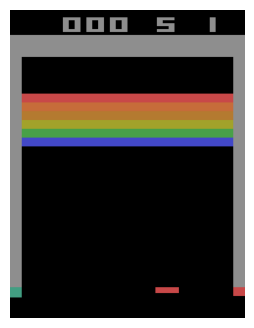

False


In [ ]:
def plot_environment_state(env, figsize=(5, 4)):
  #show screen
  img = env.render()
  print(img.shape)
  plt.figure(figsize=figsize)
  img = env.render()
  plt.imshow(img)
  plt.axis("off")
  return img
plot_environment_state(env)
plt.show()
def ball_exists(obs):
  ball_x = obs[99]  #balls X
  ball_y = obs[101]  #balls Y

  # if both X and Y are non-zero, the ball is on-screen
  return ball_x != 0 and ball_y != 0
print(ball_exists(obs))

[ 63  63  63  63  63  63 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 192 192 192 192 192 192
 255 255 255 255 255 255 255 255 255 255 255 255 255 240   0   0 255   0
   0 240   0   5   0   0   6   0  70 182 134 198  22  38  54  70  88   2
 146   0   4   0   0   0   0   0   0 241   0 242   0 242  25 241   5 242
   4   0 255   0 224  68   0   0   0 124   0 116   0   1   0   1   0   0
   8   0 255 255 255 255 255 255 255   0   0   5   0   0 186 214 117 246
 219 242]
(210, 160, 3)


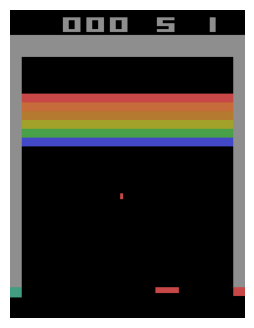

True


In [ ]:
#just show env is working /more debug info
obs, reward, done, truncated, info = env.step(Action.FIRE)#just show its working
print(obs)
plot_environment_state(env)
plt.show()
print(ball_exists(obs))#show that func works

# The Network Structure

Small DNN for relatively simple task. This size was determined by looking at other examples (most were CNNs which used the RGB version of the game) and using that as a baseline to create a similarly complex non-CNN DNN (accounting for the fact that a CNN with the same number of layers is more complex). Based on experimentation, this one performed best.

The model for targets and actions are seprate, as if the same network is used to both estimate the Q-values and update them, the learning process can become unstable because of the Q-values constantly changing, to avoid this we are using a seperate target and action model.

This also reduces overestimation bias, a problem caused by the maximization in the update rule as it can easily be affected by noise, the use of a target network provides less correlation between states and a more stable target, which leads to overall more accurate Q-value estimates.

This technique is called Double DQN, the models are identical in strucure. The target will be periodically updated by the training loop based on a variable (TARGET_UPDATE_FREQ).



In [ ]:
action_model = keras.models.Sequential()
action_model.add(keras.layers.InputLayer(input_shape=(128,), batch_size=1))
action_model.add(keras.layers.Dense(1024, activation="silu"))
action_model.add(keras.layers.Dense(512, activation="silu"))
action_model.add(keras.layers.Dense(256, activation="silu"))
action_model.add(keras.layers.Dense(128, activation="silu"))
action_model.add(keras.layers.Dense(Action.N_ACTIONS, activation="softmax"))

action_model.summary()

action_model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS_FUNC,
    metrics=['accuracy'],
)

target_model = keras.models.clone_model(action_model)
target_model.set_weights(action_model.get_weights())
target_model.summary()

target_model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS_FUNC,
    metrics=['accuracy'],
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (1, 1024)                   │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 512)                    │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 256)                    │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 128)                    │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 4)                      │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 821,636 (3.13 MB)

 Trainable params: 821,636 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (1, 1024)                   │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 512)                    │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 256)                    │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 128)                    │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 4)                      │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 821,636 (3.13 MB)

 Trainable params: 821,636 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def epsilon_greedy_policy(state, epsilon=EPSILON):
  if np.random.rand() < epsilon:
    return np.random.randint(Action.N_ACTIONS)  # random action
  else:
    pred_state = np.expand_dims(state, axis=0)
    Q_values = action_model.predict(pred_state, verbose=0)
    return Q_values.argmax()  # optimal action according to the DQ

# Independently researched concepts

We utilized random seed initialization (set to 42, haha!) in order to allow the results to be reproducable if necessary.

The Double DQN model allows for regularization. Regular DNN Regularization techniques such as dropout do not have a huge effect in DQN due to using experience replay as well as the nature of the exploration process.

This DQN uses Prioritized Experience Replay. It differs from a standard replay buffer, in which every experience has an equal chance of being replayed. Using PER takes into account that some experiences are more valuble than others. It assigns each experience a priority based on its significance, increasing the probability of valuable experiences being replayed during training. This uses the temporal difference error as the priority.

It speeds up convergence to lower loss values, but it affects the training graphs by making the loss not decrease so much over time as it's picking high-loss examples in the training step.

The PER showed considerable improvements of efficacy and training speed over the traditional replay buffer, and as a result we decided to keep it implemented for the final version of the model.


https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
This is a modification of the linked OpenAI code


The storage weights also incorporate a clipping algorithm in order to smoothen  the sampling process via normalization and compensation for inherent biases in the sampling by normalizing the weights to not become too large or small.

In [ ]:
#https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py

class PrioritizedReplayBuffer:
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0
        self._alpha = .4 #How much prioritization is used (0 - no prioritization, 1 - full prioritization)
        self._priorities = np.zeros((size,), dtype=np.float32)

    def __len__(self):
        return len(self._storage)

    def append(self, state, action, reward, next_state, done, truncated, td_error):
        """Add a transition to the buffer with an optional priority."""
        data = (state, action, reward, next_state, done, truncated)

        # Assign max priority if td_error is not provided
        max_priority = self._priorities.max() if self._storage else 1.0
        priority = max_priority if td_error is None else abs(td_error) ** self._alpha

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data

        # Store priority
        self._priorities[self._next_idx] = priority
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones, truncateds = [], [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done, truncated = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
            truncateds.append(truncated)
        return (np.array(obses_t), np.array(actions), np.array(rewards),
                np.array(obses_tp1), np.array(dones), np.array(truncateds))

    def sample(self):
        """Sample a batch of experiences, weighted by priority.

        Parameters
        ----------
        batch_size: int
            Number of transitions to sample.
        beta: float
            Importance sampling factor to correct priority bias (0 - no correction, 1 - full correction).

        Returns
        -------
        obs_batch, act_batch, rew_batch, next_obs_batch, done_mask, weights, idxes
        """
        beta = .3

        if len(self._storage) == 0:
            raise ValueError("Replay buffer is empty!")

        # Compute probabilities and sample
        priorities = self._priorities[:len(self._storage)]
        probabilities = priorities / priorities.sum()
        idxes = np.random.choice(len(self._storage), BATCH_SZ, p=probabilities)

        # Importance sampling weights
        weights = (len(self._storage) * probabilities[idxes]) ** (-beta)
        weights /= weights.max()  # Normalize weights to [0, 1]

        encoded_sample = self._encode_sample(idxes)
        return (*encoded_sample, weights, idxes)

    def update_priorities(self, idxes, td_errors):
        """Update priorities of sampled transitions.

        Parameters
        ----------
        idxes: [int]
            Indices of sampled transitions.
        td_errors: [float]
            New TD errors for the sampled transitions.
        """
        for idx, td_error in zip(idxes, td_errors):
            assert 0 <= idx < len(self._storage)
            priority = abs(td_error) ** self._alpha
            self._priorities[idx] = priority
replay_buffer = PrioritizedReplayBuffer(500000)

In [ ]:
def play_one_step(env, state, epsilon):
  #epsilon greedy again to avoid resundant code getting td err
  if np.random.rand() < epsilon:
    action = np.random.randint(Action.N_ACTIONS)
    next_state, reward, done, truncated, info = env.step(action)
  else:
    pred_state = np.expand_dims(state, axis=0)

    Q_values = action_model.predict(pred_state, verbose=0)
    #return Q_values.argmax()  # optimal action according to the DQ
    action = Q_values.argmax()
    next_state, reward, done, truncated, info = env.step(action)

    # Predict Q-values for the next state
    next_state_tensor = tf.convert_to_tensor(next_state, dtype=tf.float32)
    next_state_tensor = tf.expand_dims(next_state_tensor, axis=0)
    next_q_values_target = target_model(next_state_tensor).numpy()

    # Calculate TD error
    td_error = reward + DISCOUNT * np.max(next_q_values_target) - np.max(Q_values)
    #add to replay buffer
    replay_buffer.append(state, action, reward, next_state, done, truncated,td_error)
  return next_state, reward, done, truncated, info, action

In [ ]:
#reproducibility
env.reset(seed=SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
rewards = []
losses = []

# A very clear and extremely detailed discussion on the code where the Q learning update applied to the weights

This is the core of DQN learning process:

We start by sampling from Replay Buffer:

`states, actions, rewards, next_states, dones, truncateds, weights,idxs = replay_buffer.sample()`

Retrieves a batch of experiences from the replay buffer. The replay buffer stores past experiences, this lets the agent learn from them multiple times.

`best_actions = np.argmax(action_model.predict(next_states, verbose=0), axis=1)`

Predicts the Q-values for the next states after the sampled states from the replay buffer using the action_model and selects the action with the highest Q-value for each state, representing the optimal action according to the current policy.

`next_Q_values = target_model.predict(next_states, verbose=0)`

Predicts the Q-values for the next_states using the target_model. The target model is a copy of the action_model but is updated less frequently, providing more stable targets for training and improving stability.

`max_next_Q_values = next_Q_values[np.arange(BATCH_SZ), best_actions]`

Select the Q-values corresponding to the best actions determined in the previous step(estimated maximum future rewards)

`target_Q_values = rewards + runs * DISCOUNT * max_next_Q_values Q(s,a) = Q(s,a) + a[r+ ymax_a'(Q(s',a')) - Q(s,a)]`

DQN update calculates the target Q-values using the Bellman equation. This differs from other reinforcement learning update mechanisms such as SARSA because it is off-policy and it updates the weights based on the maximum possible next value instead of the value of the action that it took.   

`with tf.GradientTape() as tape:`

Enters a TensorFlow GradientTape context to record operations for automatic differentiation, which is crucial for calculating gradients during backpropagation.

`all_Q_values = action_model(states)`

Predicts the Q-values for the current states using the action_model.

`Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)`

Extracts the Q-values corresponding to the actual actions taken, using the one-hot encoded mask.

`loss = tf.reduce_mean(LOSS_FUNC(target_Q_values, Q_values))`

Calculates the loss between the target Q-values and the predicted Q-values.


```
grads = tape.gradient(loss, action_model.trainable_variables)
OPTIMIZER.apply_gradients(zip(grads, action_model.trainable_variables))
```
actually update the target model with the weights.

```
  td_errors = tf.convert_to_tensor(target_Q_values).numpy().flatten() - Q_values.numpy().flatten()  
  replay_buffer.update_priorities(idxs, np.abs(td_errors))
```
get the temporal differences as a list to pass to the PER buffer so it can update its new priorities
.




Using epsilon greedy as thompson sampling and boltzmann action selection slowed training without actually affecting the average score. I think that epsilon greedy's direct approch is best in this scenario.

In [ ]:
def training_step():
  states, actions, rewards, next_states, dones, truncateds, weights,idxs = replay_buffer.sample()
  #next_states = np.array(next_states, dtype=np.float32)
  next_states = np.array([state for state in next_states], dtype=np.float32)
  best_actions = np.argmax(action_model.predict(next_states, verbose=0), axis=1)
  next_Q_values = target_model.predict(next_states, verbose=0)  # Use target_model for evaluation
  max_next_Q_values = next_Q_values[np.arange(BATCH_SZ), best_actions]  # Select Q-values for best actions

  runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
  target_Q_values = rewards + runs * DISCOUNT * max_next_Q_values
  target_Q_values = target_Q_values.reshape(-1, 1)
  mask = tf.one_hot(actions, Action.N_ACTIONS)
  with tf.GradientTape() as tape:
    all_Q_values = action_model(states)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
    loss = tf.reduce_mean(LOSS_FUNC(target_Q_values, Q_values))
    print(f"loss: {loss}")
    losses.append(loss.numpy())
    grads = tape.gradient(loss, action_model.trainable_variables)
    OPTIMIZER.apply_gradients(zip(grads, action_model.trainable_variables))
  td_errors = tf.convert_to_tensor(target_Q_values).numpy().flatten() - Q_values.numpy().flatten()
  replay_buffer.update_priorities(idxs, np.abs(td_errors))

# Core Training Loop

The core training loop iterates through until it hits the specified number of episodes. For each loop, the model iterates through a pre-determined number of steps. The game continues until the model runs out of lives or hits the maximum number of steps.

The first step is to calculate the epsilon value. This value starts high to encourage exploration, then as the model comes closes to finishing, the epsilon decreases in order to encourage exploitation, forcing the model to choose it's predicted Q-Values rather than random choice.
To account for the relatively short number of episodes (as opposed to the tens of thousands that seem standard in practical reinforcement learning use cases like this), the epsilon is set to 0.9 for the first 3/5ths of the execution (150 episodes).
This encourages the model to choose it's next step more randomly, encouraging exploration of its environment. Foregoing this led to situations where the model would not learn at all, or get worse over time.

After these 150 episodes the epsilon decreases sharply (to 0.57), as it is encouraged to exploit its replay buffer data to learn and improve.
Our reward heuristic is fairly simple.

We manually implemented a punishment heuristic to penalize the model for losing a life. We chose to implement the default reward value, which gives a point for each block broken in the game. (this reward is produced in the play_one_step method, which is called once per loop and passed through to the reward variable in the training loop).

These punishment and reward metrics were decided as they provided the most optimal results (providing the best convergence speed, maximum score, and average score) after much experimentation. We experimented with ideas such as not rewarding for block breaking, but for the paddle's alignment with the ball on the X-axis.

Occasionally we printed the model's state to get an idea of how the model was performing at different points in the training which, as printing frame by frame, acts as a video to see the model's gameplay. We chose this method as it is more convenient than saving a recording to a google drive environment via Gymnasium wrappers.

Episode: 1, Steps: 190 Reward:0.0 Epsilon: 0.9

Episode: 2, Steps: 173 Reward:-1.0 Epsilon: 0.9

Episode: 3, Steps: 164 Reward:-1.0 Epsilon: 0.9

Episode: 4, Steps: 289 Reward:2.0 Epsilon: 0.9

Episode: 5, Steps: 199 Reward:0.0 Epsilon: 0.9

loss: 0.023067153990268707
Episode: 6, Steps: 260 Reward:1.0 Epsilon: 0.9

loss: 0.047207508236169815
Episode: 7, Steps: 219 Reward:0.0 Epsilon: 0.9

loss: 0.09985779970884323
Episode: 8, Steps: 141 Reward:-2.0 Epsilon: 0.9

loss: 0.06227338686585426
Episode: 9, Steps: 197 Reward:0.0 Epsilon: 0.9

loss: 0.056179530918598175
Episode: 10, Steps: 127 Reward:-2.0 Epsilon: 0.9

loss: 0.08935394883155823
Episode: 11, Steps: 138 Reward:-2.0 Epsilon: 0.9

loss: 0.0560719259083271
Episode: 12, Steps: 259 Reward:1.0 Epsilon: 0.9

loss: 0.039903152734041214
Episode: 13, Steps: 174 Reward:-1.0 Epsilon: 0.9

loss: 0.04133645445108414
Episode: 14, Steps: 211 Reward:0.0 Epsilon: 0.9

loss: 0.08844336867332458
Episode: 15, Steps: 256 Reward:1.0 Epsilon: 0.9

loss:

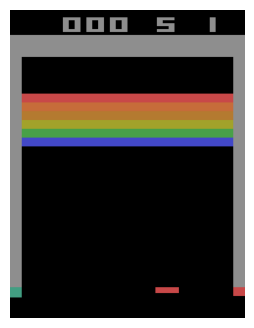

Round reward: 0.0 ep: 51
(210, 160, 3)


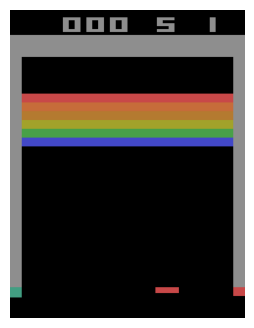

Round reward: 0.0 ep: 51
(210, 160, 3)


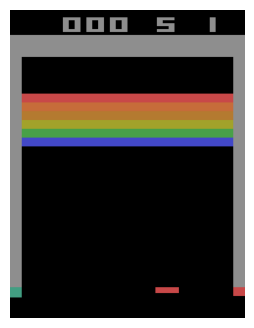

Round reward: 0.0 ep: 51
(210, 160, 3)


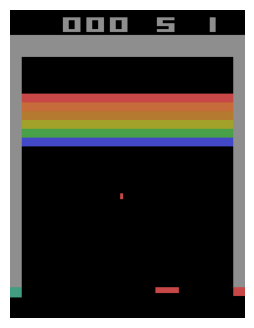

Round reward: 0.0 ep: 51
(210, 160, 3)


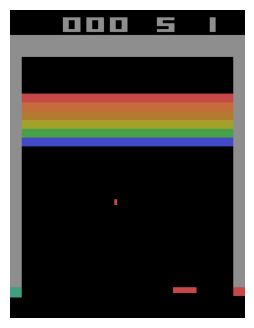

Round reward: 0.0 ep: 51
(210, 160, 3)


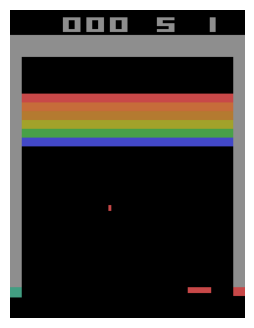

Round reward: 0.0 ep: 51
(210, 160, 3)


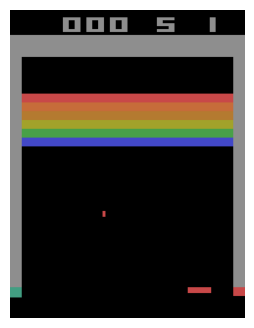

Round reward: 0.0 ep: 51
(210, 160, 3)


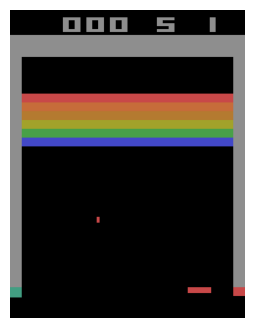

Round reward: 0.0 ep: 51
(210, 160, 3)


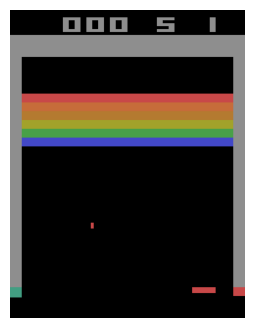

Round reward: 0.0 ep: 51
(210, 160, 3)


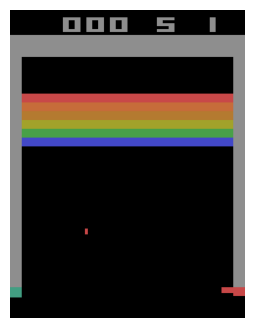

Round reward: 0.0 ep: 51
(210, 160, 3)


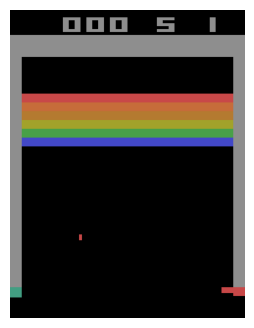

Round reward: 0.0 ep: 51
(210, 160, 3)


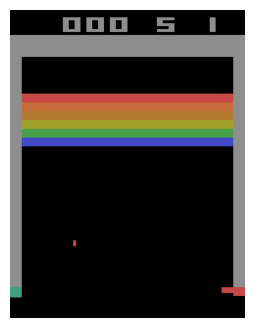

Round reward: 0.0 ep: 51
(210, 160, 3)


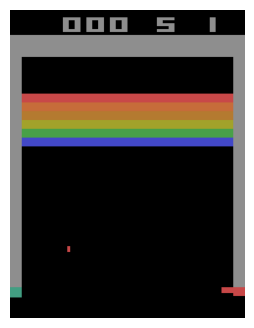

Round reward: 0.0 ep: 51
(210, 160, 3)


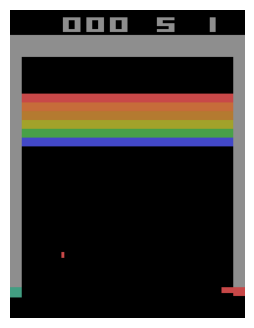

Round reward: 0.0 ep: 51
(210, 160, 3)


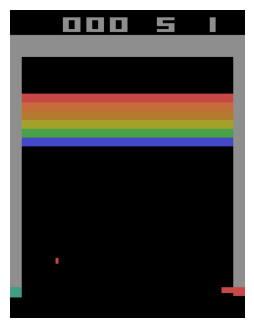

Round reward: 0.0 ep: 51
(210, 160, 3)


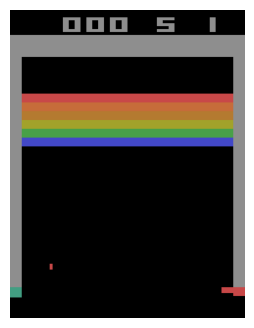

Round reward: 0.0 ep: 51
(210, 160, 3)


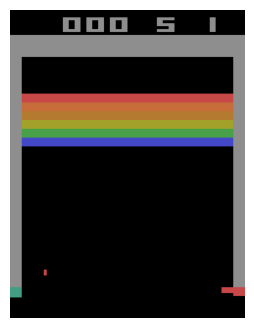

Round reward: 0.0 ep: 51
(210, 160, 3)


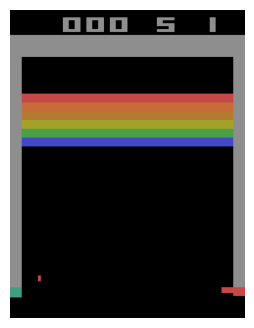

Round reward: 0.0 ep: 51
(210, 160, 3)


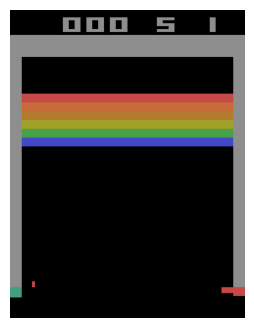

Round reward: 0.0 ep: 51
(210, 160, 3)


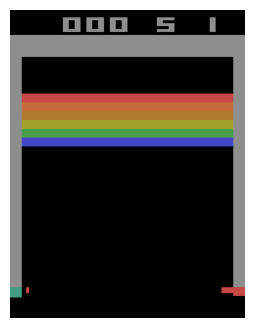

Round reward: 0.0 ep: 51
(210, 160, 3)


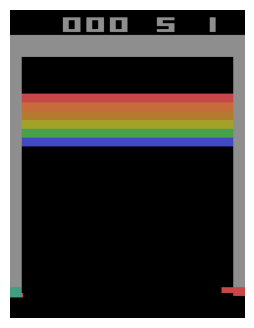

Round reward: 0.0 ep: 51
(210, 160, 3)


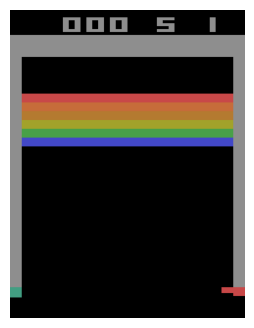

Round reward: 0.0 ep: 51
(210, 160, 3)


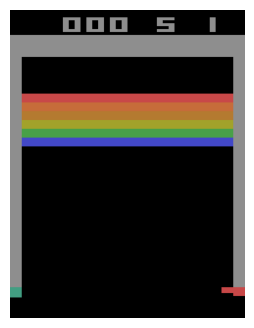

Round reward: 0.0 ep: 51
(210, 160, 3)


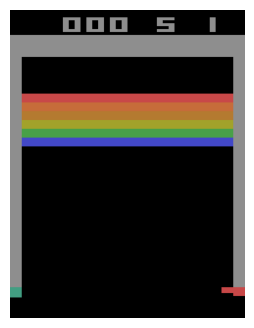

Round reward: 0.0 ep: 51
(210, 160, 3)


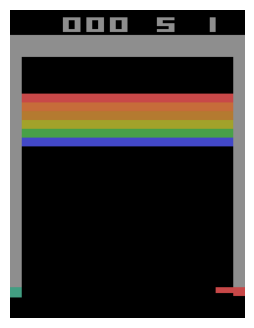

Round reward: 0.0 ep: 51
(210, 160, 3)


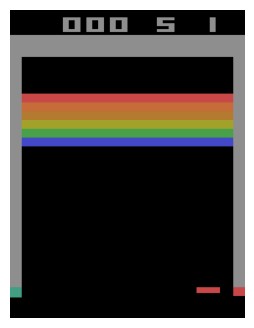

Round reward: 0.0 ep: 51
(210, 160, 3)


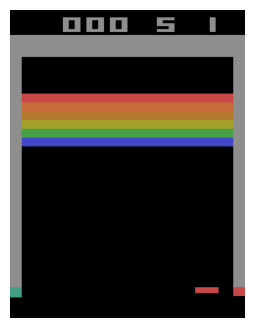

Round reward: 0.0 ep: 51
(210, 160, 3)


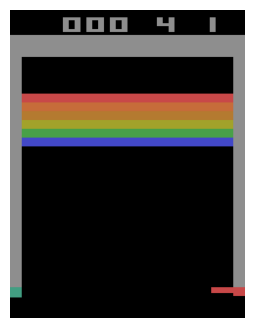

Round reward: -0.4 ep: 51
(210, 160, 3)


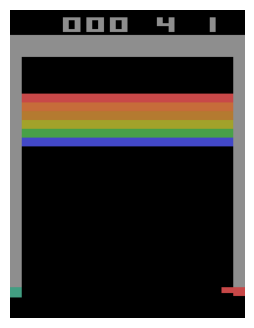

Round reward: -0.4 ep: 51
(210, 160, 3)


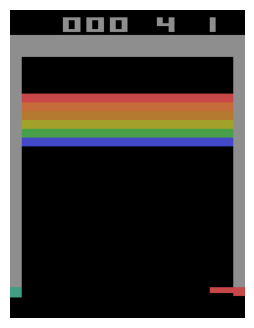

Round reward: -0.4 ep: 51
(210, 160, 3)


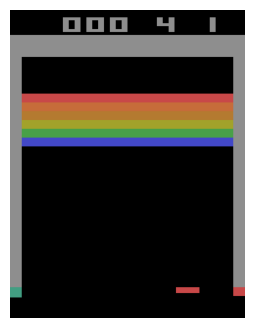

Round reward: -0.4 ep: 51
(210, 160, 3)


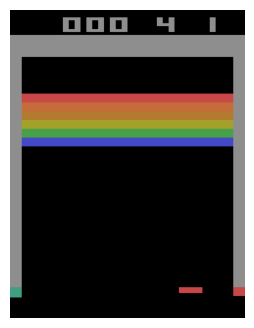

Round reward: -0.4 ep: 51
(210, 160, 3)


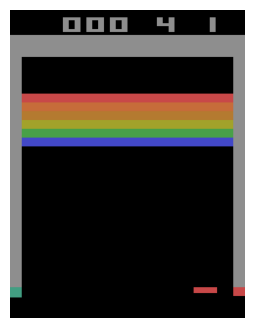

Round reward: -0.4 ep: 51
(210, 160, 3)


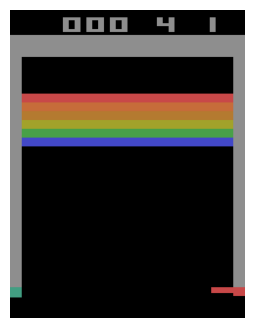

Round reward: -0.4 ep: 51
(210, 160, 3)


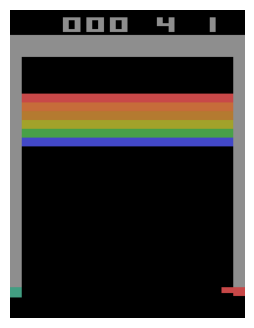

Round reward: -0.4 ep: 51
(210, 160, 3)


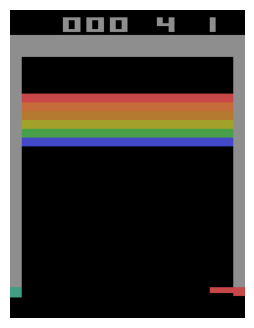

Round reward: -0.4 ep: 51
(210, 160, 3)


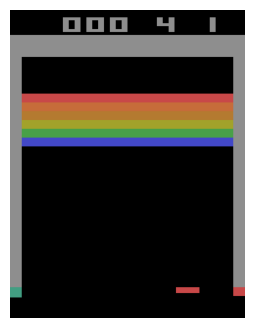

Round reward: -0.4 ep: 51
(210, 160, 3)


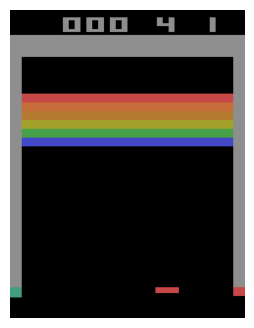

Round reward: -0.4 ep: 51
(210, 160, 3)


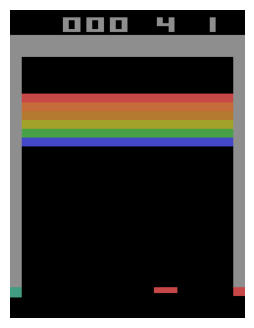

Round reward: -0.4 ep: 51
(210, 160, 3)


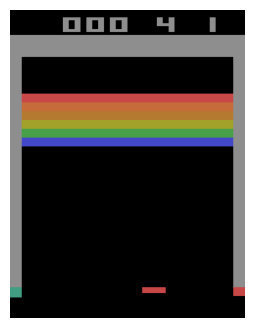

Round reward: -0.4 ep: 51
(210, 160, 3)


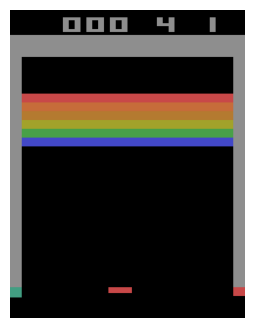

Round reward: -0.4 ep: 51
(210, 160, 3)


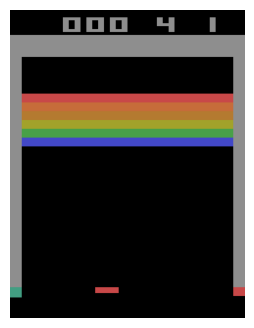

Round reward: -0.4 ep: 51
(210, 160, 3)


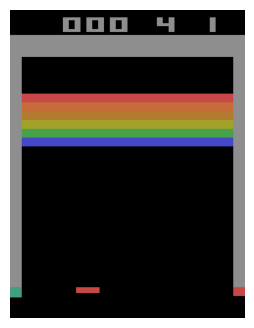

Round reward: -0.4 ep: 51
(210, 160, 3)


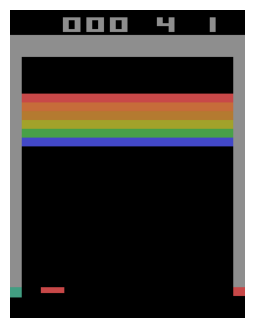

Round reward: -0.4 ep: 51
(210, 160, 3)


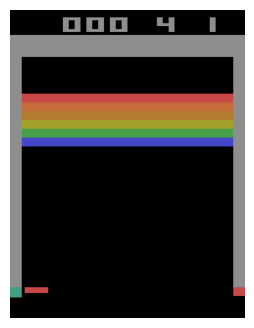

Round reward: -0.4 ep: 51
(210, 160, 3)


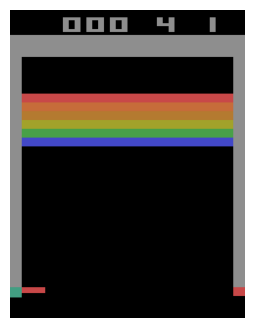

Round reward: -0.4 ep: 51
(210, 160, 3)


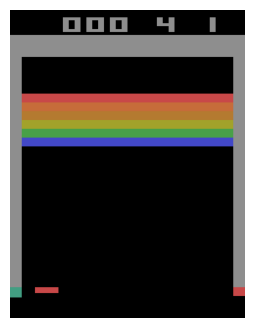

Round reward: -0.4 ep: 51
(210, 160, 3)


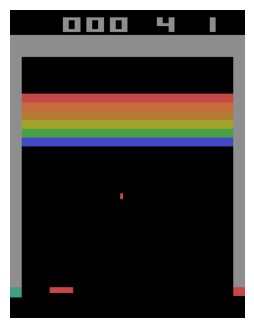

Round reward: -0.4 ep: 51
(210, 160, 3)


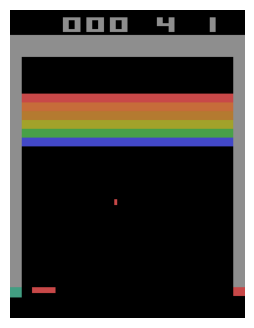

Round reward: -0.4 ep: 51
(210, 160, 3)


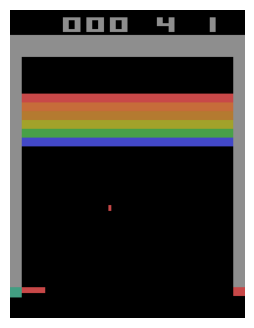

Round reward: -0.4 ep: 51
(210, 160, 3)


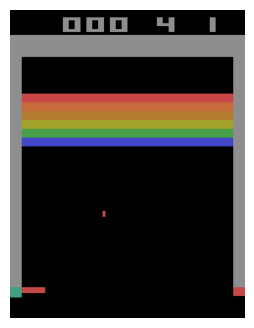

Round reward: -0.4 ep: 51
(210, 160, 3)


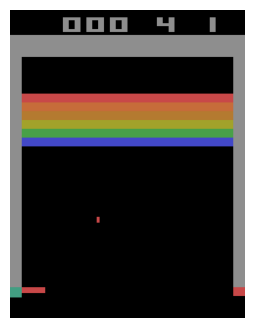

Round reward: -0.4 ep: 51
(210, 160, 3)


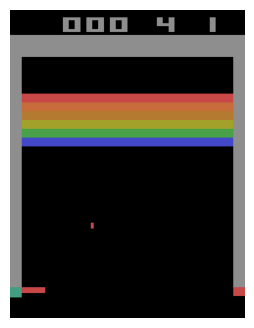

Round reward: -0.4 ep: 51
(210, 160, 3)


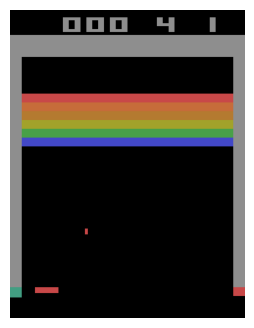

Round reward: -0.4 ep: 51
(210, 160, 3)


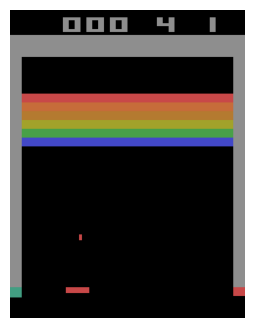

Round reward: -0.4 ep: 51
(210, 160, 3)


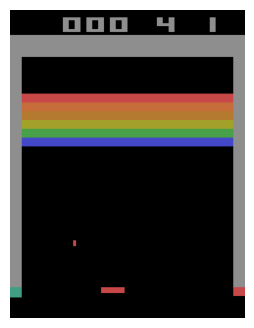

Round reward: -0.4 ep: 51
(210, 160, 3)


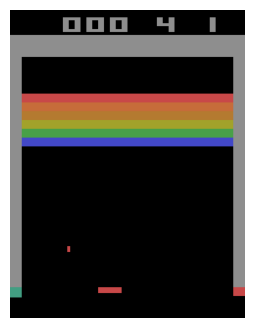

Round reward: -0.4 ep: 51
(210, 160, 3)


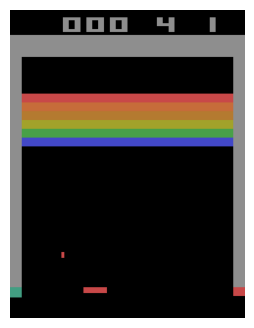

Round reward: -0.4 ep: 51
(210, 160, 3)


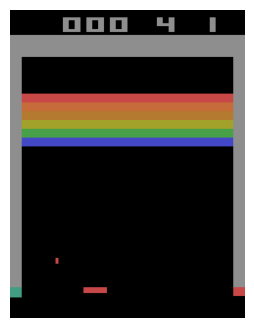

Round reward: -0.4 ep: 51
(210, 160, 3)


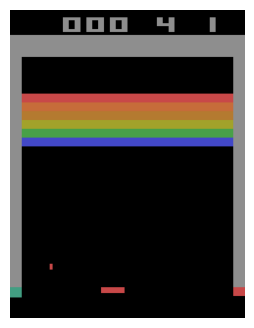

Round reward: -0.4 ep: 51
(210, 160, 3)


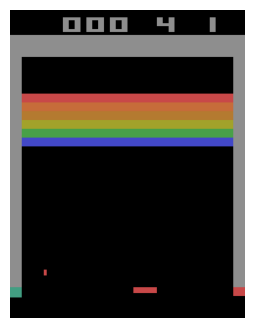

Round reward: -0.4 ep: 51
(210, 160, 3)


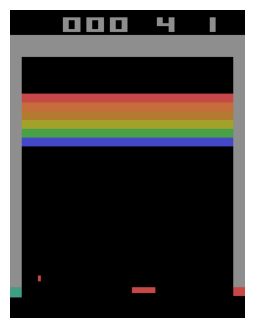

Round reward: -0.4 ep: 51
(210, 160, 3)


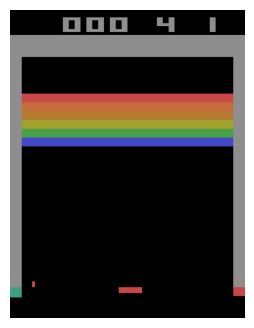

Round reward: -0.4 ep: 51
(210, 160, 3)


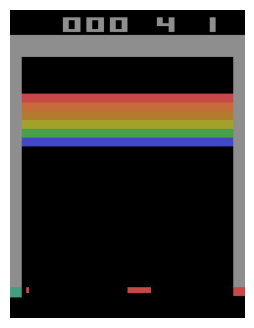

Round reward: -0.4 ep: 51
(210, 160, 3)


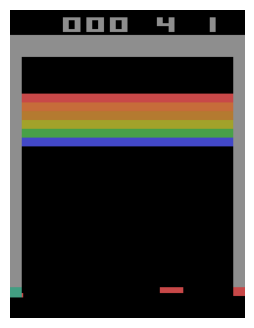

Round reward: -0.4 ep: 51
(210, 160, 3)


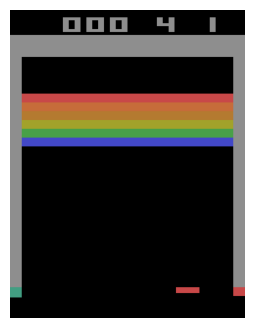

Round reward: -0.4 ep: 51
(210, 160, 3)


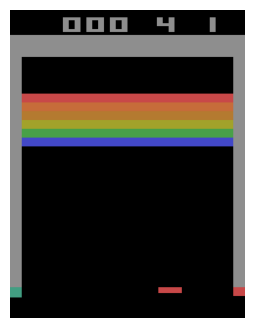

Round reward: -0.4 ep: 51
(210, 160, 3)


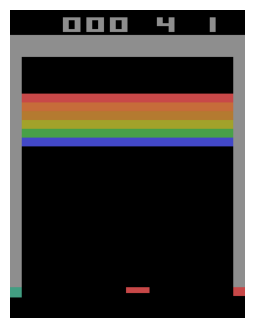

Round reward: -0.4 ep: 51
(210, 160, 3)


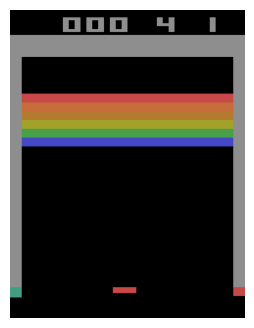

Round reward: -0.4 ep: 51
(210, 160, 3)


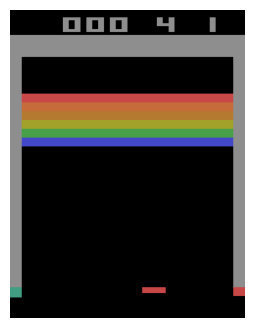

Round reward: -0.4 ep: 51
(210, 160, 3)


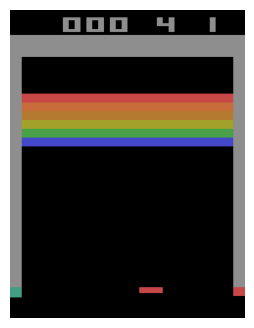

Round reward: -0.4 ep: 51
(210, 160, 3)


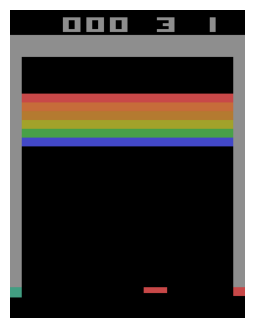

Round reward: -0.8 ep: 51
(210, 160, 3)


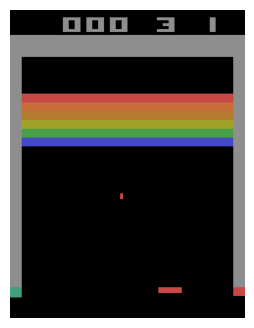

Round reward: -0.8 ep: 51
(210, 160, 3)


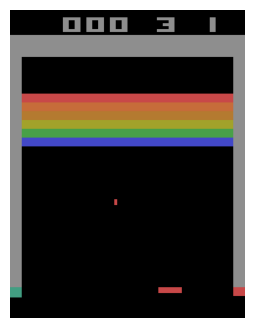

Round reward: -0.8 ep: 51
(210, 160, 3)


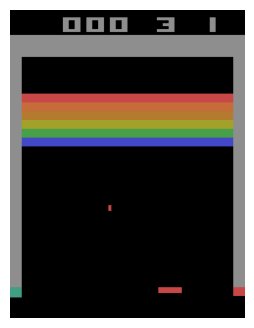

Round reward: -0.8 ep: 51
(210, 160, 3)


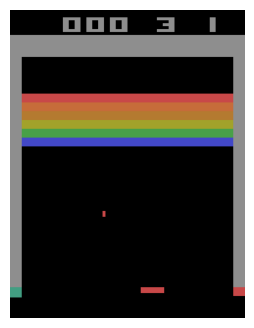

Round reward: -0.8 ep: 51
(210, 160, 3)


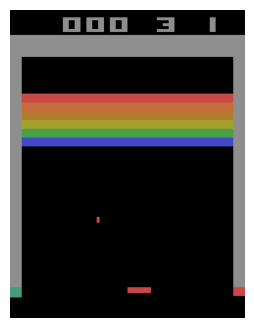

Round reward: -0.8 ep: 51
(210, 160, 3)


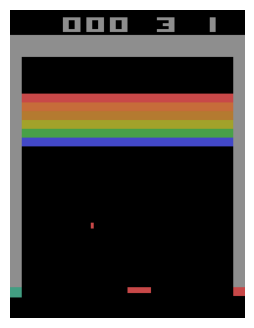

Round reward: -0.8 ep: 51
(210, 160, 3)


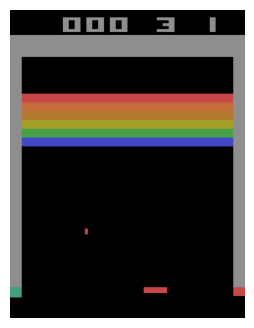

Round reward: -0.8 ep: 51
(210, 160, 3)


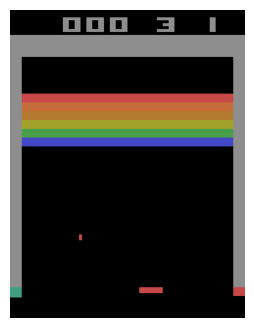

Round reward: -0.8 ep: 51
(210, 160, 3)


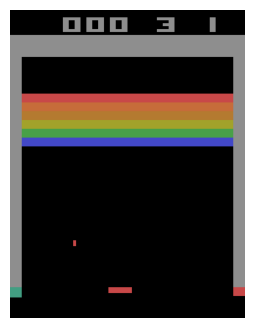

Round reward: -0.8 ep: 51
(210, 160, 3)


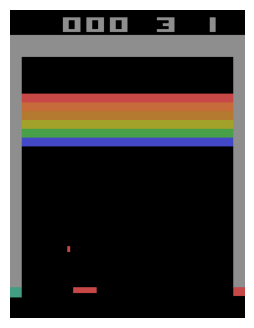

Round reward: -0.8 ep: 51
(210, 160, 3)


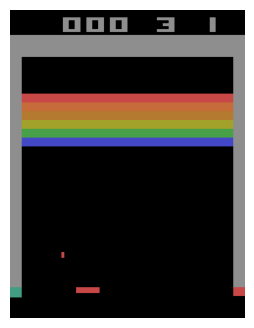

Round reward: -0.8 ep: 51
(210, 160, 3)


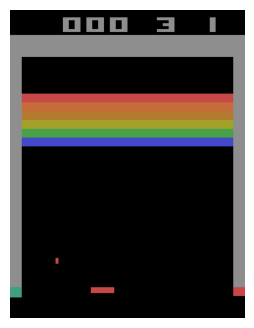

Round reward: -0.8 ep: 51
(210, 160, 3)


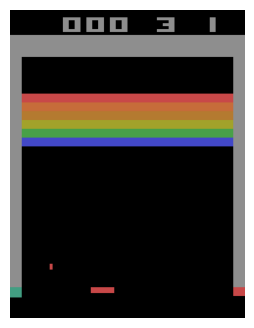

Round reward: -0.8 ep: 51
(210, 160, 3)


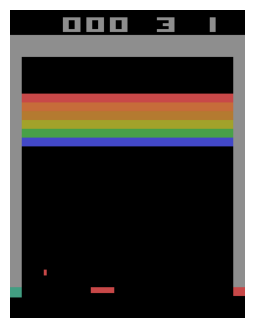

Round reward: -0.8 ep: 51
(210, 160, 3)


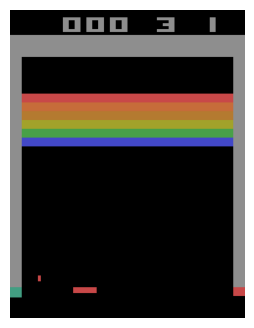

Round reward: -0.8 ep: 51
(210, 160, 3)


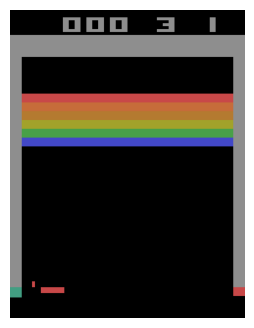

Round reward: -0.8 ep: 51
(210, 160, 3)


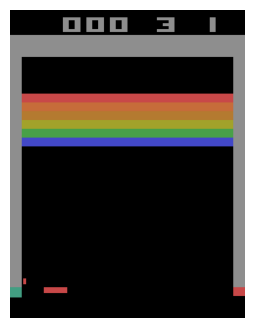

Round reward: -0.8 ep: 51
(210, 160, 3)


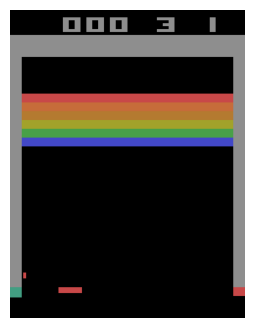

Round reward: -0.8 ep: 51
(210, 160, 3)


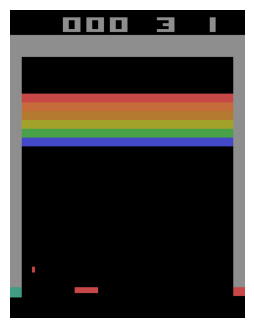

Round reward: -0.8 ep: 51
(210, 160, 3)


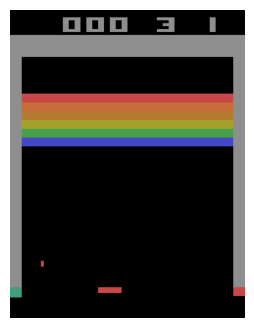

Round reward: -0.8 ep: 51
(210, 160, 3)


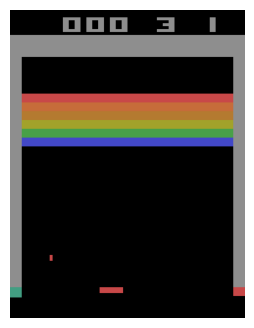

Round reward: -0.8 ep: 51
(210, 160, 3)


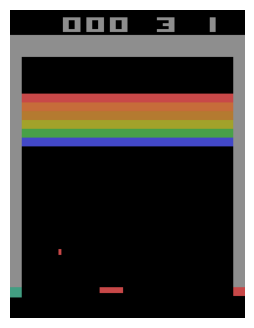

Round reward: -0.8 ep: 51
(210, 160, 3)


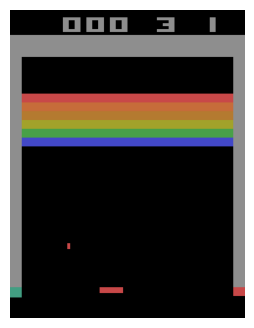

Round reward: -0.8 ep: 51
(210, 160, 3)


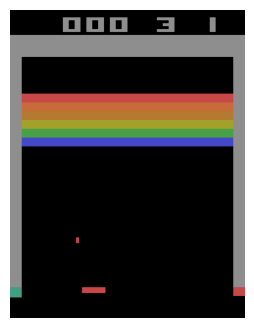

Round reward: -0.8 ep: 51
(210, 160, 3)


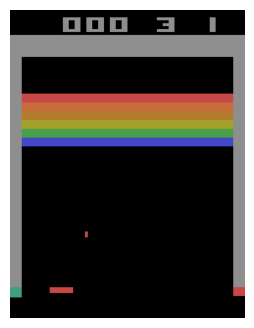

Round reward: -0.8 ep: 51
(210, 160, 3)


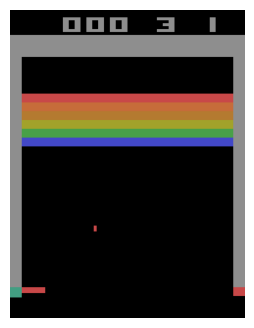

Round reward: -0.8 ep: 51
(210, 160, 3)


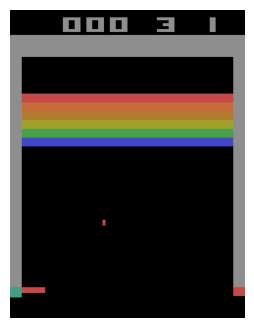

Round reward: -0.8 ep: 51
(210, 160, 3)


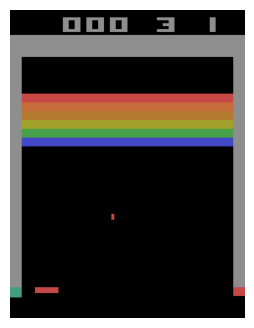

Round reward: -0.8 ep: 51
(210, 160, 3)


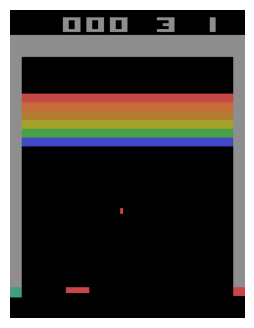

Round reward: -0.8 ep: 51
(210, 160, 3)


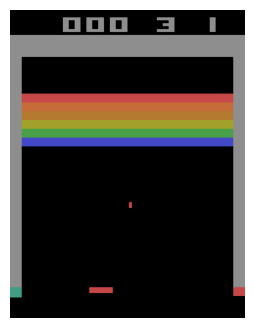

Round reward: -0.8 ep: 51
(210, 160, 3)


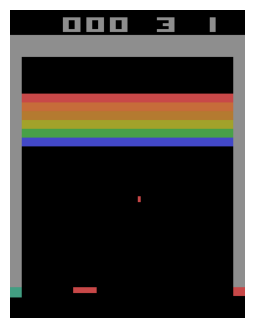

Round reward: -0.8 ep: 51
(210, 160, 3)


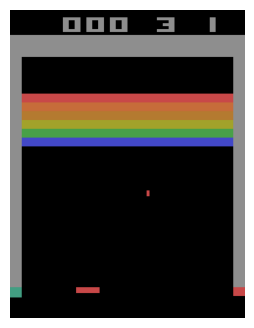

Round reward: -0.8 ep: 51
(210, 160, 3)


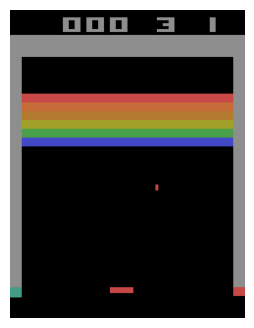

Round reward: -0.8 ep: 51
(210, 160, 3)


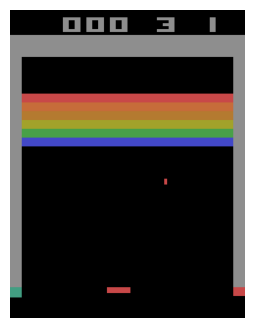

Round reward: -0.8 ep: 51
(210, 160, 3)


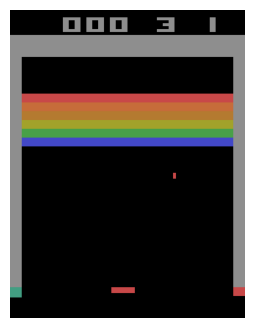

Round reward: -0.8 ep: 51
(210, 160, 3)


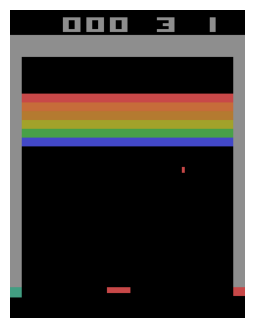

Round reward: -0.8 ep: 51
(210, 160, 3)


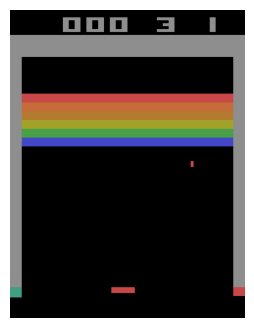

Round reward: -0.8 ep: 51
(210, 160, 3)


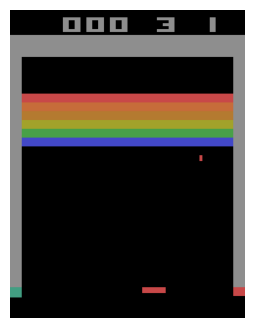

Round reward: -0.8 ep: 51
(210, 160, 3)


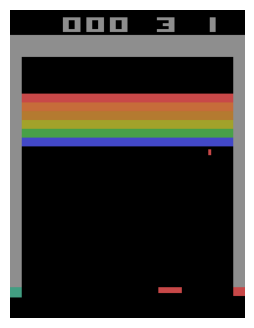

Round reward: -0.8 ep: 51
(210, 160, 3)


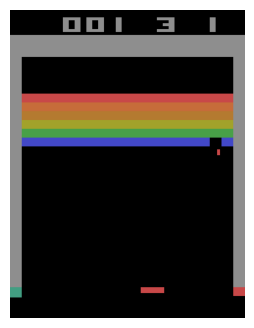

Round reward: 0.2 ep: 51
(210, 160, 3)


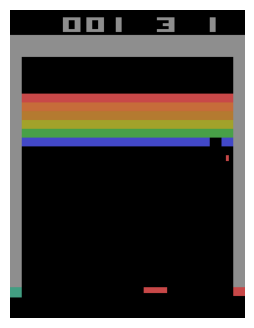

Round reward: 0.2 ep: 51
(210, 160, 3)


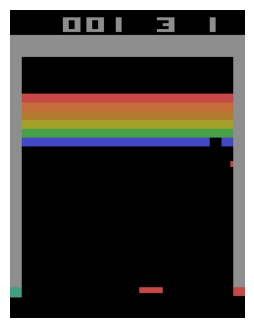

Round reward: 0.2 ep: 51
(210, 160, 3)


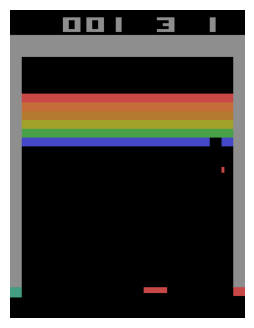

Round reward: 0.2 ep: 51
(210, 160, 3)


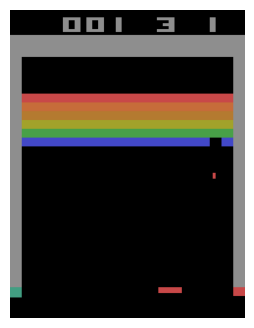

Round reward: 0.2 ep: 51
(210, 160, 3)


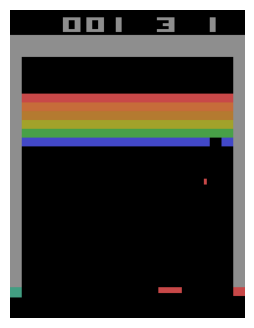

Round reward: 0.2 ep: 51
(210, 160, 3)


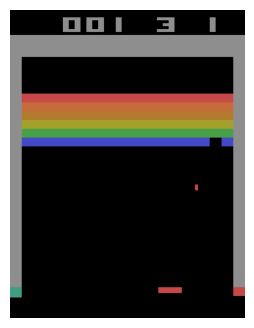

Round reward: 0.2 ep: 51
(210, 160, 3)


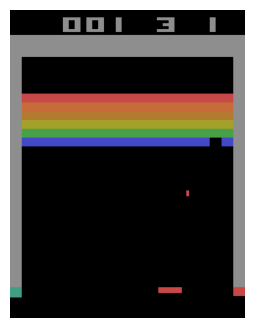

Round reward: 0.2 ep: 51
(210, 160, 3)


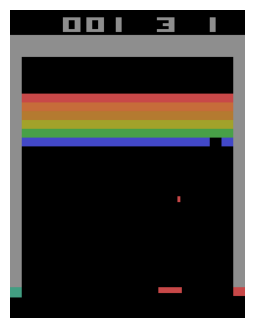

Round reward: 0.2 ep: 51
(210, 160, 3)


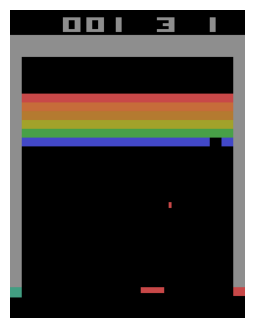

Round reward: 0.2 ep: 51
(210, 160, 3)


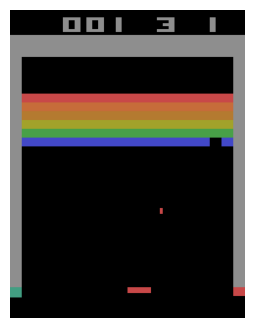

Round reward: 0.2 ep: 51
(210, 160, 3)


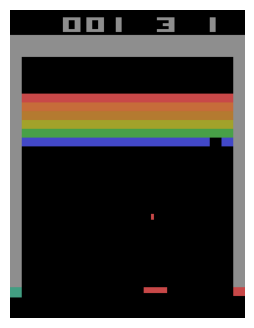

Round reward: 0.2 ep: 51
(210, 160, 3)


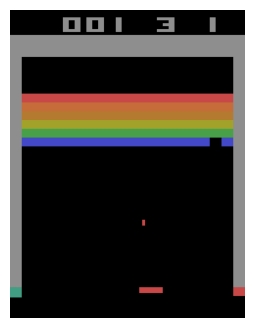

Round reward: 0.2 ep: 51
(210, 160, 3)


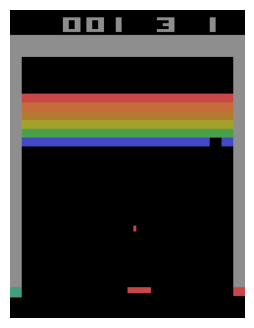

Round reward: 0.2 ep: 51
(210, 160, 3)


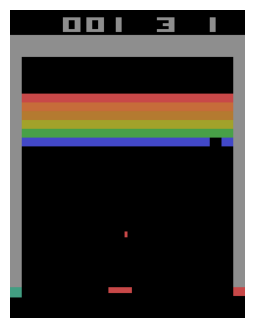

Round reward: 0.2 ep: 51
(210, 160, 3)


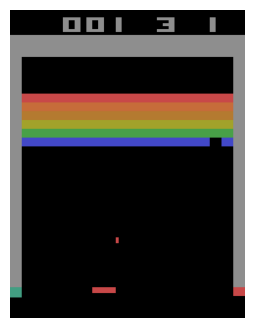

Round reward: 0.2 ep: 51
(210, 160, 3)


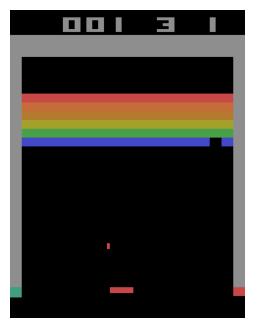

Round reward: 0.2 ep: 51
(210, 160, 3)


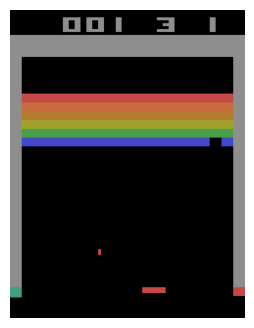

Round reward: 0.2 ep: 51
(210, 160, 3)


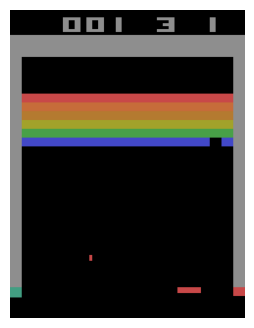

Round reward: 0.2 ep: 51
(210, 160, 3)


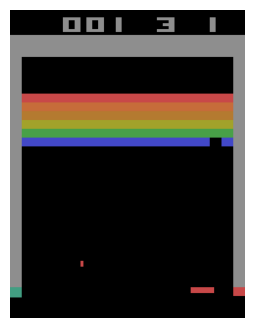

Round reward: 0.2 ep: 51
(210, 160, 3)


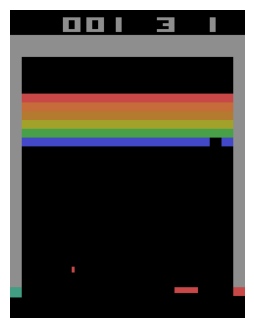

Round reward: 0.2 ep: 51
(210, 160, 3)


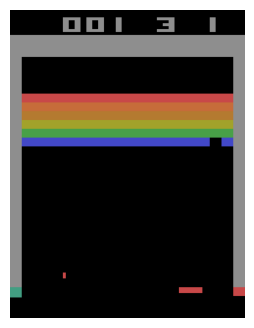

Round reward: 0.2 ep: 51
(210, 160, 3)


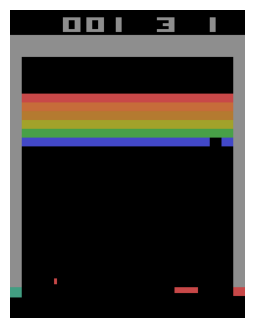

Round reward: 0.2 ep: 51
(210, 160, 3)


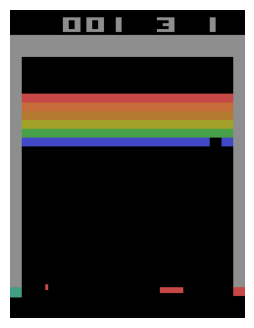

Round reward: 0.2 ep: 51
(210, 160, 3)


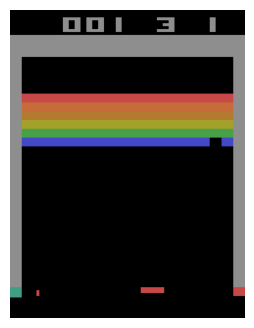

Round reward: 0.2 ep: 51
(210, 160, 3)


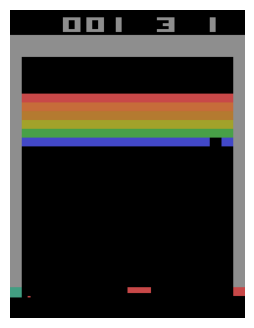

Round reward: 0.2 ep: 51
(210, 160, 3)


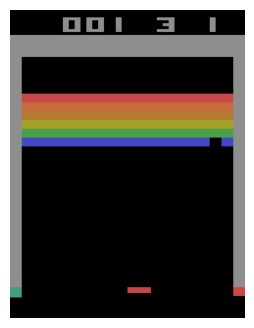

Round reward: 0.2 ep: 51
(210, 160, 3)


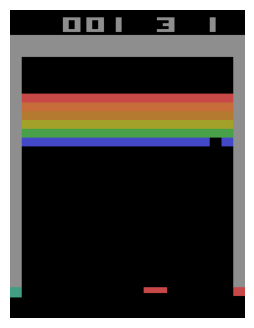

Round reward: 0.2 ep: 51
(210, 160, 3)


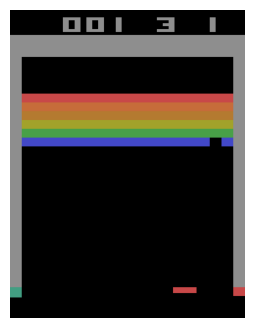

Round reward: 0.2 ep: 51
(210, 160, 3)


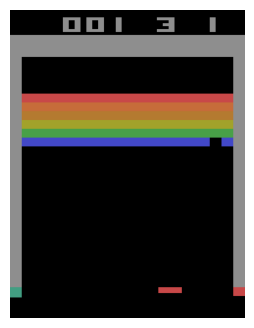

Round reward: 0.2 ep: 51
(210, 160, 3)


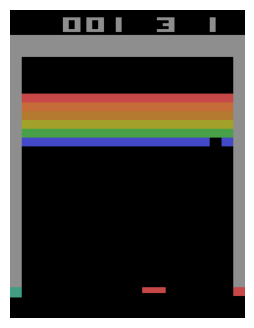

Round reward: 0.2 ep: 51
(210, 160, 3)


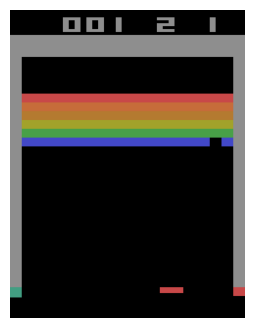

Round reward: -0.2 ep: 51
(210, 160, 3)


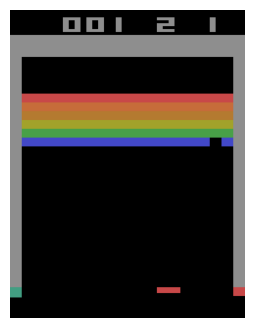

Round reward: -0.2 ep: 51
(210, 160, 3)


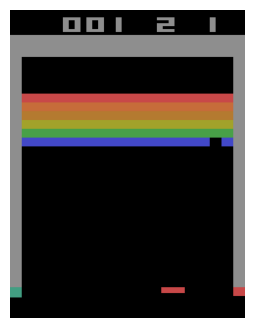

Round reward: -0.2 ep: 51
(210, 160, 3)


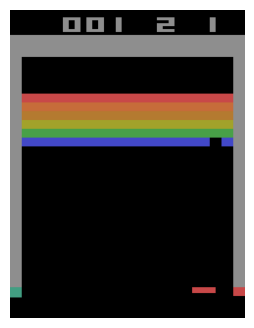

Round reward: -0.2 ep: 51
(210, 160, 3)


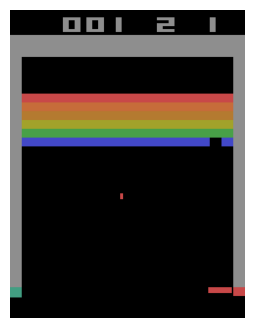

Round reward: -0.2 ep: 51
(210, 160, 3)


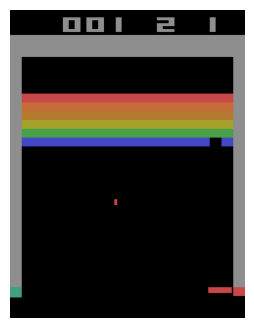

Round reward: -0.2 ep: 51
(210, 160, 3)


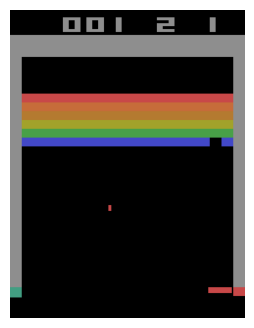

Round reward: -0.2 ep: 51
(210, 160, 3)


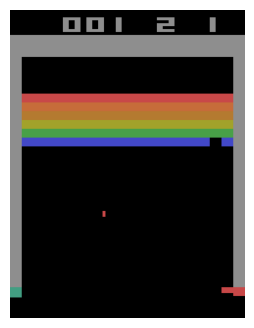

Round reward: -0.2 ep: 51
(210, 160, 3)


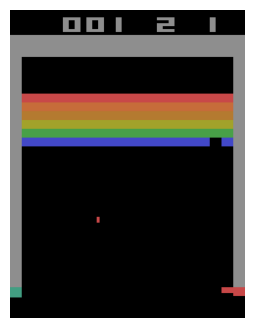

Round reward: -0.2 ep: 51
(210, 160, 3)


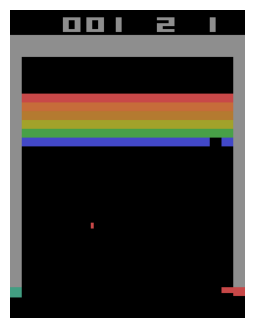

Round reward: -0.2 ep: 51
(210, 160, 3)


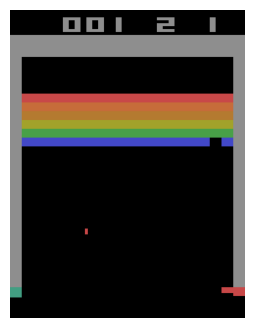

Round reward: -0.2 ep: 51
(210, 160, 3)


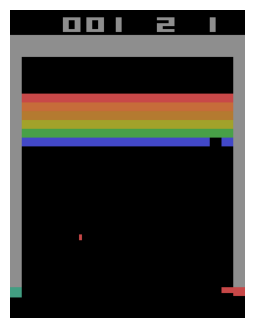

Round reward: -0.2 ep: 51
(210, 160, 3)


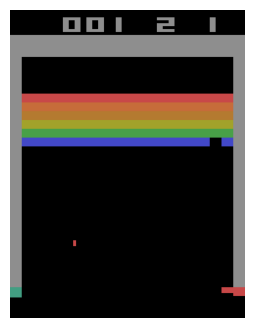

Round reward: -0.2 ep: 51
(210, 160, 3)


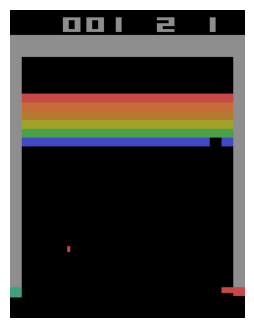

Round reward: -0.2 ep: 51
(210, 160, 3)


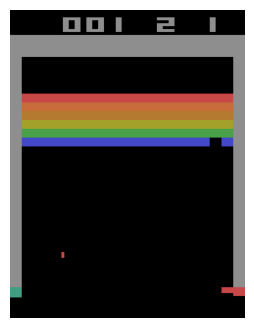

Round reward: -0.2 ep: 51
(210, 160, 3)


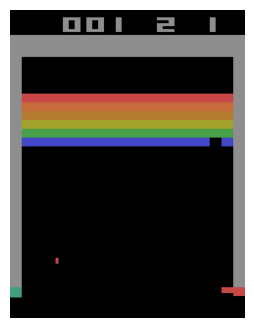

Round reward: -0.2 ep: 51
(210, 160, 3)


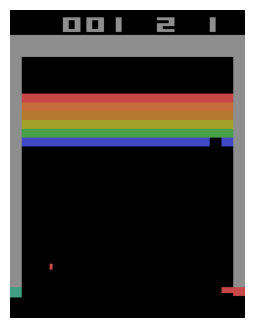

Round reward: -0.2 ep: 51
(210, 160, 3)


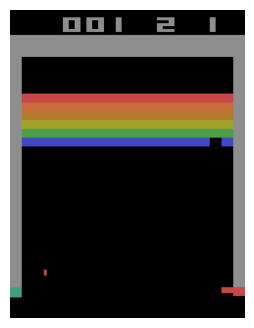

Round reward: -0.2 ep: 51
(210, 160, 3)


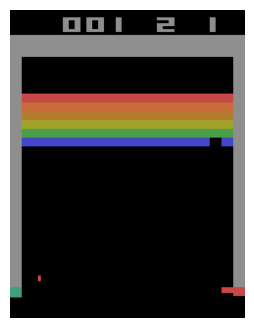

Round reward: -0.2 ep: 51
(210, 160, 3)


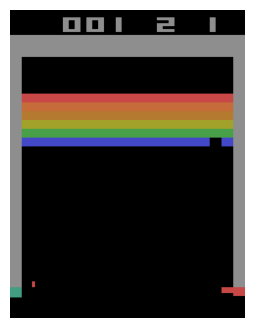

Round reward: -0.2 ep: 51
(210, 160, 3)


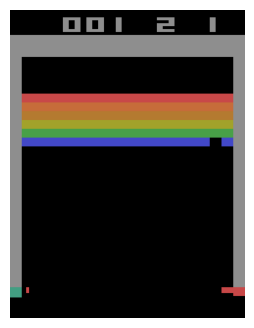

Round reward: -0.2 ep: 51
(210, 160, 3)


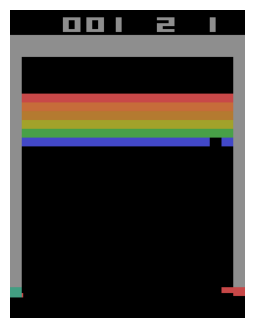

Round reward: -0.2 ep: 51
(210, 160, 3)


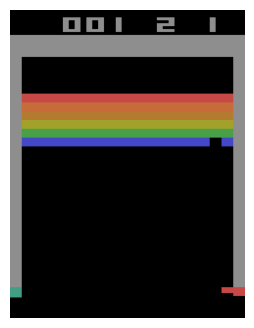

Round reward: -0.2 ep: 51
(210, 160, 3)


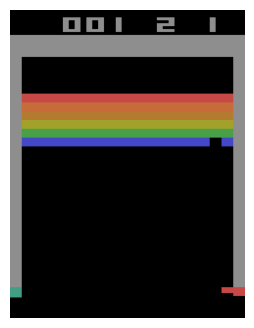

Round reward: -0.2 ep: 51
(210, 160, 3)


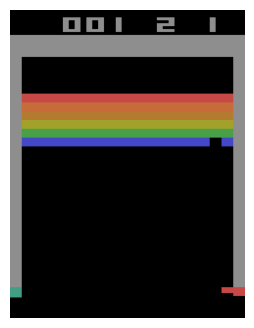

Round reward: -0.2 ep: 51
(210, 160, 3)


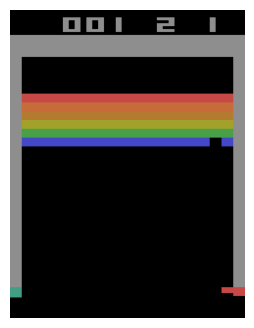

Round reward: -0.2 ep: 51
(210, 160, 3)


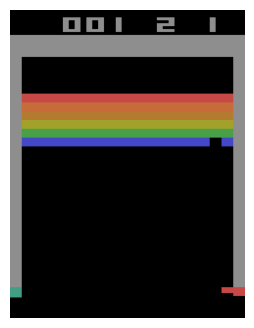

Round reward: -0.2 ep: 51
(210, 160, 3)


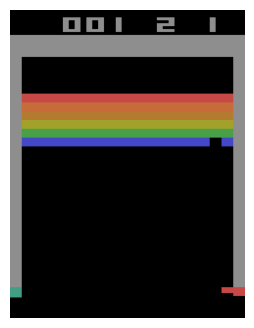

Round reward: -0.2 ep: 51
(210, 160, 3)


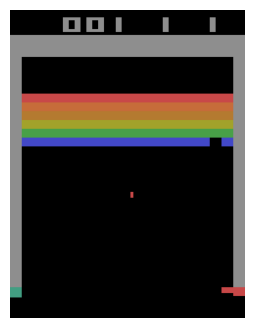

Round reward: -0.6 ep: 51
(210, 160, 3)


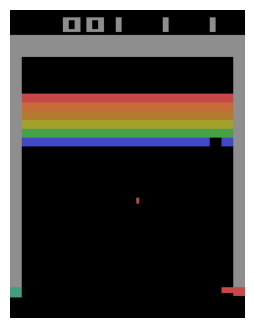

Round reward: -0.6 ep: 51
(210, 160, 3)


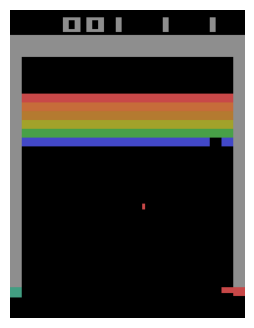

Round reward: -0.6 ep: 51
(210, 160, 3)


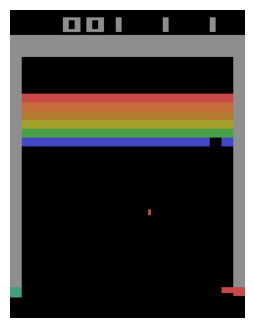

Round reward: -0.6 ep: 51
(210, 160, 3)


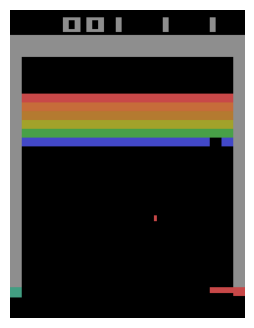

Round reward: -0.6 ep: 51
(210, 160, 3)


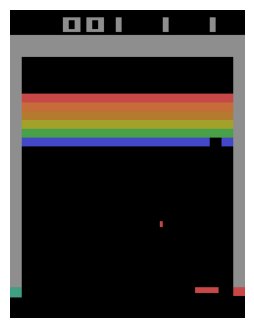

Round reward: -0.6 ep: 51
(210, 160, 3)


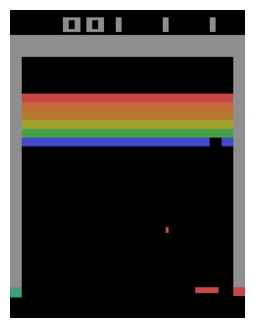

Round reward: -0.6 ep: 51
(210, 160, 3)


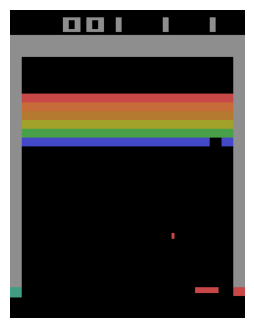

Round reward: -0.6 ep: 51
(210, 160, 3)


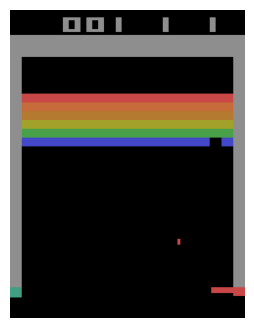

Round reward: -0.6 ep: 51
(210, 160, 3)


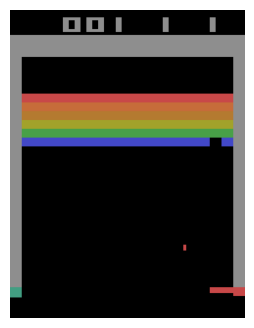

Round reward: -0.6 ep: 51
(210, 160, 3)


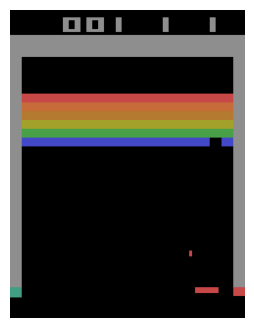

Round reward: -0.6 ep: 51
(210, 160, 3)


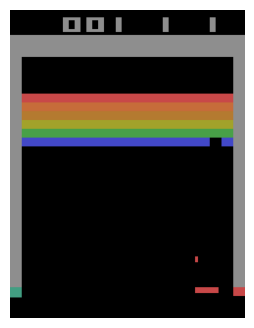

Round reward: -0.6 ep: 51
(210, 160, 3)


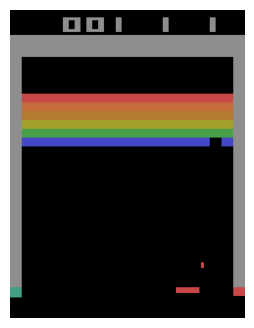

Round reward: -0.6 ep: 51
(210, 160, 3)


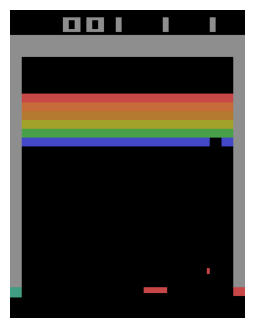

Round reward: -0.6 ep: 51
(210, 160, 3)


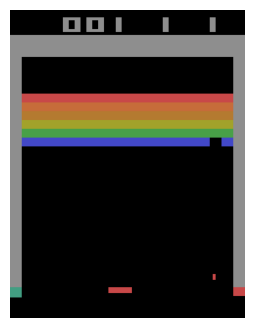

Round reward: -0.6 ep: 51
(210, 160, 3)


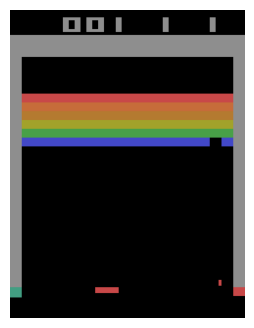

Round reward: -0.6 ep: 51
(210, 160, 3)


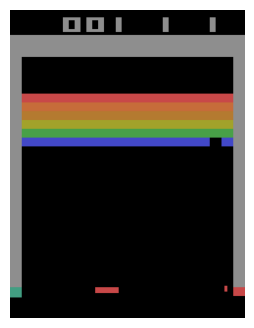

Round reward: -0.6 ep: 51
(210, 160, 3)


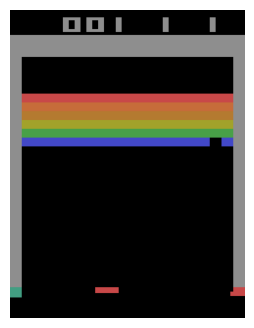

Round reward: -0.6 ep: 51
(210, 160, 3)


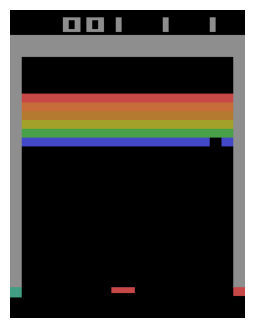

Round reward: -0.6 ep: 51
(210, 160, 3)


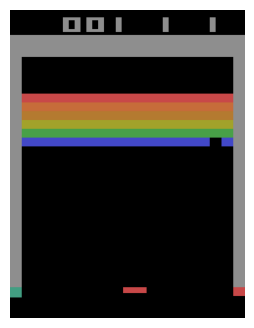

Round reward: -0.6 ep: 51
(210, 160, 3)


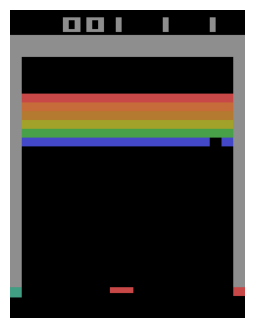

Round reward: -0.6 ep: 51
(210, 160, 3)


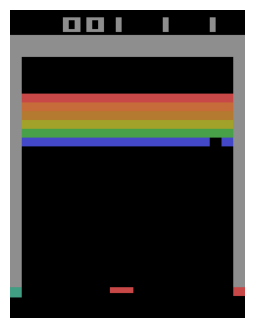

Round reward: -0.6 ep: 51
(210, 160, 3)


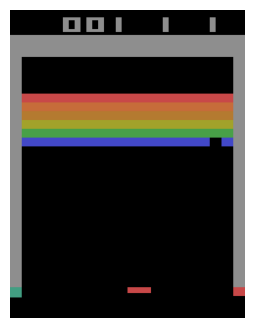

Round reward: -0.6 ep: 51
(210, 160, 3)


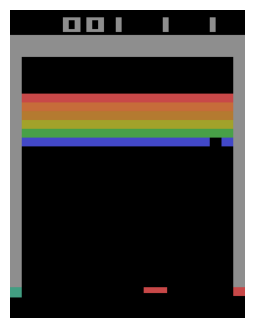

Round reward: -0.6 ep: 51
(210, 160, 3)


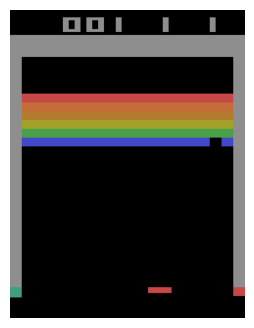

Round reward: -1.0 ep: 51
Episode: 52, Steps: 195 Reward:-1.0 Epsilon: 0.9

loss: 0.02301875129342079
Episode: 53, Steps: 192 Reward:0.0 Epsilon: 0.9

loss: 0.02301875129342079
Episode: 54, Steps: 239 Reward:1.0 Epsilon: 0.9

loss: 0.01551796868443489
Episode: 55, Steps: 176 Reward:-1.0 Epsilon: 0.9

loss: 0.04598750174045563
Episode: 56, Steps: 164 Reward:-1.0 Epsilon: 0.9

loss: 0.04645390808582306
Episode: 57, Steps: 140 Reward:-2.0 Epsilon: 0.9

loss: 0.030675001442432404
Episode: 58, Steps: 154 Reward:-2.0 Epsilon: 0.9

loss: 0.007706250064074993
Episode: 59, Steps: 173 Reward:-1.0 Epsilon: 0.9

loss: 0.02301875129342079
Episode: 60, Steps: 162 Reward:-1.0 Epsilon: 0.9

loss: 0.038331251591444016
Episode: 61, Steps: 217 Reward:0.0 Epsilon: 0.9

loss: 0.030675001442432404
Episode: 62, Steps: 222 Reward:0.0 Epsilon: 0.9

loss: 0.030675001442432404

Update targets

Episode: 63, Steps: 193 Reward:0.0 Epsilon: 0.9

loss: 0.02301875129342079
Episode: 64, Steps: 224 Reward:0.0 Epsilon: 0

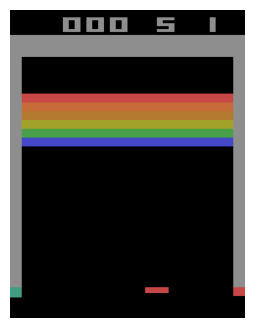

Round reward: 0.0 ep: 102
(210, 160, 3)


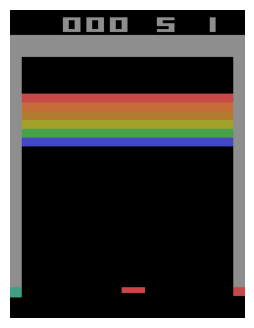

Round reward: 0.0 ep: 102
(210, 160, 3)


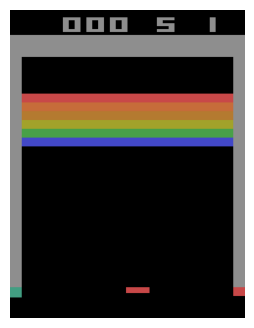

Round reward: 0.0 ep: 102
(210, 160, 3)


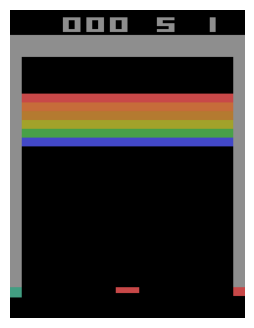

Round reward: 0.0 ep: 102
(210, 160, 3)


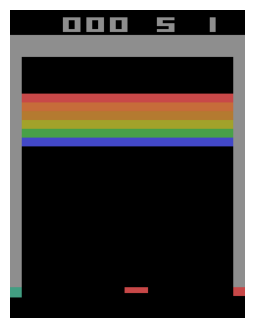

Round reward: 0.0 ep: 102
(210, 160, 3)


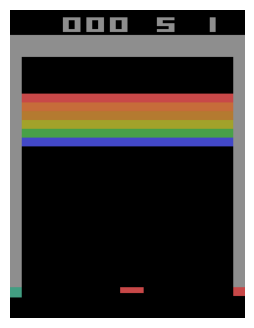

Round reward: 0.0 ep: 102
(210, 160, 3)


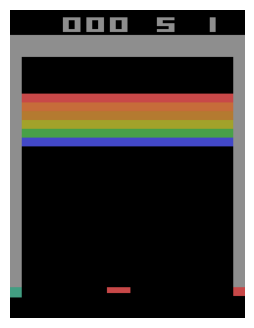

Round reward: 0.0 ep: 102
(210, 160, 3)


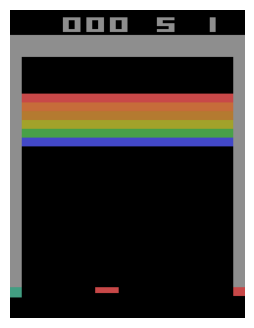

Round reward: 0.0 ep: 102
(210, 160, 3)


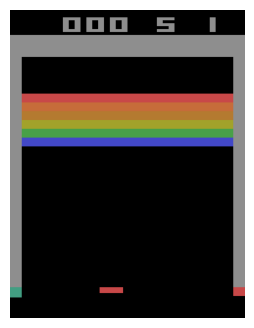

Round reward: 0.0 ep: 102
(210, 160, 3)


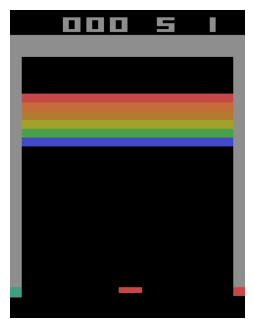

Round reward: 0.0 ep: 102
(210, 160, 3)


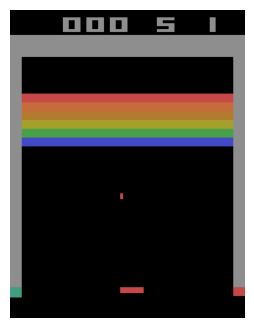

Round reward: 0.0 ep: 102
(210, 160, 3)


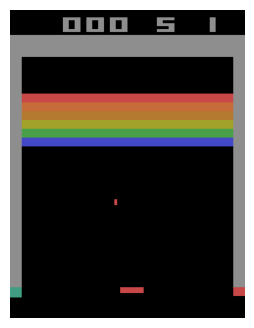

Round reward: 0.0 ep: 102
(210, 160, 3)


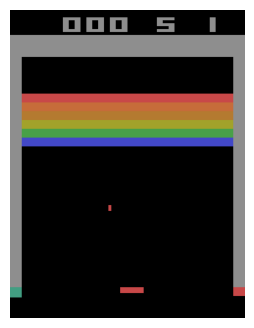

Round reward: 0.0 ep: 102
(210, 160, 3)


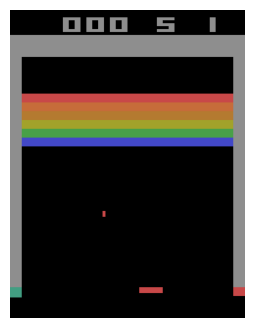

Round reward: 0.0 ep: 102
(210, 160, 3)


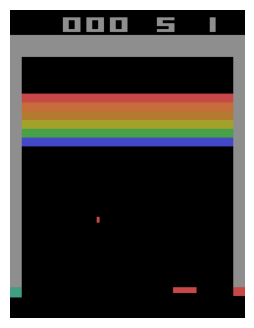

Round reward: 0.0 ep: 102
(210, 160, 3)


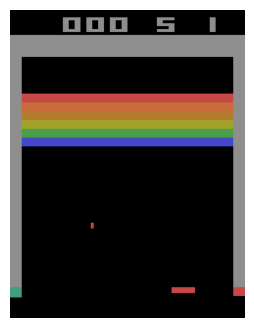

Round reward: 0.0 ep: 102
(210, 160, 3)


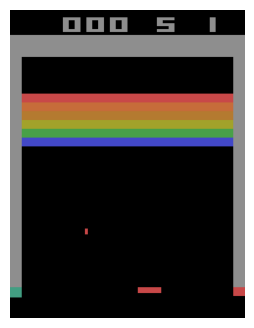

Round reward: 0.0 ep: 102
(210, 160, 3)


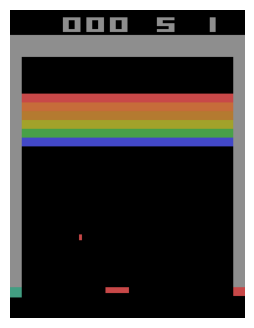

Round reward: 0.0 ep: 102
(210, 160, 3)


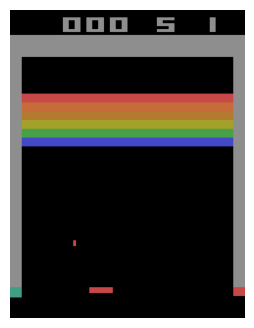

Round reward: 0.0 ep: 102
(210, 160, 3)


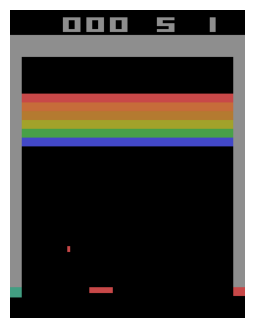

Round reward: 0.0 ep: 102
(210, 160, 3)


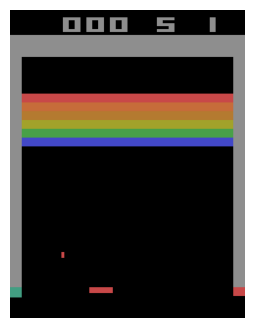

Round reward: 0.0 ep: 102
(210, 160, 3)


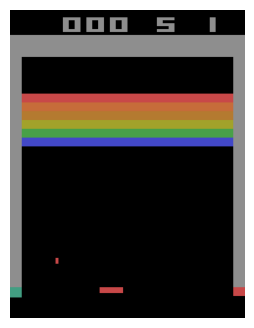

Round reward: 0.0 ep: 102
(210, 160, 3)


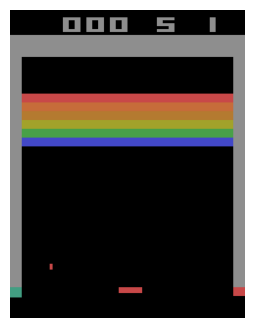

Round reward: 0.0 ep: 102
(210, 160, 3)


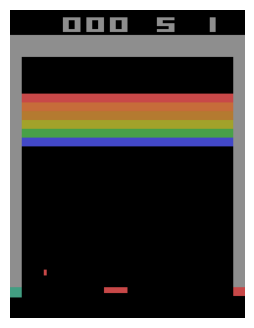

Round reward: 0.0 ep: 102
(210, 160, 3)


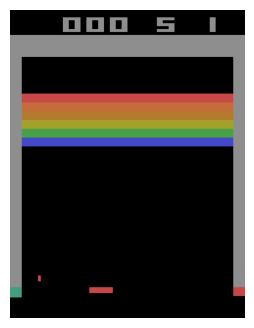

Round reward: 0.0 ep: 102
(210, 160, 3)


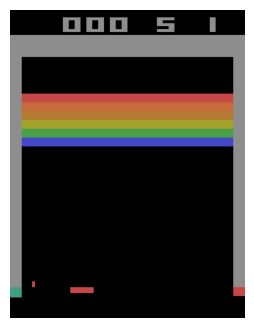

Round reward: 0.0 ep: 102
(210, 160, 3)


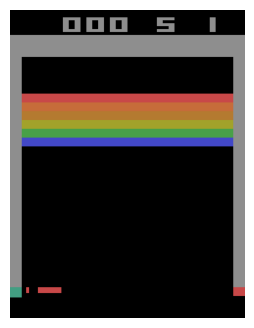

Round reward: 0.0 ep: 102
(210, 160, 3)


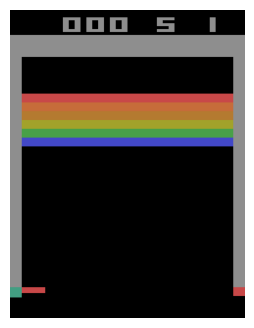

Round reward: 0.0 ep: 102
(210, 160, 3)


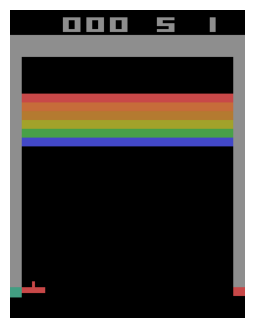

Round reward: 0.0 ep: 102
(210, 160, 3)


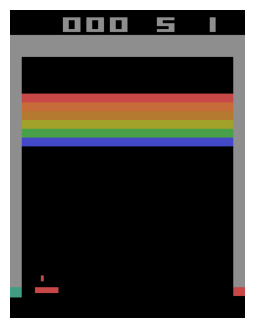

Round reward: 0.0 ep: 102
(210, 160, 3)


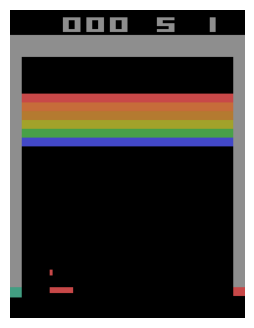

Round reward: 0.0 ep: 102
(210, 160, 3)


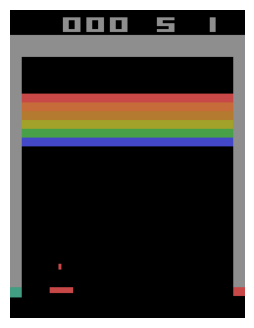

Round reward: 0.0 ep: 102
(210, 160, 3)


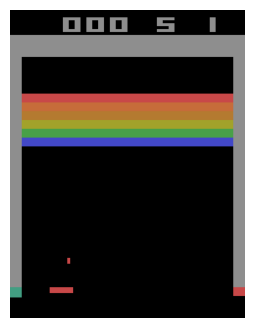

Round reward: 0.0 ep: 102
(210, 160, 3)


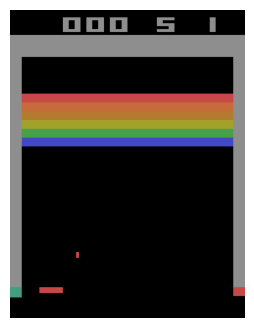

Round reward: 0.0 ep: 102
(210, 160, 3)


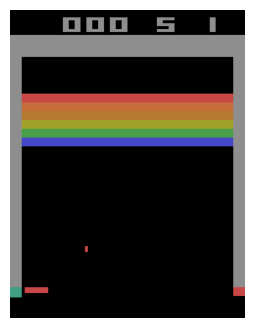

Round reward: 0.0 ep: 102
(210, 160, 3)


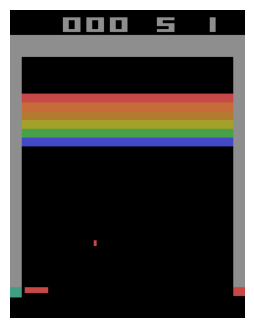

Round reward: 0.0 ep: 102
(210, 160, 3)


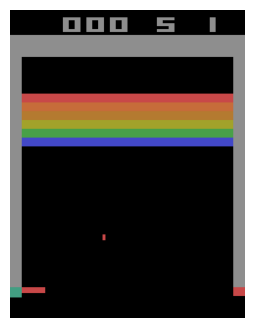

Round reward: 0.0 ep: 102
(210, 160, 3)


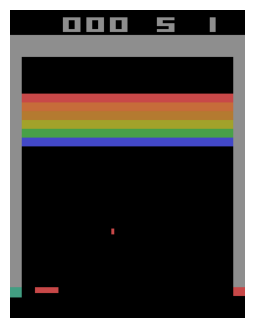

Round reward: 0.0 ep: 102
(210, 160, 3)


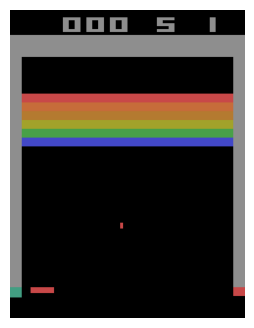

Round reward: 0.0 ep: 102
(210, 160, 3)


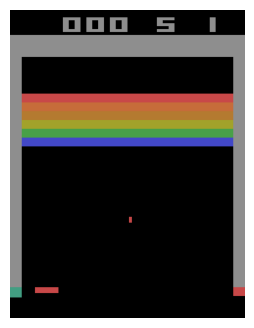

Round reward: 0.0 ep: 102
(210, 160, 3)


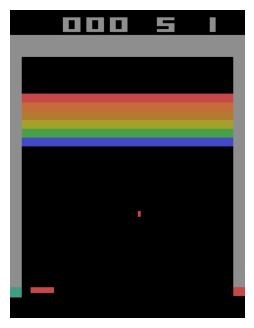

Round reward: 0.0 ep: 102
(210, 160, 3)


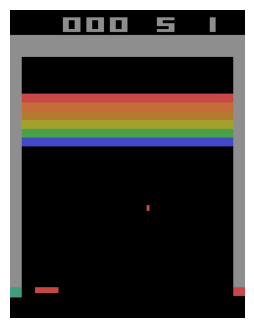

Round reward: 0.0 ep: 102
(210, 160, 3)


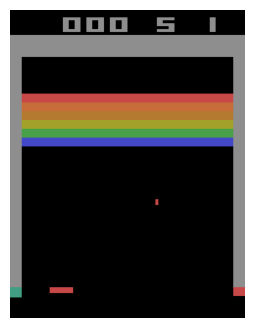

Round reward: 0.0 ep: 102
(210, 160, 3)


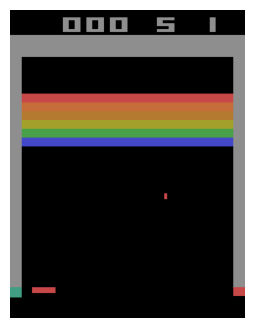

Round reward: 0.0 ep: 102
(210, 160, 3)


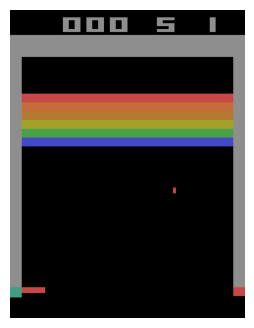

Round reward: 0.0 ep: 102
(210, 160, 3)


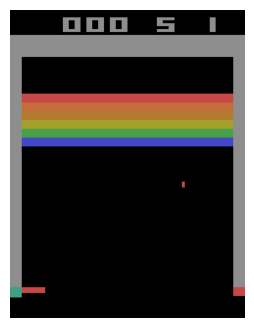

Round reward: 0.0 ep: 102
(210, 160, 3)


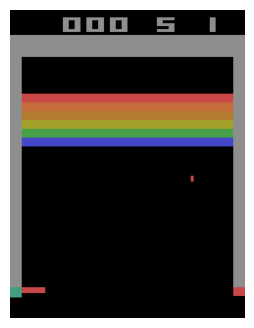

Round reward: 0.0 ep: 102
(210, 160, 3)


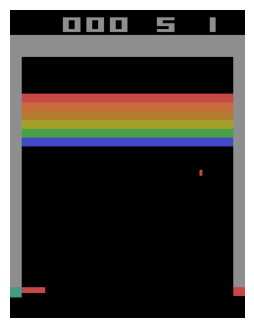

Round reward: 0.0 ep: 102
(210, 160, 3)


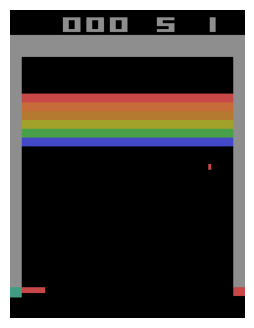

Round reward: 0.0 ep: 102
(210, 160, 3)


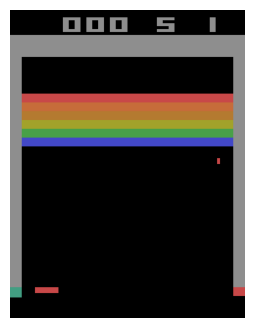

Round reward: 0.0 ep: 102
(210, 160, 3)


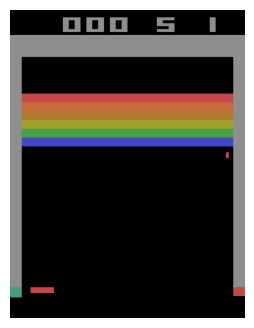

Round reward: 0.0 ep: 102
(210, 160, 3)


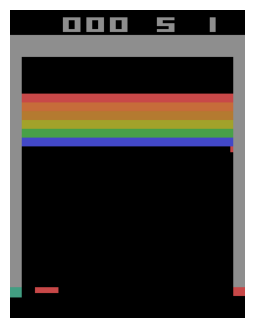

Round reward: 0.0 ep: 102
(210, 160, 3)


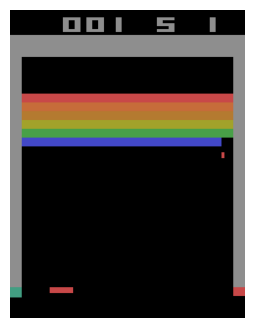

Round reward: 1.0 ep: 102
(210, 160, 3)


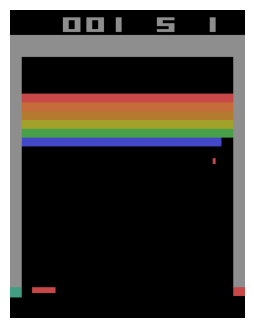

Round reward: 1.0 ep: 102
(210, 160, 3)


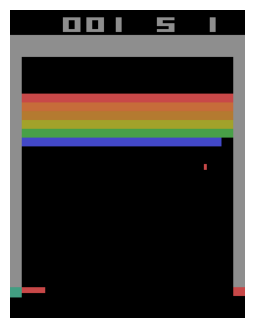

Round reward: 1.0 ep: 102
(210, 160, 3)


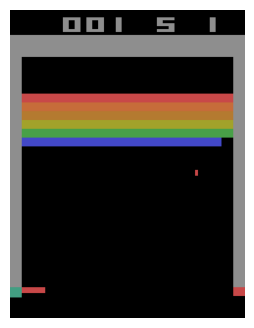

Round reward: 1.0 ep: 102
(210, 160, 3)


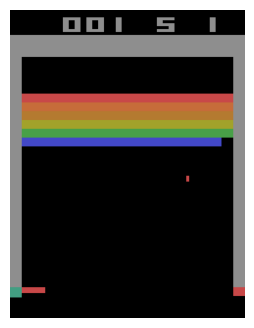

Round reward: 1.0 ep: 102
(210, 160, 3)


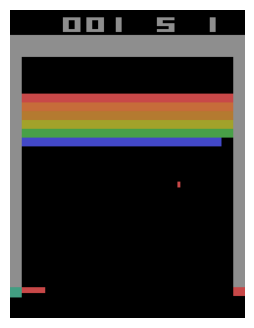

Round reward: 1.0 ep: 102
(210, 160, 3)


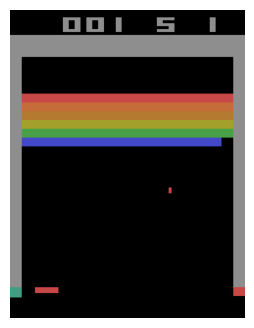

Round reward: 1.0 ep: 102
(210, 160, 3)


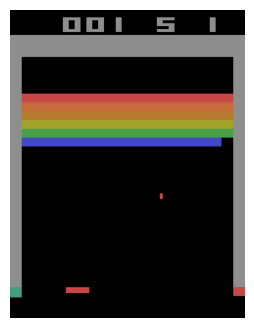

Round reward: 1.0 ep: 102
(210, 160, 3)


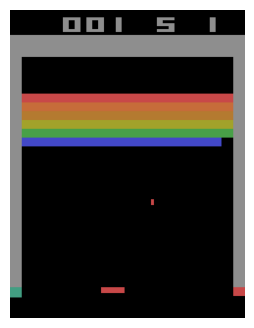

Round reward: 1.0 ep: 102
(210, 160, 3)


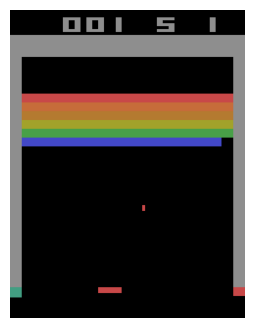

Round reward: 1.0 ep: 102
(210, 160, 3)


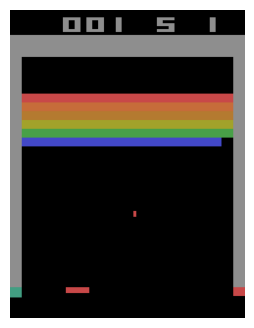

Round reward: 1.0 ep: 102
(210, 160, 3)


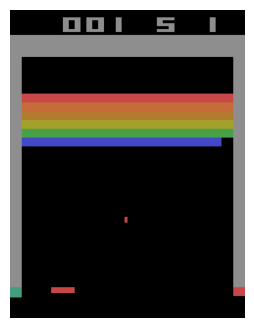

Round reward: 1.0 ep: 102
(210, 160, 3)


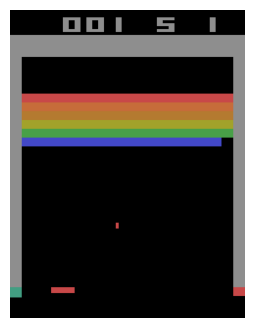

Round reward: 1.0 ep: 102
(210, 160, 3)


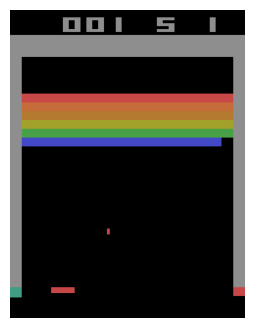

Round reward: 1.0 ep: 102
(210, 160, 3)


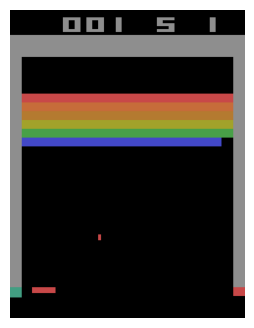

Round reward: 1.0 ep: 102
(210, 160, 3)


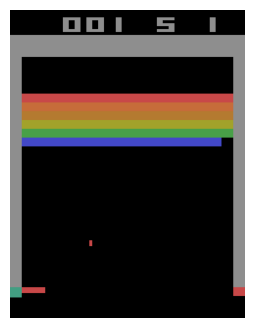

Round reward: 1.0 ep: 102
(210, 160, 3)


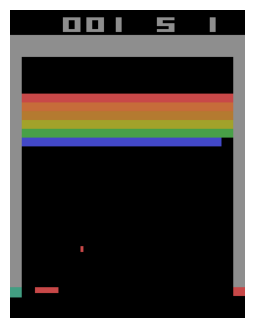

Round reward: 1.0 ep: 102
(210, 160, 3)


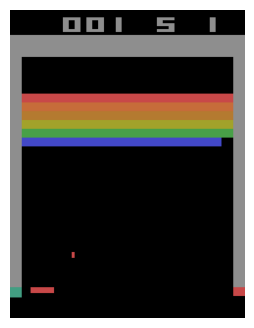

Round reward: 1.0 ep: 102
(210, 160, 3)


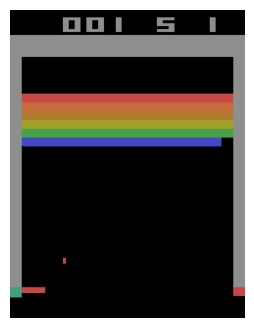

Round reward: 1.0 ep: 102
(210, 160, 3)


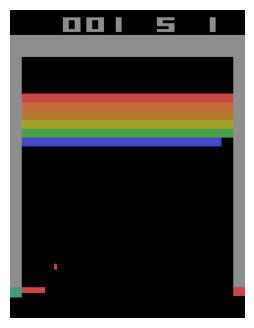

Round reward: 1.0 ep: 102
(210, 160, 3)


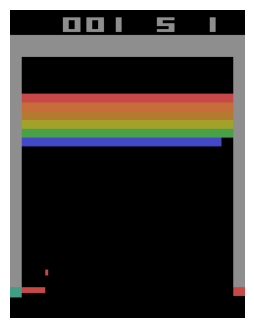

Round reward: 1.0 ep: 102
(210, 160, 3)


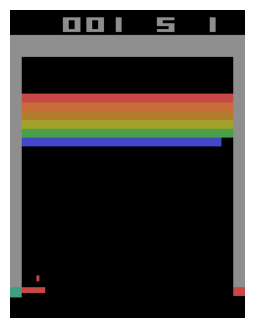

Round reward: 1.0 ep: 102
(210, 160, 3)


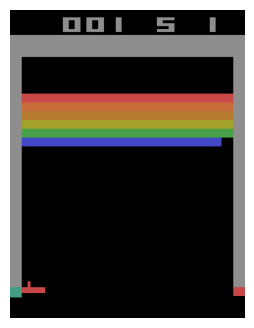

Round reward: 1.0 ep: 102
(210, 160, 3)


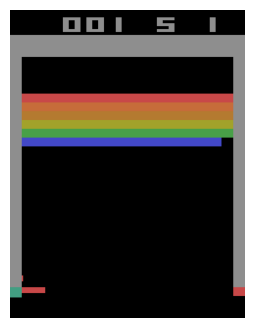

Round reward: 1.0 ep: 102
(210, 160, 3)


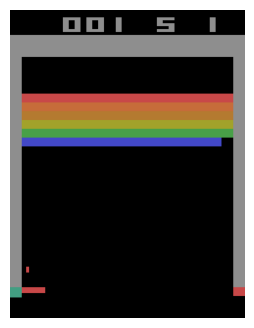

Round reward: 1.0 ep: 102
(210, 160, 3)


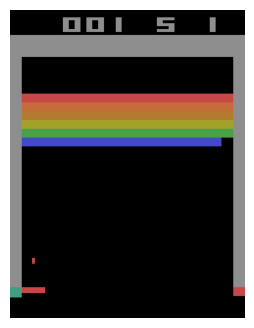

Round reward: 1.0 ep: 102
(210, 160, 3)


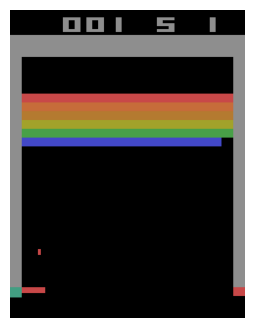

Round reward: 1.0 ep: 102
(210, 160, 3)


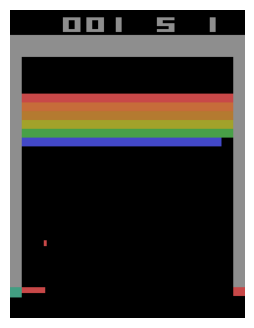

Round reward: 1.0 ep: 102
(210, 160, 3)


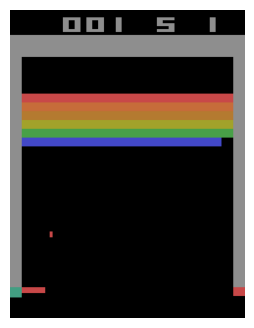

Round reward: 1.0 ep: 102
(210, 160, 3)


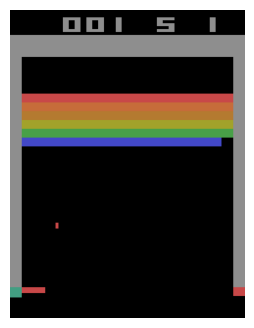

Round reward: 1.0 ep: 102
(210, 160, 3)


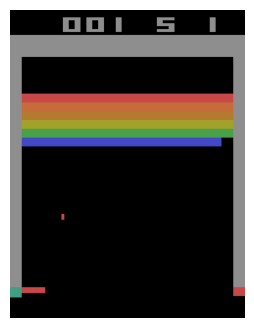

Round reward: 1.0 ep: 102
(210, 160, 3)


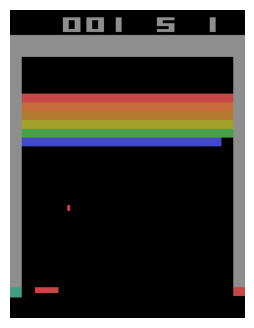

Round reward: 1.0 ep: 102
(210, 160, 3)


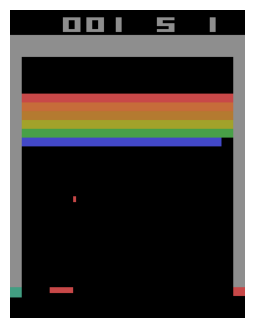

Round reward: 1.0 ep: 102
(210, 160, 3)


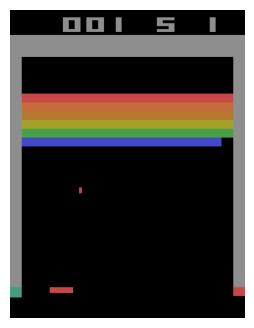

Round reward: 1.0 ep: 102
(210, 160, 3)


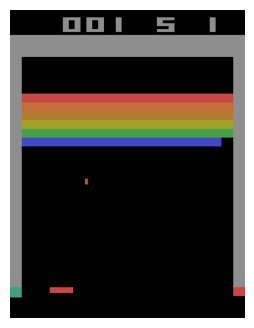

Round reward: 1.0 ep: 102
(210, 160, 3)


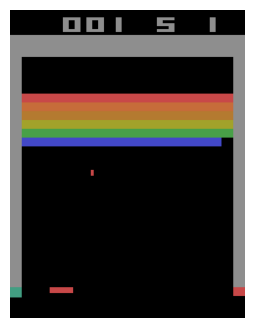

Round reward: 1.0 ep: 102
(210, 160, 3)


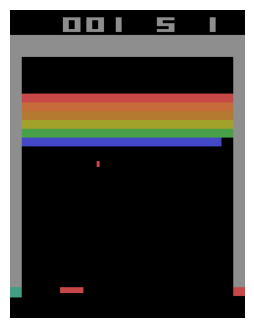

Round reward: 1.0 ep: 102
(210, 160, 3)


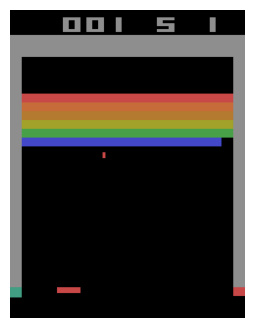

Round reward: 1.0 ep: 102
(210, 160, 3)


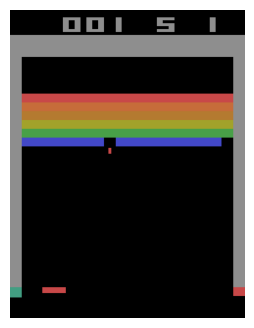

Round reward: 2.0 ep: 102
(210, 160, 3)


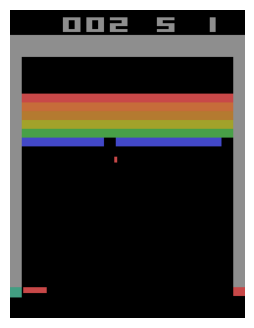

Round reward: 2.0 ep: 102
(210, 160, 3)


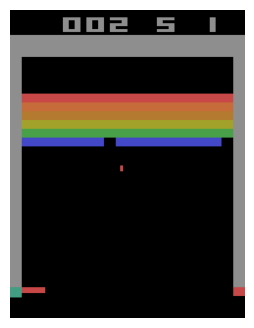

Round reward: 2.0 ep: 102
(210, 160, 3)


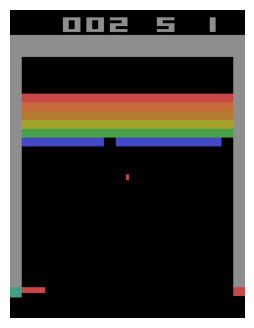

Round reward: 2.0 ep: 102
(210, 160, 3)


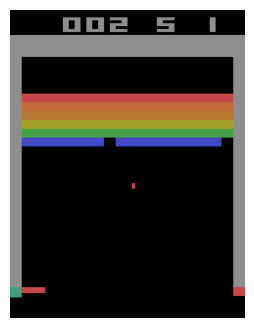

Round reward: 2.0 ep: 102
(210, 160, 3)


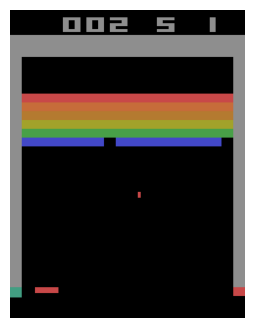

Round reward: 2.0 ep: 102
(210, 160, 3)


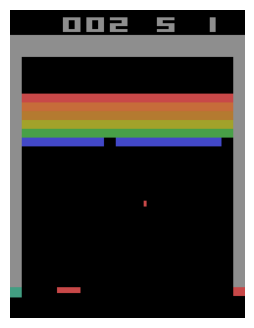

Round reward: 2.0 ep: 102
(210, 160, 3)


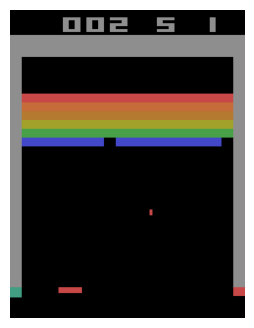

Round reward: 2.0 ep: 102
(210, 160, 3)


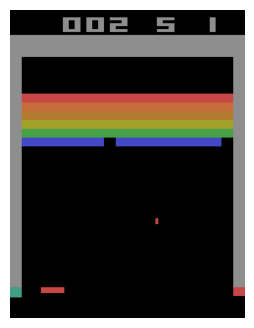

Round reward: 2.0 ep: 102
(210, 160, 3)


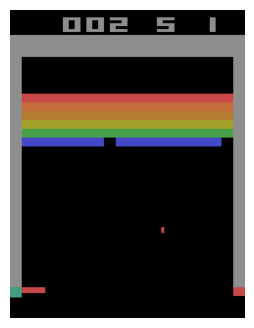

Round reward: 2.0 ep: 102
(210, 160, 3)


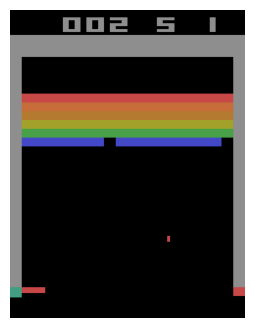

Round reward: 2.0 ep: 102
(210, 160, 3)


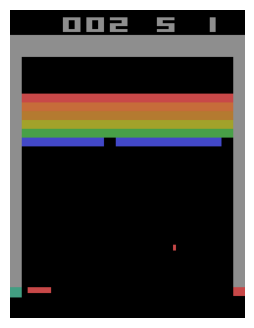

Round reward: 2.0 ep: 102
(210, 160, 3)


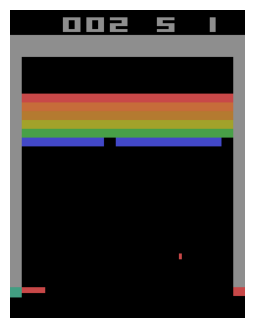

Round reward: 2.0 ep: 102
(210, 160, 3)


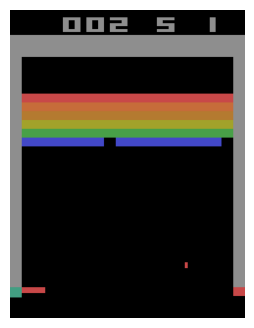

Round reward: 2.0 ep: 102
(210, 160, 3)


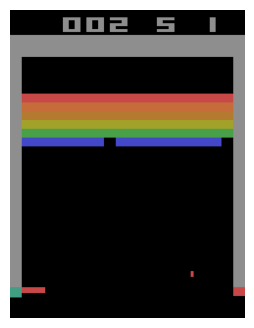

Round reward: 2.0 ep: 102
(210, 160, 3)


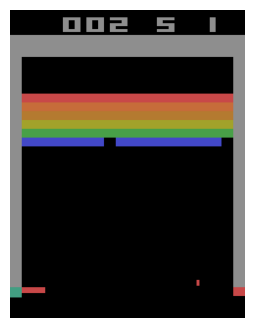

Round reward: 2.0 ep: 102
(210, 160, 3)


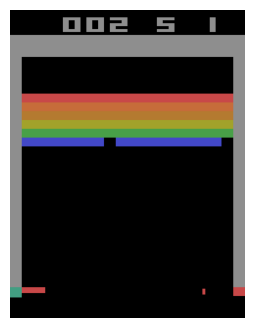

Round reward: 2.0 ep: 102
(210, 160, 3)


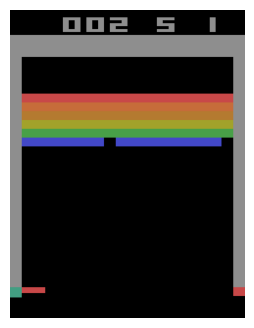

Round reward: 2.0 ep: 102
(210, 160, 3)


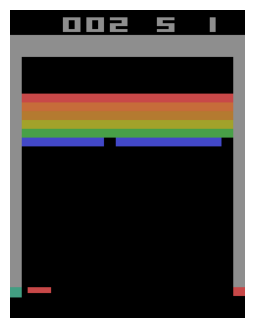

Round reward: 2.0 ep: 102
(210, 160, 3)


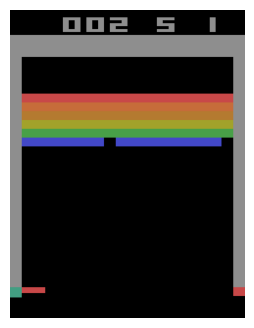

Round reward: 2.0 ep: 102
(210, 160, 3)


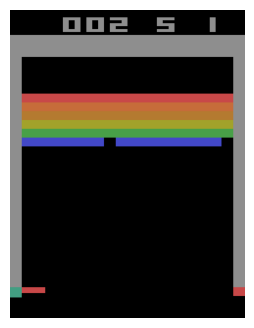

Round reward: 2.0 ep: 102
(210, 160, 3)


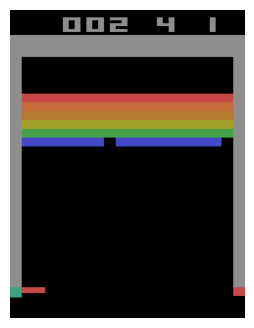

Round reward: 1.6 ep: 102
(210, 160, 3)


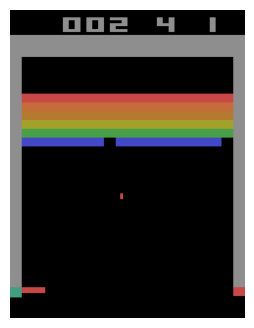

Round reward: 1.6 ep: 102
(210, 160, 3)


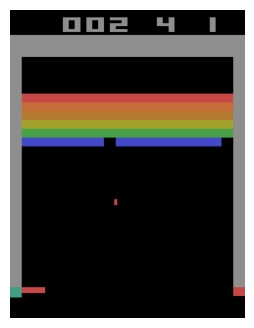

Round reward: 1.6 ep: 102
(210, 160, 3)


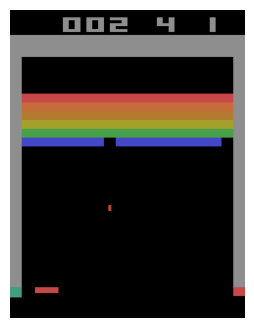

Round reward: 1.6 ep: 102
(210, 160, 3)


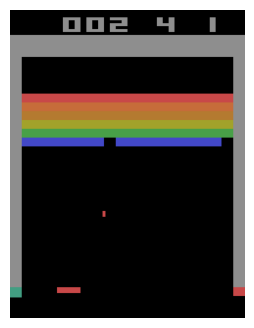

Round reward: 1.6 ep: 102
(210, 160, 3)


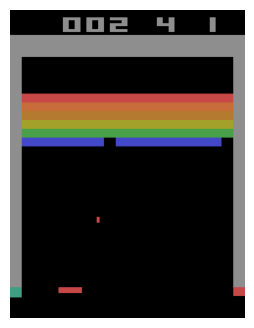

Round reward: 1.6 ep: 102
(210, 160, 3)


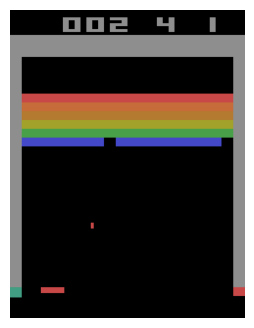

Round reward: 1.6 ep: 102
(210, 160, 3)


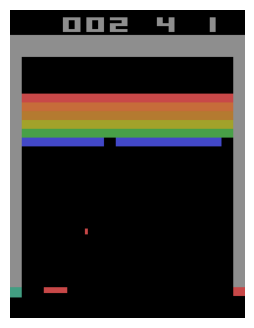

Round reward: 1.6 ep: 102
(210, 160, 3)


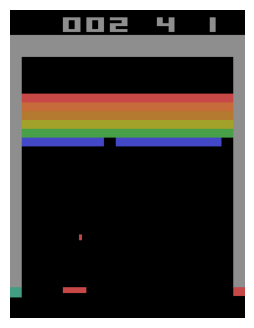

Round reward: 1.6 ep: 102
(210, 160, 3)


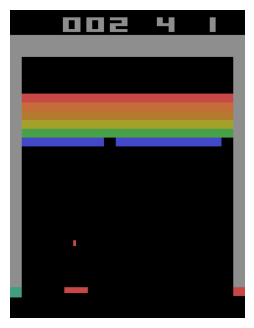

Round reward: 1.6 ep: 102
(210, 160, 3)


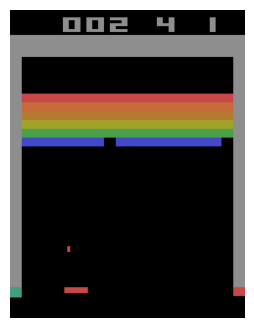

Round reward: 1.6 ep: 102
(210, 160, 3)


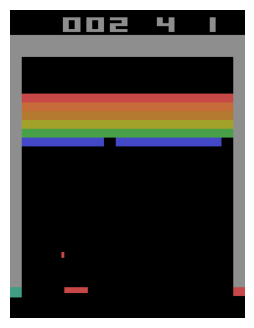

Round reward: 1.6 ep: 102
(210, 160, 3)


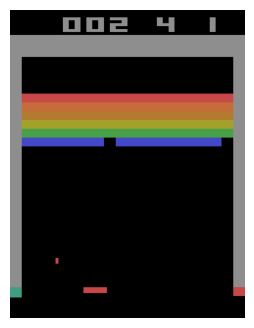

Round reward: 1.6 ep: 102
(210, 160, 3)


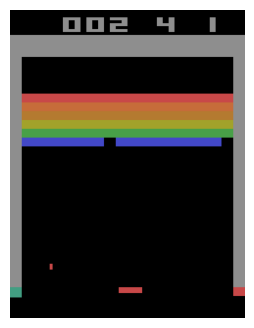

Round reward: 1.6 ep: 102
(210, 160, 3)


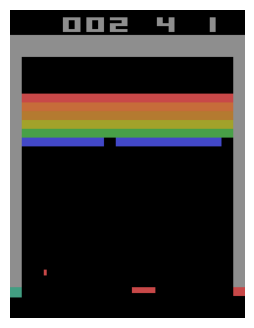

Round reward: 1.6 ep: 102
(210, 160, 3)


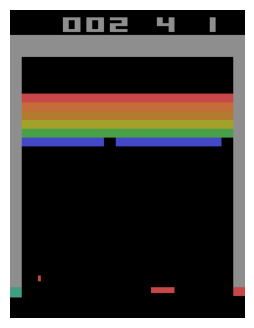

Round reward: 1.6 ep: 102
(210, 160, 3)


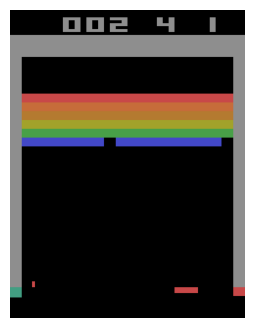

Round reward: 1.6 ep: 102
(210, 160, 3)


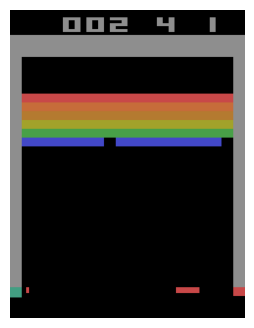

Round reward: 1.6 ep: 102
(210, 160, 3)


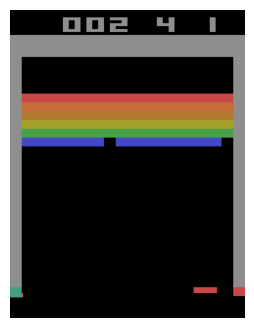

Round reward: 1.6 ep: 102
(210, 160, 3)


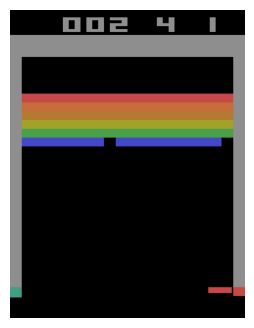

Round reward: 1.6 ep: 102
(210, 160, 3)


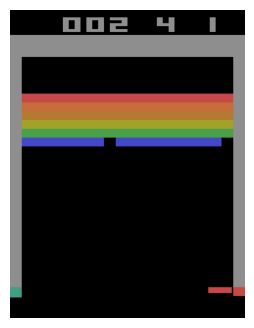

Round reward: 1.6 ep: 102
(210, 160, 3)


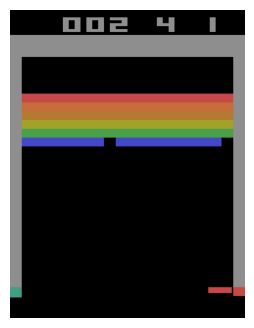

Round reward: 1.6 ep: 102
(210, 160, 3)


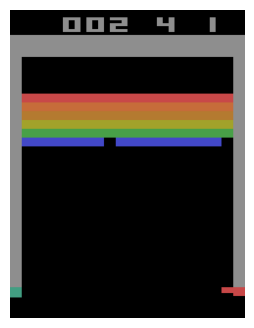

Round reward: 1.6 ep: 102
(210, 160, 3)


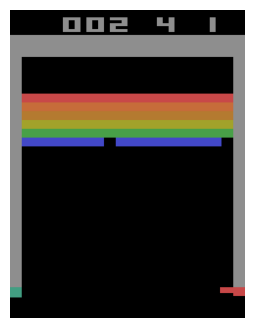

Round reward: 1.6 ep: 102
(210, 160, 3)


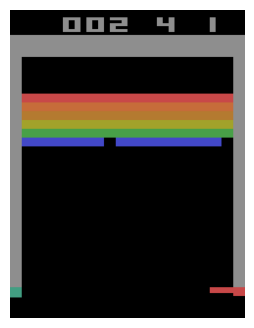

Round reward: 1.6 ep: 102
(210, 160, 3)


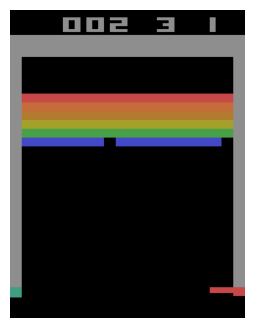

Round reward: 1.2 ep: 102
(210, 160, 3)


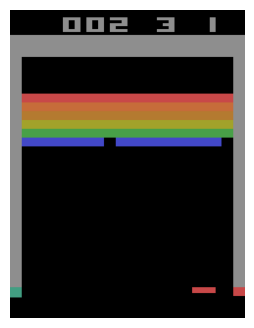

Round reward: 1.2 ep: 102
(210, 160, 3)


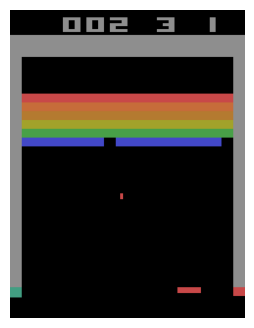

Round reward: 1.2 ep: 102
(210, 160, 3)


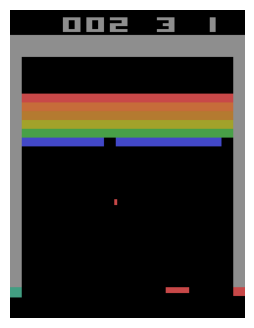

Round reward: 1.2 ep: 102
(210, 160, 3)


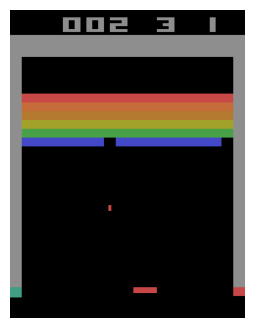

Round reward: 1.2 ep: 102
(210, 160, 3)


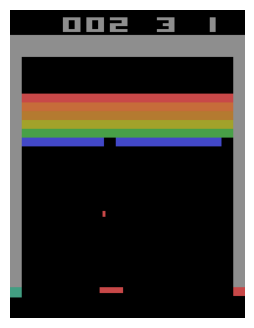

Round reward: 1.2 ep: 102
(210, 160, 3)


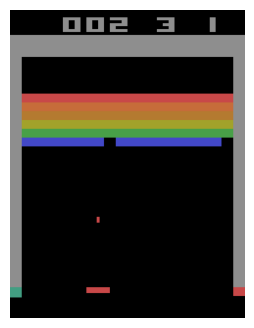

Round reward: 1.2 ep: 102
(210, 160, 3)


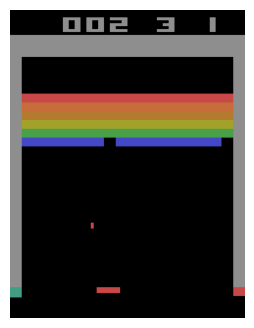

Round reward: 1.2 ep: 102
(210, 160, 3)


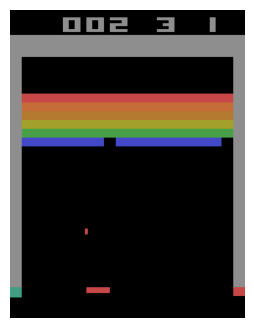

Round reward: 1.2 ep: 102
(210, 160, 3)


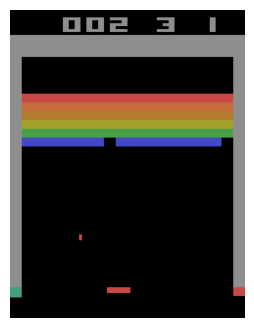

Round reward: 1.2 ep: 102
(210, 160, 3)


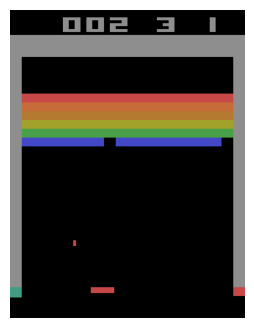

Round reward: 1.2 ep: 102
(210, 160, 3)


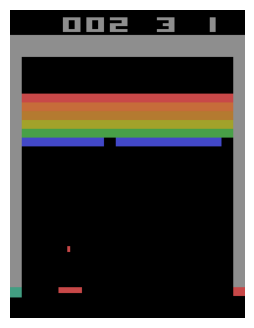

Round reward: 1.2 ep: 102
(210, 160, 3)


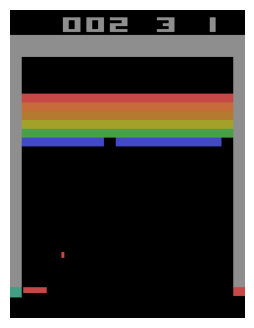

Round reward: 1.2 ep: 102
(210, 160, 3)


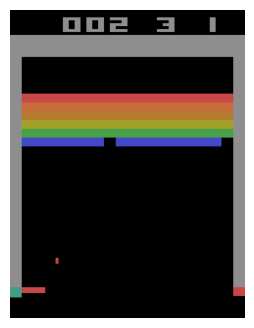

Round reward: 1.2 ep: 102
(210, 160, 3)


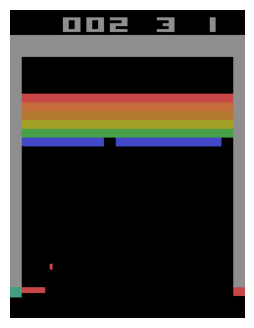

Round reward: 1.2 ep: 102
(210, 160, 3)


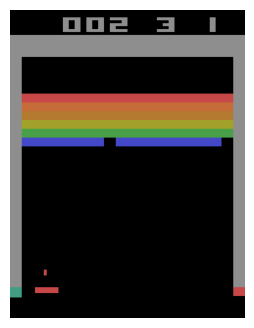

Round reward: 1.2 ep: 102
(210, 160, 3)


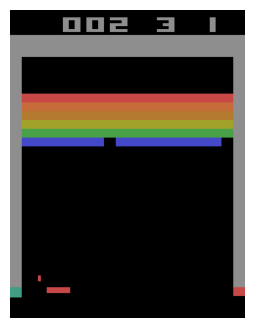

Round reward: 1.2 ep: 102
(210, 160, 3)


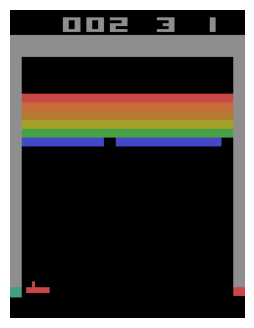

Round reward: 1.2 ep: 102
(210, 160, 3)


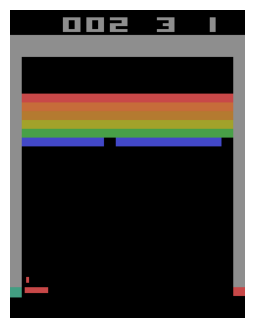

Round reward: 1.2 ep: 102
(210, 160, 3)


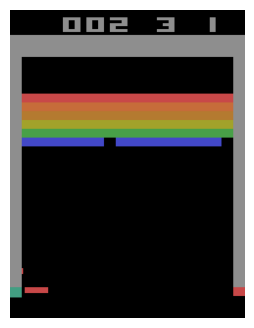

Round reward: 1.2 ep: 102
(210, 160, 3)


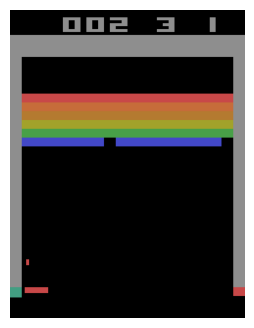

Round reward: 1.2 ep: 102
(210, 160, 3)


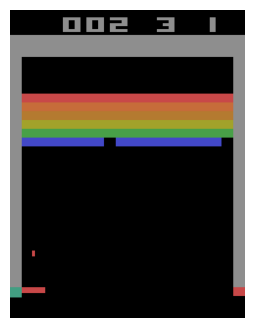

Round reward: 1.2 ep: 102
(210, 160, 3)


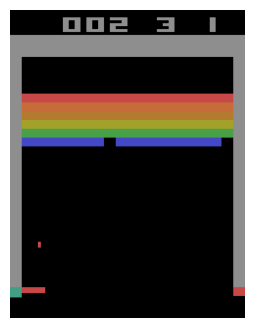

Round reward: 1.2 ep: 102
(210, 160, 3)


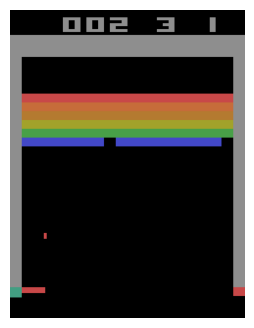

Round reward: 1.2 ep: 102
(210, 160, 3)


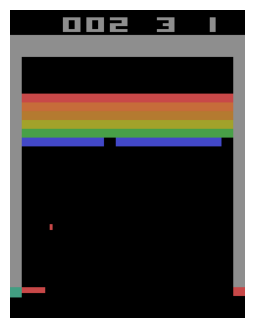

Round reward: 1.2 ep: 102
(210, 160, 3)


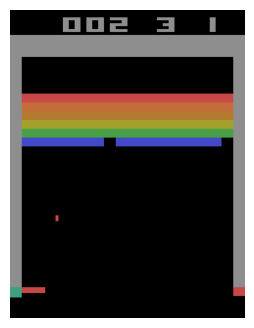

Round reward: 1.2 ep: 102
(210, 160, 3)


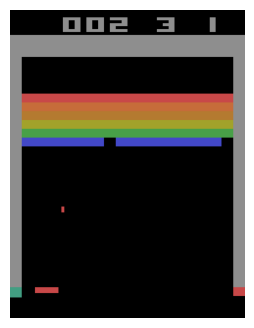

Round reward: 1.2 ep: 102
(210, 160, 3)


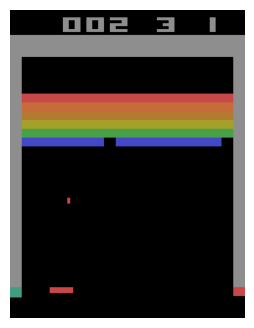

Round reward: 1.2 ep: 102
(210, 160, 3)


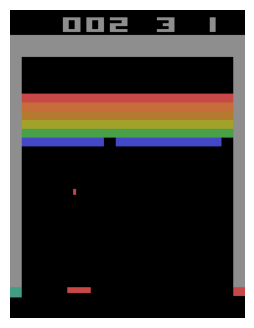

Round reward: 1.2 ep: 102
(210, 160, 3)


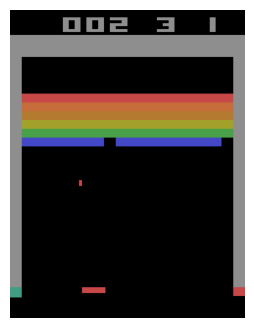

Round reward: 1.2 ep: 102
(210, 160, 3)


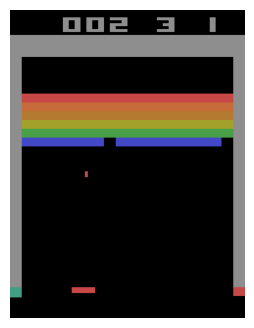

Round reward: 1.2 ep: 102
(210, 160, 3)


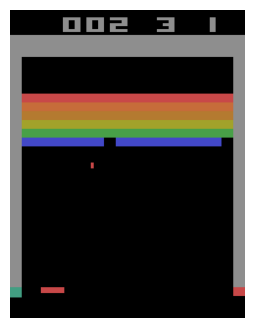

Round reward: 1.2 ep: 102
(210, 160, 3)


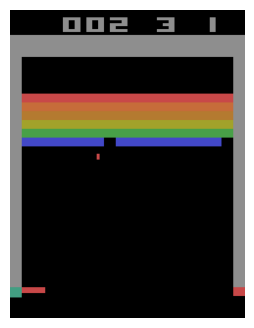

Round reward: 1.2 ep: 102
(210, 160, 3)


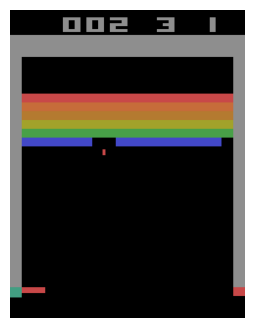

Round reward: 2.2 ep: 102
(210, 160, 3)


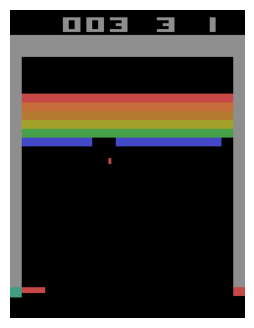

Round reward: 2.2 ep: 102
(210, 160, 3)


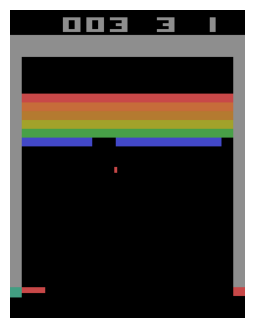

Round reward: 2.2 ep: 102
(210, 160, 3)


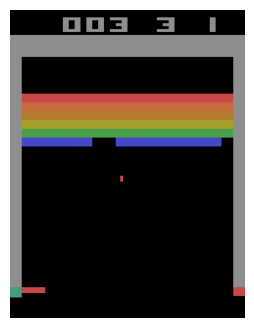

Round reward: 2.2 ep: 102
(210, 160, 3)


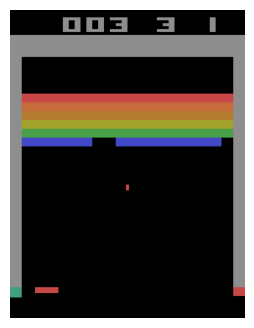

Round reward: 2.2 ep: 102
(210, 160, 3)


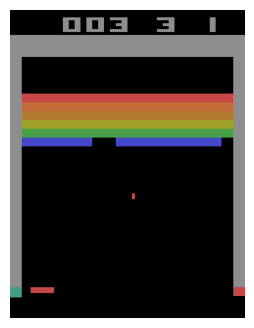

Round reward: 2.2 ep: 102
(210, 160, 3)


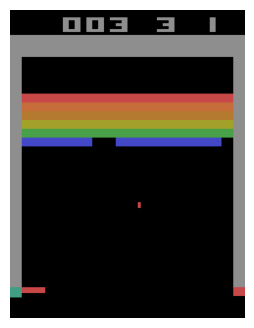

Round reward: 2.2 ep: 102
(210, 160, 3)


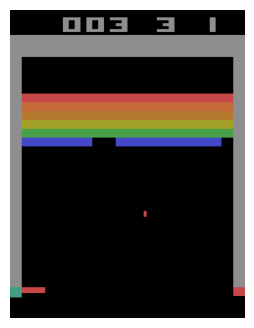

Round reward: 2.2 ep: 102
(210, 160, 3)


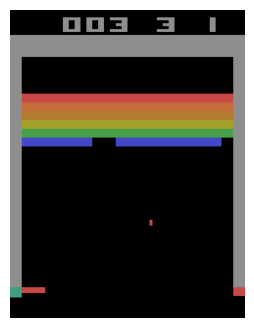

Round reward: 2.2 ep: 102
(210, 160, 3)


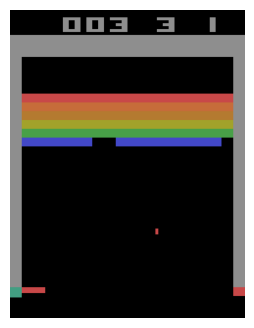

Round reward: 2.2 ep: 102
(210, 160, 3)


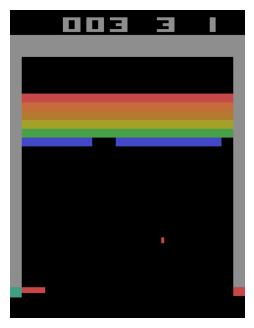

Round reward: 2.2 ep: 102
(210, 160, 3)


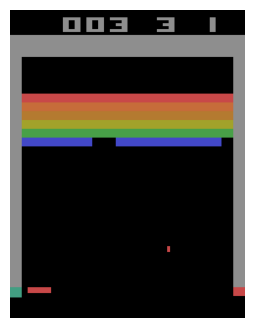

Round reward: 2.2 ep: 102
(210, 160, 3)


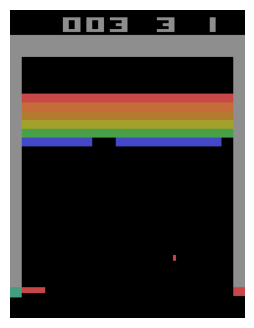

Round reward: 2.2 ep: 102
(210, 160, 3)


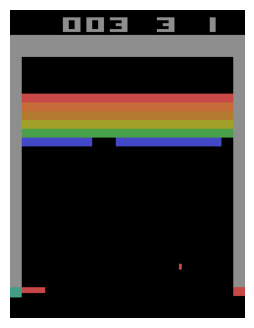

Round reward: 2.2 ep: 102
(210, 160, 3)


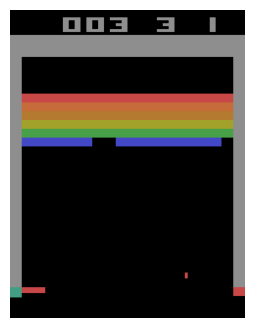

Round reward: 2.2 ep: 102
(210, 160, 3)


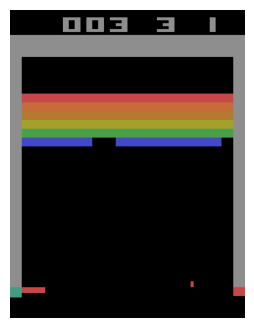

Round reward: 2.2 ep: 102
(210, 160, 3)


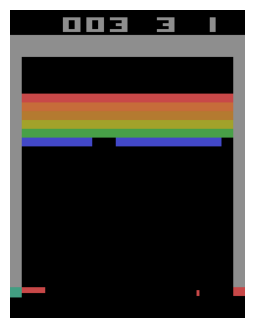

Round reward: 2.2 ep: 102
(210, 160, 3)


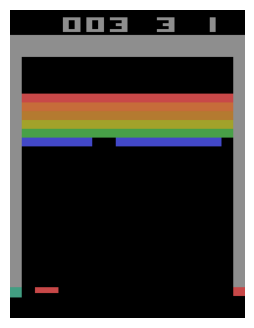

Round reward: 2.2 ep: 102
(210, 160, 3)


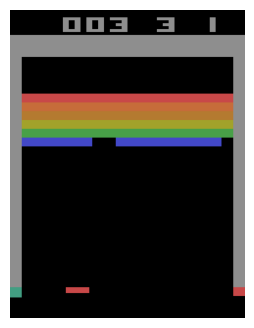

Round reward: 2.2 ep: 102
(210, 160, 3)


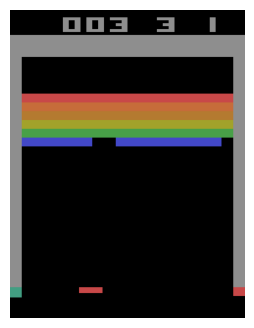

Round reward: 2.2 ep: 102
(210, 160, 3)


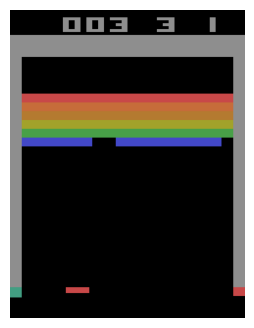

Round reward: 2.2 ep: 102
(210, 160, 3)


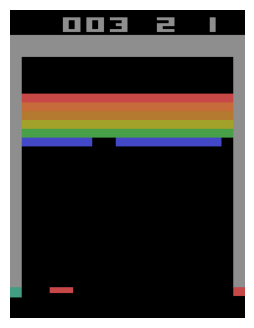

Round reward: 1.8 ep: 102
(210, 160, 3)


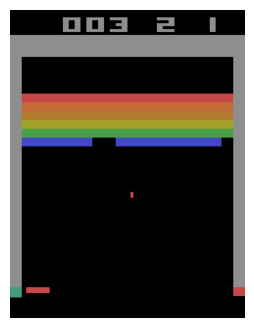

Round reward: 1.8 ep: 102
(210, 160, 3)


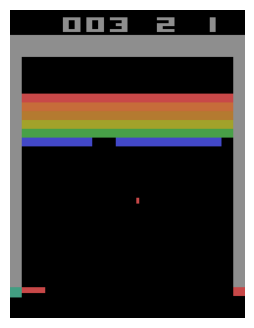

Round reward: 1.8 ep: 102
(210, 160, 3)


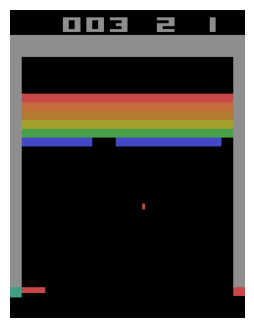

Round reward: 1.8 ep: 102
(210, 160, 3)


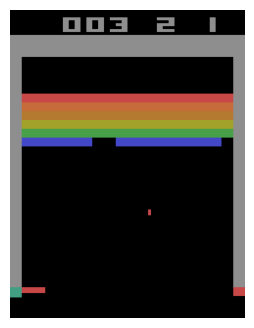

Round reward: 1.8 ep: 102
(210, 160, 3)


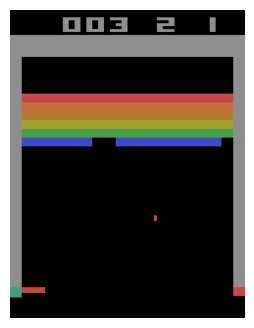

Round reward: 1.8 ep: 102
(210, 160, 3)


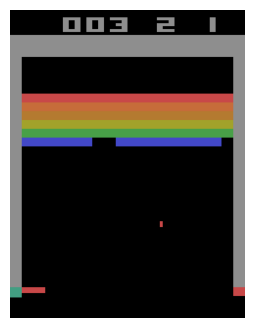

Round reward: 1.8 ep: 102
(210, 160, 3)


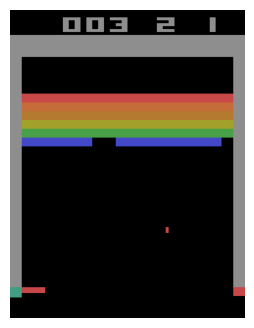

Round reward: 1.8 ep: 102
(210, 160, 3)


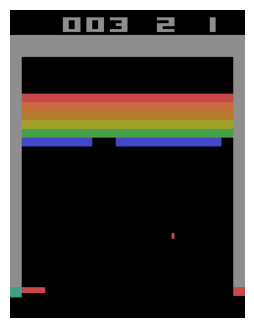

Round reward: 1.8 ep: 102
(210, 160, 3)


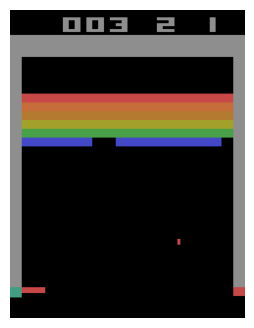

Round reward: 1.8 ep: 102
(210, 160, 3)


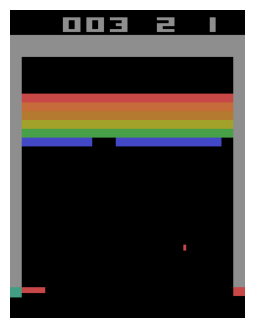

Round reward: 1.8 ep: 102
(210, 160, 3)


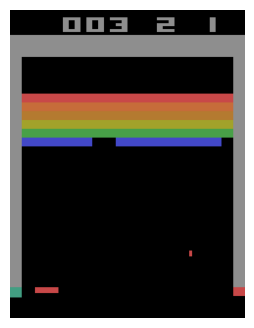

Round reward: 1.8 ep: 102
(210, 160, 3)


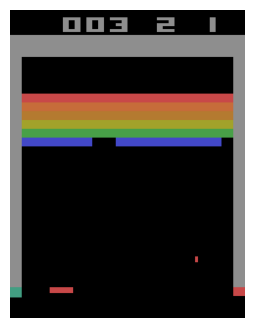

Round reward: 1.8 ep: 102
(210, 160, 3)


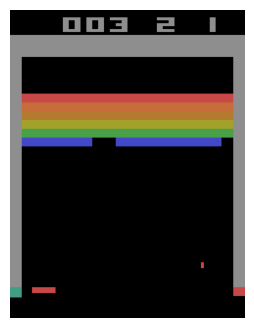

Round reward: 1.8 ep: 102
(210, 160, 3)


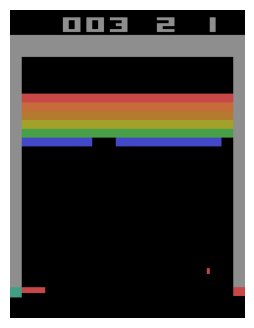

Round reward: 1.8 ep: 102
(210, 160, 3)


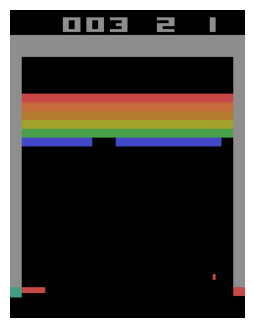

Round reward: 1.8 ep: 102
(210, 160, 3)


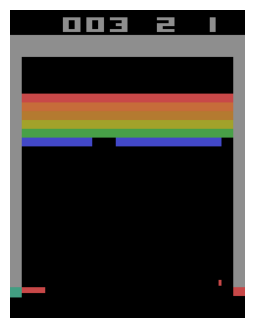

Round reward: 1.8 ep: 102
(210, 160, 3)


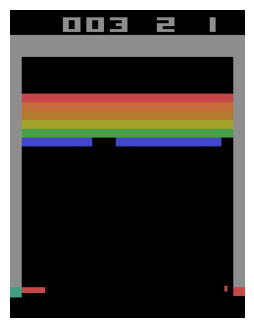

Round reward: 1.8 ep: 102
(210, 160, 3)


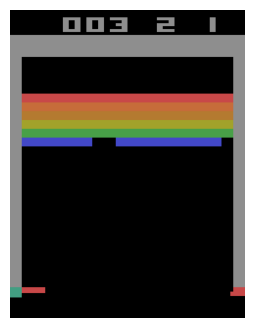

Round reward: 1.8 ep: 102
(210, 160, 3)


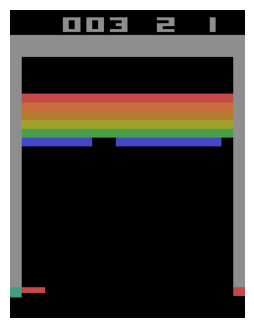

Round reward: 1.8 ep: 102
(210, 160, 3)


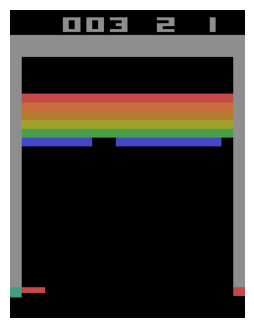

Round reward: 1.8 ep: 102
(210, 160, 3)


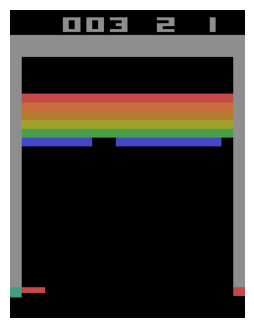

Round reward: 1.8 ep: 102
(210, 160, 3)


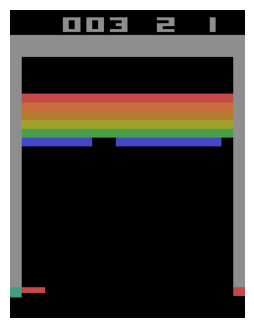

Round reward: 1.8 ep: 102
(210, 160, 3)


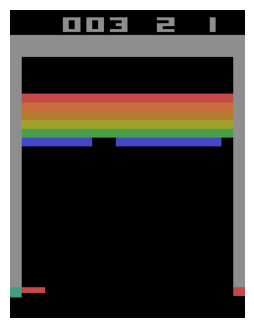

Round reward: 1.8 ep: 102
(210, 160, 3)


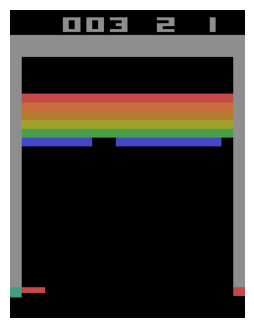

Round reward: 1.8 ep: 102
(210, 160, 3)


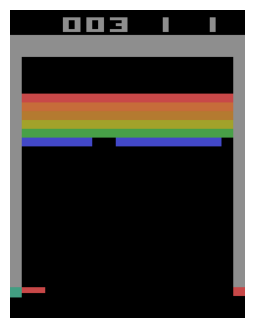

Round reward: 1.4 ep: 102
(210, 160, 3)


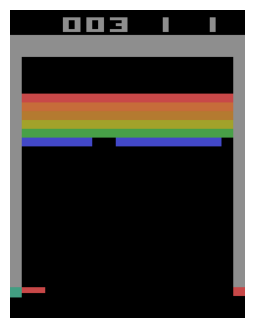

Round reward: 1.4 ep: 102
(210, 160, 3)


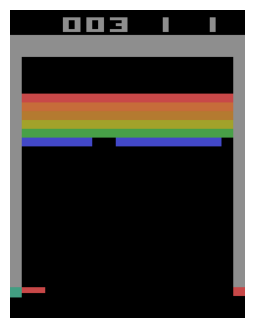

Round reward: 1.4 ep: 102
(210, 160, 3)


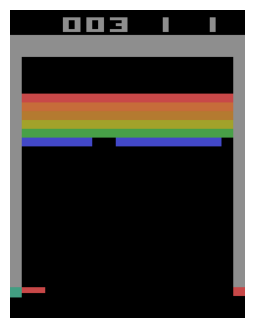

Round reward: 1.4 ep: 102
(210, 160, 3)


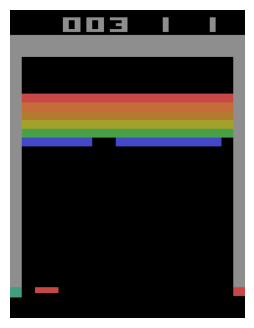

Round reward: 1.4 ep: 102
(210, 160, 3)


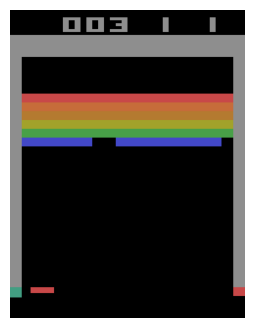

Round reward: 1.4 ep: 102
(210, 160, 3)


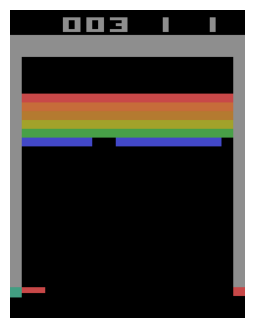

Round reward: 1.4 ep: 102
(210, 160, 3)


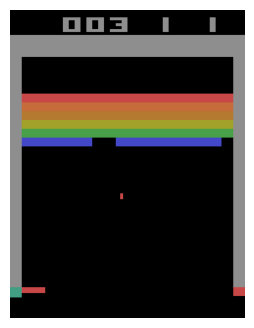

Round reward: 1.4 ep: 102
(210, 160, 3)


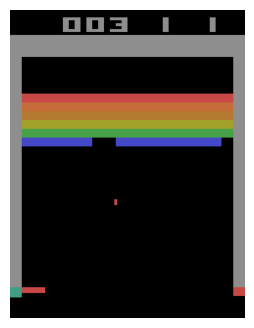

Round reward: 1.4 ep: 102
(210, 160, 3)


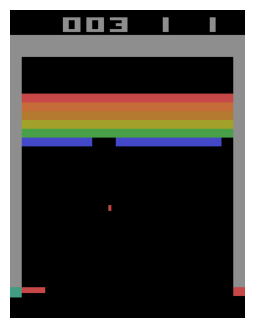

Round reward: 1.4 ep: 102
(210, 160, 3)


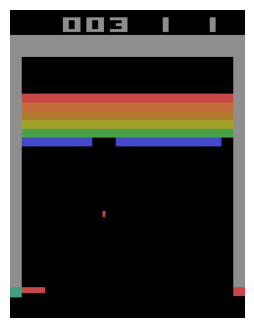

Round reward: 1.4 ep: 102
(210, 160, 3)


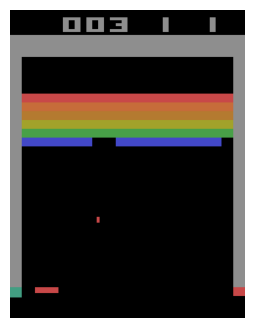

Round reward: 1.4 ep: 102
(210, 160, 3)


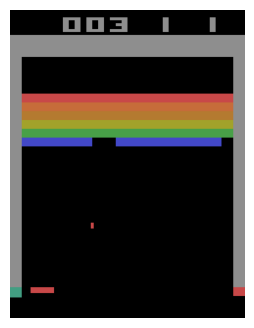

Round reward: 1.4 ep: 102
(210, 160, 3)


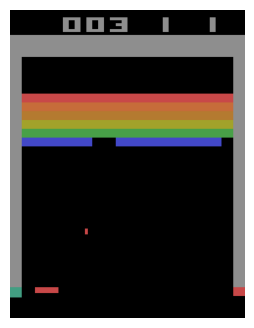

Round reward: 1.4 ep: 102
(210, 160, 3)


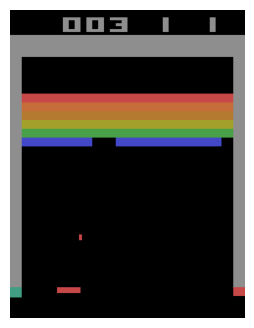

Round reward: 1.4 ep: 102
(210, 160, 3)


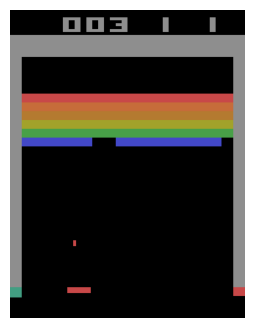

Round reward: 1.4 ep: 102
(210, 160, 3)


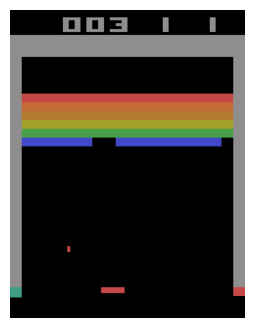

Round reward: 1.4 ep: 102
(210, 160, 3)


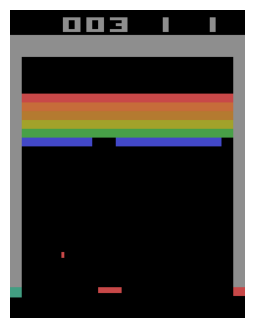

Round reward: 1.4 ep: 102
(210, 160, 3)


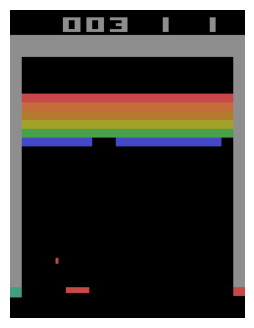

Round reward: 1.4 ep: 102
(210, 160, 3)


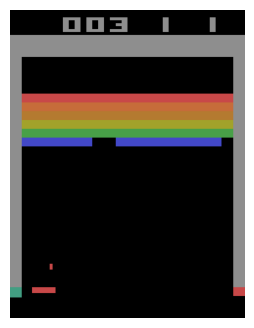

Round reward: 1.4 ep: 102
(210, 160, 3)


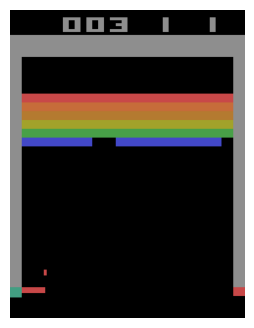

Round reward: 1.4 ep: 102
(210, 160, 3)


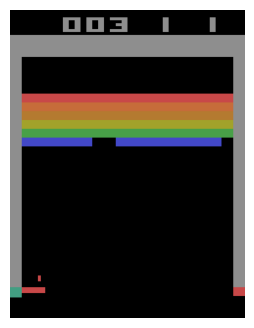

Round reward: 1.4 ep: 102
(210, 160, 3)


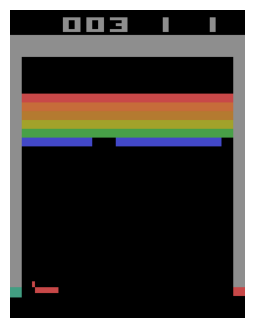

Round reward: 1.4 ep: 102
(210, 160, 3)


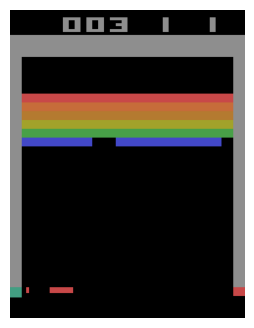

Round reward: 1.4 ep: 102
(210, 160, 3)


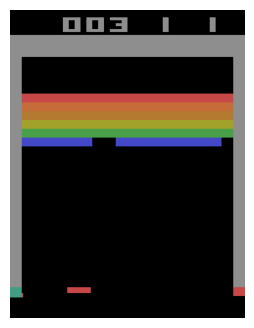

Round reward: 1.4 ep: 102
(210, 160, 3)


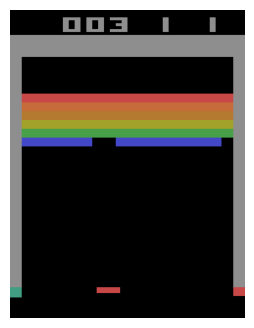

Round reward: 1.4 ep: 102
(210, 160, 3)


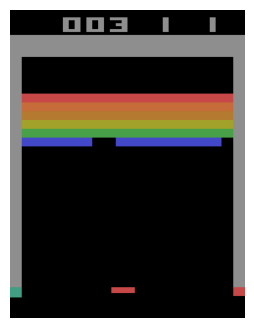

Round reward: 1.4 ep: 102
(210, 160, 3)


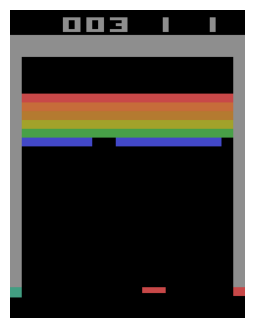

Round reward: 1.4 ep: 102
(210, 160, 3)


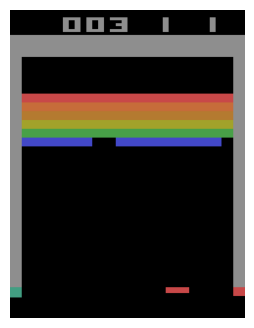

Round reward: 1.4 ep: 102
(210, 160, 3)


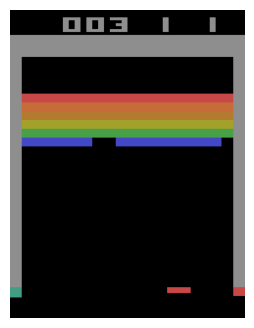

Round reward: 1.4 ep: 102
(210, 160, 3)


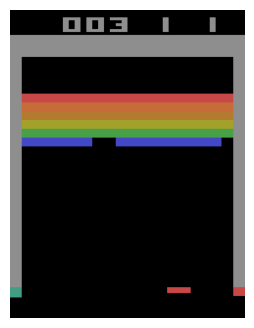

Round reward: 1.4 ep: 102
(210, 160, 3)


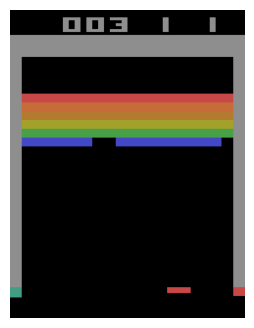

Round reward: 1.0 ep: 102
Episode: 103, Steps: 247 Reward:1.0 Epsilon: 0.9

loss: 0.007706250064074993
Episode: 104, Steps: 227 Reward:0.0 Epsilon: 0.9

loss: 0.03848671913146973
Episode: 105, Steps: 265 Reward:2.0 Epsilon: 0.9

loss: 0.030830468982458115
Episode: 106, Steps: 191 Reward:-1.0 Epsilon: 0.9

loss: 0.06926719099283218
Episode: 107, Steps: 218 Reward:0.0 Epsilon: 0.9

loss: 0.015362500213086605
Episode: 108, Steps: 175 Reward:-1.0 Epsilon: 0.9

loss: 0.030675001442432404
Episode: 109, Steps: 217 Reward:0.0 Epsilon: 0.9

loss: 0.015362500213086605
Episode: 110, Steps: 165 Reward:-1.0 Epsilon: 0.9

loss: 0.023174218833446503
Episode: 111, Steps: 135 Reward:-2.0 Epsilon: 0.9

loss: 0.038331251591444016
Episode: 112, Steps: 181 Reward:-1.0 Epsilon: 0.9

loss: 0.02301875129342079
Episode: 113, Steps: 156 Reward:-2.0 Epsilon: 0.9

loss: 4.9999904149444774e-05
Episode: 114, Steps: 279 Reward:1.0 Epsilon: 0.9

loss: 0.06161094084382057
Episode: 115, Steps: 273 Reward:1.0 Epsilon: 0

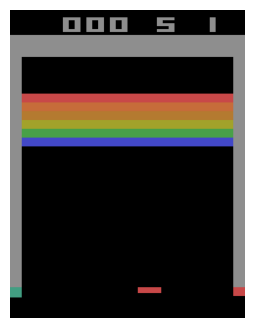

Round reward: 0.0 ep: 153
(210, 160, 3)


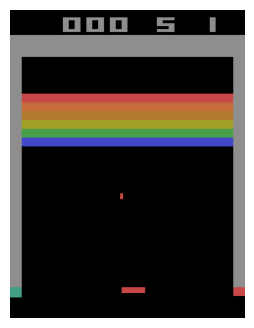

Round reward: 0.0 ep: 153
(210, 160, 3)


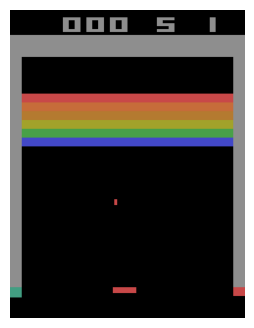

Round reward: 0.0 ep: 153
(210, 160, 3)


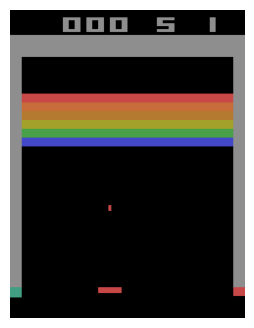

Round reward: 0.0 ep: 153
(210, 160, 3)


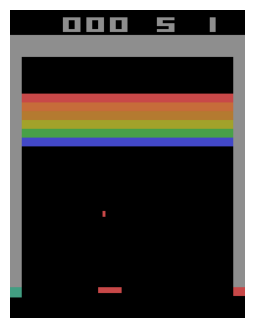

Round reward: 0.0 ep: 153
(210, 160, 3)


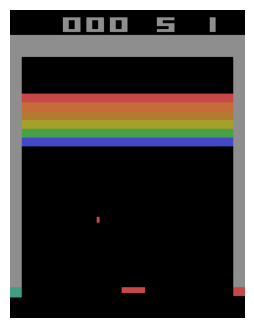

Round reward: 0.0 ep: 153
(210, 160, 3)


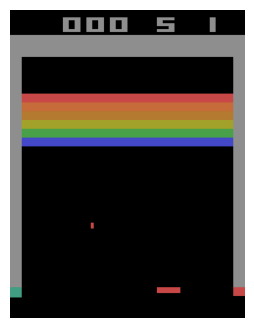

Round reward: 0.0 ep: 153
(210, 160, 3)


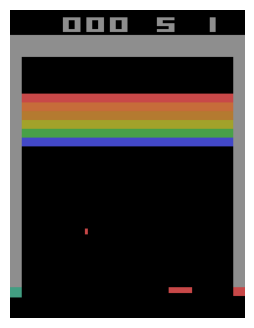

Round reward: 0.0 ep: 153
(210, 160, 3)


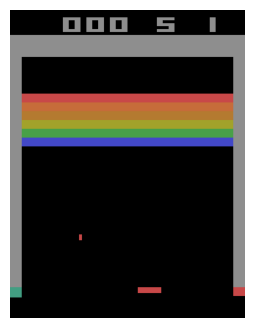

Round reward: 0.0 ep: 153
(210, 160, 3)


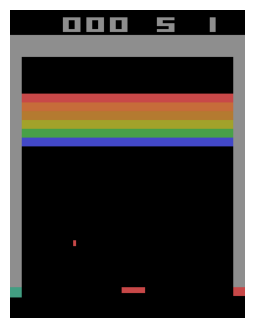

Round reward: 0.0 ep: 153
(210, 160, 3)


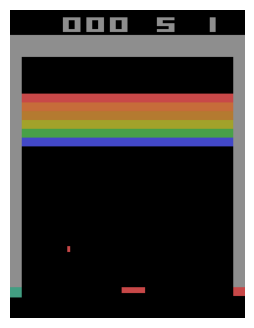

Round reward: 0.0 ep: 153
(210, 160, 3)


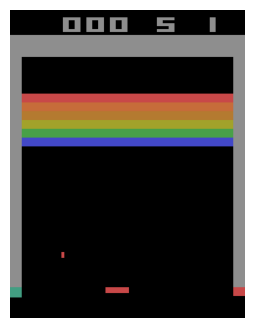

Round reward: 0.0 ep: 153
(210, 160, 3)


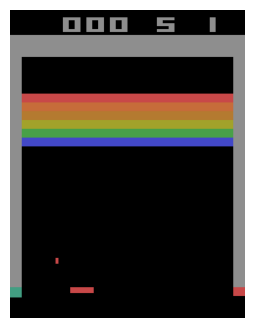

Round reward: 0.0 ep: 153
(210, 160, 3)


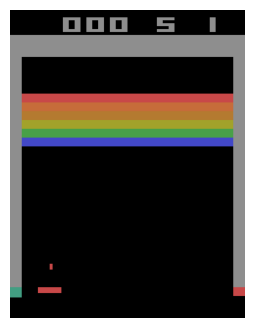

Round reward: 0.0 ep: 153
(210, 160, 3)


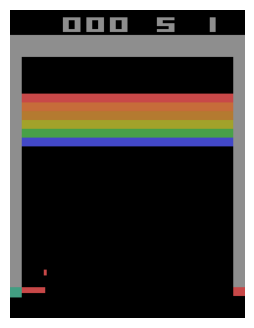

Round reward: 0.0 ep: 153
(210, 160, 3)


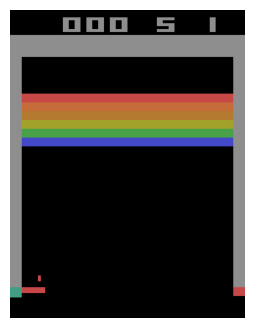

Round reward: 0.0 ep: 153
(210, 160, 3)


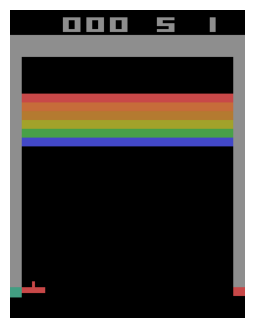

Round reward: 0.0 ep: 153
(210, 160, 3)


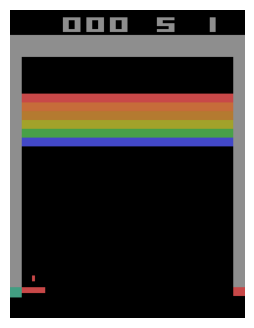

Round reward: 0.0 ep: 153
(210, 160, 3)


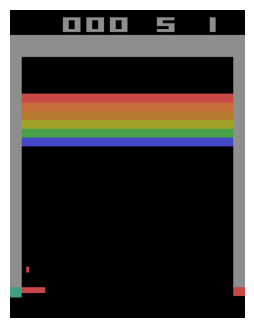

Round reward: 0.0 ep: 153
(210, 160, 3)


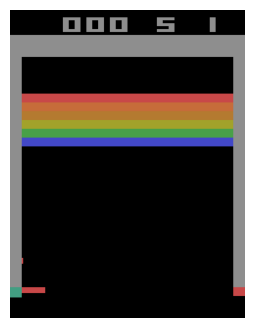

Round reward: 0.0 ep: 153
(210, 160, 3)


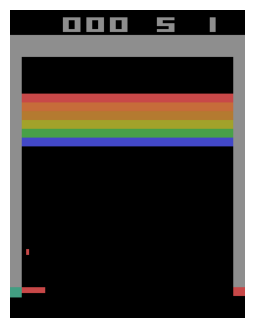

Round reward: 0.0 ep: 153
(210, 160, 3)


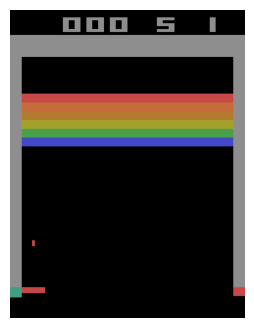

Round reward: 0.0 ep: 153
(210, 160, 3)


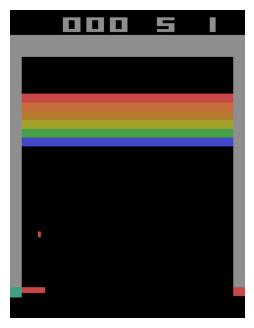

Round reward: 0.0 ep: 153
(210, 160, 3)


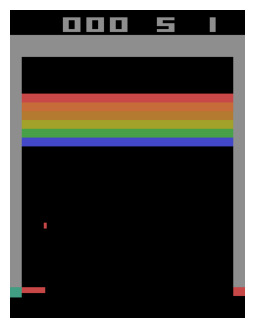

Round reward: 0.0 ep: 153
(210, 160, 3)


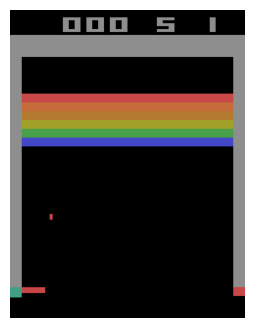

Round reward: 0.0 ep: 153
(210, 160, 3)


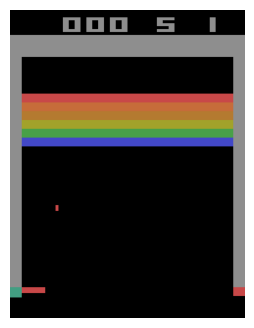

Round reward: 0.0 ep: 153
(210, 160, 3)


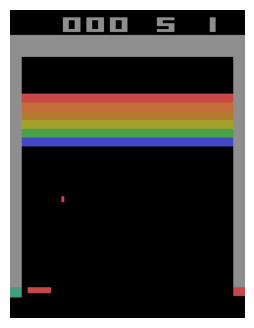

Round reward: 0.0 ep: 153
(210, 160, 3)


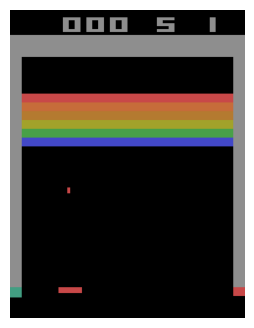

Round reward: 0.0 ep: 153
(210, 160, 3)


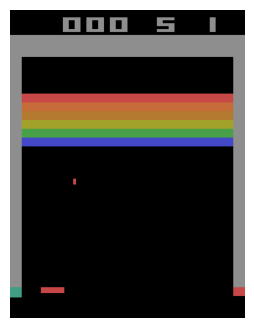

Round reward: 0.0 ep: 153
(210, 160, 3)


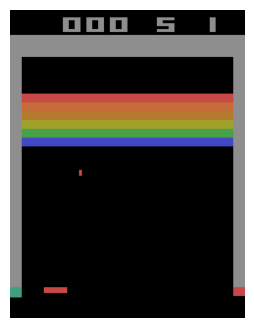

Round reward: 0.0 ep: 153
(210, 160, 3)


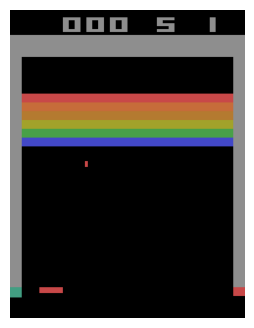

Round reward: 0.0 ep: 153
(210, 160, 3)


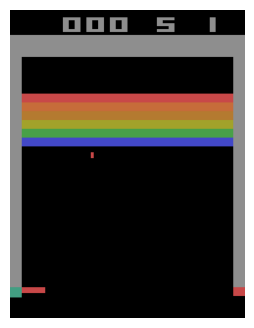

Round reward: 0.0 ep: 153
(210, 160, 3)


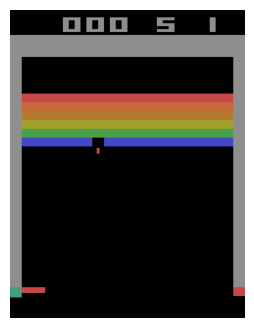

Round reward: 1.0 ep: 153
(210, 160, 3)


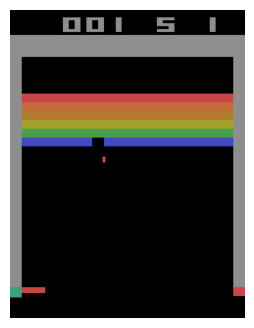

Round reward: 1.0 ep: 153
(210, 160, 3)


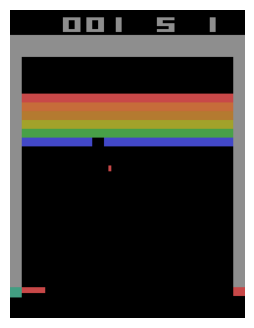

Round reward: 1.0 ep: 153
(210, 160, 3)


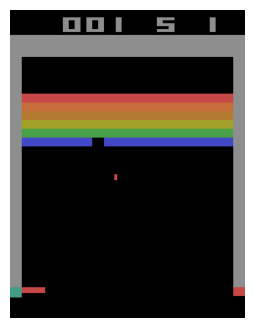

Round reward: 1.0 ep: 153
(210, 160, 3)


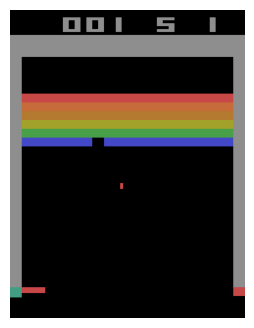

Round reward: 1.0 ep: 153
(210, 160, 3)


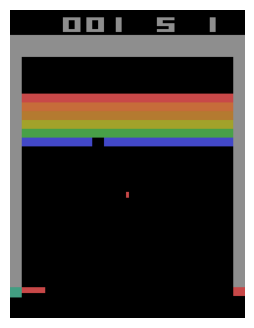

Round reward: 1.0 ep: 153
(210, 160, 3)


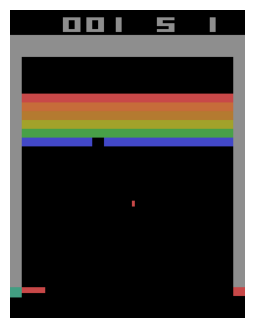

Round reward: 1.0 ep: 153
(210, 160, 3)


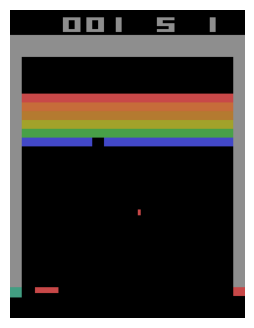

Round reward: 1.0 ep: 153
(210, 160, 3)


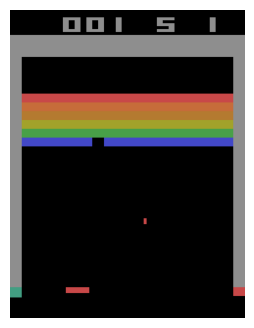

Round reward: 1.0 ep: 153
(210, 160, 3)


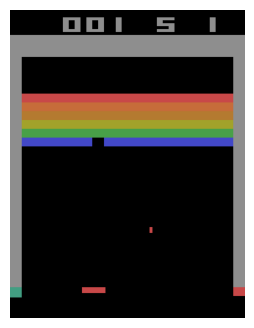

Round reward: 1.0 ep: 153
(210, 160, 3)


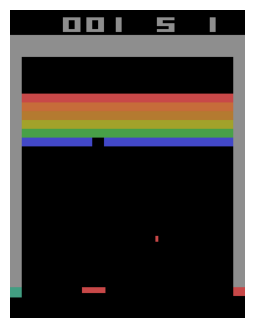

Round reward: 1.0 ep: 153
(210, 160, 3)


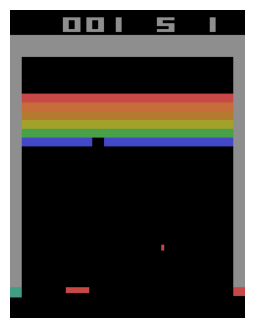

Round reward: 1.0 ep: 153
(210, 160, 3)


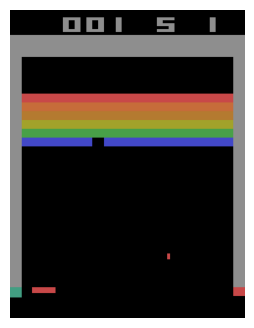

Round reward: 1.0 ep: 153
(210, 160, 3)


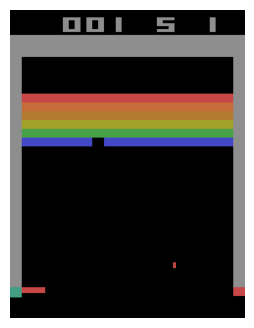

Round reward: 1.0 ep: 153
(210, 160, 3)


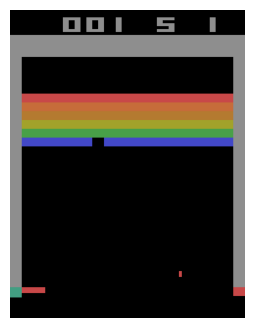

Round reward: 1.0 ep: 153
(210, 160, 3)


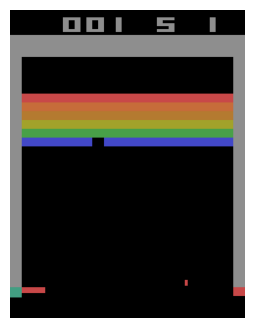

Round reward: 1.0 ep: 153
(210, 160, 3)


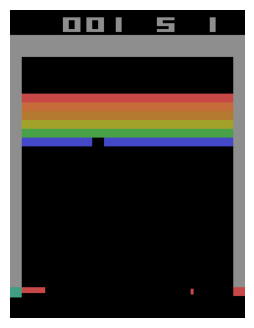

Round reward: 1.0 ep: 153
(210, 160, 3)


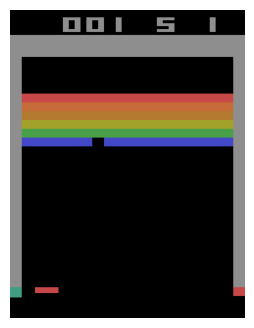

Round reward: 1.0 ep: 153
(210, 160, 3)


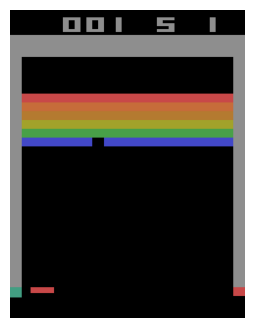

Round reward: 1.0 ep: 153
(210, 160, 3)


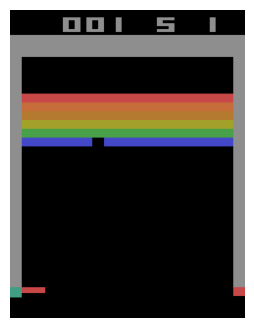

Round reward: 1.0 ep: 153
(210, 160, 3)


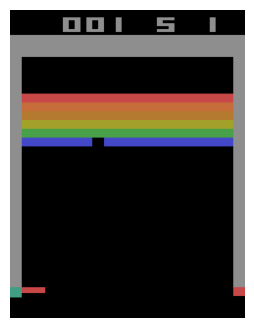

Round reward: 1.0 ep: 153
(210, 160, 3)


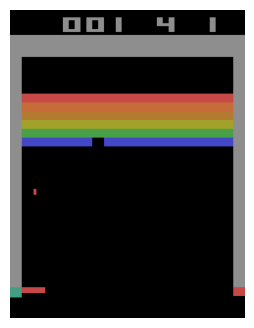

Round reward: 0.6 ep: 153
(210, 160, 3)


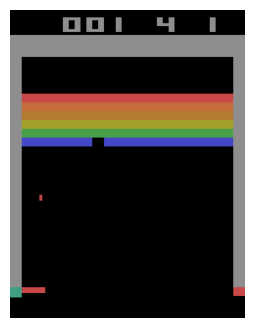

Round reward: 0.6 ep: 153
(210, 160, 3)


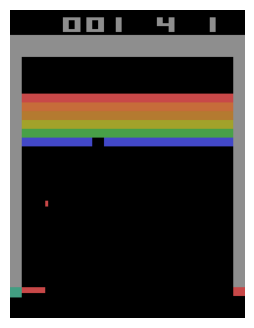

Round reward: 0.6 ep: 153
(210, 160, 3)


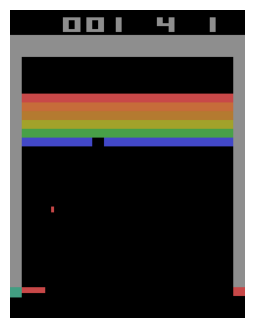

Round reward: 0.6 ep: 153
(210, 160, 3)


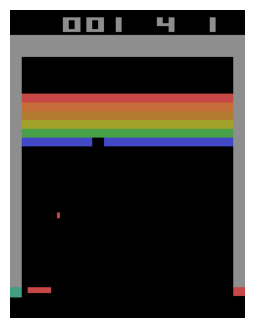

Round reward: 0.6 ep: 153
(210, 160, 3)


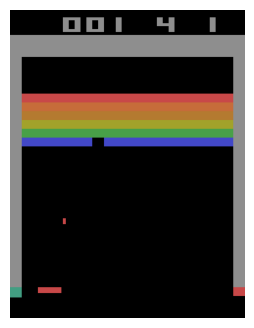

Round reward: 0.6 ep: 153
(210, 160, 3)


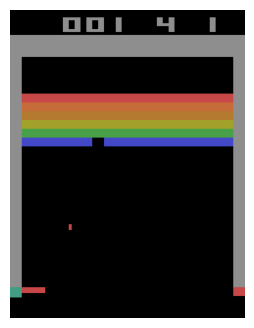

Round reward: 0.6 ep: 153
(210, 160, 3)


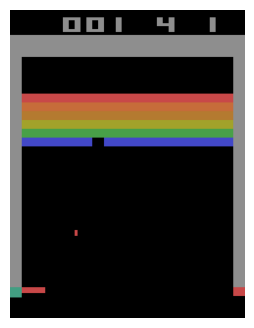

Round reward: 0.6 ep: 153
(210, 160, 3)


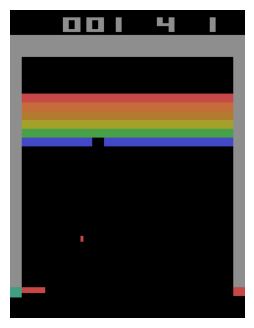

Round reward: 0.6 ep: 153
(210, 160, 3)


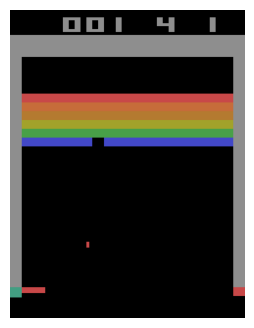

Round reward: 0.6 ep: 153
(210, 160, 3)


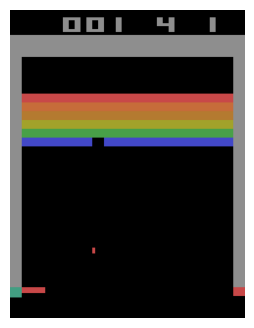

Round reward: 0.6 ep: 153
(210, 160, 3)


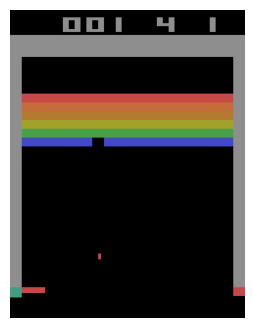

Round reward: 0.6 ep: 153
(210, 160, 3)


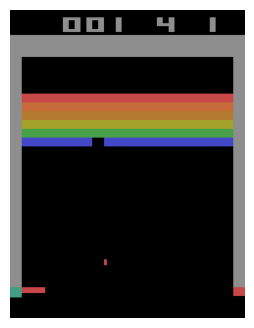

Round reward: 0.6 ep: 153
(210, 160, 3)


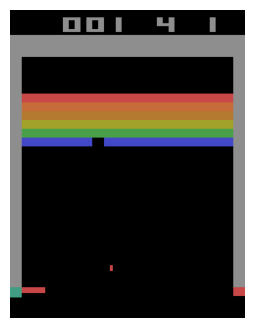

Round reward: 0.6 ep: 153
(210, 160, 3)


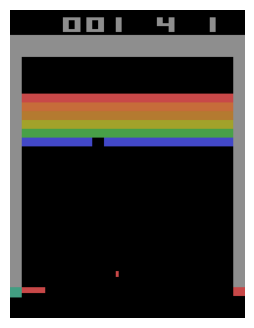

Round reward: 0.6 ep: 153
(210, 160, 3)


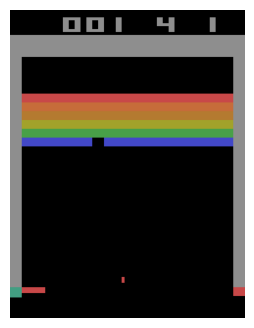

Round reward: 0.6 ep: 153
(210, 160, 3)


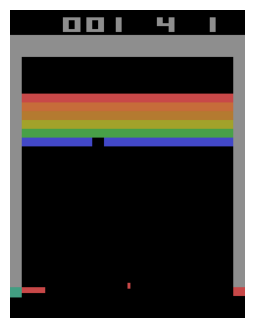

Round reward: 0.6 ep: 153
(210, 160, 3)


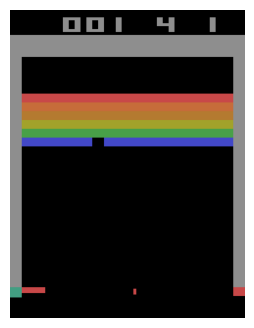

Round reward: 0.6 ep: 153
(210, 160, 3)


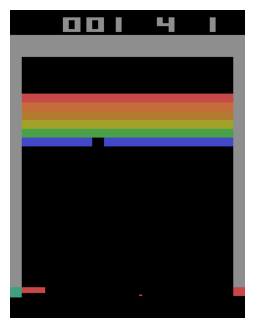

Round reward: 0.6 ep: 153
(210, 160, 3)


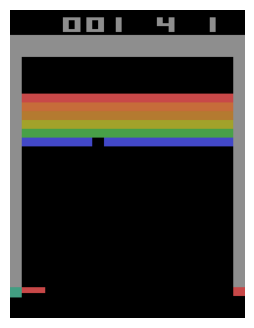

Round reward: 0.6 ep: 153
(210, 160, 3)


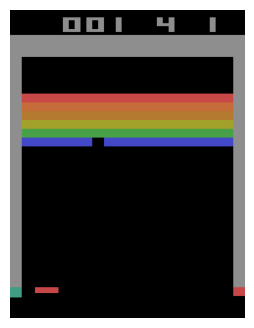

Round reward: 0.6 ep: 153
(210, 160, 3)


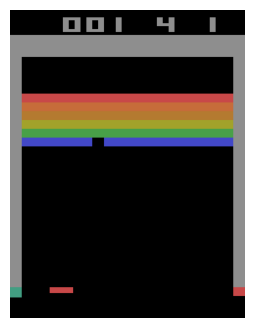

Round reward: 0.6 ep: 153
(210, 160, 3)


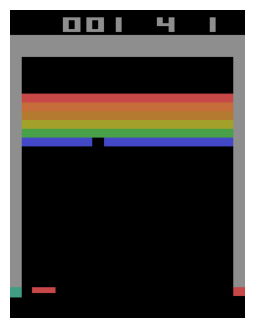

Round reward: 0.6 ep: 153
(210, 160, 3)


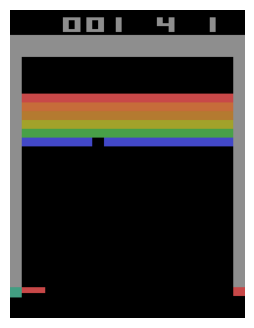

Round reward: 0.6 ep: 153
(210, 160, 3)


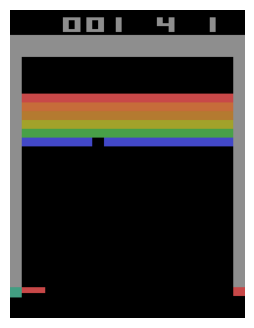

Round reward: 0.2 ep: 153
(210, 160, 3)


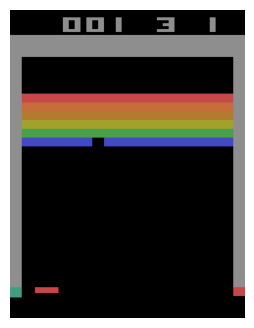

Round reward: 0.2 ep: 153
(210, 160, 3)


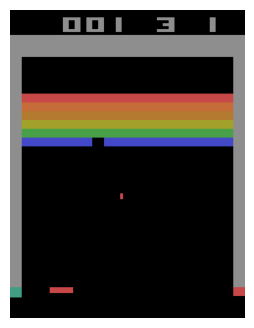

Round reward: 0.2 ep: 153
(210, 160, 3)


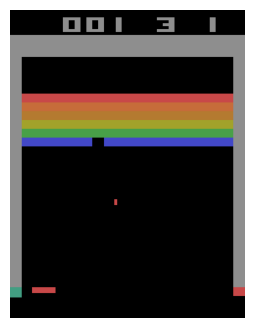

Round reward: 0.2 ep: 153
(210, 160, 3)


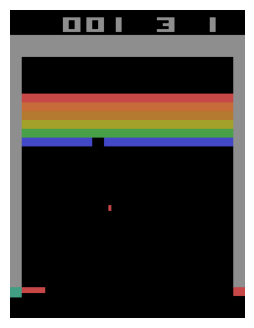

Round reward: 0.2 ep: 153
(210, 160, 3)


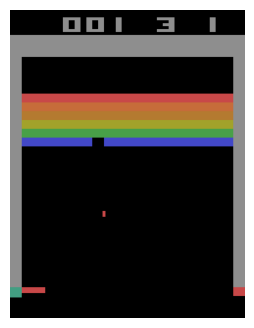

Round reward: 0.2 ep: 153
(210, 160, 3)


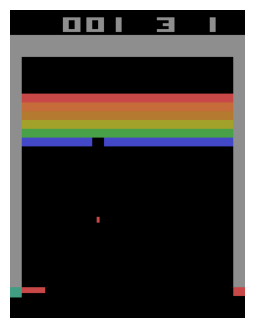

Round reward: 0.2 ep: 153
(210, 160, 3)


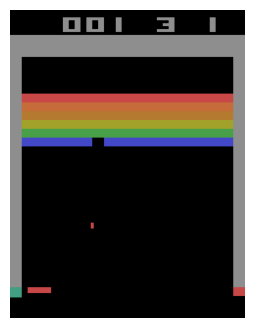

Round reward: 0.2 ep: 153
(210, 160, 3)


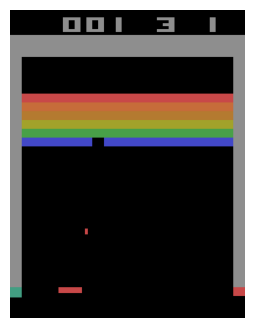

Round reward: 0.2 ep: 153
(210, 160, 3)


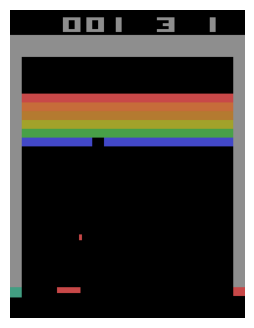

Round reward: 0.2 ep: 153
(210, 160, 3)


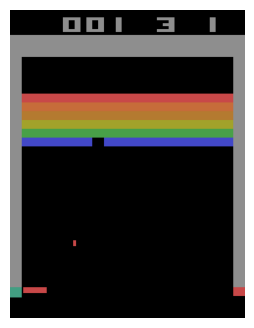

Round reward: 0.2 ep: 153
(210, 160, 3)


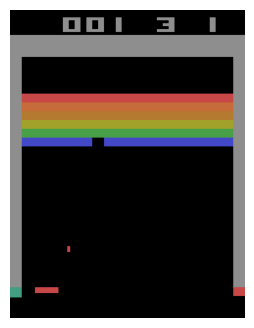

Round reward: 0.2 ep: 153
(210, 160, 3)


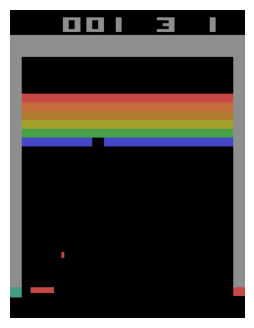

Round reward: 0.2 ep: 153
(210, 160, 3)


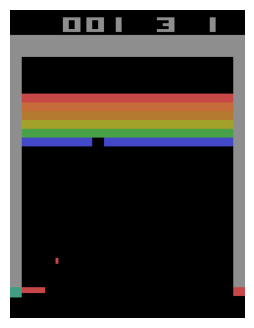

Round reward: 0.2 ep: 153
(210, 160, 3)


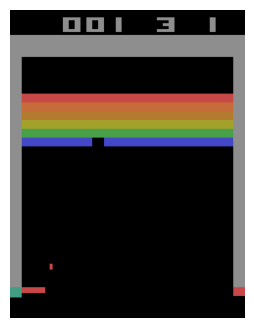

Round reward: 0.2 ep: 153
(210, 160, 3)


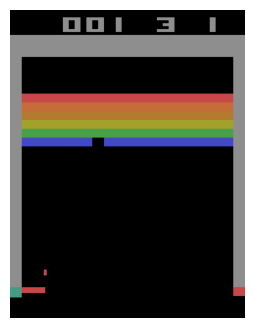

Round reward: 0.2 ep: 153
(210, 160, 3)


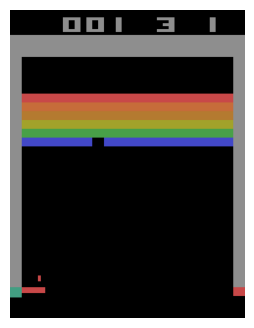

Round reward: 0.2 ep: 153
(210, 160, 3)


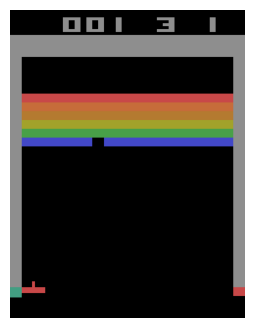

Round reward: 0.2 ep: 153
(210, 160, 3)


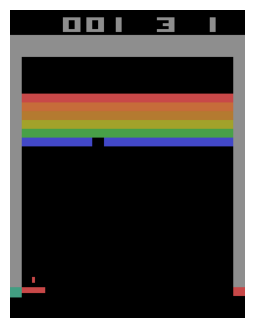

Round reward: 0.2 ep: 153
(210, 160, 3)


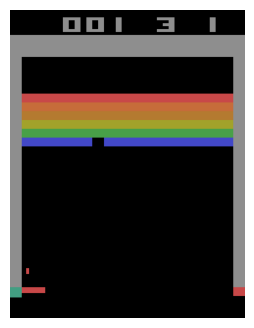

Round reward: 0.2 ep: 153
(210, 160, 3)


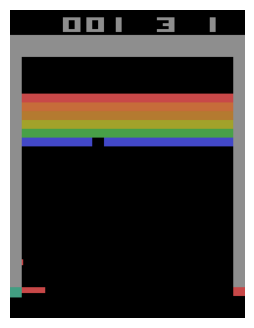

Round reward: 0.2 ep: 153
(210, 160, 3)


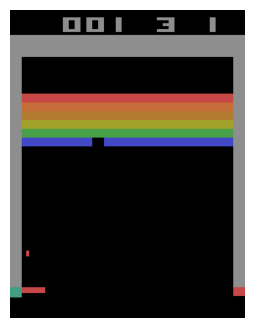

Round reward: 0.2 ep: 153
(210, 160, 3)


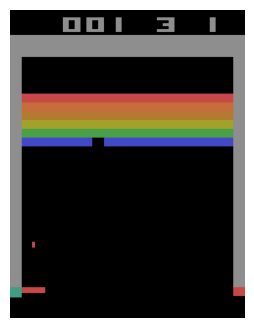

Round reward: 0.2 ep: 153
(210, 160, 3)


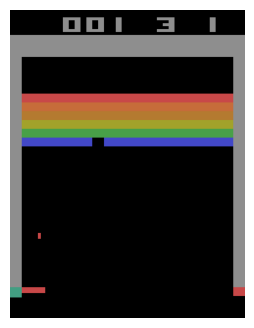

Round reward: 0.2 ep: 153
(210, 160, 3)


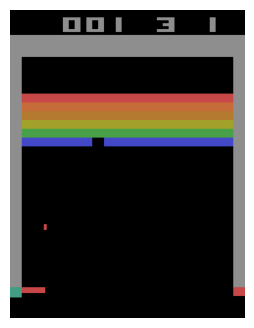

Round reward: 0.2 ep: 153
(210, 160, 3)


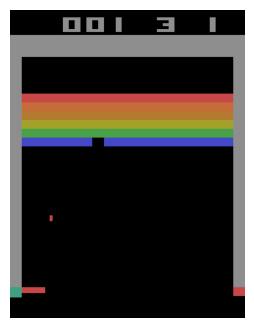

Round reward: 0.2 ep: 153
(210, 160, 3)


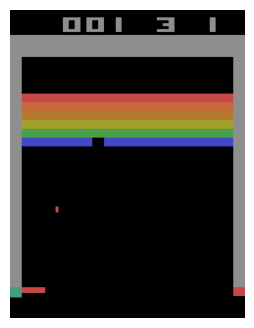

Round reward: 0.2 ep: 153
(210, 160, 3)


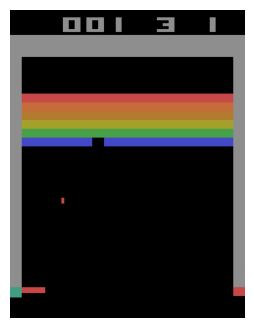

Round reward: 0.2 ep: 153
(210, 160, 3)


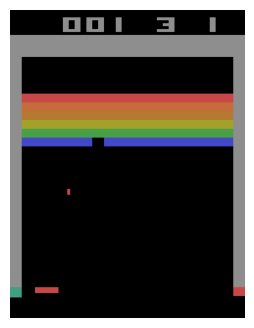

Round reward: 0.2 ep: 153
(210, 160, 3)


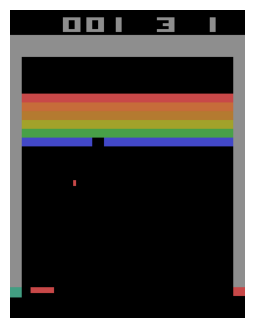

Round reward: 0.2 ep: 153
(210, 160, 3)


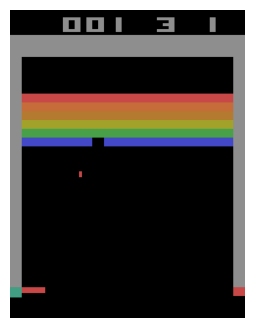

Round reward: 0.2 ep: 153
(210, 160, 3)


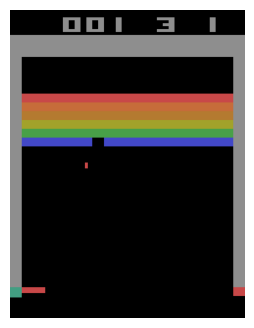

Round reward: 0.2 ep: 153
(210, 160, 3)


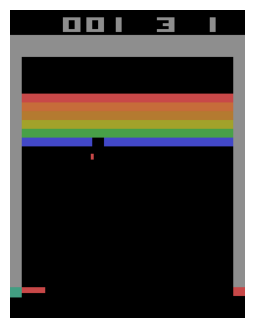

Round reward: 0.2 ep: 153
(210, 160, 3)


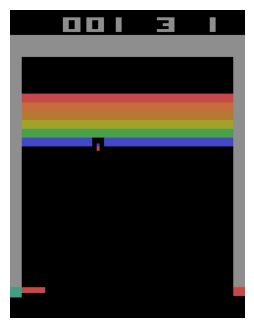

Round reward: 0.2 ep: 153
(210, 160, 3)


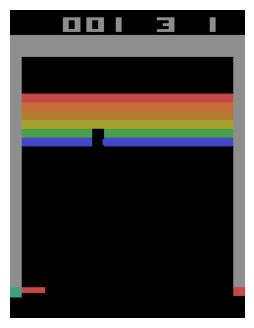

Round reward: 1.2 ep: 153
(210, 160, 3)


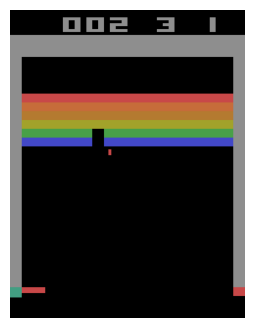

Round reward: 1.2 ep: 153
(210, 160, 3)


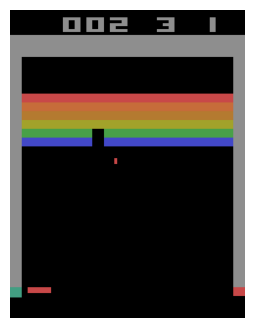

Round reward: 1.2 ep: 153
(210, 160, 3)


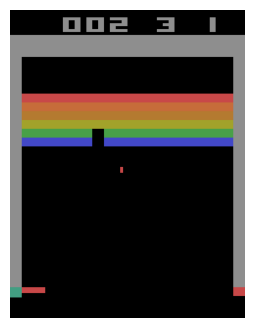

Round reward: 1.2 ep: 153
(210, 160, 3)


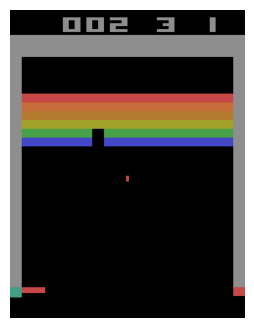

Round reward: 1.2 ep: 153
(210, 160, 3)


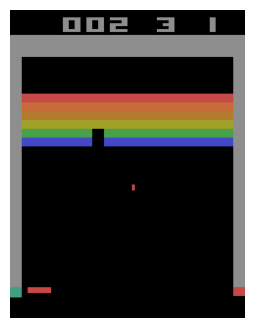

Round reward: 1.2 ep: 153
(210, 160, 3)


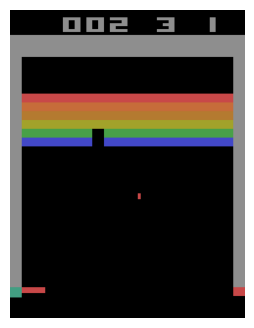

Round reward: 1.2 ep: 153
(210, 160, 3)


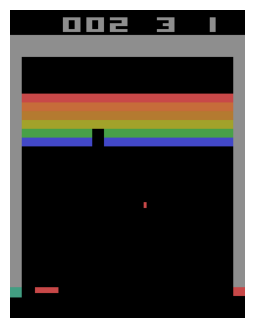

Round reward: 1.2 ep: 153
(210, 160, 3)


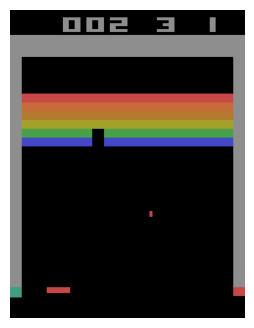

Round reward: 1.2 ep: 153
(210, 160, 3)


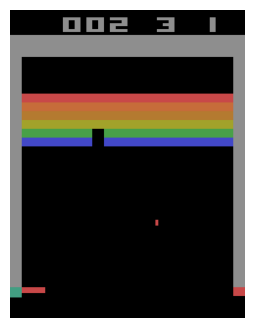

Round reward: 1.2 ep: 153
(210, 160, 3)


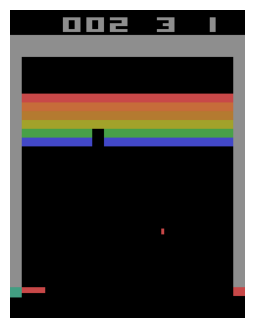

Round reward: 1.2 ep: 153
(210, 160, 3)


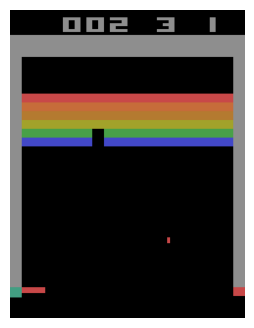

Round reward: 1.2 ep: 153
(210, 160, 3)


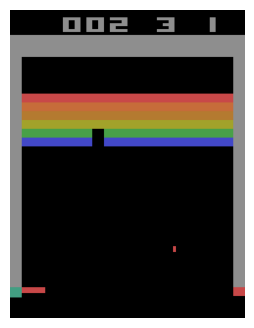

Round reward: 1.2 ep: 153
(210, 160, 3)


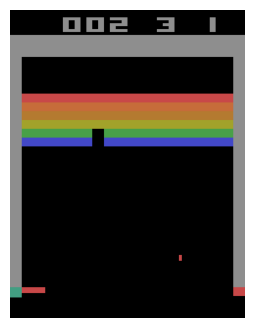

Round reward: 1.2 ep: 153
(210, 160, 3)


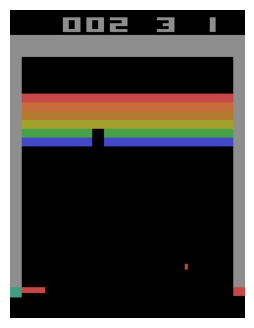

Round reward: 1.2 ep: 153
(210, 160, 3)


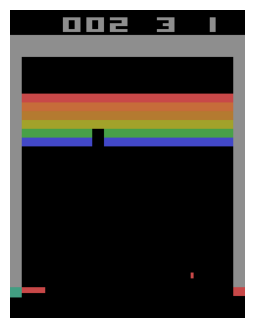

Round reward: 1.2 ep: 153
(210, 160, 3)


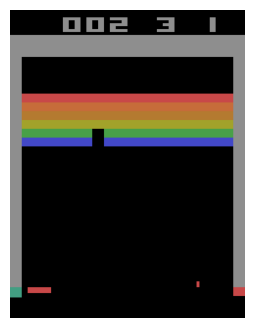

Round reward: 1.2 ep: 153
(210, 160, 3)


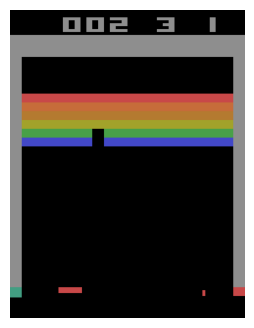

Round reward: 1.2 ep: 153
(210, 160, 3)


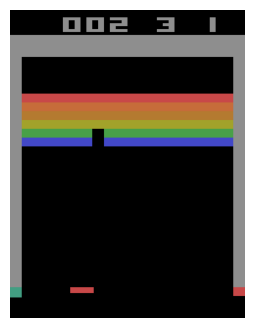

Round reward: 1.2 ep: 153
(210, 160, 3)


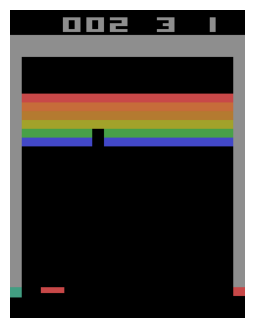

Round reward: 1.2 ep: 153
(210, 160, 3)


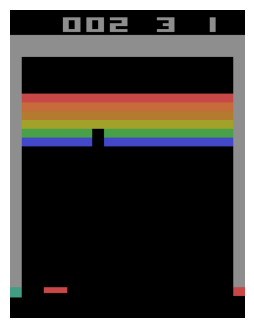

Round reward: 1.2 ep: 153
(210, 160, 3)


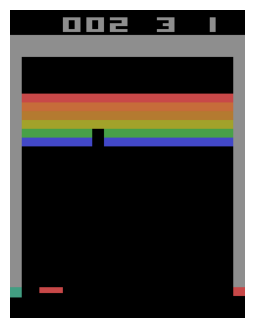

Round reward: 1.2 ep: 153
(210, 160, 3)


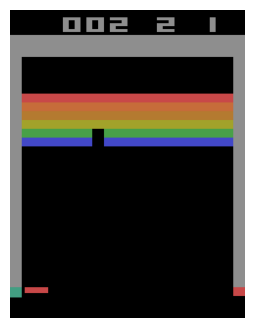

Round reward: 0.8 ep: 153
(210, 160, 3)


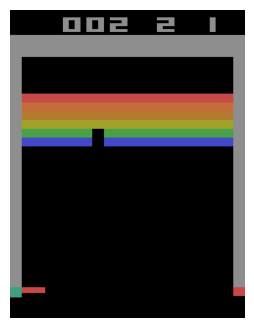

Round reward: 0.8 ep: 153
(210, 160, 3)


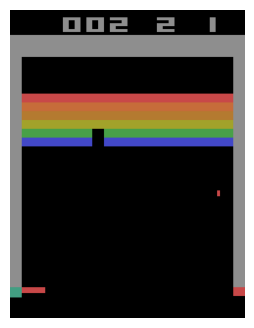

Round reward: 0.8 ep: 153
(210, 160, 3)


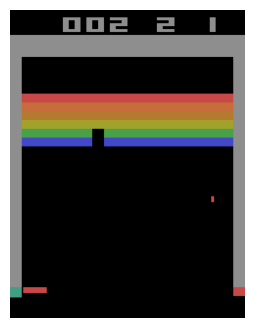

Round reward: 0.8 ep: 153
(210, 160, 3)


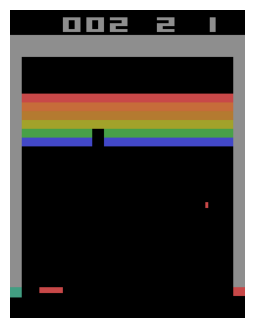

Round reward: 0.8 ep: 153
(210, 160, 3)


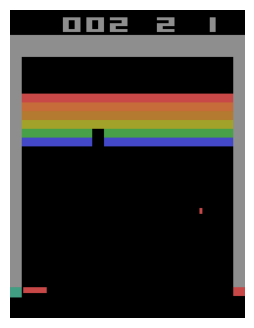

Round reward: 0.8 ep: 153
(210, 160, 3)


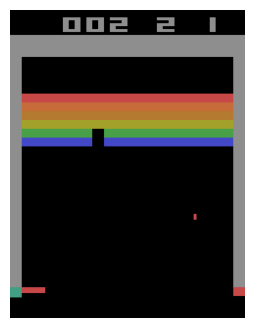

Round reward: 0.8 ep: 153
(210, 160, 3)


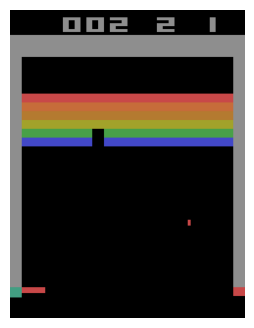

Round reward: 0.8 ep: 153
(210, 160, 3)


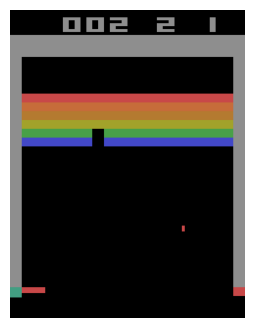

Round reward: 0.8 ep: 153
(210, 160, 3)


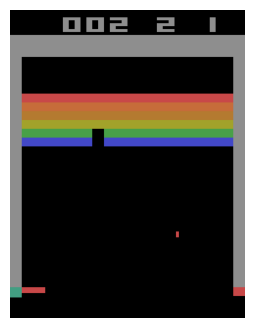

Round reward: 0.8 ep: 153
(210, 160, 3)


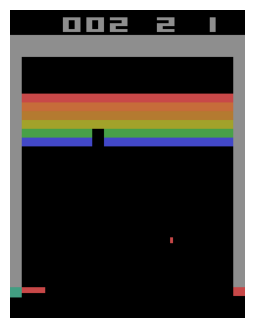

Round reward: 0.8 ep: 153
(210, 160, 3)


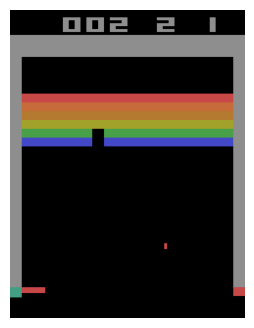

Round reward: 0.8 ep: 153
(210, 160, 3)


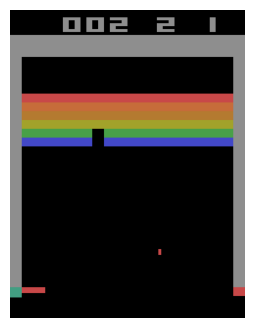

Round reward: 0.8 ep: 153
(210, 160, 3)


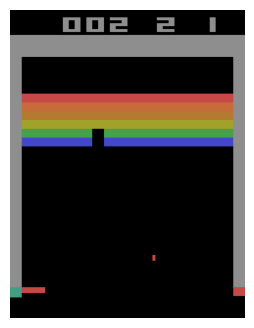

Round reward: 0.8 ep: 153
(210, 160, 3)


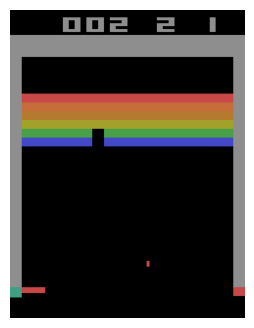

Round reward: 0.8 ep: 153
(210, 160, 3)


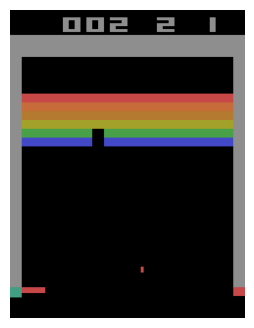

Round reward: 0.8 ep: 153
(210, 160, 3)


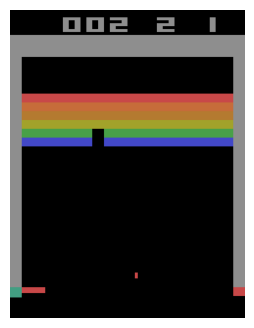

Round reward: 0.8 ep: 153
(210, 160, 3)


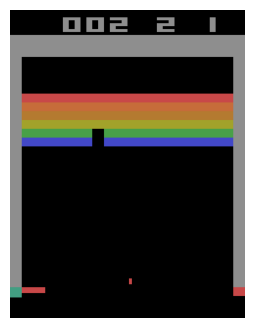

Round reward: 0.8 ep: 153
(210, 160, 3)


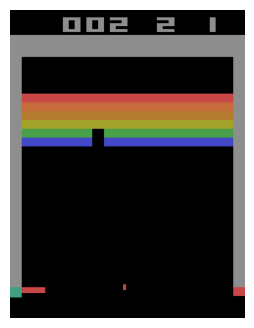

Round reward: 0.8 ep: 153
(210, 160, 3)


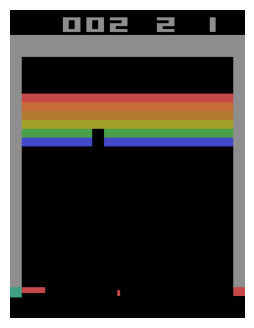

Round reward: 0.8 ep: 153
(210, 160, 3)


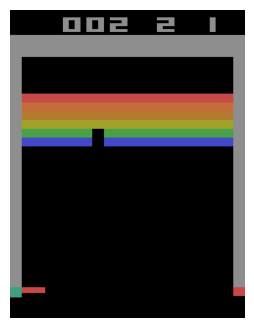

Round reward: 0.8 ep: 153
(210, 160, 3)


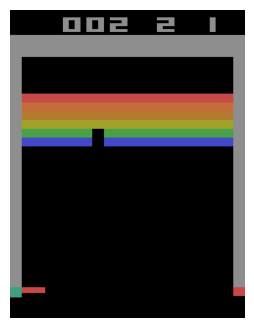

Round reward: 0.8 ep: 153
(210, 160, 3)


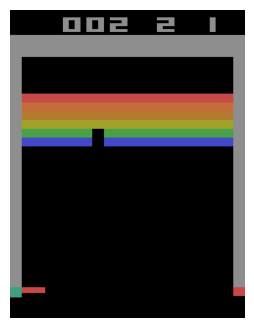

Round reward: 0.8 ep: 153
(210, 160, 3)


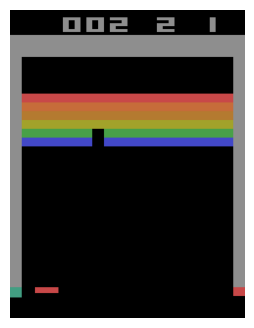

Round reward: 0.8 ep: 153
(210, 160, 3)


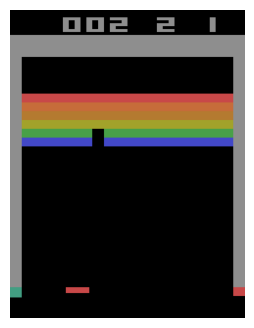

Round reward: 0.8 ep: 153
(210, 160, 3)


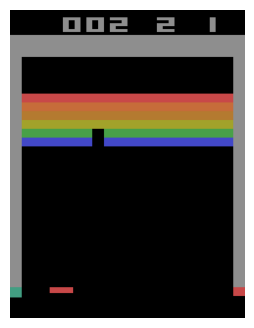

Round reward: 0.8 ep: 153
(210, 160, 3)


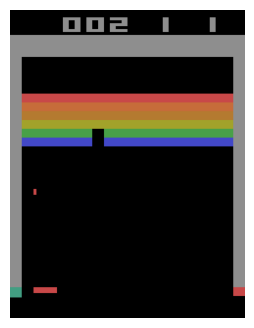

Round reward: 0.4 ep: 153
(210, 160, 3)


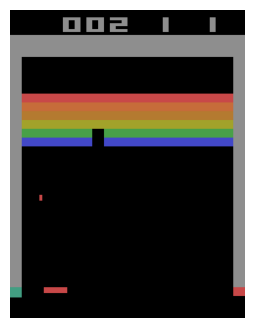

Round reward: 0.4 ep: 153
(210, 160, 3)


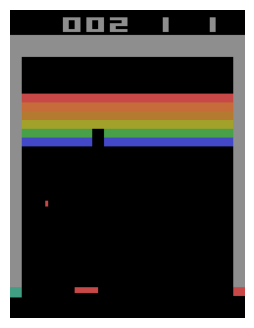

Round reward: 0.4 ep: 153
(210, 160, 3)


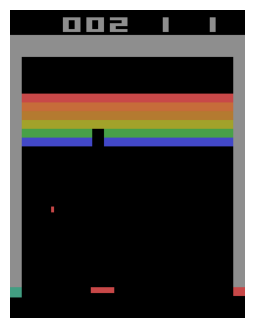

Round reward: 0.4 ep: 153
(210, 160, 3)


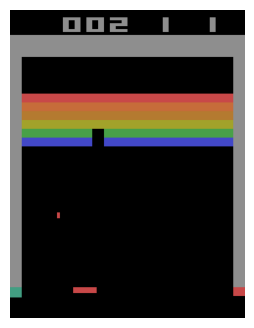

Round reward: 0.4 ep: 153
(210, 160, 3)


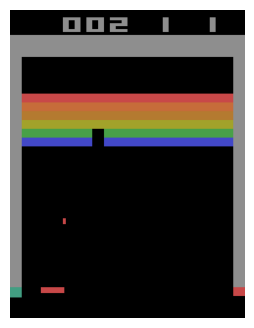

Round reward: 0.4 ep: 153
(210, 160, 3)


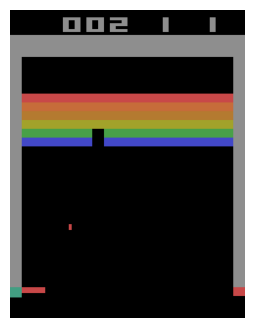

Round reward: 0.4 ep: 153
(210, 160, 3)


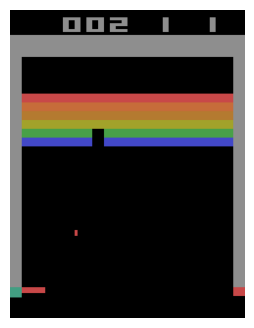

Round reward: 0.4 ep: 153
(210, 160, 3)


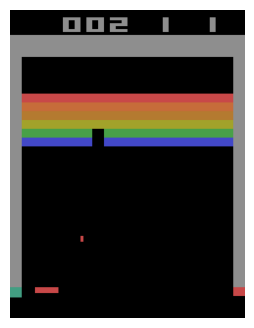

Round reward: 0.4 ep: 153
(210, 160, 3)


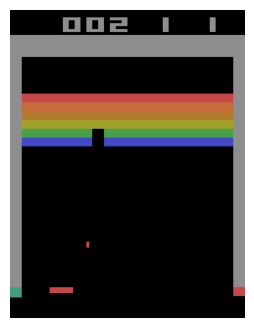

Round reward: 0.4 ep: 153
(210, 160, 3)


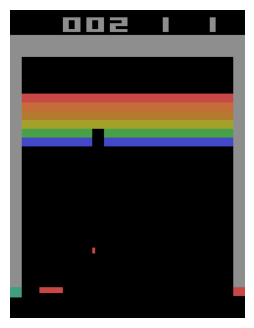

Round reward: 0.4 ep: 153
(210, 160, 3)


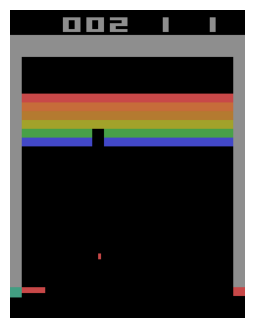

Round reward: 0.4 ep: 153
(210, 160, 3)


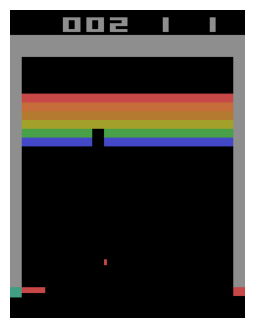

Round reward: 0.4 ep: 153
(210, 160, 3)


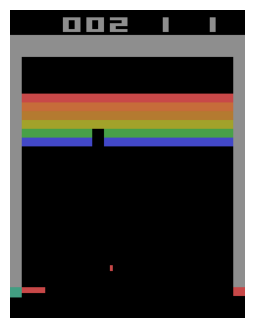

Round reward: 0.4 ep: 153
(210, 160, 3)


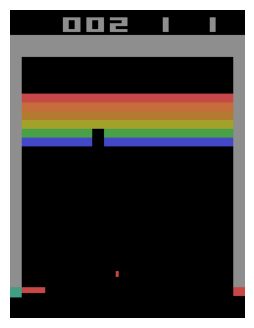

Round reward: 0.4 ep: 153
(210, 160, 3)


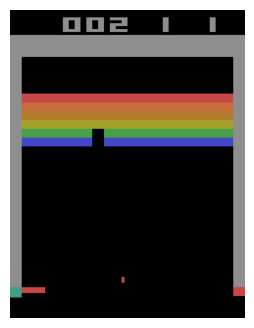

Round reward: 0.4 ep: 153
(210, 160, 3)


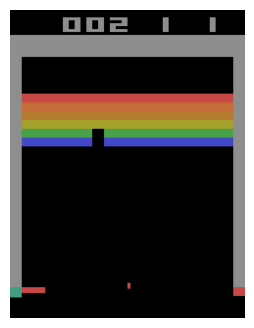

Round reward: 0.4 ep: 153
(210, 160, 3)


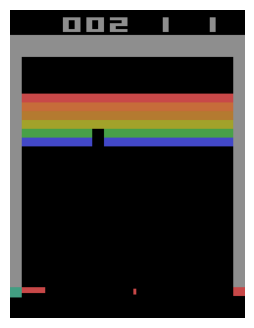

Round reward: 0.4 ep: 153
(210, 160, 3)


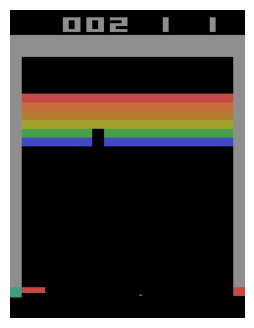

Round reward: 0.4 ep: 153
(210, 160, 3)


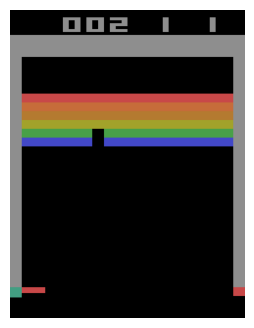

Round reward: 0.4 ep: 153
(210, 160, 3)


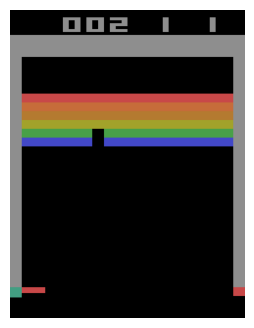

Round reward: 0.4 ep: 153
(210, 160, 3)


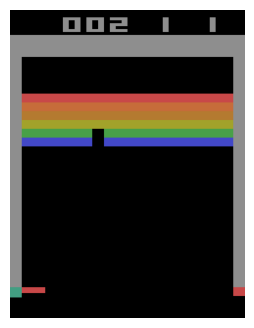

Round reward: 0.4 ep: 153
(210, 160, 3)


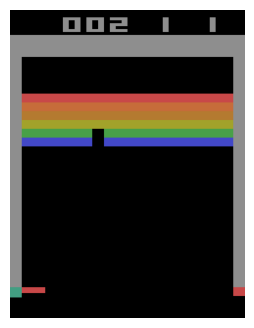

Round reward: 0.4 ep: 153
(210, 160, 3)


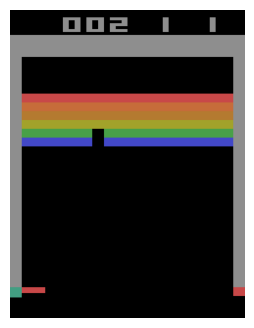

Round reward: 0.4 ep: 153
(210, 160, 3)


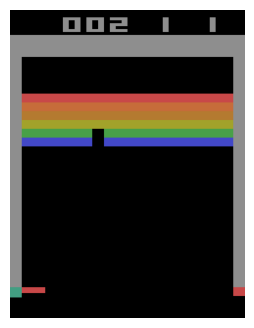

Round reward: 0.0 ep: 153
Episode: 154, Steps: 184 Reward:0.0 Epsilon: 0.5628571428571428

loss: 0.02301875129342079
Episode: 155, Steps: 218 Reward:0.0 Epsilon: 0.56

loss: 0.030675001442432404

Update targets

Episode: 156, Steps: 264 Reward:5.0 Epsilon: 0.5571428571428572

loss: 0.01551796868443489
Episode: 157, Steps: 190 Reward:0.0 Epsilon: 0.5542857142857143

loss: 0.03848671913146973
Episode: 158, Steps: 310 Reward:3.0 Epsilon: 0.5514285714285714

loss: 0.038331251591444016
Episode: 159, Steps: 258 Reward:1.0 Epsilon: 0.5485714285714286

loss: 0.02301875129342079
Episode: 160, Steps: 232 Reward:1.0 Epsilon: 0.5457142857142857

loss: 0.015362500213086605
Episode: 161, Steps: 255 Reward:1.0 Epsilon: 0.5428571428571429

loss: 0.023174218833446503
Episode: 162, Steps: 206 Reward:0.0 Epsilon: 0.54

loss: 0.007706250064074993
Episode: 163, Steps: 273 Reward:5.0 Epsilon: 0.5371428571428571

loss: 0.02301875129342079
Episode: 164, Steps: 186 Reward:0.0 Epsilon: 0.5342857142857143

loss:

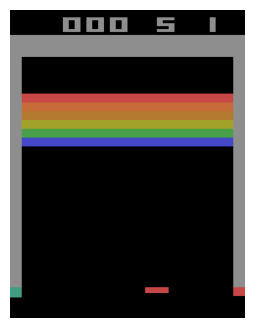

Round reward: 0.0 ep: 204
(210, 160, 3)


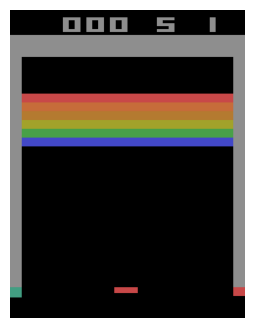

Round reward: 0.0 ep: 204
(210, 160, 3)


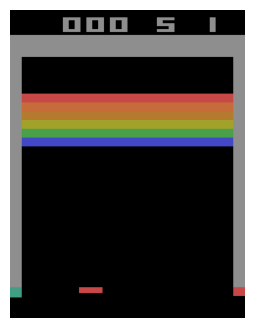

Round reward: 0.0 ep: 204
(210, 160, 3)


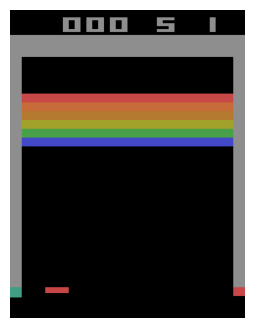

Round reward: 0.0 ep: 204
(210, 160, 3)


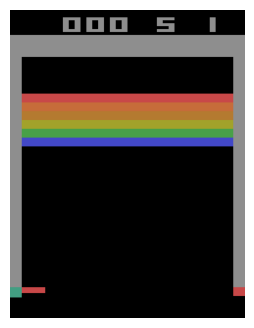

Round reward: 0.0 ep: 204
(210, 160, 3)


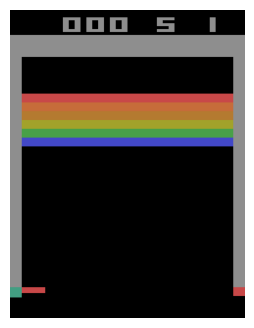

Round reward: 0.0 ep: 204
(210, 160, 3)


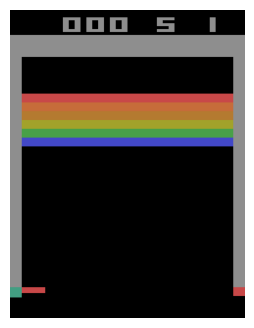

Round reward: 0.0 ep: 204
(210, 160, 3)


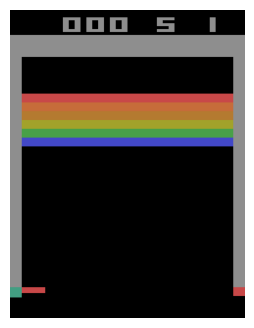

Round reward: 0.0 ep: 204
(210, 160, 3)


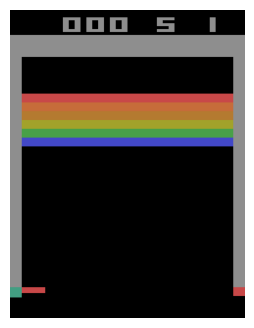

Round reward: 0.0 ep: 204
(210, 160, 3)


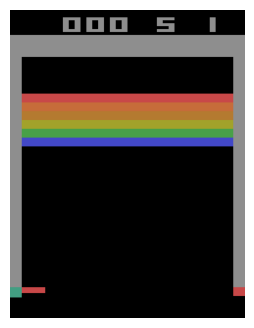

Round reward: 0.0 ep: 204
(210, 160, 3)


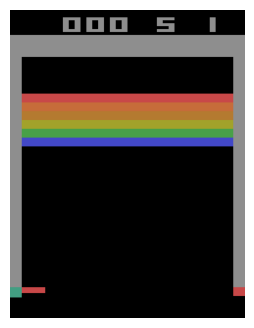

Round reward: 0.0 ep: 204
(210, 160, 3)


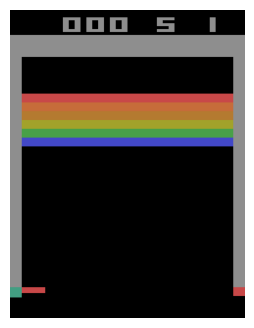

Round reward: 0.0 ep: 204
(210, 160, 3)


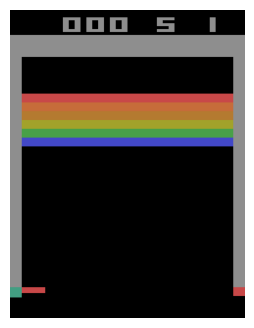

Round reward: 0.0 ep: 204
(210, 160, 3)


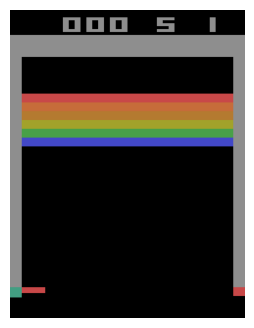

Round reward: 0.0 ep: 204
(210, 160, 3)


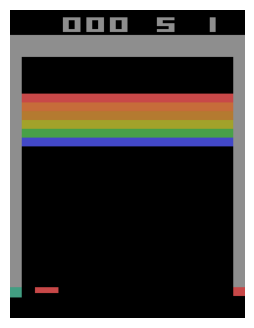

Round reward: 0.0 ep: 204
(210, 160, 3)


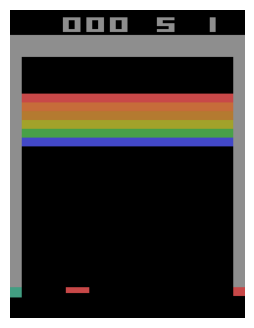

Round reward: 0.0 ep: 204
(210, 160, 3)


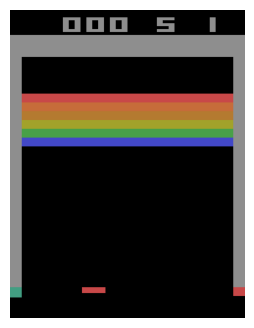

Round reward: 0.0 ep: 204
(210, 160, 3)


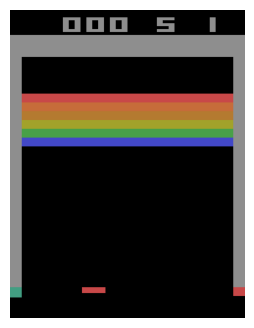

Round reward: 0.0 ep: 204
(210, 160, 3)


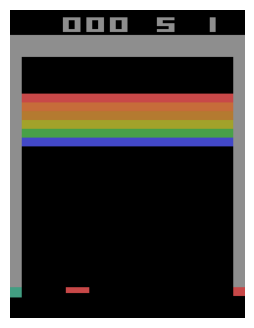

Round reward: 0.0 ep: 204
(210, 160, 3)


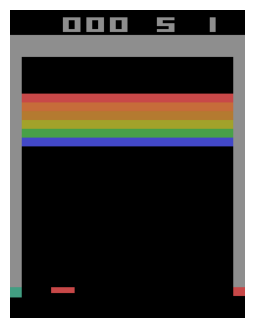

Round reward: 0.0 ep: 204
(210, 160, 3)


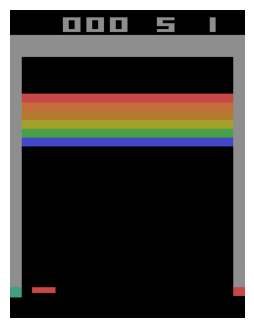

Round reward: 0.0 ep: 204
(210, 160, 3)


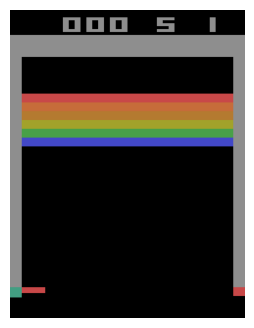

Round reward: 0.0 ep: 204
(210, 160, 3)


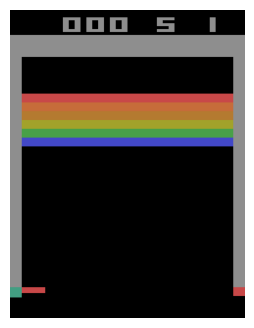

Round reward: 0.0 ep: 204
(210, 160, 3)


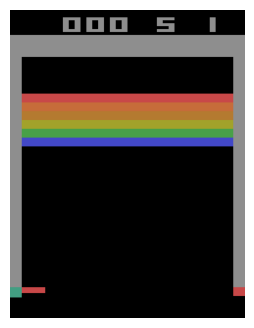

Round reward: 0.0 ep: 204
(210, 160, 3)


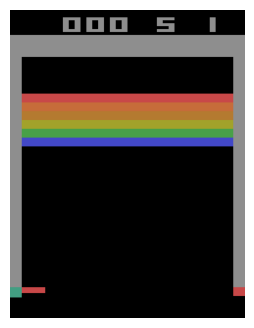

Round reward: 0.0 ep: 204
(210, 160, 3)


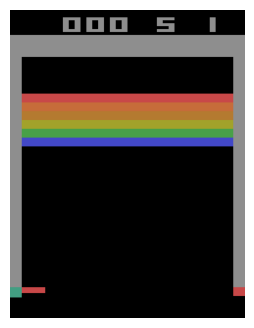

Round reward: 0.0 ep: 204
(210, 160, 3)


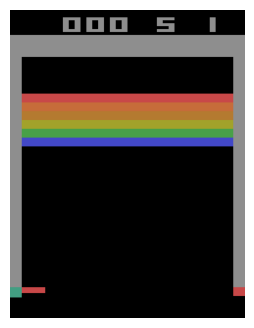

Round reward: 0.0 ep: 204
(210, 160, 3)


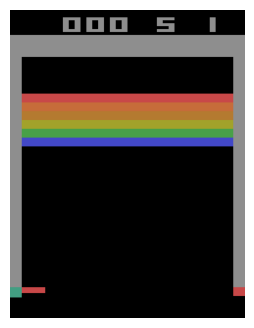

Round reward: 0.0 ep: 204
(210, 160, 3)


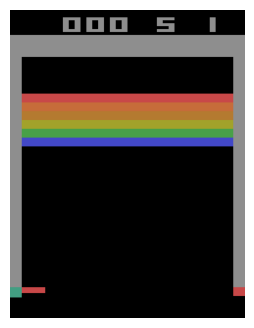

Round reward: 0.0 ep: 204
(210, 160, 3)


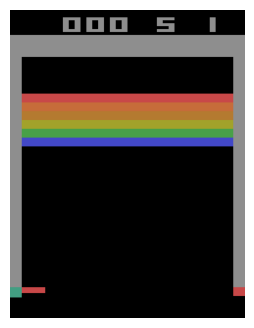

Round reward: 0.0 ep: 204
(210, 160, 3)


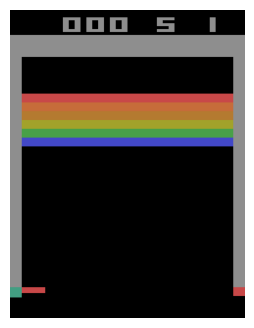

Round reward: 0.0 ep: 204
(210, 160, 3)


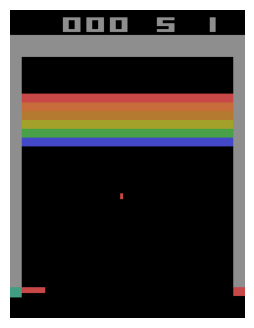

Round reward: 0.0 ep: 204
(210, 160, 3)


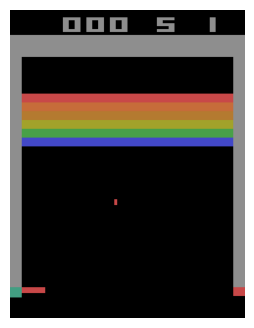

Round reward: 0.0 ep: 204
(210, 160, 3)


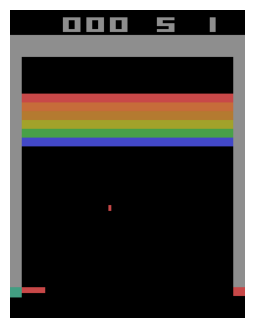

Round reward: 0.0 ep: 204
(210, 160, 3)


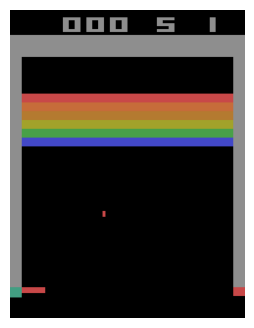

Round reward: 0.0 ep: 204
(210, 160, 3)


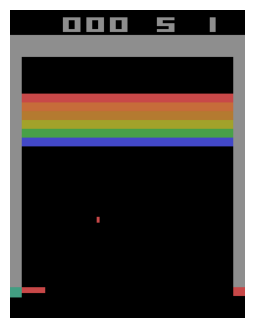

Round reward: 0.0 ep: 204
(210, 160, 3)


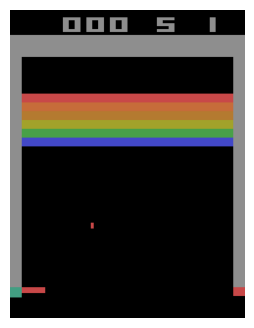

Round reward: 0.0 ep: 204
(210, 160, 3)


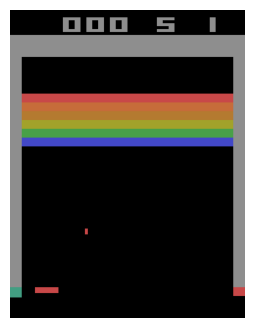

Round reward: 0.0 ep: 204
(210, 160, 3)


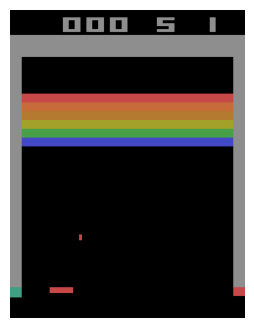

Round reward: 0.0 ep: 204
(210, 160, 3)


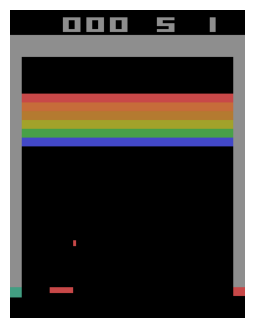

Round reward: 0.0 ep: 204
(210, 160, 3)


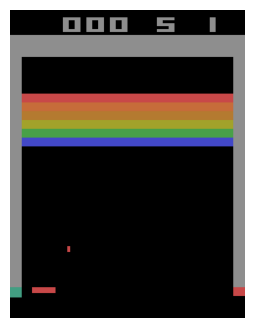

Round reward: 0.0 ep: 204
(210, 160, 3)


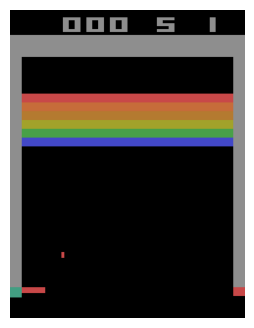

Round reward: 0.0 ep: 204
(210, 160, 3)


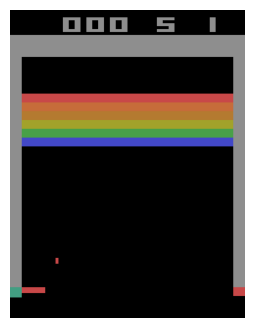

Round reward: 0.0 ep: 204
(210, 160, 3)


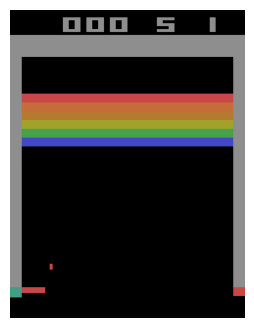

Round reward: 0.0 ep: 204
(210, 160, 3)


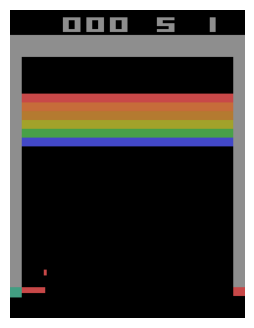

Round reward: 0.0 ep: 204
(210, 160, 3)


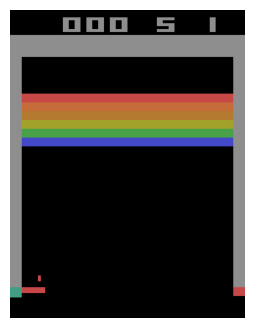

Round reward: 0.0 ep: 204
(210, 160, 3)


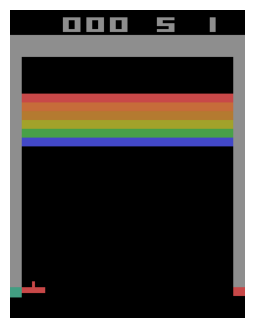

Round reward: 0.0 ep: 204
(210, 160, 3)


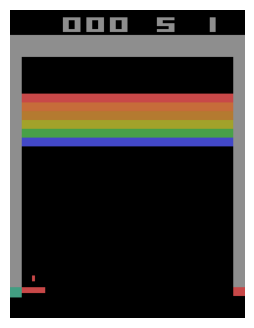

Round reward: 0.0 ep: 204
(210, 160, 3)


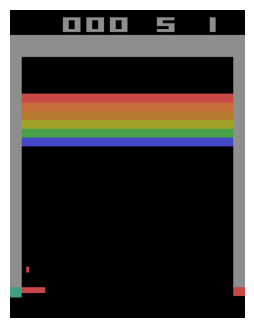

Round reward: 0.0 ep: 204
(210, 160, 3)


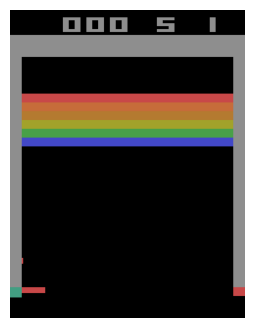

Round reward: 0.0 ep: 204
(210, 160, 3)


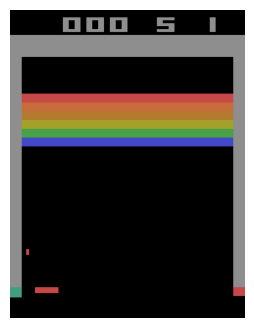

Round reward: 0.0 ep: 204
(210, 160, 3)


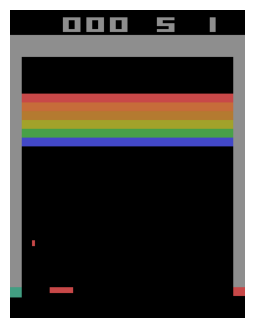

Round reward: 0.0 ep: 204
(210, 160, 3)


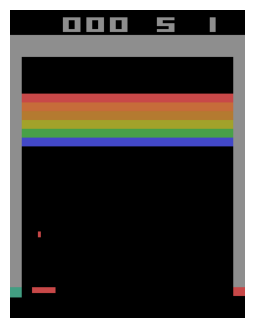

Round reward: 0.0 ep: 204
(210, 160, 3)


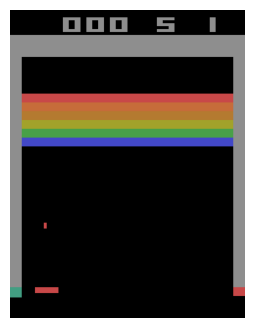

Round reward: 0.0 ep: 204
(210, 160, 3)


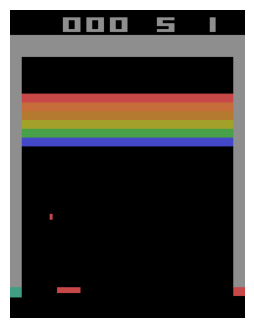

Round reward: 0.0 ep: 204
(210, 160, 3)


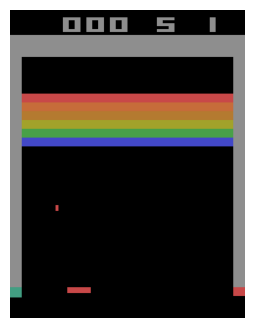

Round reward: 0.0 ep: 204
(210, 160, 3)


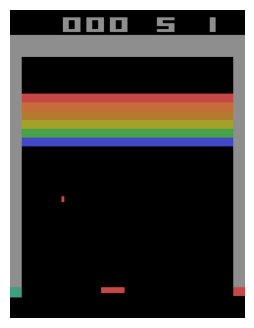

Round reward: 0.0 ep: 204
(210, 160, 3)


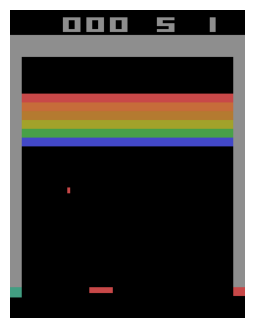

Round reward: 0.0 ep: 204
(210, 160, 3)


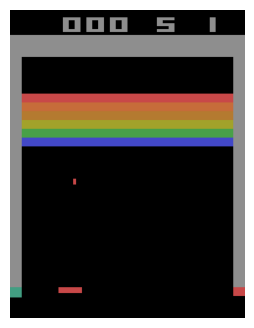

Round reward: 0.0 ep: 204
(210, 160, 3)


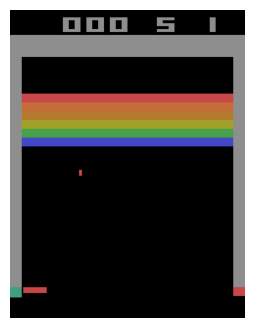

Round reward: 0.0 ep: 204
(210, 160, 3)


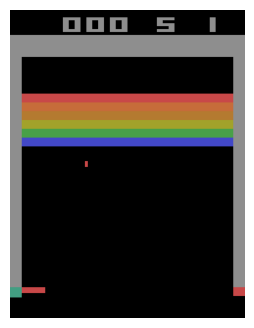

Round reward: 0.0 ep: 204
(210, 160, 3)


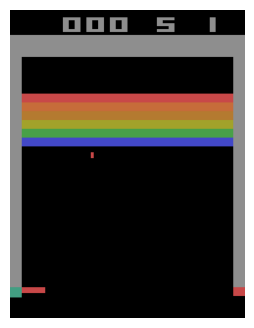

Round reward: 0.0 ep: 204
(210, 160, 3)


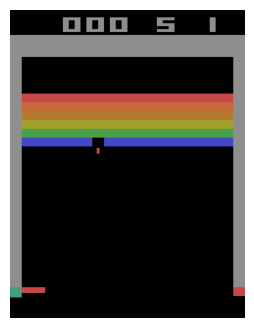

Round reward: 1.0 ep: 204
(210, 160, 3)


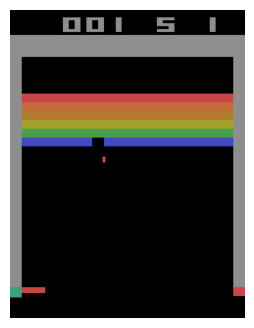

Round reward: 1.0 ep: 204
(210, 160, 3)


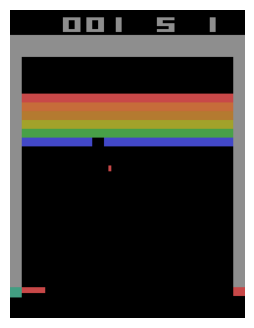

Round reward: 1.0 ep: 204
(210, 160, 3)


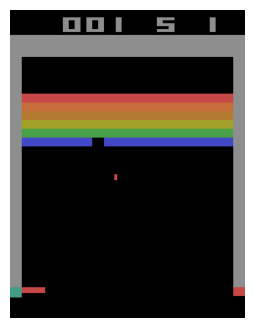

Round reward: 1.0 ep: 204
(210, 160, 3)


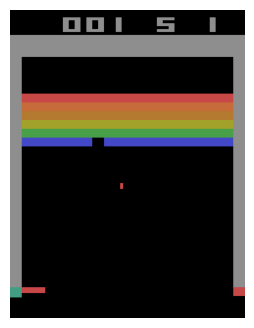

Round reward: 1.0 ep: 204
(210, 160, 3)


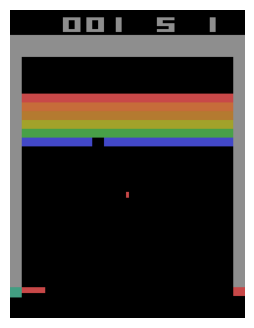

Round reward: 1.0 ep: 204
(210, 160, 3)


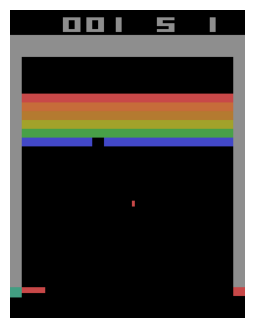

Round reward: 1.0 ep: 204
(210, 160, 3)


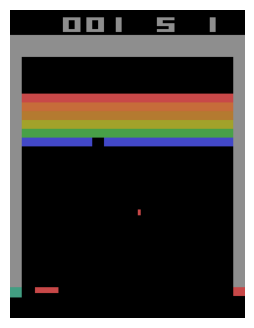

Round reward: 1.0 ep: 204
(210, 160, 3)


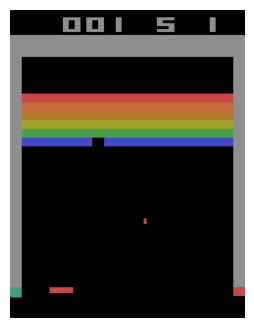

Round reward: 1.0 ep: 204
(210, 160, 3)


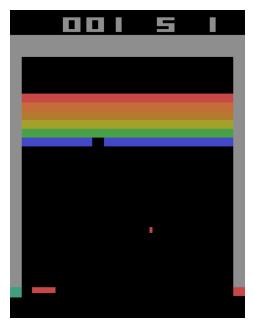

Round reward: 1.0 ep: 204
(210, 160, 3)


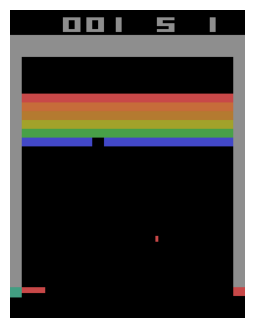

Round reward: 1.0 ep: 204
(210, 160, 3)


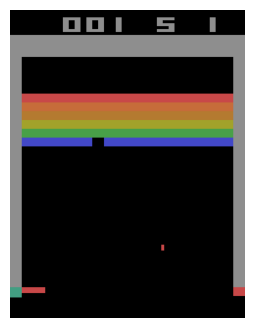

Round reward: 1.0 ep: 204
(210, 160, 3)


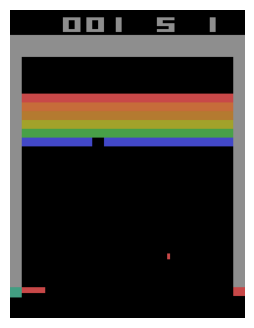

Round reward: 1.0 ep: 204
(210, 160, 3)


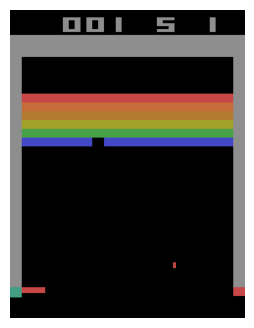

Round reward: 1.0 ep: 204
(210, 160, 3)


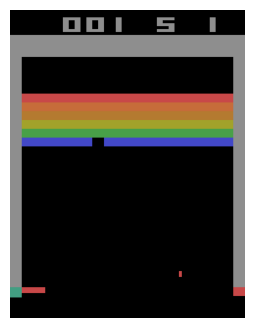

Round reward: 1.0 ep: 204
(210, 160, 3)


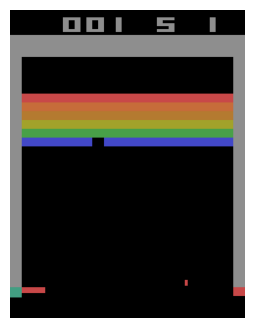

Round reward: 1.0 ep: 204
(210, 160, 3)


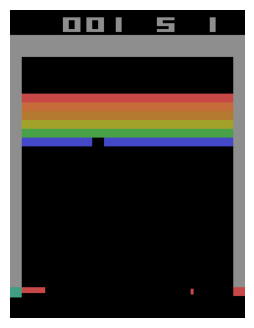

Round reward: 1.0 ep: 204
(210, 160, 3)


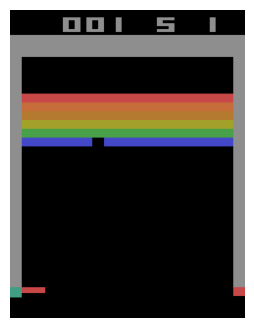

Round reward: 1.0 ep: 204
(210, 160, 3)


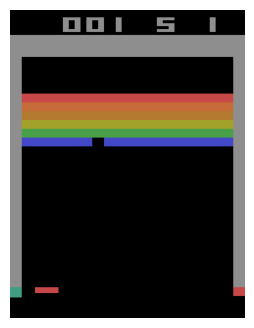

Round reward: 1.0 ep: 204
(210, 160, 3)


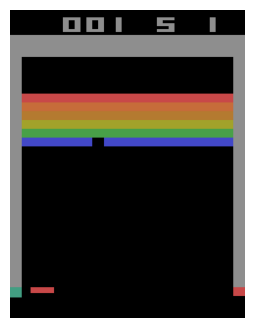

Round reward: 1.0 ep: 204
(210, 160, 3)


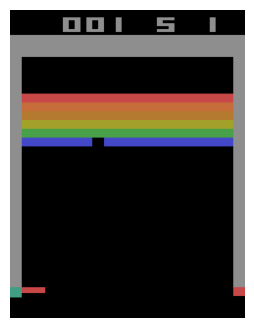

Round reward: 1.0 ep: 204
(210, 160, 3)


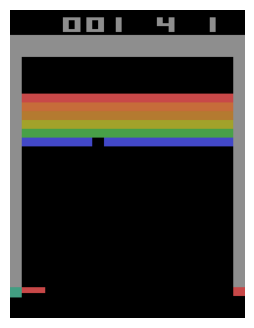

Round reward: 0.6 ep: 204
(210, 160, 3)


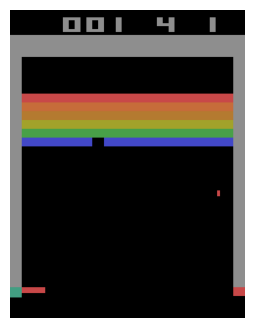

Round reward: 0.6 ep: 204
(210, 160, 3)


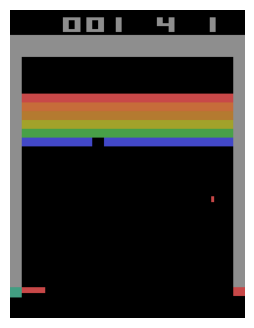

Round reward: 0.6 ep: 204
(210, 160, 3)


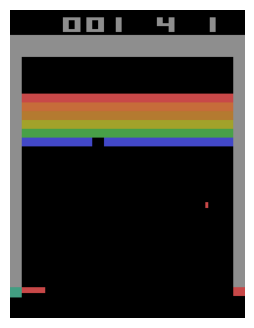

Round reward: 0.6 ep: 204
(210, 160, 3)


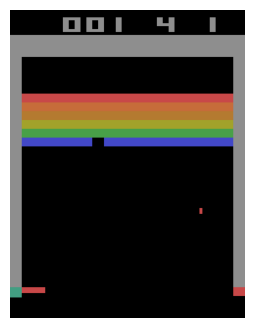

Round reward: 0.6 ep: 204
(210, 160, 3)


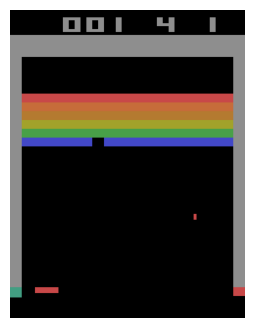

Round reward: 0.6 ep: 204
(210, 160, 3)


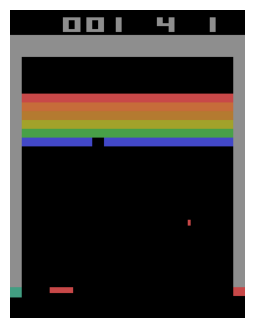

Round reward: 0.6 ep: 204
(210, 160, 3)


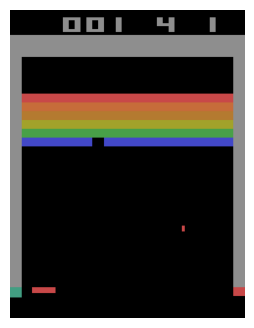

Round reward: 0.6 ep: 204
(210, 160, 3)


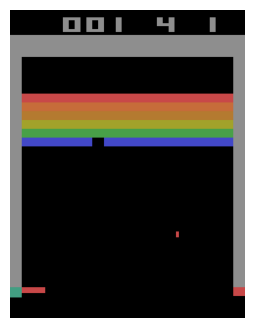

Round reward: 0.6 ep: 204
(210, 160, 3)


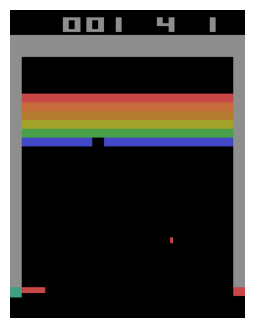

Round reward: 0.6 ep: 204
(210, 160, 3)


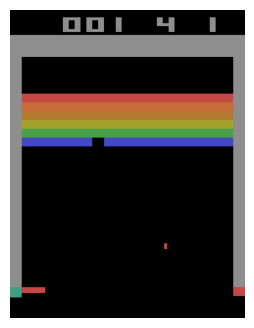

Round reward: 0.6 ep: 204
(210, 160, 3)


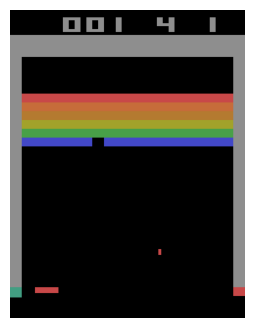

Round reward: 0.6 ep: 204
(210, 160, 3)


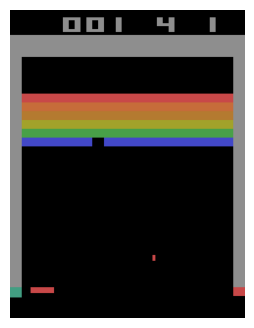

Round reward: 0.6 ep: 204
(210, 160, 3)


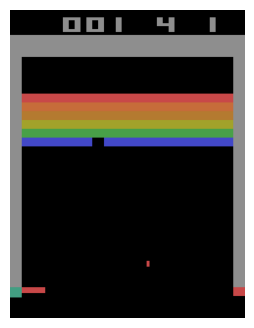

Round reward: 0.6 ep: 204
(210, 160, 3)


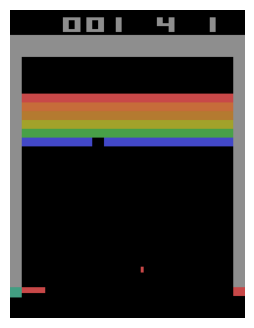

Round reward: 0.6 ep: 204
(210, 160, 3)


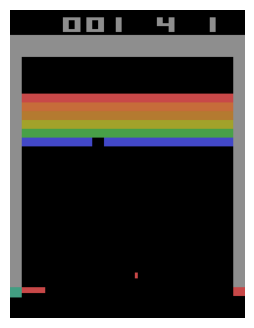

Round reward: 0.6 ep: 204
(210, 160, 3)


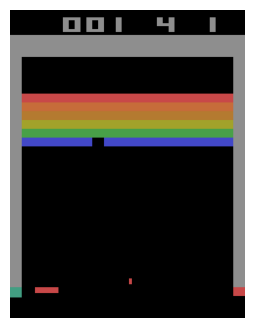

Round reward: 0.6 ep: 204
(210, 160, 3)


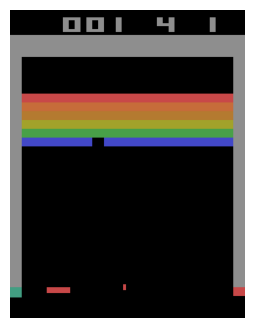

Round reward: 0.6 ep: 204
(210, 160, 3)


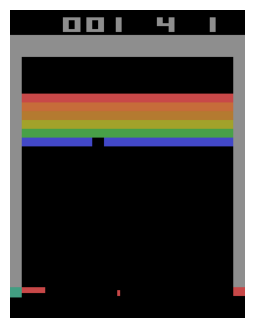

Round reward: 0.6 ep: 204
(210, 160, 3)


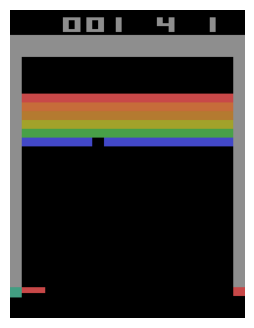

Round reward: 0.6 ep: 204
(210, 160, 3)


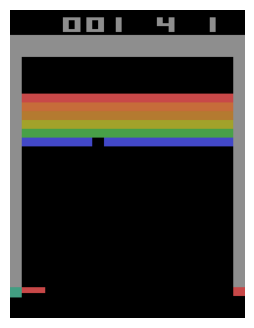

Round reward: 0.6 ep: 204
(210, 160, 3)


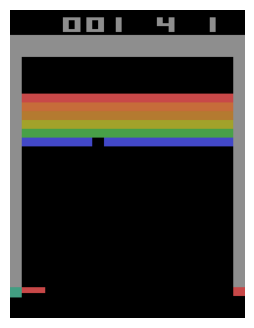

Round reward: 0.6 ep: 204
(210, 160, 3)


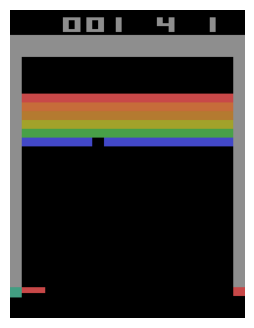

Round reward: 0.6 ep: 204
(210, 160, 3)


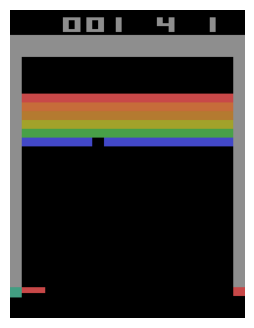

Round reward: 0.6 ep: 204
(210, 160, 3)


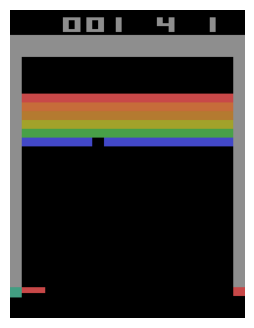

Round reward: 0.6 ep: 204
(210, 160, 3)


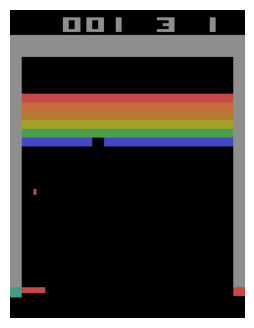

Round reward: 0.2 ep: 204
(210, 160, 3)


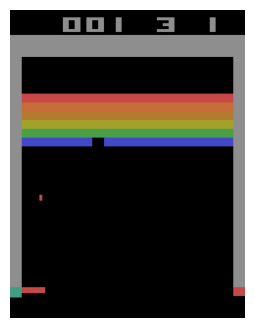

Round reward: 0.2 ep: 204
(210, 160, 3)


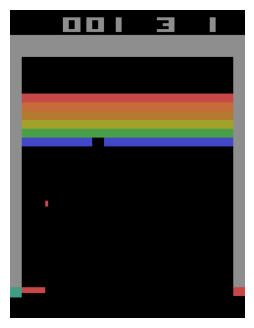

Round reward: 0.2 ep: 204
(210, 160, 3)


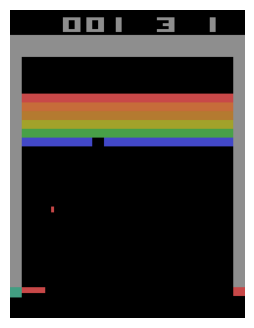

Round reward: 0.2 ep: 204
(210, 160, 3)


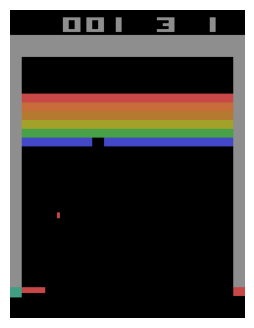

Round reward: 0.2 ep: 204
(210, 160, 3)


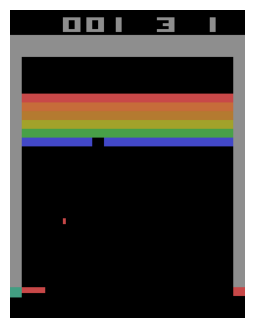

Round reward: 0.2 ep: 204
(210, 160, 3)


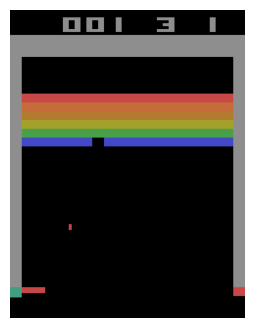

Round reward: 0.2 ep: 204
(210, 160, 3)


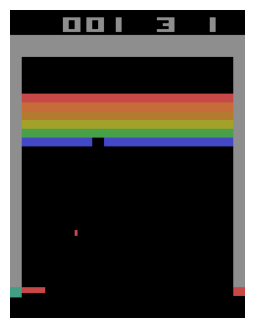

Round reward: 0.2 ep: 204
(210, 160, 3)


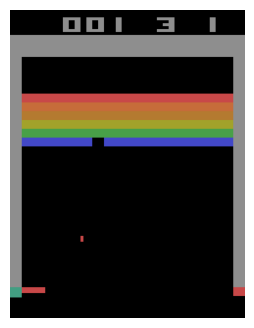

Round reward: 0.2 ep: 204
(210, 160, 3)


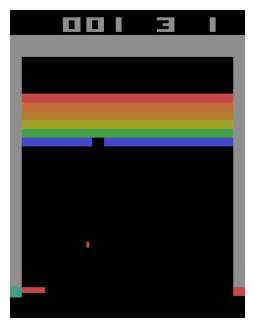

Round reward: 0.2 ep: 204
(210, 160, 3)


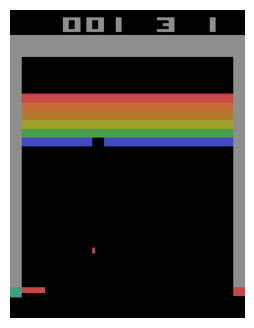

Round reward: 0.2 ep: 204
(210, 160, 3)


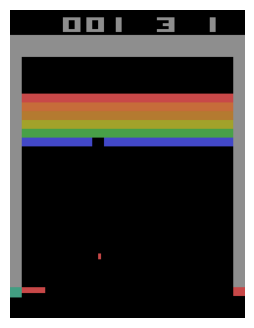

Round reward: 0.2 ep: 204
(210, 160, 3)


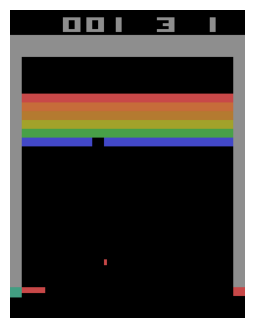

Round reward: 0.2 ep: 204
(210, 160, 3)


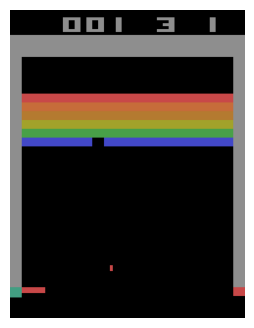

Round reward: 0.2 ep: 204
(210, 160, 3)


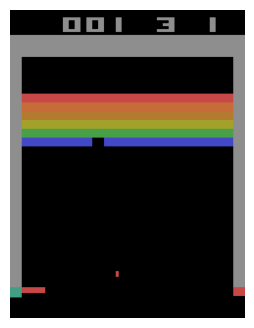

Round reward: 0.2 ep: 204
(210, 160, 3)


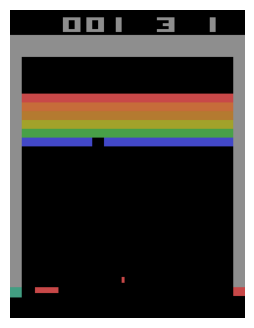

Round reward: 0.2 ep: 204
(210, 160, 3)


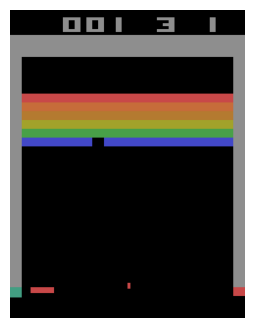

Round reward: 0.2 ep: 204
(210, 160, 3)


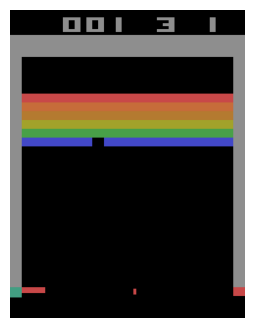

Round reward: 0.2 ep: 204
(210, 160, 3)


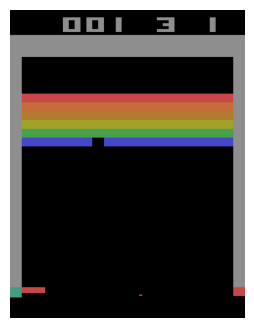

Round reward: 0.2 ep: 204
(210, 160, 3)


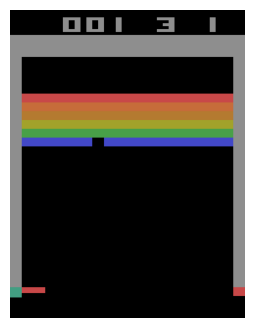

Round reward: 0.2 ep: 204
(210, 160, 3)


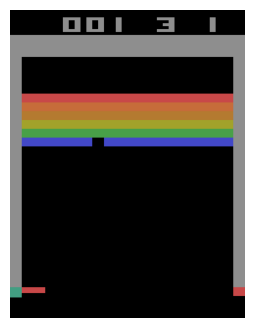

Round reward: 0.2 ep: 204
(210, 160, 3)


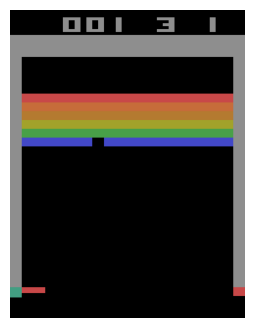

Round reward: 0.2 ep: 204
(210, 160, 3)


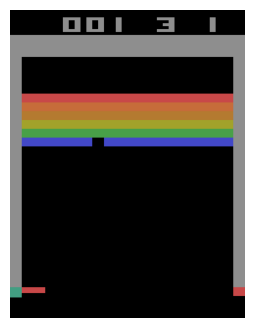

Round reward: 0.2 ep: 204
(210, 160, 3)


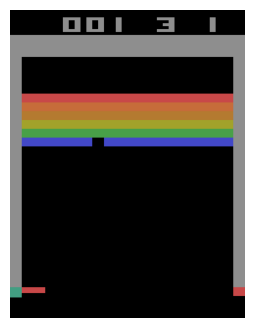

Round reward: 0.2 ep: 204
(210, 160, 3)


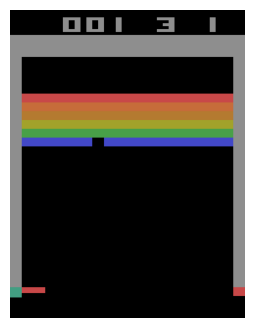

Round reward: -0.2 ep: 204
(210, 160, 3)


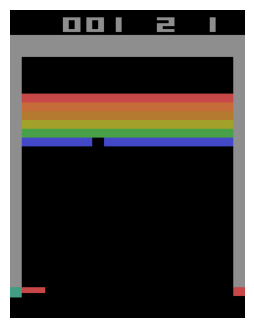

Round reward: -0.2 ep: 204
(210, 160, 3)


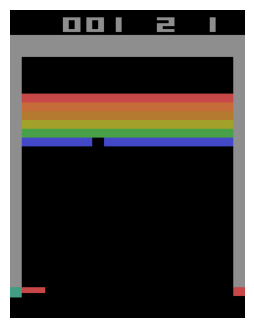

Round reward: -0.2 ep: 204
(210, 160, 3)


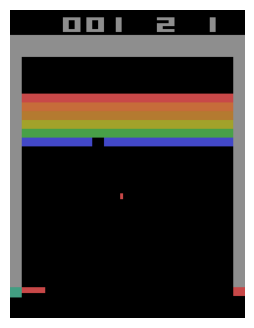

Round reward: -0.2 ep: 204
(210, 160, 3)


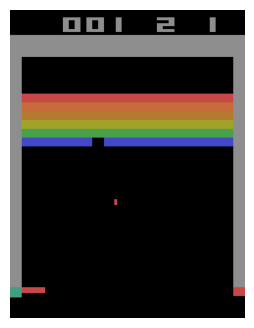

Round reward: -0.2 ep: 204
(210, 160, 3)


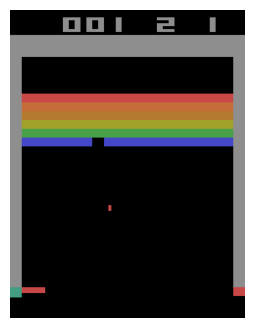

Round reward: -0.2 ep: 204
(210, 160, 3)


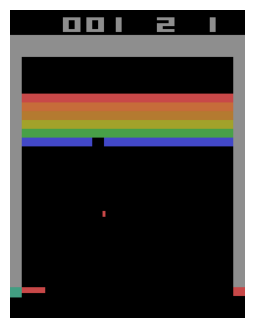

Round reward: -0.2 ep: 204
(210, 160, 3)


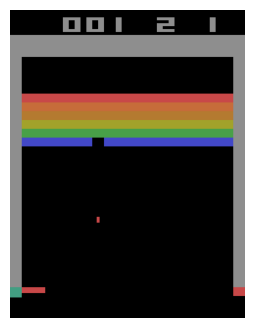

Round reward: -0.2 ep: 204
(210, 160, 3)


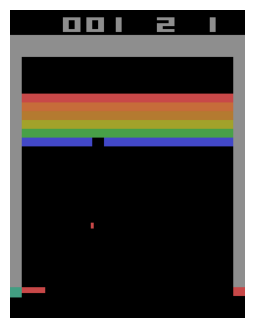

Round reward: -0.2 ep: 204
(210, 160, 3)


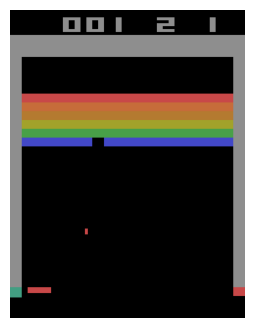

Round reward: -0.2 ep: 204
(210, 160, 3)


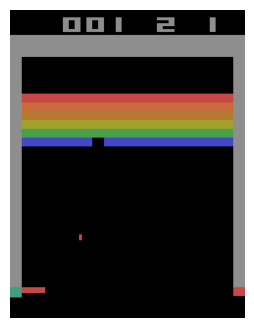

Round reward: -0.2 ep: 204
(210, 160, 3)


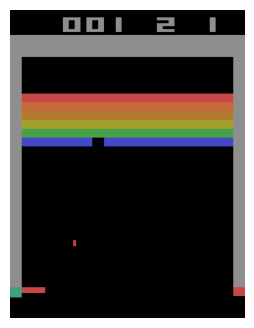

Round reward: -0.2 ep: 204
(210, 160, 3)


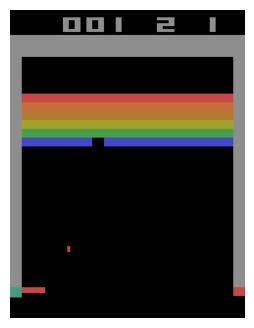

Round reward: -0.2 ep: 204
(210, 160, 3)


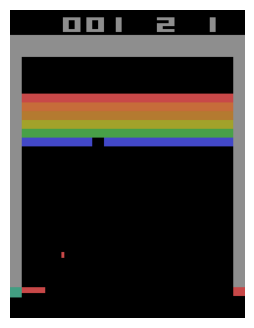

Round reward: -0.2 ep: 204
(210, 160, 3)


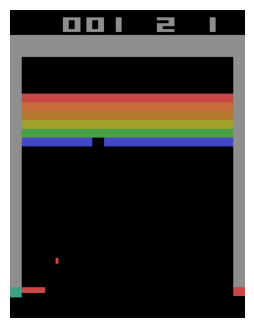

Round reward: -0.2 ep: 204
(210, 160, 3)


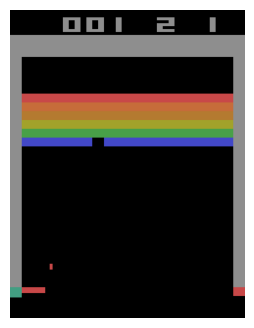

Round reward: -0.2 ep: 204
(210, 160, 3)


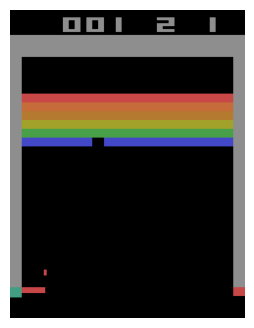

Round reward: -0.2 ep: 204
(210, 160, 3)


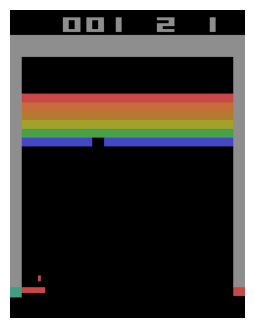

Round reward: -0.2 ep: 204
(210, 160, 3)


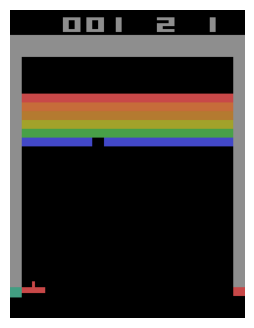

Round reward: -0.2 ep: 204
(210, 160, 3)


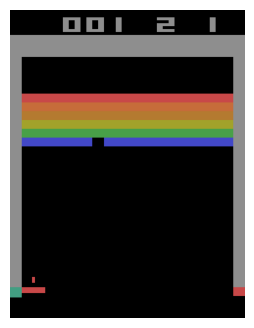

Round reward: -0.2 ep: 204
(210, 160, 3)


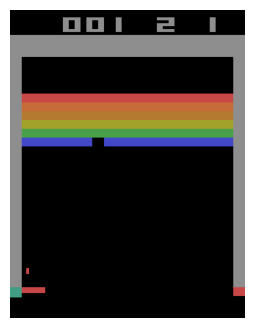

Round reward: -0.2 ep: 204
(210, 160, 3)


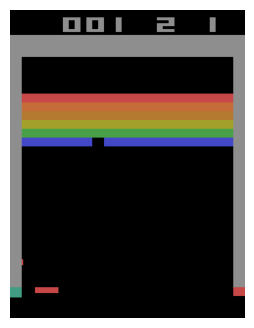

Round reward: -0.2 ep: 204
(210, 160, 3)


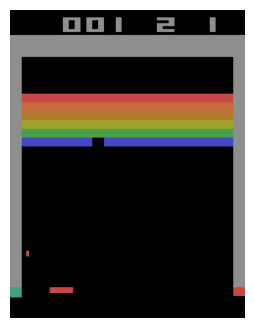

Round reward: -0.2 ep: 204
(210, 160, 3)


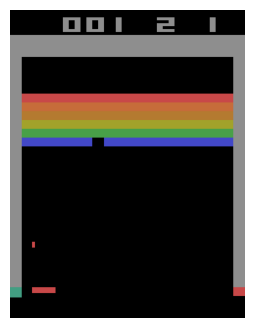

Round reward: -0.2 ep: 204
(210, 160, 3)


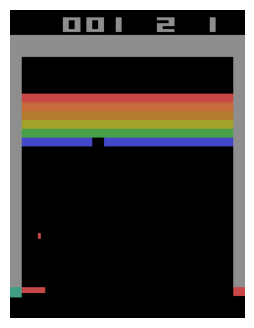

Round reward: -0.2 ep: 204
(210, 160, 3)


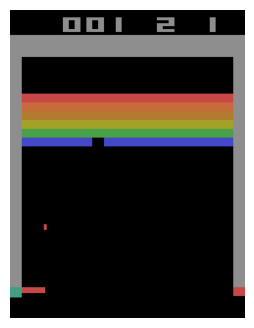

Round reward: -0.2 ep: 204
(210, 160, 3)


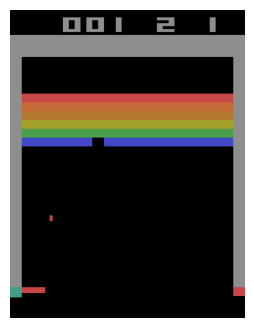

Round reward: -0.2 ep: 204
(210, 160, 3)


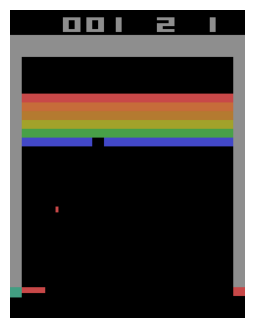

Round reward: -0.2 ep: 204
(210, 160, 3)


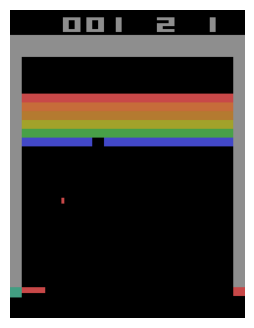

Round reward: -0.2 ep: 204
(210, 160, 3)


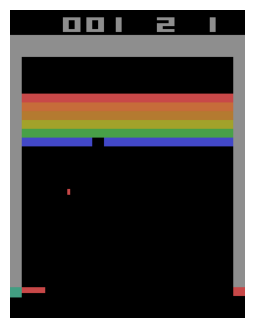

Round reward: -0.2 ep: 204
(210, 160, 3)


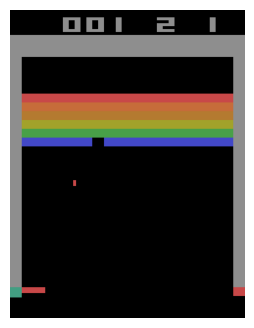

Round reward: -0.2 ep: 204
(210, 160, 3)


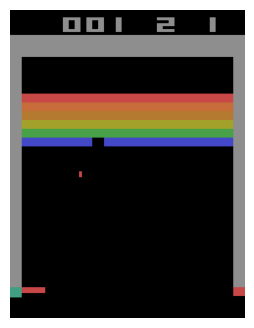

Round reward: -0.2 ep: 204
(210, 160, 3)


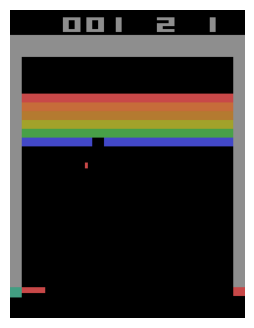

Round reward: -0.2 ep: 204
(210, 160, 3)


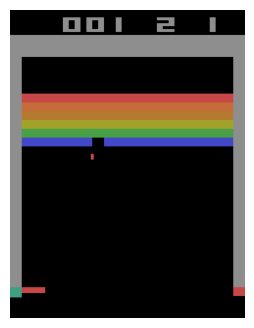

Round reward: -0.2 ep: 204
(210, 160, 3)


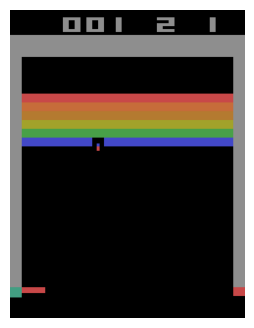

Round reward: -0.2 ep: 204
(210, 160, 3)


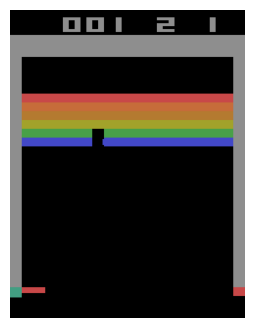

Round reward: 0.8 ep: 204
(210, 160, 3)


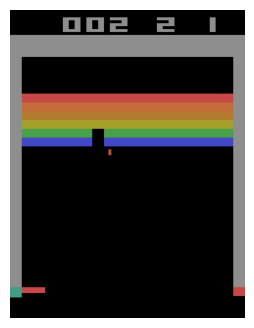

Round reward: 0.8 ep: 204
(210, 160, 3)


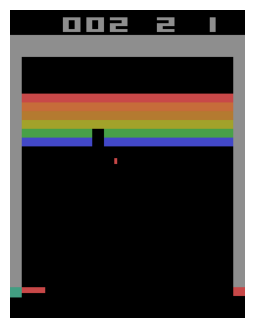

Round reward: 0.8 ep: 204
(210, 160, 3)


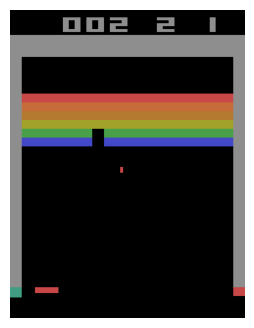

Round reward: 0.8 ep: 204
(210, 160, 3)


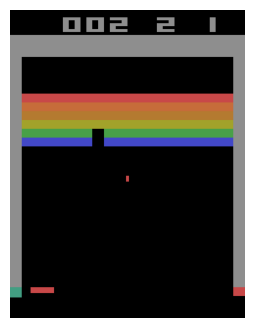

Round reward: 0.8 ep: 204
(210, 160, 3)


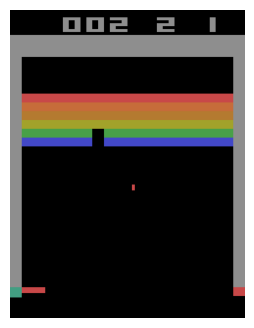

Round reward: 0.8 ep: 204
(210, 160, 3)


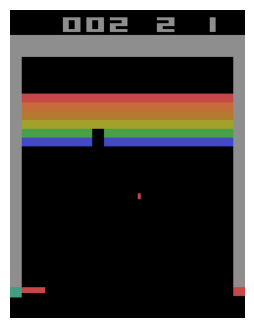

Round reward: 0.8 ep: 204
(210, 160, 3)


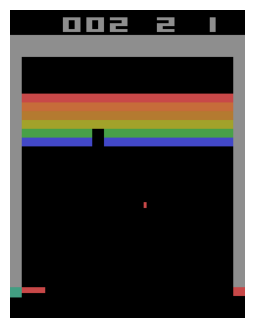

Round reward: 0.8 ep: 204
(210, 160, 3)


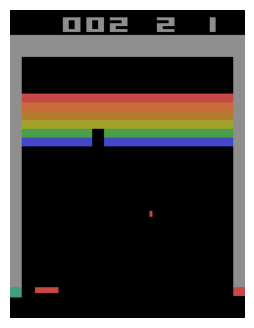

Round reward: 0.8 ep: 204
(210, 160, 3)


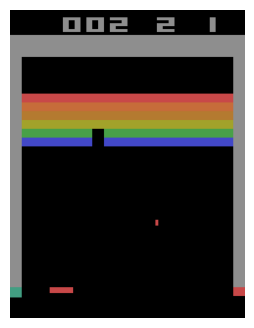

Round reward: 0.8 ep: 204
(210, 160, 3)


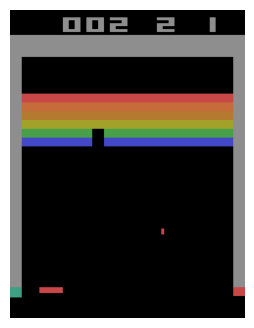

Round reward: 0.8 ep: 204
(210, 160, 3)


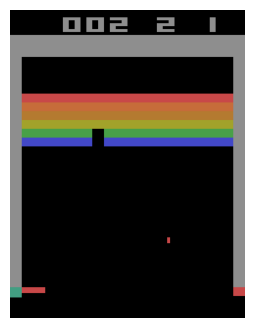

Round reward: 0.8 ep: 204
(210, 160, 3)


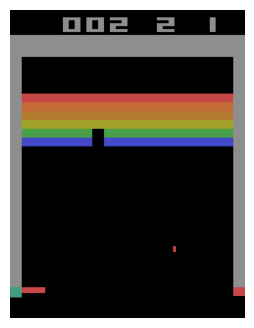

Round reward: 0.8 ep: 204
(210, 160, 3)


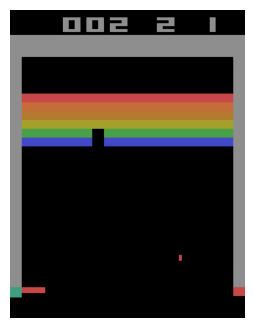

Round reward: 0.8 ep: 204
(210, 160, 3)


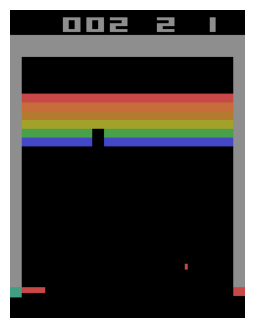

Round reward: 0.8 ep: 204
(210, 160, 3)


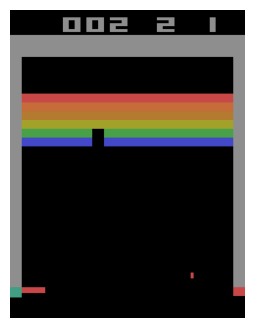

Round reward: 0.8 ep: 204
(210, 160, 3)


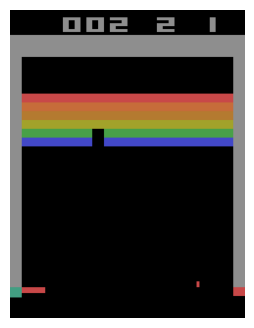

Round reward: 0.8 ep: 204
(210, 160, 3)


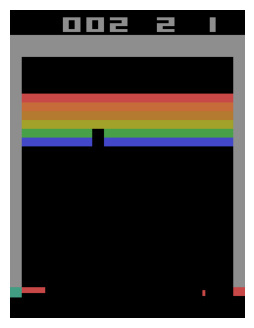

Round reward: 0.8 ep: 204
(210, 160, 3)


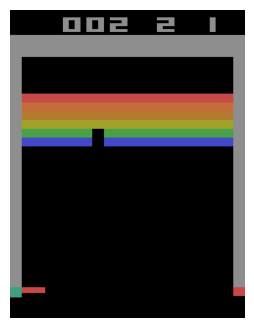

Round reward: 0.8 ep: 204
(210, 160, 3)


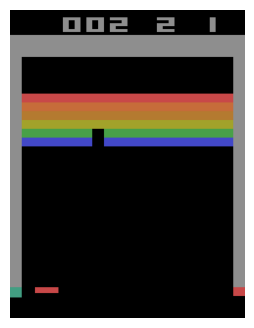

Round reward: 0.8 ep: 204
(210, 160, 3)


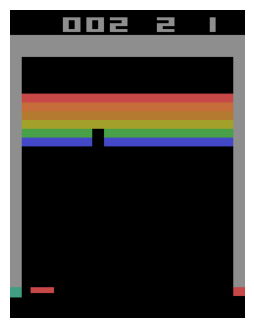

Round reward: 0.8 ep: 204
(210, 160, 3)


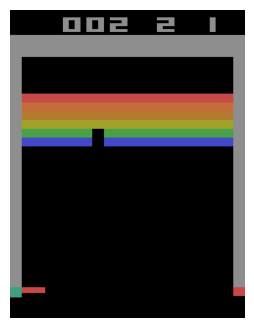

Round reward: 0.8 ep: 204
(210, 160, 3)


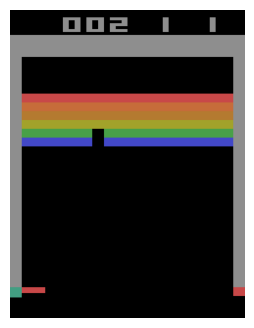

Round reward: 0.4 ep: 204
(210, 160, 3)


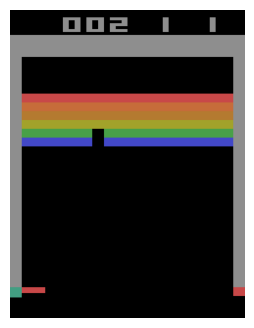

Round reward: 0.4 ep: 204
(210, 160, 3)


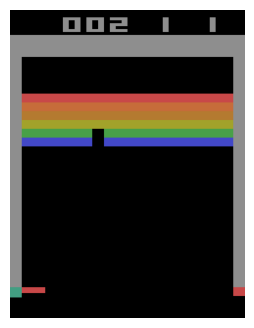

Round reward: 0.4 ep: 204
(210, 160, 3)


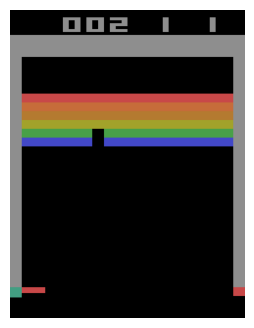

Round reward: 0.4 ep: 204
(210, 160, 3)


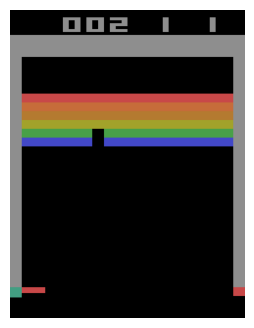

Round reward: 0.4 ep: 204
(210, 160, 3)


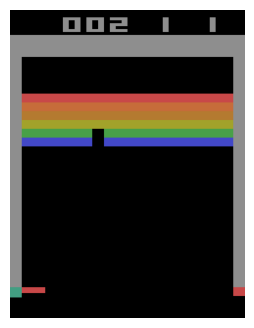

Round reward: 0.4 ep: 204
(210, 160, 3)


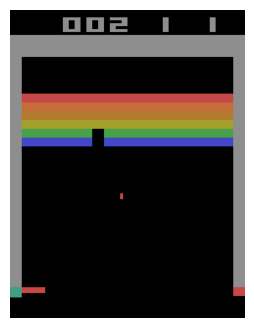

Round reward: 0.4 ep: 204
(210, 160, 3)


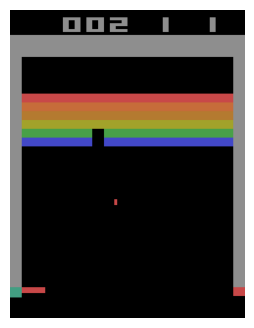

Round reward: 0.4 ep: 204
(210, 160, 3)


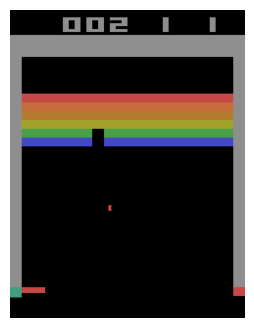

Round reward: 0.4 ep: 204
(210, 160, 3)


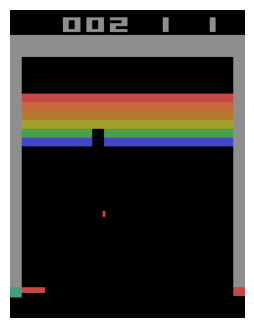

Round reward: 0.4 ep: 204
(210, 160, 3)


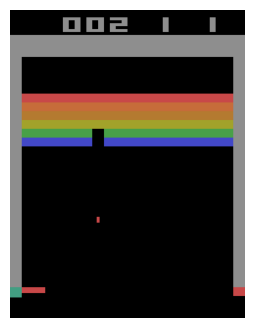

Round reward: 0.4 ep: 204
(210, 160, 3)


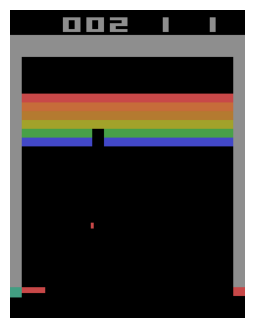

Round reward: 0.4 ep: 204
(210, 160, 3)


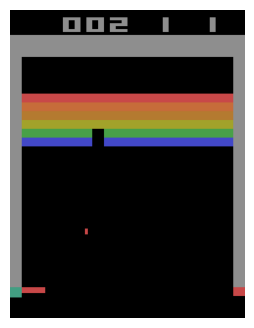

Round reward: 0.4 ep: 204
(210, 160, 3)


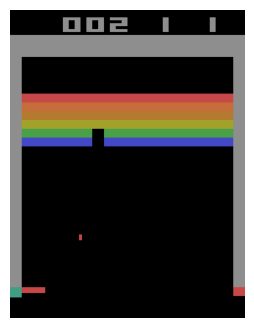

Round reward: 0.4 ep: 204
(210, 160, 3)


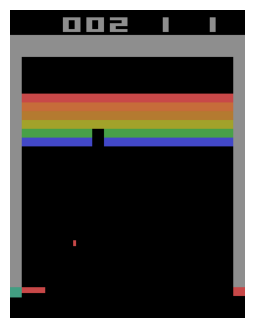

Round reward: 0.4 ep: 204
(210, 160, 3)


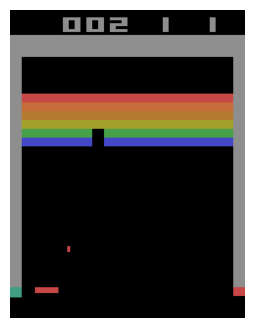

Round reward: 0.4 ep: 204
(210, 160, 3)


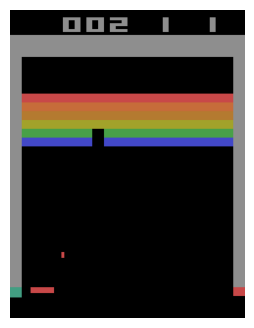

Round reward: 0.4 ep: 204
(210, 160, 3)


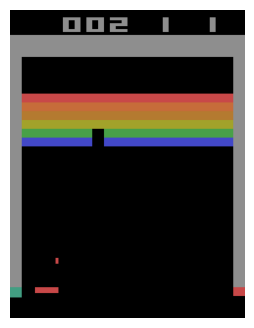

Round reward: 0.4 ep: 204
(210, 160, 3)


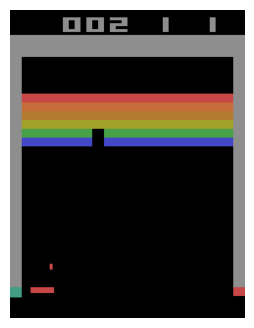

Round reward: 0.4 ep: 204
(210, 160, 3)


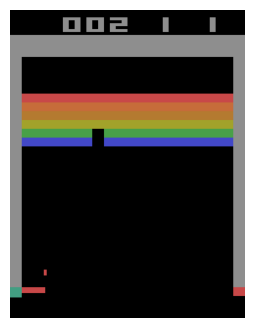

Round reward: 0.4 ep: 204
(210, 160, 3)


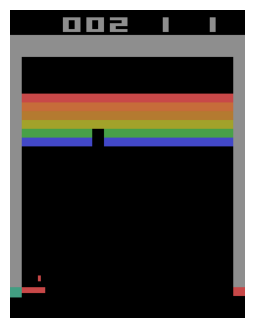

Round reward: 0.4 ep: 204
(210, 160, 3)


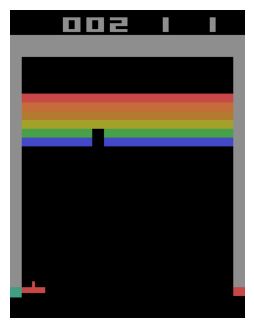

Round reward: 0.4 ep: 204
(210, 160, 3)


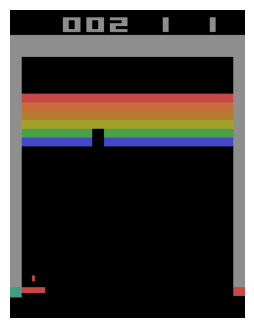

Round reward: 0.4 ep: 204
(210, 160, 3)


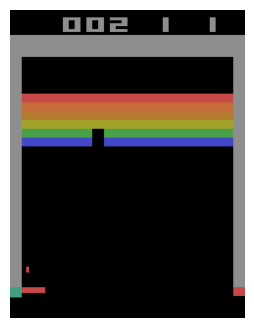

Round reward: 0.4 ep: 204
(210, 160, 3)


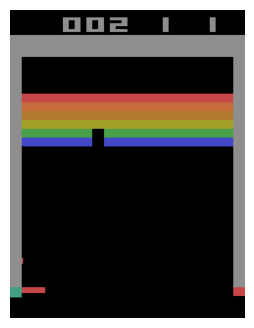

Round reward: 0.4 ep: 204
(210, 160, 3)


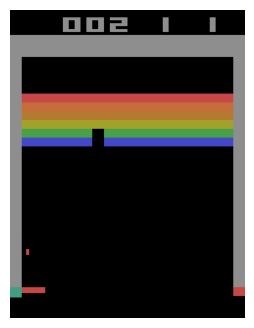

Round reward: 0.4 ep: 204
(210, 160, 3)


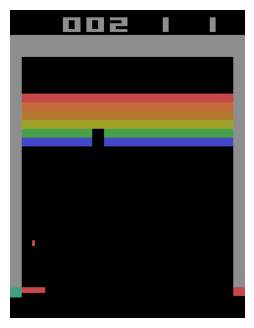

Round reward: 0.4 ep: 204
(210, 160, 3)


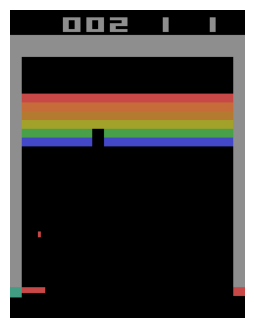

Round reward: 0.4 ep: 204
(210, 160, 3)


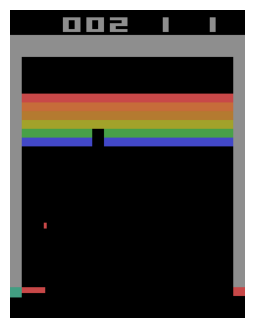

Round reward: 0.4 ep: 204
(210, 160, 3)


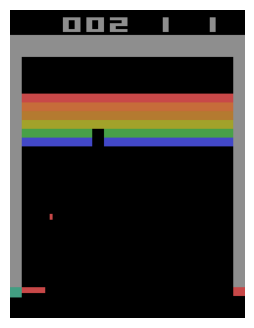

Round reward: 0.4 ep: 204
(210, 160, 3)


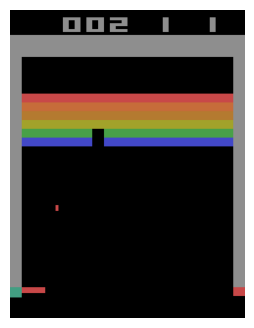

Round reward: 0.4 ep: 204
(210, 160, 3)


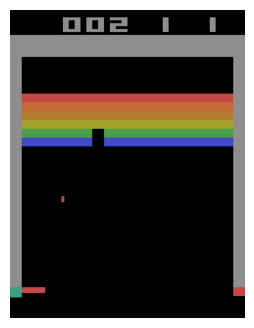

Round reward: 0.4 ep: 204
(210, 160, 3)


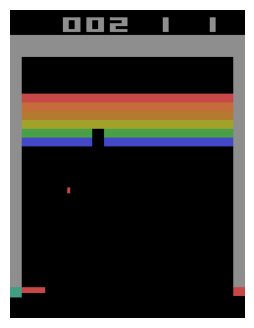

Round reward: 0.4 ep: 204
(210, 160, 3)


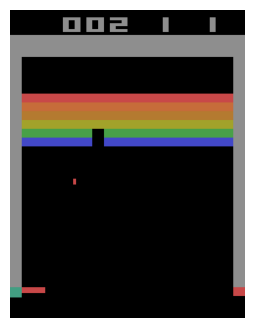

Round reward: 0.4 ep: 204
(210, 160, 3)


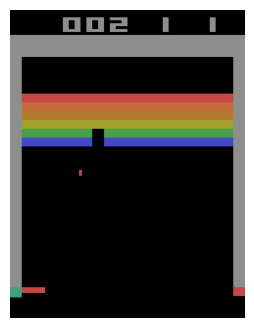

Round reward: 0.4 ep: 204
(210, 160, 3)


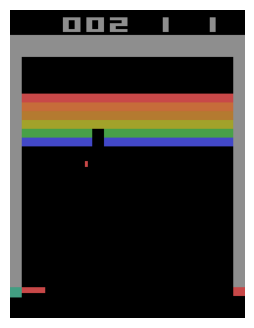

Round reward: 0.4 ep: 204
(210, 160, 3)


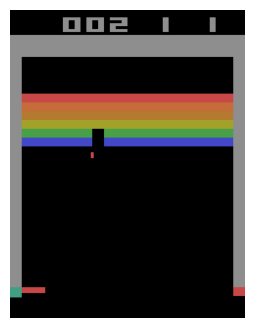

Round reward: 0.4 ep: 204
(210, 160, 3)


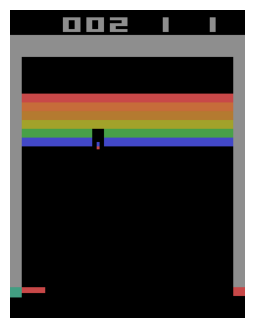

Round reward: 0.4 ep: 204
(210, 160, 3)


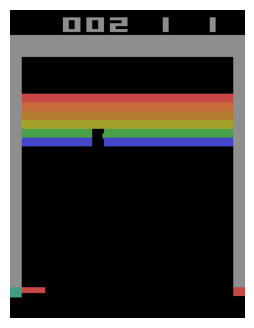

Round reward: 0.4 ep: 204
(210, 160, 3)


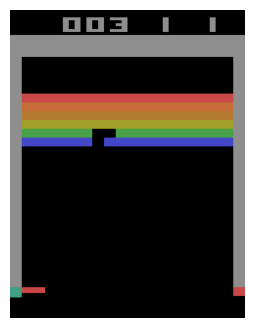

Round reward: 1.4 ep: 204
(210, 160, 3)


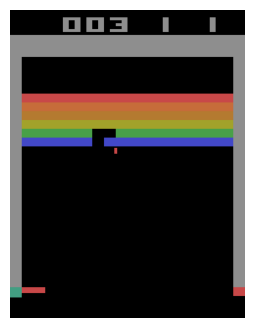

Round reward: 1.4 ep: 204
(210, 160, 3)


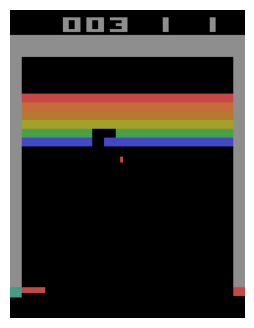

Round reward: 1.4 ep: 204
(210, 160, 3)


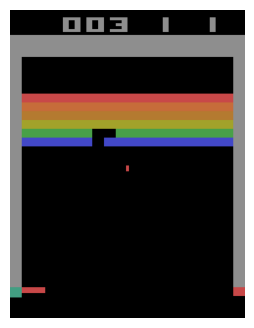

Round reward: 1.4 ep: 204
(210, 160, 3)


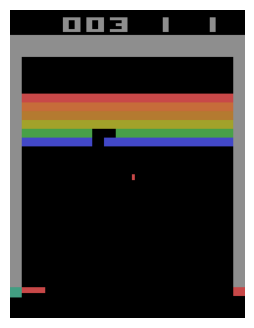

Round reward: 1.4 ep: 204
(210, 160, 3)


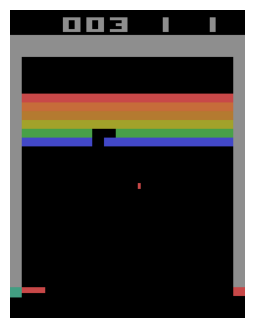

Round reward: 1.4 ep: 204
(210, 160, 3)


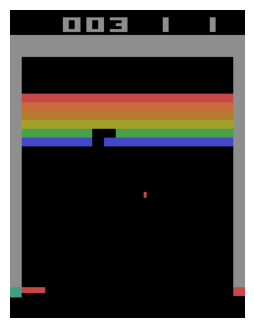

Round reward: 1.4 ep: 204
(210, 160, 3)


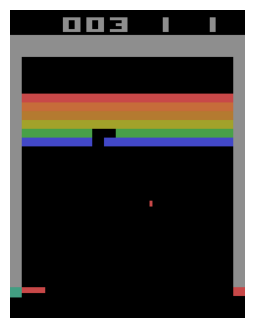

Round reward: 1.4 ep: 204
(210, 160, 3)


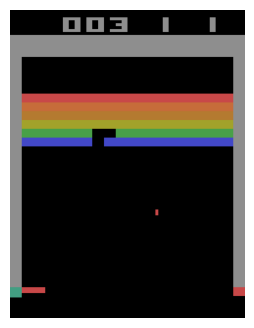

Round reward: 1.4 ep: 204
(210, 160, 3)


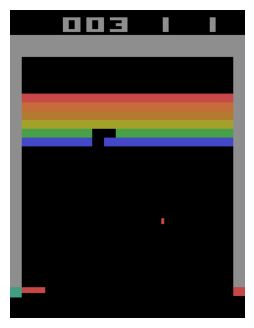

Round reward: 1.4 ep: 204
(210, 160, 3)


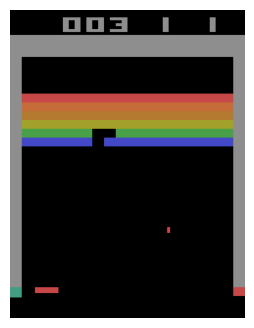

Round reward: 1.4 ep: 204
(210, 160, 3)


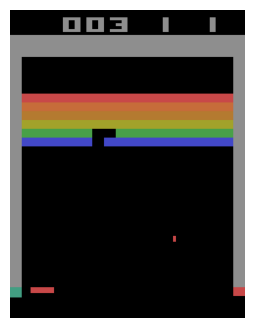

Round reward: 1.4 ep: 204
(210, 160, 3)


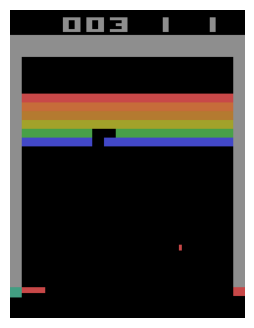

Round reward: 1.4 ep: 204
(210, 160, 3)


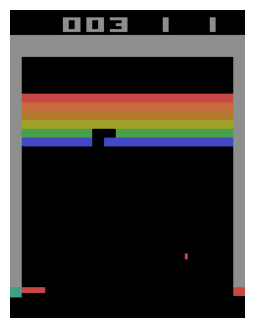

Round reward: 1.4 ep: 204
(210, 160, 3)


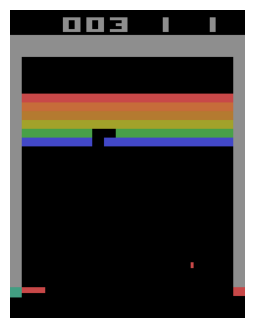

Round reward: 1.4 ep: 204
(210, 160, 3)


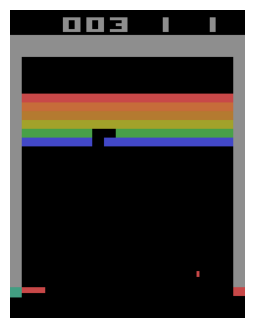

Round reward: 1.4 ep: 204
(210, 160, 3)


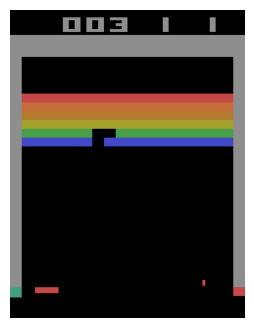

Round reward: 1.4 ep: 204
(210, 160, 3)


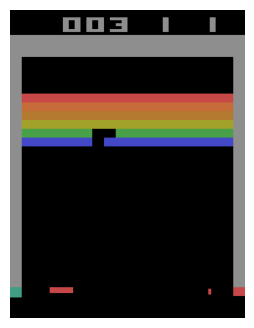

Round reward: 1.4 ep: 204
(210, 160, 3)


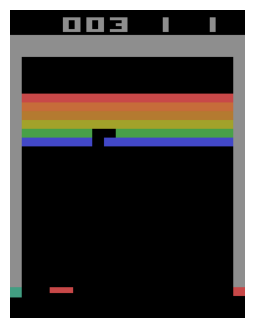

Round reward: 1.4 ep: 204
(210, 160, 3)


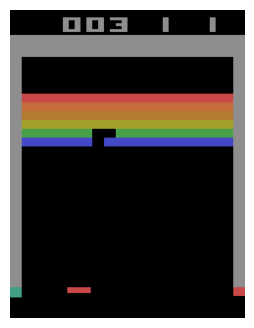

Round reward: 1.4 ep: 204
(210, 160, 3)


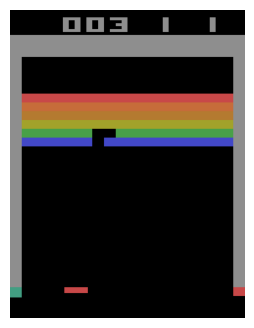

Round reward: 1.4 ep: 204
(210, 160, 3)


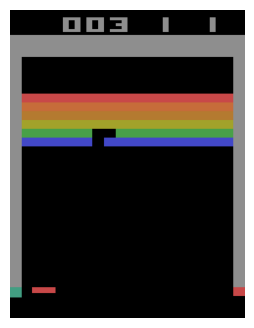

Round reward: 1.4 ep: 204
(210, 160, 3)


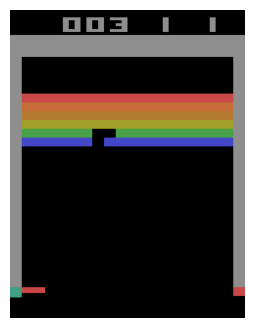

Round reward: 1.0 ep: 204
Episode: 205, Steps: 251 Reward:1.0 Epsilon: 0.41714285714285715

loss: 0.015362500213086605
Episode: 206, Steps: 340 Reward:6.0 Epsilon: 0.41428571428571426

loss: 0.030830468982458115
Episode: 207, Steps: 311 Reward:5.0 Epsilon: 0.4114285714285715

loss: 0.04598750174045563
Episode: 208, Steps: 310 Reward:2.0 Epsilon: 0.4085714285714286

loss: 0.038331251591444016
Episode: 209, Steps: 214 Reward:0.0 Epsilon: 0.4057142857142857

loss: 0.13145390152931213
Episode: 210, Steps: 320 Reward:5.0 Epsilon: 0.4028571428571428

loss: 0.030830468982458115
Episode: 211, Steps: 304 Reward:3.0 Epsilon: 0.4

loss: 0.038331251591444016
Episode: 212, Steps: 307 Reward:1.0 Epsilon: 0.39714285714285713

loss: 0.038331251591444016
Episode: 213, Steps: 256 Reward:1.0 Epsilon: 0.39428571428571424

loss: 0.04598750174045563
Episode: 214, Steps: 247 Reward:0.0 Epsilon: 0.39142857142857146

loss: 0.04598750174045563
Episode: 215, Steps: 313 Reward:5.0 Epsilon: 0.38857142857142857

lo

In [ ]:
TARGET_UPDATE_FREQ = 30 # so target is always updated
TARGET_UPDATE_CONT = 0
PLAY_FREQ = 50
PLAY_CONT = 0
epsilon_div = 350
#if this breaks(fixing target updates, just change it to be using only action model as that is already what its doing)
for episode in range(EPISODES):
  obs, info = env.reset()
  last_lives = info["lives"]
  total_reward = 0
  for step in range(STEPS_PER_EP):
    epsilon = max(1 - episode / (epsilon_div), EPSILON)
    if episode < (150):
      epsilon = .9
    obs, reward, done, truncated, info, step_action = play_one_step(env, obs, epsilon)
    if info["lives"] < last_lives:#punishment for dying, actually improves the maximum and avg score
      reward -= .4

    reward = round(reward, 1)
    last_lives = info["lives"]
    total_reward += reward
    total_reward = round(total_reward, 1)
    if PLAY_CONT > PLAY_FREQ:
      plot_environment_state(env)
      plt.show()
      print(f"Round reward: {total_reward} ep: {episode}")
      if info["lives"] == 0:
        PLAY_CONT = 0
    if done or truncated:
      break
  print(f"\rEpisode: {episode + 1}, Steps: {step + 1} Reward:{total_reward} Epsilon: {epsilon}\n")
  rewards.append(total_reward)
  PLAY_CONT += 1
  if episode > 3:
    training_step()
  TARGET_UPDATE_CONT += 1
  if TARGET_UPDATE_CONT > TARGET_UPDATE_FREQ:
    print("\nUpdate targets\n")
    target_model.set_weights(action_model.get_weights())
    TARGET_UPDATE_CONT = 0

# Plots:

The first observation to be made from the general plot charting rewards-per-episode and average reward is that no improvement is shown until episode > 150. This is a result of the epsilon being set to 0.9 until 150. Encouraging exploration in the first 150 iterations means the model does not get much opportunity to exploit. However, after these 150 iterations, the model no longer explores its environment as vigorously as before, and can begin to exploit what it learned in the first 150 iterations.

It is evident from this chart that there is a clear and significant improvement in the average score and maximum score values reached as the model progresses further into the training loop. It is also worth noting that because of the death penalty, the rewards displayed in the graph are lower than the actual playtime rewards.

For the graph charting the loss function over the course of the training loop, it is clear that the loss starts high initially, and sharply drops during the learning as the PER prioritises correcting the loss. The graph does not slowly decrease as it would with a regular replay buffer, as it is mostly pulling high loss examples out of the PER to improve its performance.

250
246


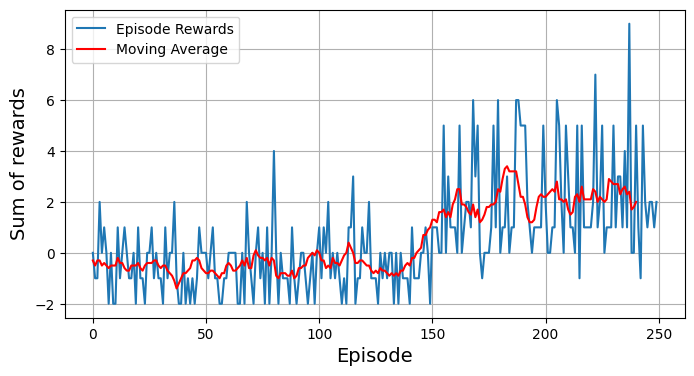

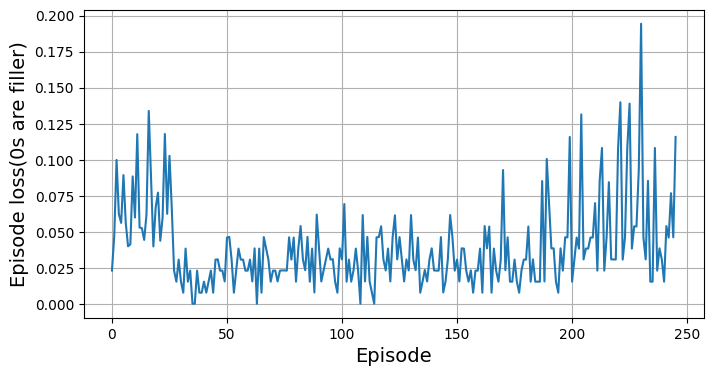

In [ ]:
print(len(rewards))
print(len(losses))

plt.figure(figsize=(8, 4))
plt.plot(rewards, label='Episode Rewards')  # Original episode rewards
# Calculate and plot the moving average
window_size = 10  # Increased window size for smoother average
averaged_rewards = np.convolve(rewards, np.ones(window_size), 'valid') / window_size # Changed mode to 'same'
plt.plot(averaged_rewards, label='Moving Average', color='red')
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.legend()  # Add a legend to differentiate the lines
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Episode loss(0s are filler)", fontsize=14)
plt.grid(True)
plt.show()

# Evaluation of the results


The two graphs below show the performance of our model compared a random number generator that does not learn.

The trained DQN model performs much better than the random number generator. The random model achieves an average reward of 1.0 over ten episodes, while the DQN model achieves an average reward of 7.3, a significant improvement.

It is worth noting that our model tended to converge on a strategy of corner camping while occasionally sliding towards the midpoint before immediately returning. This appears to be a local maxima caused by a low number of episodes, as this strategy is almost guaranteed to score at least some points when compared to the random number generator.

We believe that if ran for longer (e.g. 10000, 15000), the model would forego the strategy of corner camping and converge on a more optimal, dynamic strategy as the epsilon could remain very high for much longer.

The metrics used to evaluate performance: reward and episode count, are relevant as there is a clear correlation in our model between reward and episode number. This is evident both through analysis of the metrics and through observation of the model's behavior during the training loop.

After the model has undergone the core training loop, it is obvious that it shows significant and remarkable improvement in its ability to gain rewards while playing Breakout in an Atari environment.

The model shows improvement when compared to both itself at the beginning of the training process, and when compared to a random number generated playthrough.

Eval episode: 0, Steps: 244 Reward:7.0
Eval episode: 1, Steps: 244 Reward:7.0
Eval episode: 2, Steps: 265 Reward:11.0
Eval episode: 3, Steps: 265 Reward:11.0
Eval episode: 4, Steps: 265 Reward:11.0
Eval episode: 5, Steps: 244 Reward:7.0
Eval episode: 6, Steps: 265 Reward:11.0
Eval episode: 7, Steps: 181 Reward:2.0
Eval episode: 8, Steps: 212 Reward:3.0
Eval episode: 9, Steps: 212 Reward:3.0


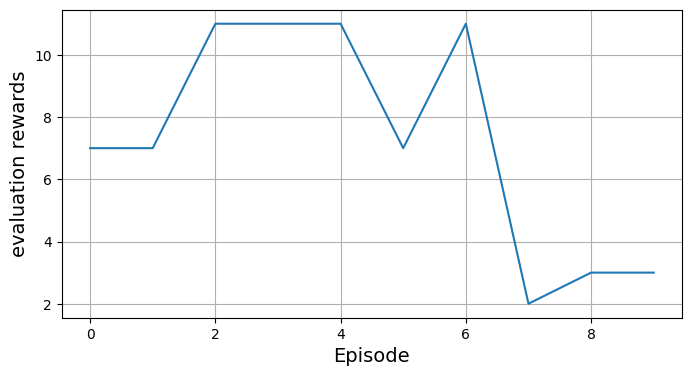

average reward: 7.3


In [ ]:
eval_rewards = []
def evaluate(rew):
  for i in range(10):
    obs, info = env.reset()

    last_lives = info["lives"]
    env.step(Action.FIRE)

    total_reward = 0
    for step in range(STEPS_PER_EP):
      if info["lives"] < last_lives:
        obs, reward, done, truncated, info = env.step(Action.FIRE)
        last_lives = info["lives"]
      else:
        action = epsilon_greedy_policy(obs, epsilon=0.00)  # Use greedy policy for evaluation
        obs, reward, done, truncated, info = env.step(action)
      total_reward += reward
      if done or truncated:
        break

  # extra code – displays debug info, stores data for the next figure, and
  # keeps track of the best model weights so far
    print(f"\rEval episode: {i}, Steps: {step} Reward:{total_reward}")
    rew.append(total_reward)

evaluate(eval_rewards)
plt.figure(figsize=(8, 4))
plt.plot(eval_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("evaluation rewards", fontsize=14)
plt.grid(True)
plt.show()
print(f"average reward: {np.mean(eval_rewards)}")

##compare to random play

Eval episode: 0, Steps: 181 Reward:2.0
Eval episode: 1, Steps: 150 Reward:1.0
Eval episode: 2, Steps: 123 Reward:0.0
Eval episode: 3, Steps: 168 Reward:1.0
Eval episode: 4, Steps: 218 Reward:2.0
Eval episode: 5, Steps: 219 Reward:2.0
Eval episode: 6, Steps: 151 Reward:1.0
Eval episode: 7, Steps: 121 Reward:0.0
Eval episode: 8, Steps: 150 Reward:1.0
Eval episode: 9, Steps: 122 Reward:0.0


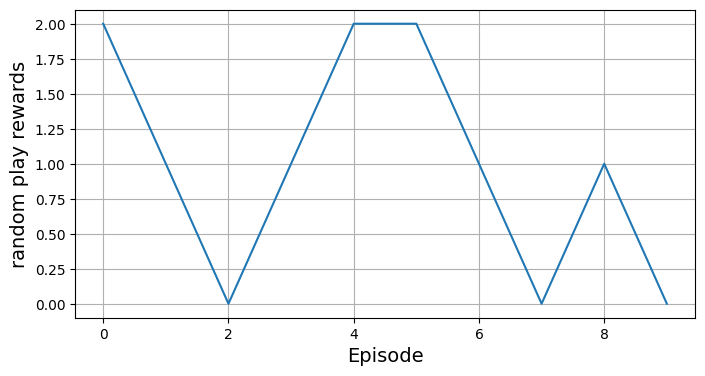

average reward: 1.0
the agent is 630.0% better than random play


In [ ]:
rand_rewards = []
for i in range(10):
  obs, info = env.reset()

  last_lives = info["lives"]
  env.step(Action.FIRE)
  total_reward = 0
  for step in range(STEPS_PER_EP):
    if info["lives"] < last_lives:
      obs, reward, done, truncated, info = env.step(Action.FIRE)
      last_lives = info["lives"]
    else:
      action = np.random.randint(Action.N_ACTIONS)
      next_state, reward, done, truncated, info = env.step(action)
    if done or truncated:
      break
    total_reward += reward

  # extra code – displays debug info, stores data for the next figure, and
  # keeps track of the best model weights so far
  print(f"\rEval episode: {i}, Steps: {step} Reward:{total_reward}")
  rand_rewards.append(total_reward)

plt.figure(figsize=(8, 4))
plt.plot(rand_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("random play rewards", fontsize=14)
plt.grid(True)
plt.show()
print(f"average reward: {np.mean(rand_rewards)}")

print(f"the agent is {(np.mean(eval_rewards) - np.mean(rand_rewards)) / np.mean(rand_rewards) * 100}% better than random play")

# Demonstration

Below is a frame-by-frame demonstration of the trained model playing Breakout. The information is presented in this manner rather than as a video.

action: 3
(210, 160, 3)


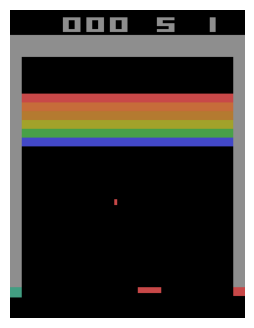

True
Total reward: 0.0
action: 3
(210, 160, 3)


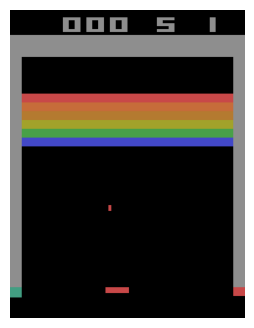

True
Total reward: 0.0
action: 3
(210, 160, 3)


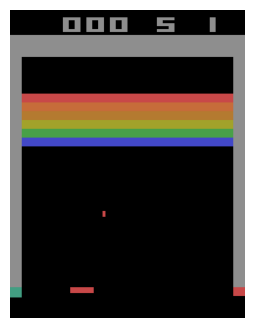

True
Total reward: 0.0
action: 3
(210, 160, 3)


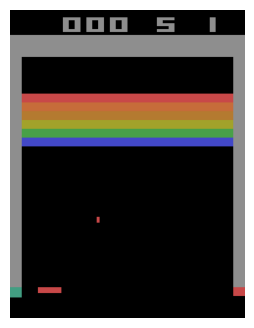

True
Total reward: 0.0
action: 3
(210, 160, 3)


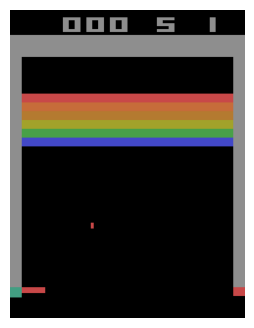

True
Total reward: 0.0
action: 3
(210, 160, 3)


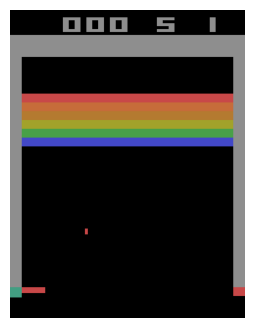

True
Total reward: 0.0
action: 3
(210, 160, 3)


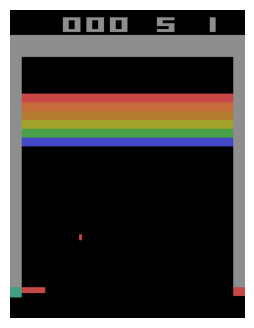

True
Total reward: 0.0
action: 3
(210, 160, 3)


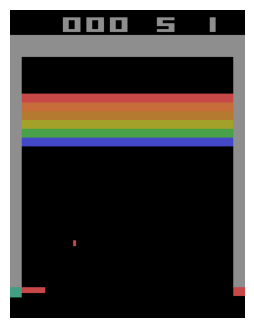

True
Total reward: 0.0
action: 3
(210, 160, 3)


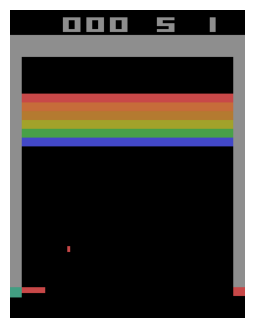

True
Total reward: 0.0
action: 3
(210, 160, 3)


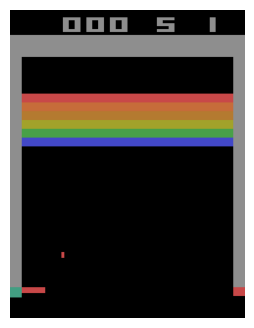

True
Total reward: 0.0
action: 3
(210, 160, 3)


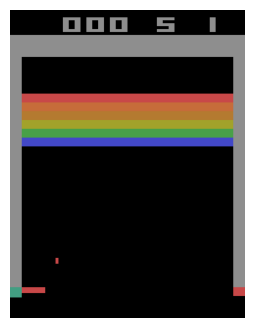

True
Total reward: 0.0
action: 3
(210, 160, 3)


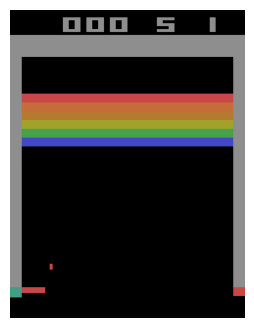

True
Total reward: 0.0
action: 3
(210, 160, 3)


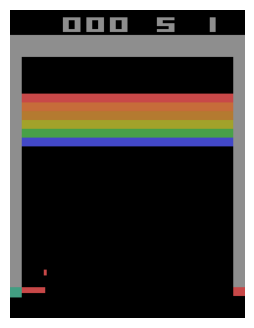

True
Total reward: 0.0
action: 3
(210, 160, 3)


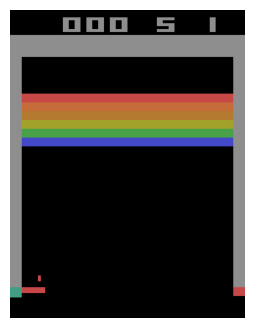

True
Total reward: 0.0
action: 3
(210, 160, 3)


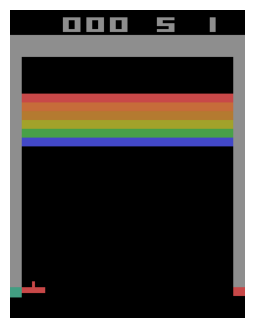

True
Total reward: 0.0
action: 3
(210, 160, 3)


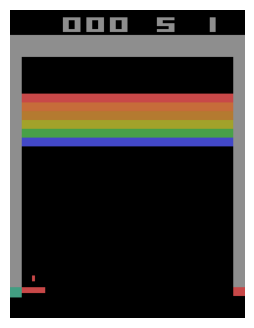

True
Total reward: 0.0
action: 3
(210, 160, 3)


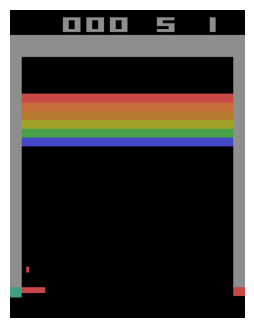

True
Total reward: 0.0
action: 3
(210, 160, 3)


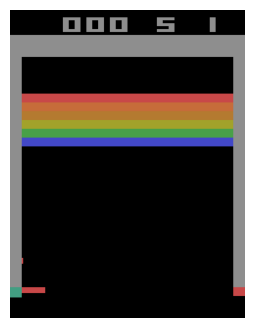

True
Total reward: 0.0
action: 3
(210, 160, 3)


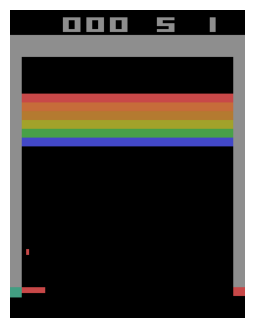

True
Total reward: 0.0
action: 3
(210, 160, 3)


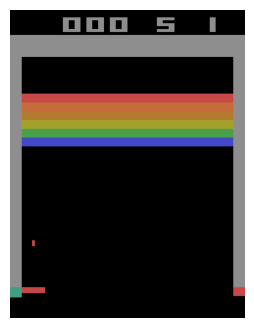

True
Total reward: 0.0
action: 3
(210, 160, 3)


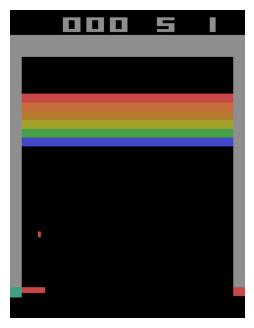

True
Total reward: 0.0
action: 3
(210, 160, 3)


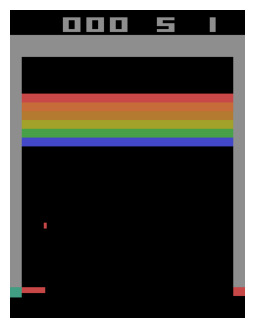

True
Total reward: 0.0
action: 3
(210, 160, 3)


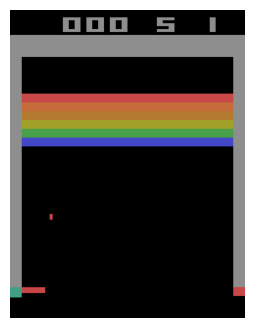

True
Total reward: 0.0
action: 3
(210, 160, 3)


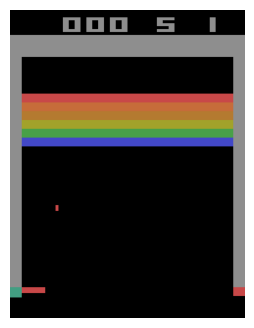

True
Total reward: 0.0
action: 3
(210, 160, 3)


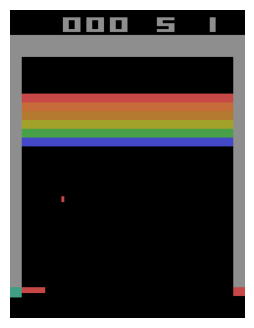

True
Total reward: 0.0
action: 3
(210, 160, 3)


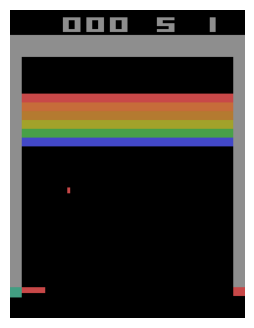

True
Total reward: 0.0
action: 3
(210, 160, 3)


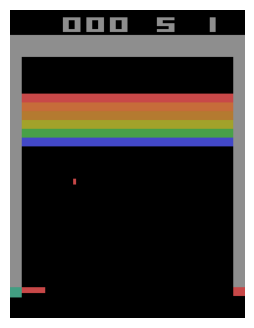

True
Total reward: 0.0
action: 3
(210, 160, 3)


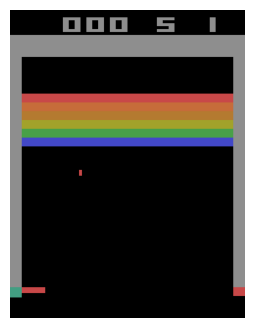

True
Total reward: 0.0
action: 3
(210, 160, 3)


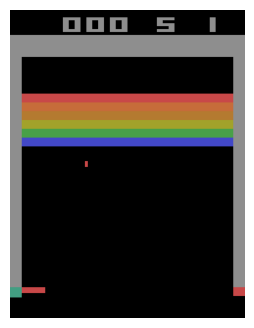

True
Total reward: 0.0
action: 3
(210, 160, 3)


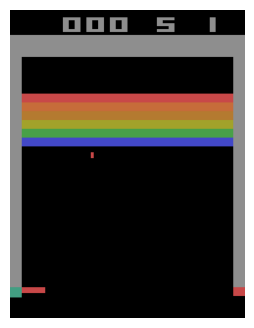

True
Total reward: 0.0
action: 3
(210, 160, 3)


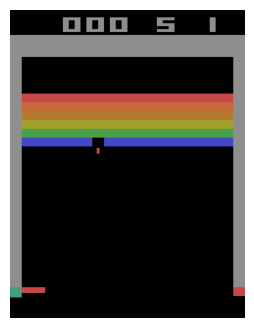

True
Total reward: 1.0
action: 3
(210, 160, 3)


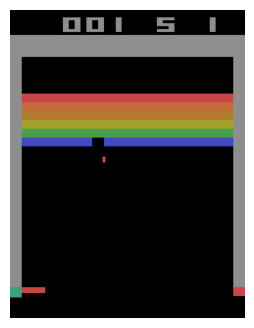

True
Total reward: 1.0
action: 3
(210, 160, 3)


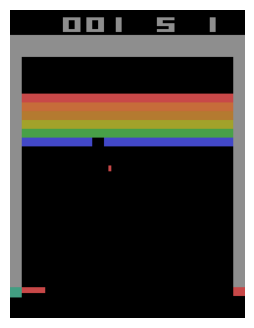

True
Total reward: 1.0
action: 3
(210, 160, 3)


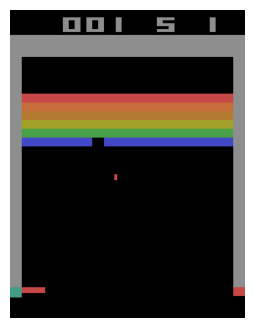

True
Total reward: 1.0
action: 3
(210, 160, 3)


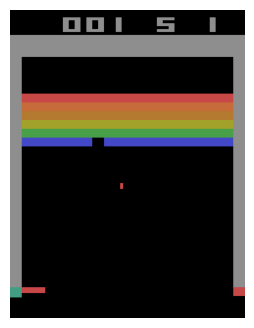

True
Total reward: 1.0
action: 3
(210, 160, 3)


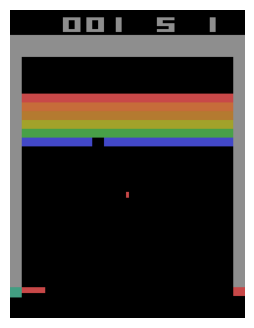

True
Total reward: 1.0
action: 3
(210, 160, 3)


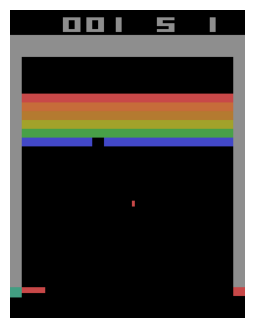

True
Total reward: 1.0
action: 3
(210, 160, 3)


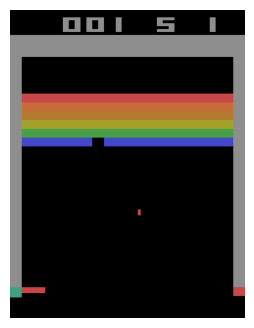

True
Total reward: 1.0
action: 3
(210, 160, 3)


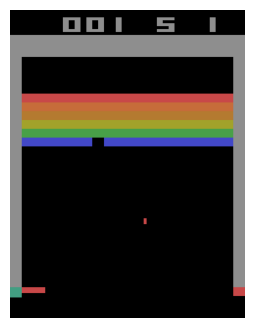

True
Total reward: 1.0
action: 3
(210, 160, 3)


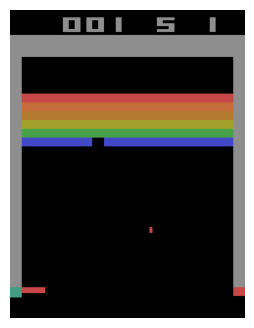

True
Total reward: 1.0
action: 3
(210, 160, 3)


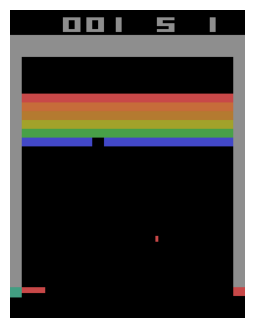

True
Total reward: 1.0
action: 3
(210, 160, 3)


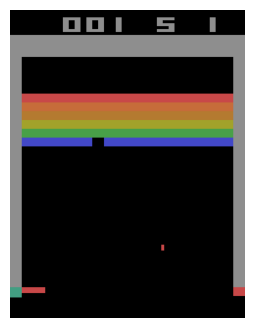

True
Total reward: 1.0
action: 3
(210, 160, 3)


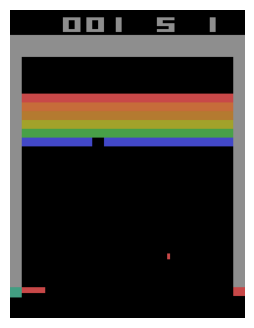

True
Total reward: 1.0
action: 3
(210, 160, 3)


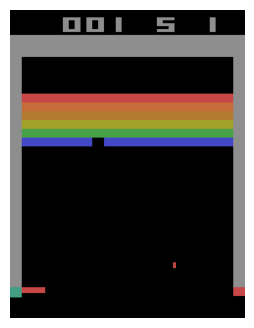

True
Total reward: 1.0
action: 3
(210, 160, 3)


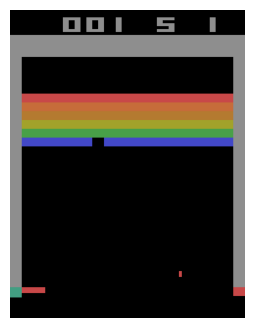

True
Total reward: 1.0
action: 3
(210, 160, 3)


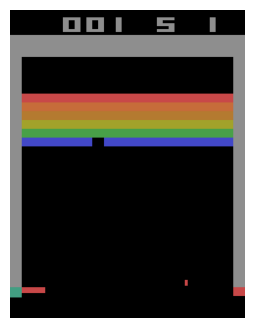

True
Total reward: 1.0
action: 3
(210, 160, 3)


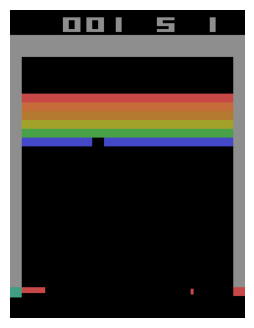

True
Total reward: 1.0
action: 3
(210, 160, 3)


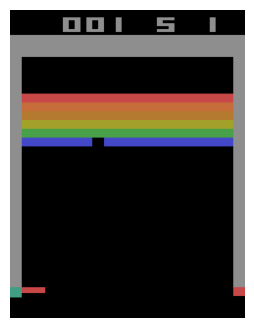

True
Total reward: 1.0
action: 3
(210, 160, 3)


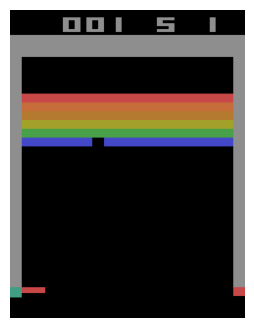

True
Total reward: 1.0
action: 3
(210, 160, 3)


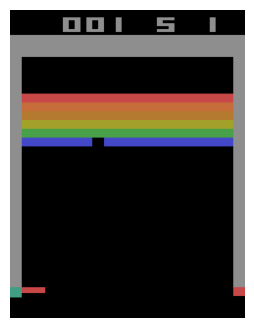

True
Total reward: 1.0
action: 3
(210, 160, 3)


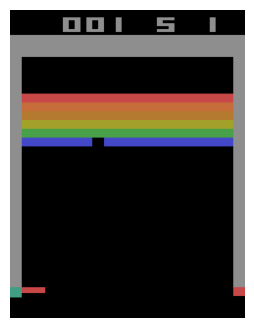

True
Total reward: 1.0
action: 3
(210, 160, 3)


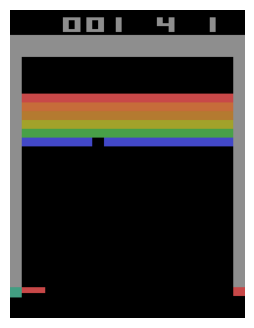

False
Total reward: 1.0
action: 3
(210, 160, 3)


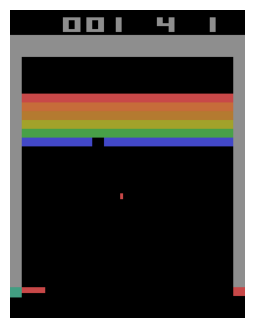

True
Total reward: 1.0
action: 3
(210, 160, 3)


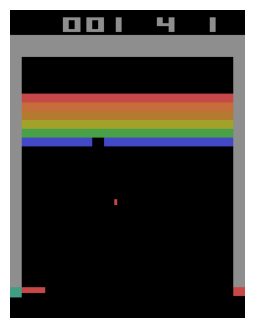

True
Total reward: 1.0
action: 3
(210, 160, 3)


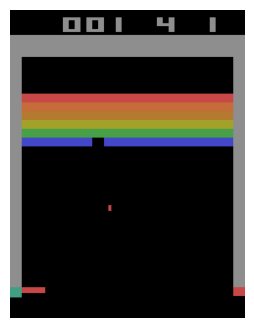

True
Total reward: 1.0
action: 3
(210, 160, 3)


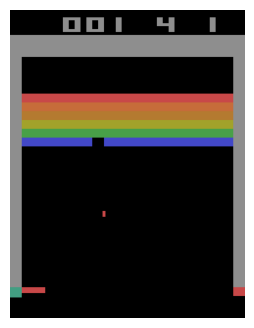

True
Total reward: 1.0
action: 3
(210, 160, 3)


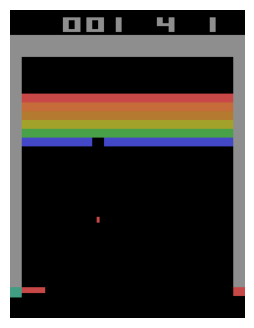

True
Total reward: 1.0
action: 3
(210, 160, 3)


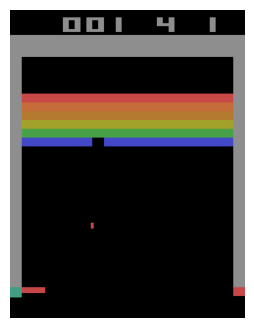

True
Total reward: 1.0
action: 3
(210, 160, 3)


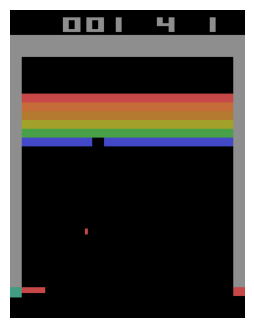

True
Total reward: 1.0
action: 3
(210, 160, 3)


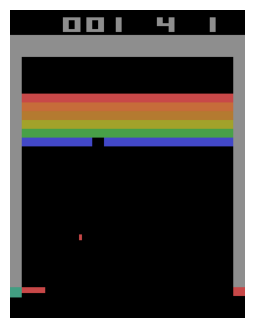

True
Total reward: 1.0
action: 3
(210, 160, 3)


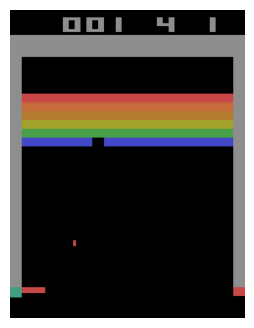

True
Total reward: 1.0
action: 3
(210, 160, 3)


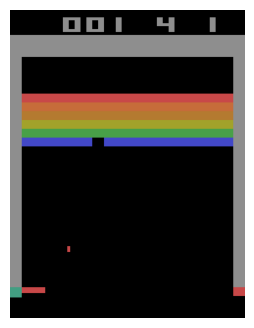

True
Total reward: 1.0
action: 3
(210, 160, 3)


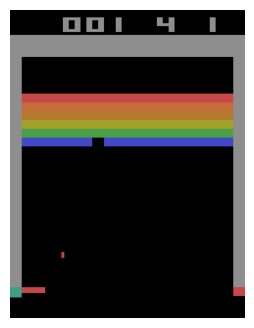

True
Total reward: 1.0
action: 3
(210, 160, 3)


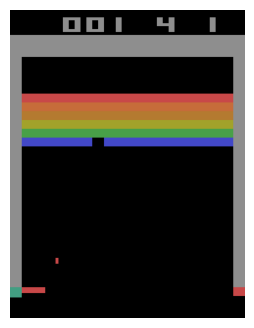

True
Total reward: 1.0
action: 3
(210, 160, 3)


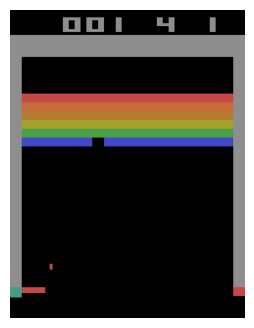

True
Total reward: 1.0
action: 3
(210, 160, 3)


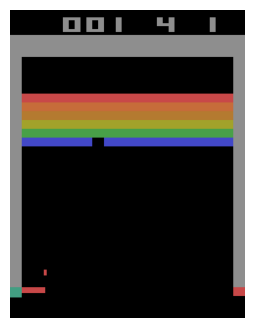

True
Total reward: 1.0
action: 3
(210, 160, 3)


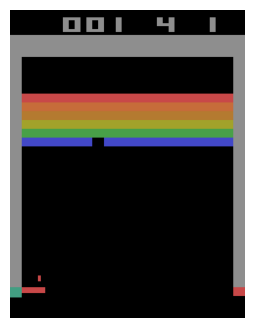

True
Total reward: 1.0
action: 3
(210, 160, 3)


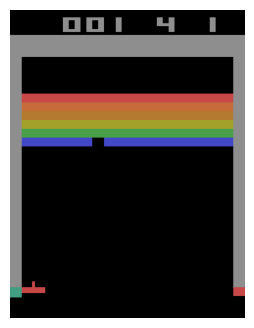

True
Total reward: 1.0
action: 3
(210, 160, 3)


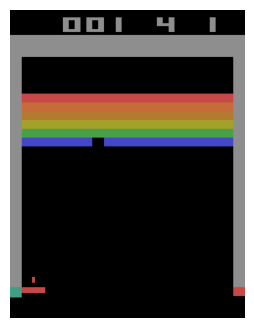

True
Total reward: 1.0
action: 3
(210, 160, 3)


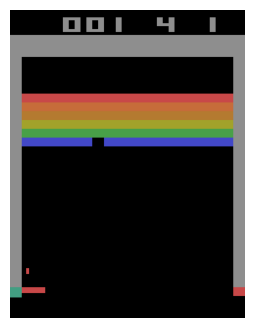

True
Total reward: 1.0
action: 3
(210, 160, 3)


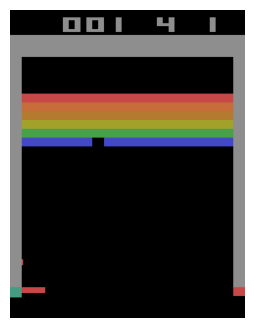

True
Total reward: 1.0
action: 3
(210, 160, 3)


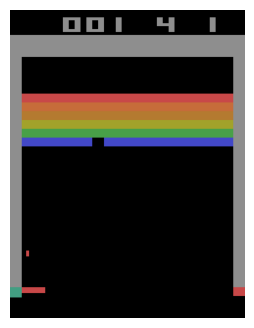

True
Total reward: 1.0
action: 3
(210, 160, 3)


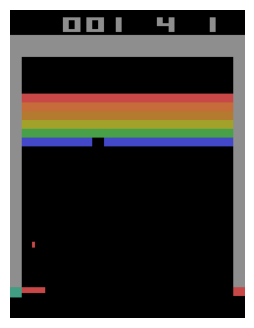

True
Total reward: 1.0
action: 3
(210, 160, 3)


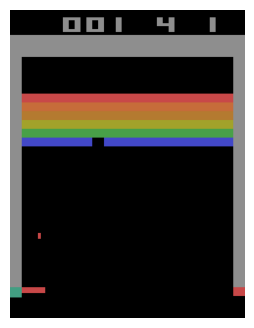

True
Total reward: 1.0
action: 3
(210, 160, 3)


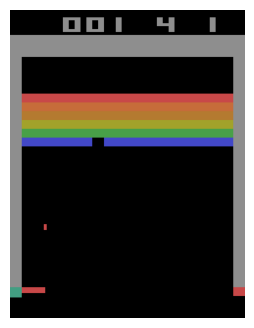

True
Total reward: 1.0
action: 3
(210, 160, 3)


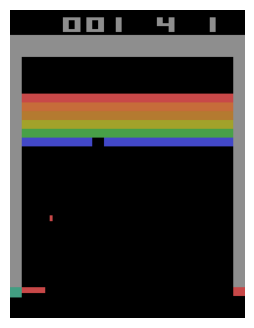

True
Total reward: 1.0
action: 3
(210, 160, 3)


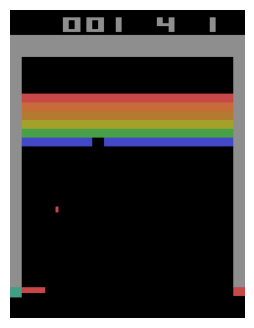

True
Total reward: 1.0
action: 3
(210, 160, 3)


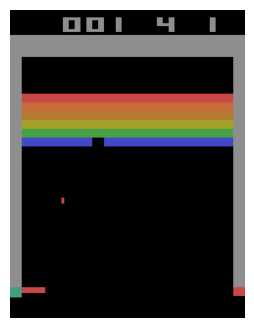

True
Total reward: 1.0
action: 3
(210, 160, 3)


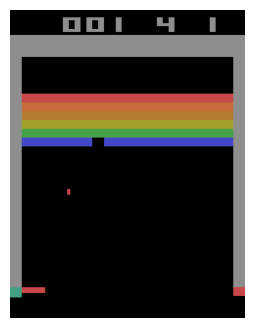

True
Total reward: 1.0
action: 3
(210, 160, 3)


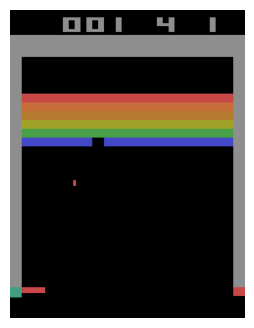

True
Total reward: 1.0
action: 3
(210, 160, 3)


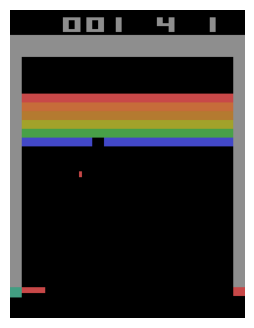

True
Total reward: 1.0
action: 3
(210, 160, 3)


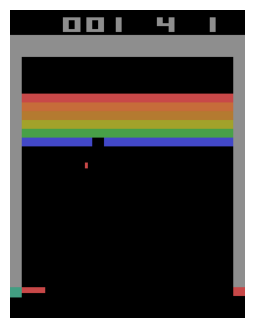

True
Total reward: 1.0
action: 3
(210, 160, 3)


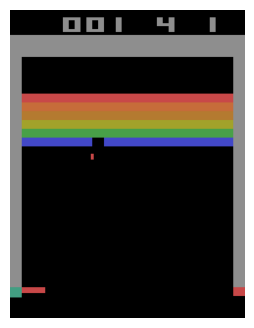

True
Total reward: 1.0
action: 3
(210, 160, 3)


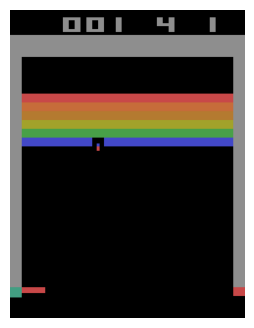

True
Total reward: 1.0
action: 3
(210, 160, 3)


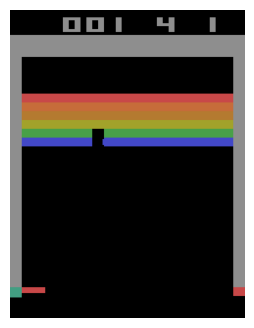

True
Total reward: 2.0
action: 3
(210, 160, 3)


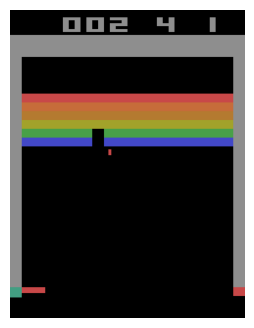

True
Total reward: 2.0
action: 3
(210, 160, 3)


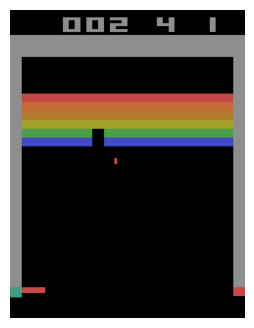

True
Total reward: 2.0
action: 3
(210, 160, 3)


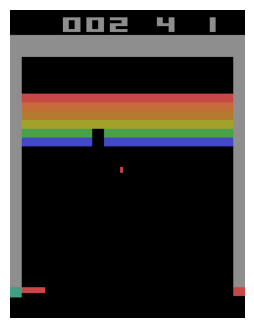

True
Total reward: 2.0
action: 3
(210, 160, 3)


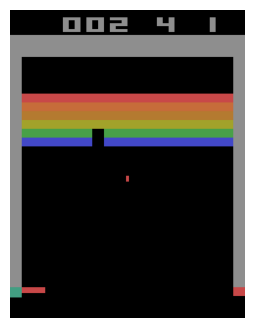

True
Total reward: 2.0
action: 3
(210, 160, 3)


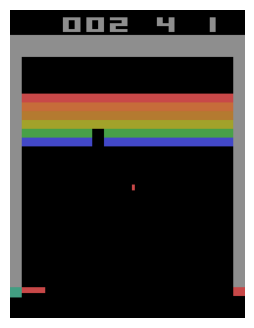

True
Total reward: 2.0
action: 3
(210, 160, 3)


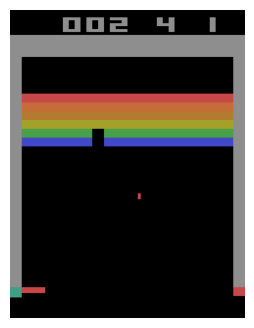

True
Total reward: 2.0
action: 3
(210, 160, 3)


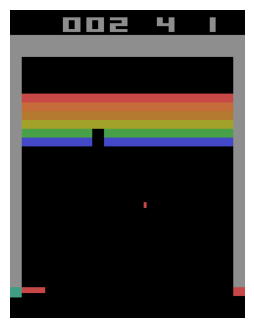

True
Total reward: 2.0
action: 3
(210, 160, 3)


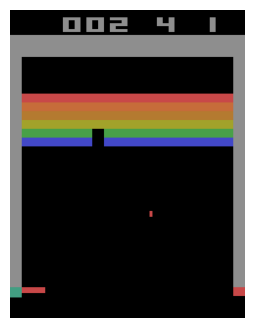

True
Total reward: 2.0
action: 3
(210, 160, 3)


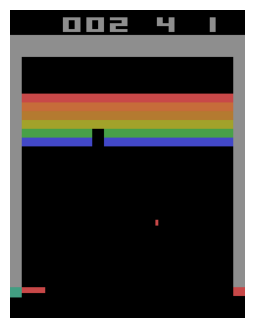

True
Total reward: 2.0
action: 3
(210, 160, 3)


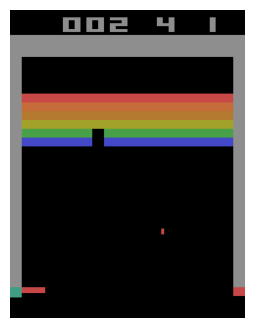

True
Total reward: 2.0
action: 3
(210, 160, 3)


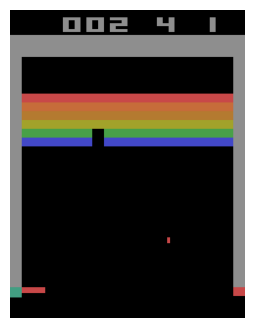

True
Total reward: 2.0
action: 3
(210, 160, 3)


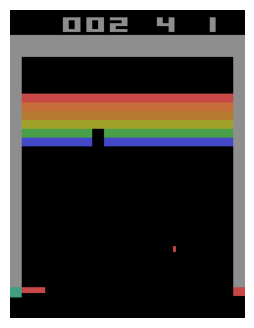

True
Total reward: 2.0
action: 3
(210, 160, 3)


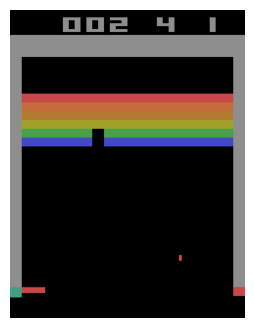

True
Total reward: 2.0
action: 3
(210, 160, 3)


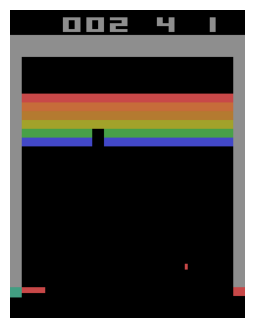

True
Total reward: 2.0
action: 3
(210, 160, 3)


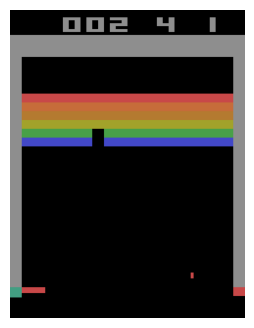

True
Total reward: 2.0
action: 3
(210, 160, 3)


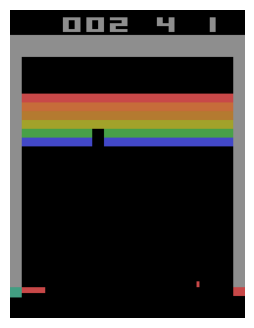

True
Total reward: 2.0
action: 3
(210, 160, 3)


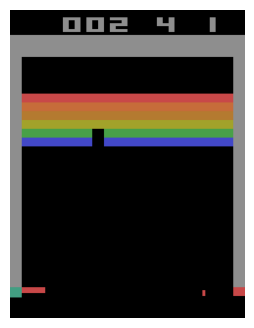

True
Total reward: 2.0
action: 3
(210, 160, 3)


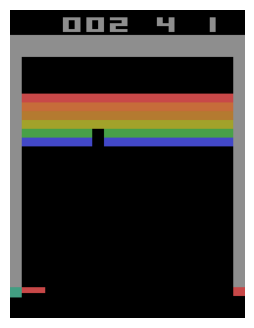

True
Total reward: 2.0
action: 3
(210, 160, 3)


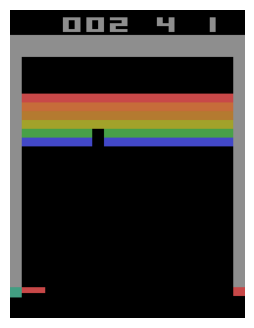

True
Total reward: 2.0
action: 3
(210, 160, 3)


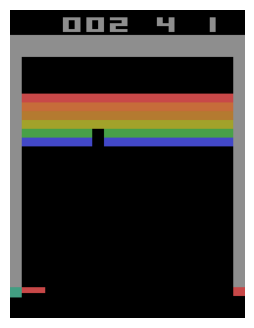

True
Total reward: 2.0
action: 3
(210, 160, 3)


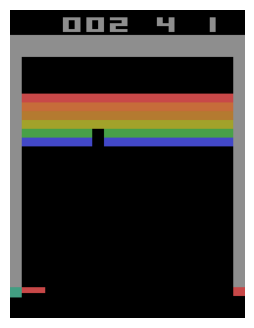

True
Total reward: 2.0
action: 3
(210, 160, 3)


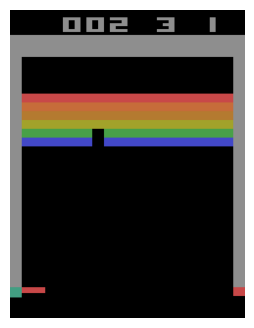

False
Total reward: 2.0
action: 3
(210, 160, 3)


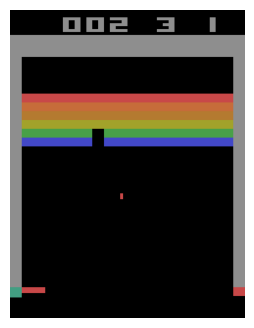

True
Total reward: 2.0
action: 3
(210, 160, 3)


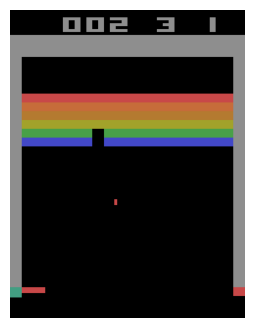

True
Total reward: 2.0
action: 3
(210, 160, 3)


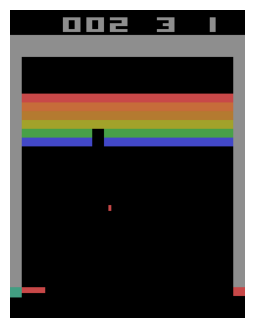

True
Total reward: 2.0
action: 3
(210, 160, 3)


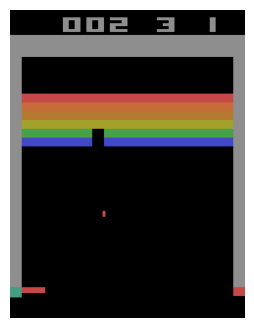

True
Total reward: 2.0
action: 3
(210, 160, 3)


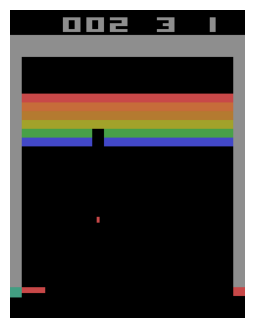

True
Total reward: 2.0
action: 3
(210, 160, 3)


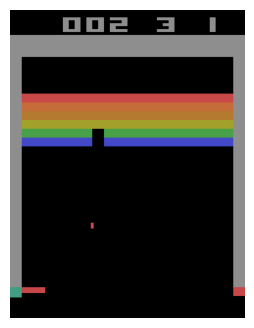

True
Total reward: 2.0
action: 3
(210, 160, 3)


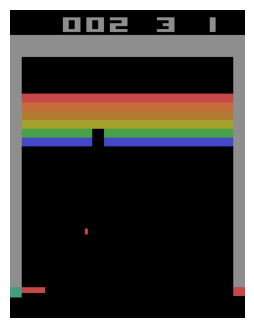

True
Total reward: 2.0
action: 3
(210, 160, 3)


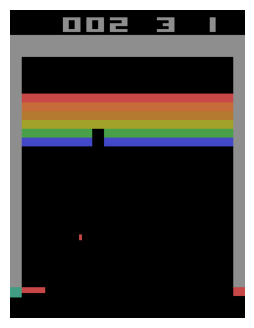

True
Total reward: 2.0
action: 3
(210, 160, 3)


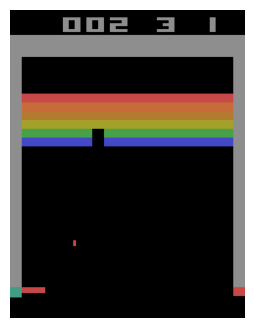

True
Total reward: 2.0
action: 3
(210, 160, 3)


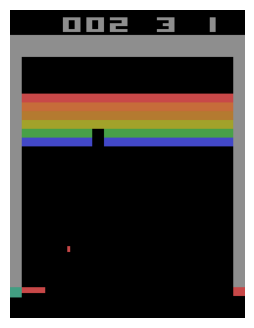

True
Total reward: 2.0
action: 3
(210, 160, 3)


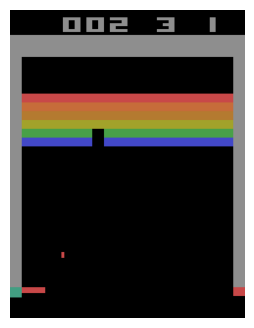

True
Total reward: 2.0
action: 3
(210, 160, 3)


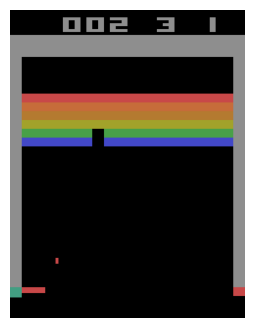

True
Total reward: 2.0
action: 3
(210, 160, 3)


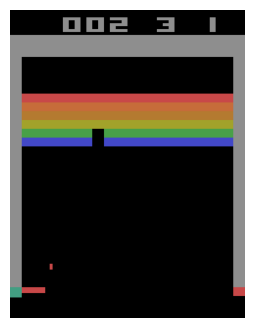

True
Total reward: 2.0
action: 3
(210, 160, 3)


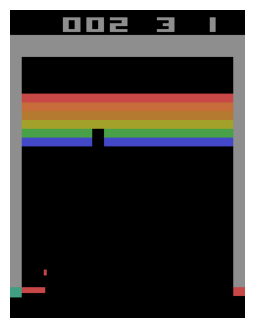

True
Total reward: 2.0
action: 3
(210, 160, 3)


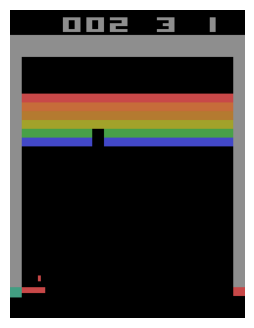

True
Total reward: 2.0
action: 3
(210, 160, 3)


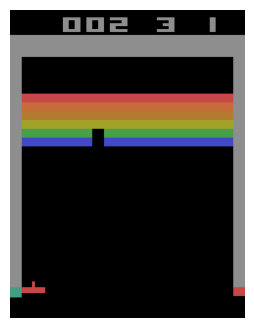

True
Total reward: 2.0
action: 3
(210, 160, 3)


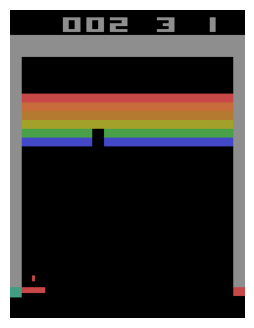

True
Total reward: 2.0
action: 3
(210, 160, 3)


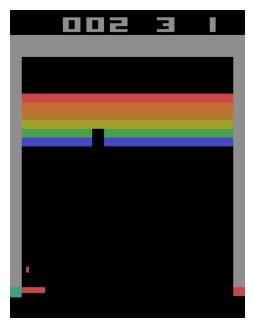

True
Total reward: 2.0
action: 3
(210, 160, 3)


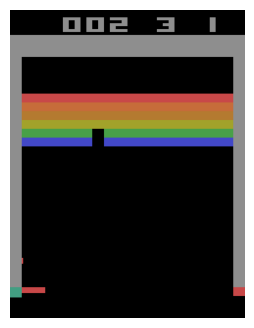

True
Total reward: 2.0
action: 3
(210, 160, 3)


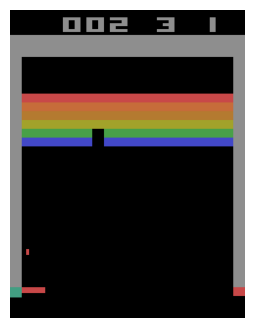

True
Total reward: 2.0
action: 3
(210, 160, 3)


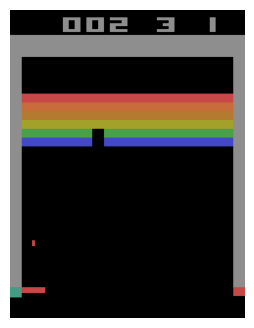

True
Total reward: 2.0
action: 3
(210, 160, 3)


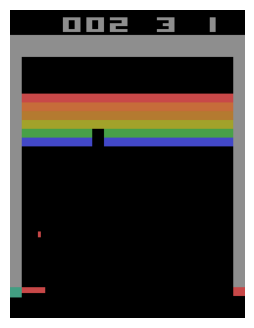

True
Total reward: 2.0
action: 3
(210, 160, 3)


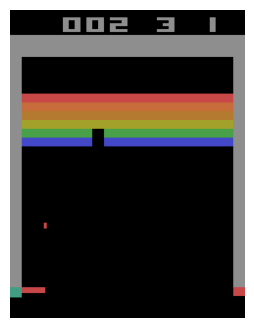

True
Total reward: 2.0
action: 3
(210, 160, 3)


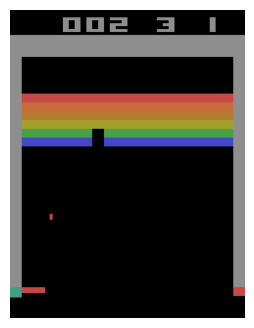

True
Total reward: 2.0
action: 3
(210, 160, 3)


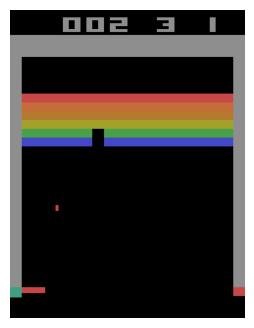

True
Total reward: 2.0
action: 3
(210, 160, 3)


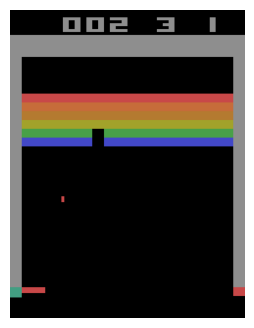

True
Total reward: 2.0
action: 3
(210, 160, 3)


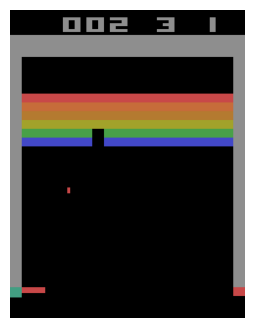

True
Total reward: 2.0
action: 3
(210, 160, 3)


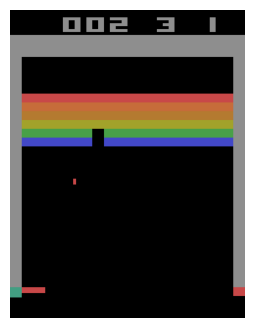

True
Total reward: 2.0
action: 3
(210, 160, 3)


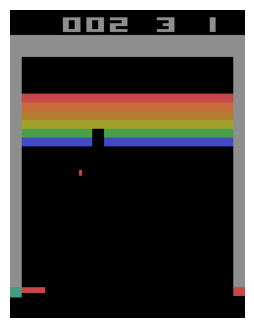

True
Total reward: 2.0
action: 3
(210, 160, 3)


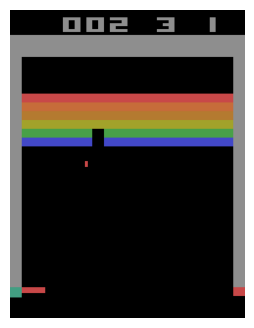

True
Total reward: 2.0
action: 3
(210, 160, 3)


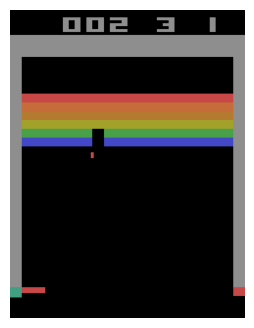

True
Total reward: 2.0
action: 3
(210, 160, 3)


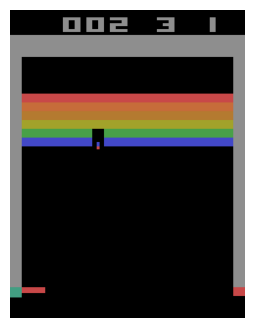

True
Total reward: 2.0
action: 3
(210, 160, 3)


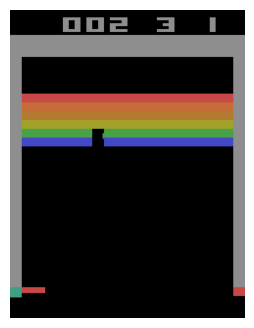

True
Total reward: 2.0
action: 3
(210, 160, 3)


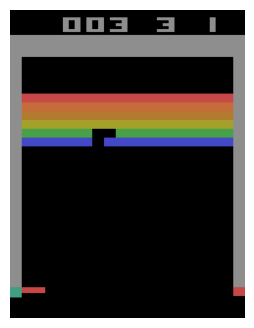

True
Total reward: 3.0
action: 3
(210, 160, 3)


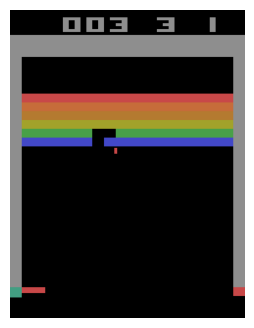

True
Total reward: 3.0
action: 3
(210, 160, 3)


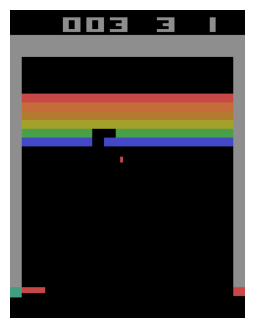

True
Total reward: 3.0
action: 3
(210, 160, 3)


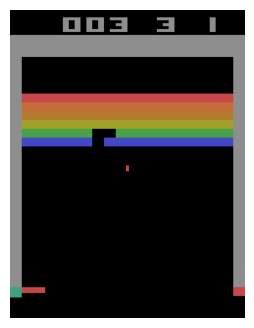

True
Total reward: 3.0
action: 3
(210, 160, 3)


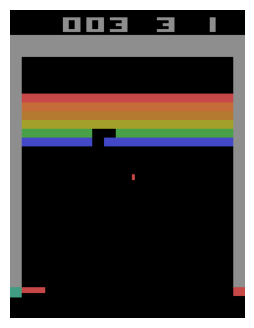

True
Total reward: 3.0
action: 3
(210, 160, 3)


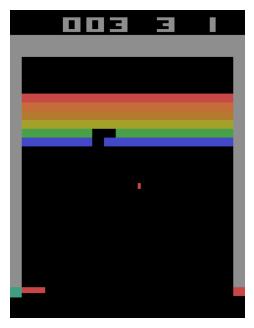

True
Total reward: 3.0
action: 3
(210, 160, 3)


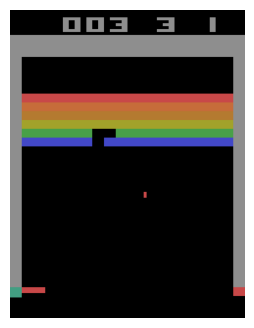

True
Total reward: 3.0
action: 3
(210, 160, 3)


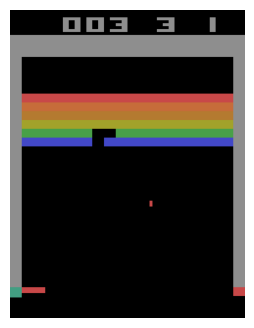

True
Total reward: 3.0
action: 3
(210, 160, 3)


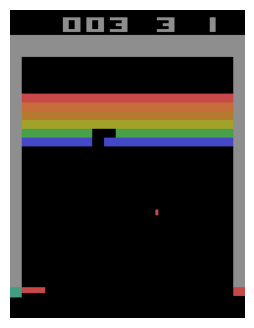

True
Total reward: 3.0
action: 3
(210, 160, 3)


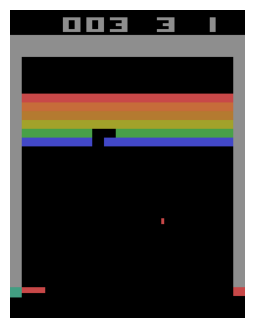

True
Total reward: 3.0
action: 3
(210, 160, 3)


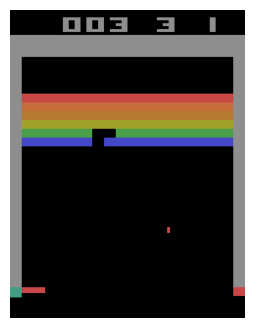

True
Total reward: 3.0
action: 3
(210, 160, 3)


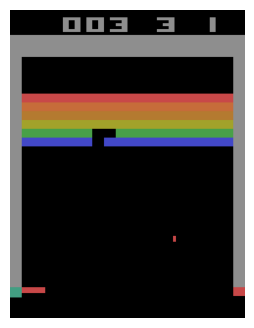

True
Total reward: 3.0
action: 3
(210, 160, 3)


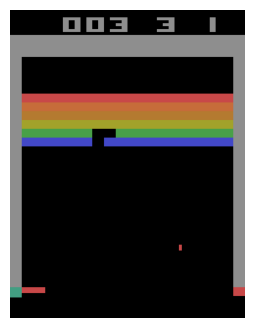

True
Total reward: 3.0
action: 3
(210, 160, 3)


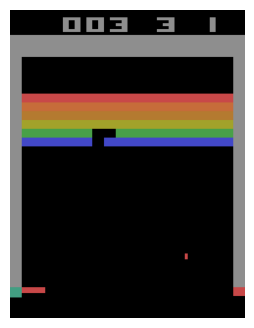

True
Total reward: 3.0
action: 3
(210, 160, 3)


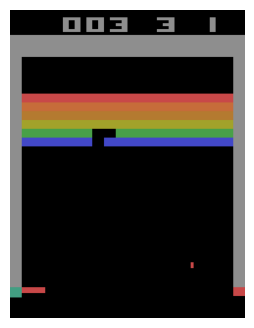

True
Total reward: 3.0
action: 3
(210, 160, 3)


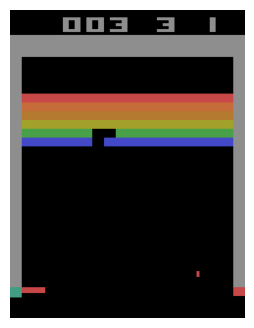

True
Total reward: 3.0
action: 3
(210, 160, 3)


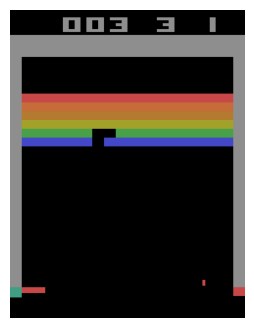

True
Total reward: 3.0
action: 3
(210, 160, 3)


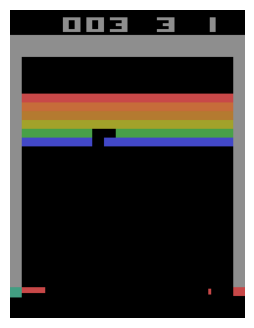

True
Total reward: 3.0
action: 3
(210, 160, 3)


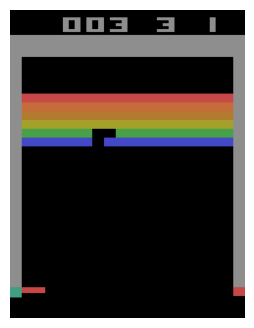

True
Total reward: 3.0
action: 3
(210, 160, 3)


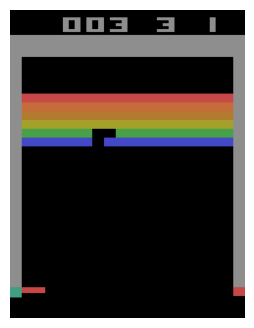

True
Total reward: 3.0
action: 3
(210, 160, 3)


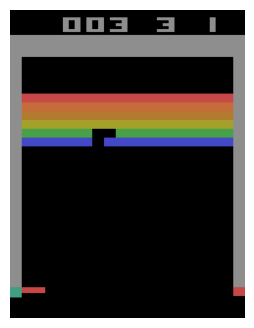

True
Total reward: 3.0
action: 3
(210, 160, 3)


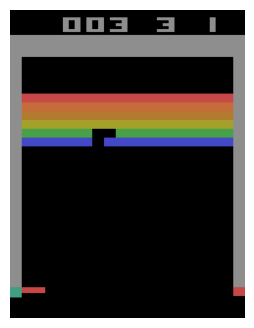

True
Total reward: 3.0
action: 3
(210, 160, 3)


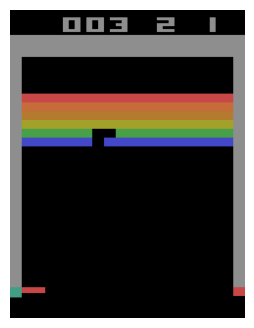

False
Total reward: 3.0
action: 3
(210, 160, 3)


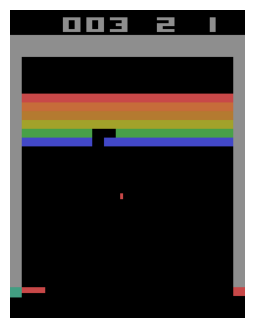

True
Total reward: 3.0
action: 3
(210, 160, 3)


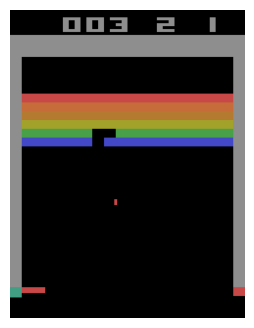

True
Total reward: 3.0
action: 3
(210, 160, 3)


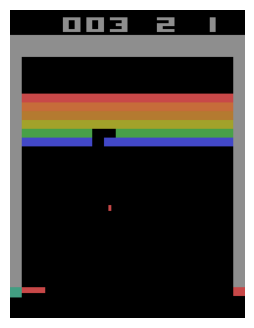

True
Total reward: 3.0
action: 3
(210, 160, 3)


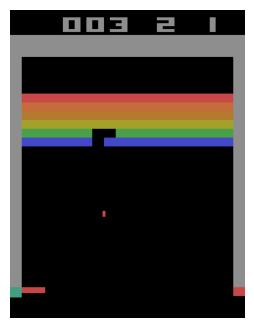

True
Total reward: 3.0
action: 3
(210, 160, 3)


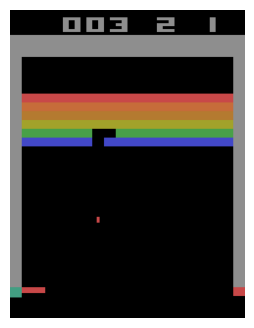

True
Total reward: 3.0
action: 3
(210, 160, 3)


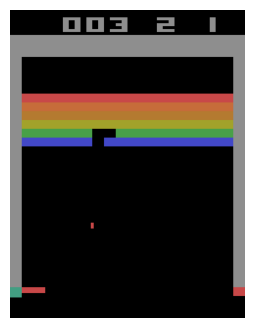

True
Total reward: 3.0
action: 3
(210, 160, 3)


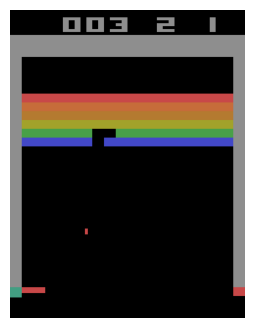

True
Total reward: 3.0
action: 3
(210, 160, 3)


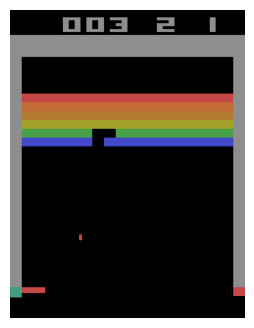

True
Total reward: 3.0
action: 3
(210, 160, 3)


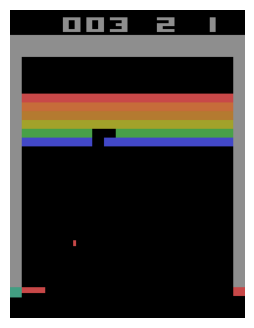

True
Total reward: 3.0
action: 3
(210, 160, 3)


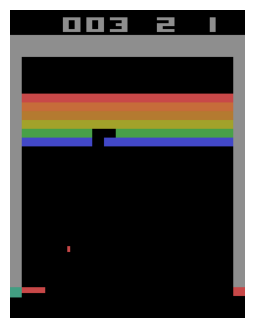

True
Total reward: 3.0
action: 3
(210, 160, 3)


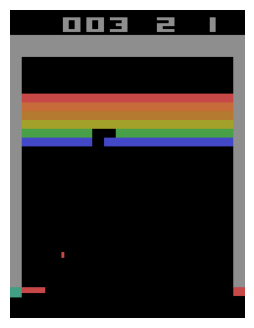

True
Total reward: 3.0
action: 3
(210, 160, 3)


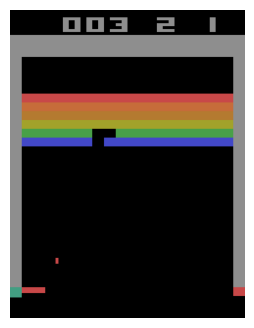

True
Total reward: 3.0
action: 3
(210, 160, 3)


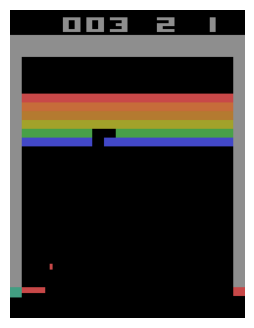

True
Total reward: 3.0
action: 3
(210, 160, 3)


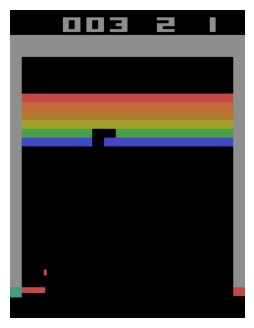

True
Total reward: 3.0
action: 3
(210, 160, 3)


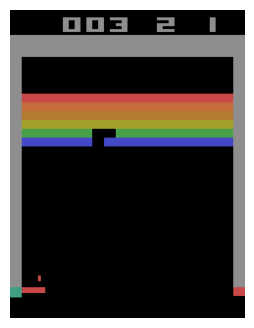

True
Total reward: 3.0
action: 3
(210, 160, 3)


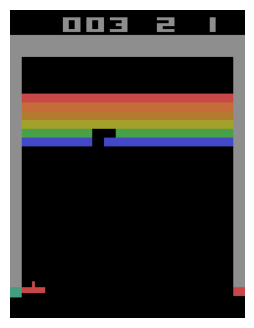

True
Total reward: 3.0
action: 3
(210, 160, 3)


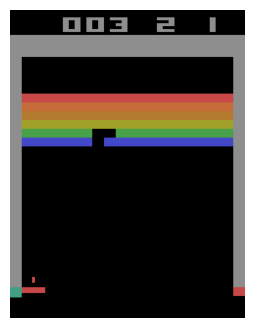

True
Total reward: 3.0
action: 3
(210, 160, 3)


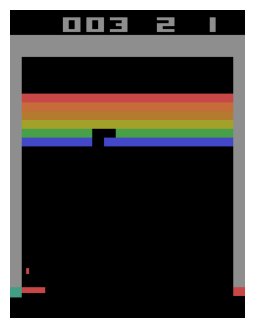

True
Total reward: 3.0
action: 3
(210, 160, 3)


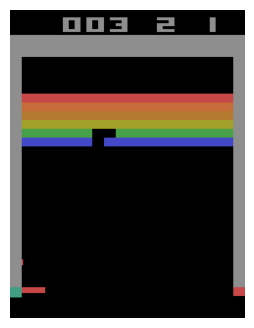

True
Total reward: 3.0
action: 3
(210, 160, 3)


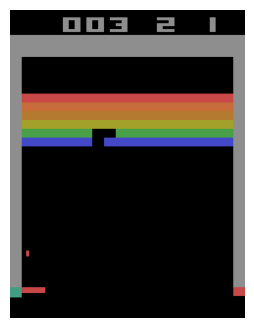

True
Total reward: 3.0
action: 3
(210, 160, 3)


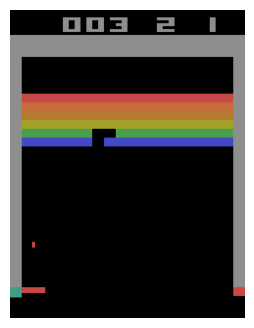

True
Total reward: 3.0
action: 3
(210, 160, 3)


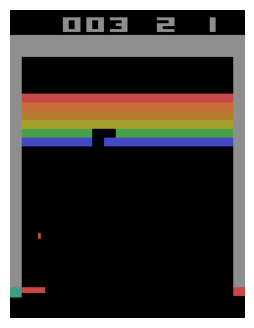

True
Total reward: 3.0
action: 3
(210, 160, 3)


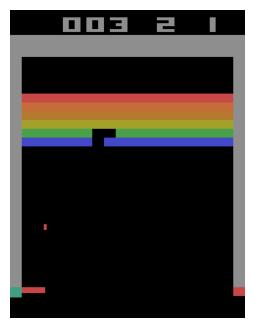

True
Total reward: 3.0
action: 3
(210, 160, 3)


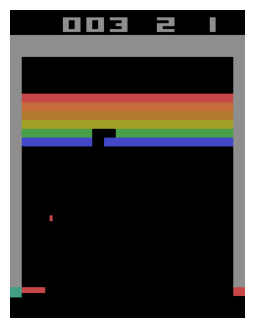

True
Total reward: 3.0
action: 3
(210, 160, 3)


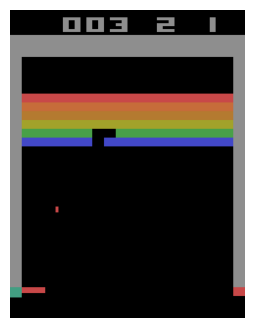

True
Total reward: 3.0
action: 3
(210, 160, 3)


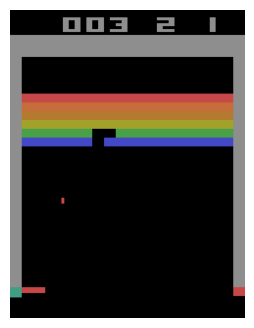

True
Total reward: 3.0
action: 3
(210, 160, 3)


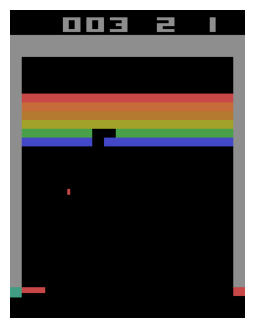

True
Total reward: 3.0
action: 3
(210, 160, 3)


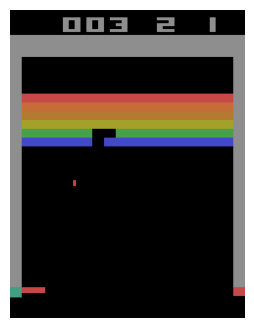

True
Total reward: 3.0
action: 3
(210, 160, 3)


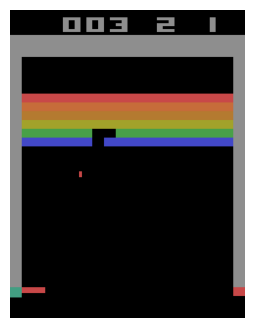

True
Total reward: 3.0
action: 3
(210, 160, 3)


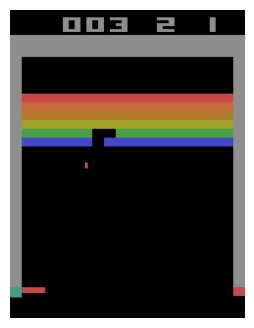

True
Total reward: 3.0
action: 3
(210, 160, 3)


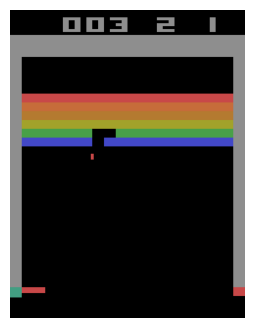

True
Total reward: 3.0
action: 3
(210, 160, 3)


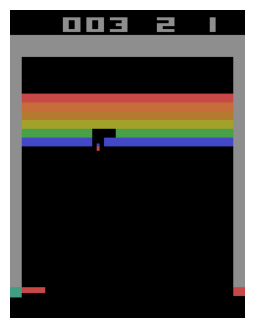

True
Total reward: 3.0
action: 3
(210, 160, 3)


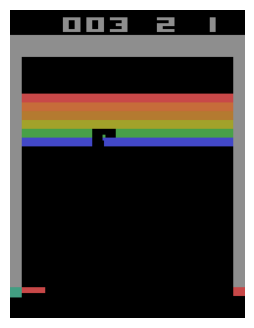

True
Total reward: 3.0
action: 3
(210, 160, 3)


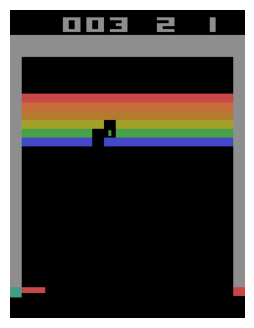

True
Total reward: 7.0
action: 3
(210, 160, 3)


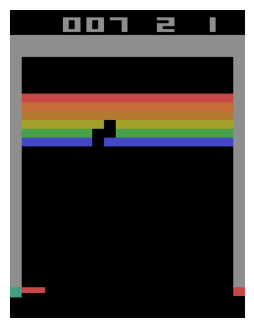

True
Total reward: 7.0
action: 3
(210, 160, 3)


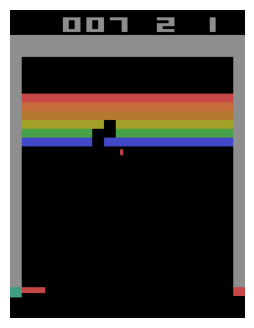

True
Total reward: 7.0
action: 3
(210, 160, 3)


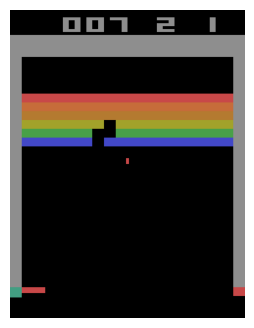

True
Total reward: 7.0
action: 3
(210, 160, 3)


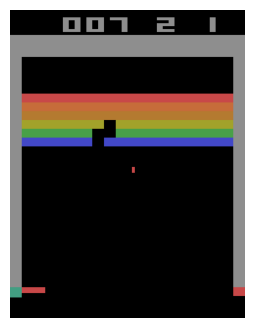

True
Total reward: 7.0
action: 3
(210, 160, 3)


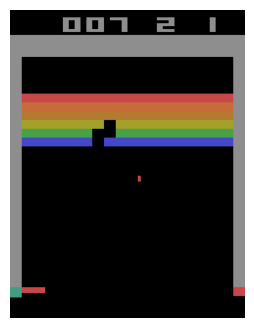

True
Total reward: 7.0
action: 3
(210, 160, 3)


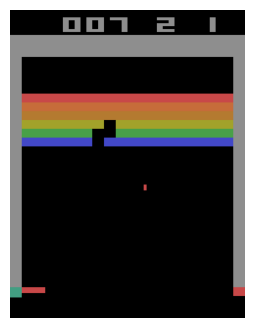

True
Total reward: 7.0
action: 3
(210, 160, 3)


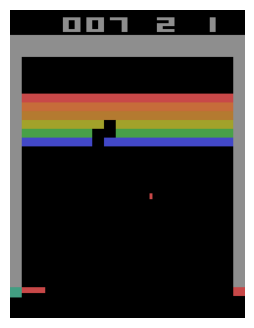

True
Total reward: 7.0
action: 3
(210, 160, 3)


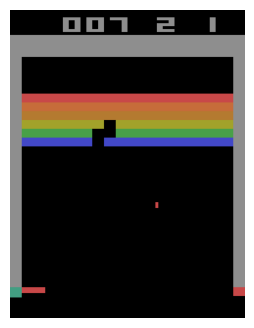

True
Total reward: 7.0
action: 3
(210, 160, 3)


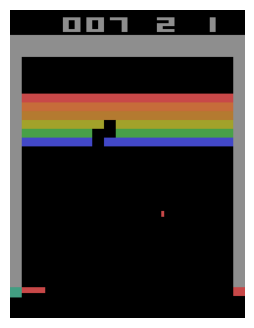

True
Total reward: 7.0
action: 3
(210, 160, 3)


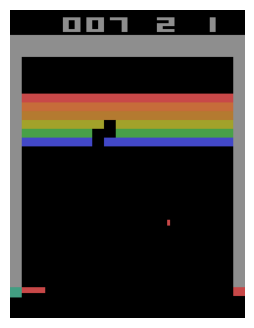

True
Total reward: 7.0
action: 3
(210, 160, 3)


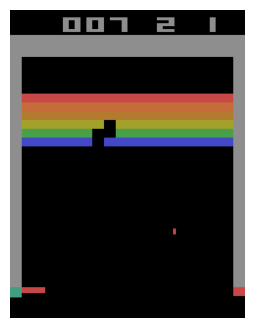

True
Total reward: 7.0
action: 3
(210, 160, 3)


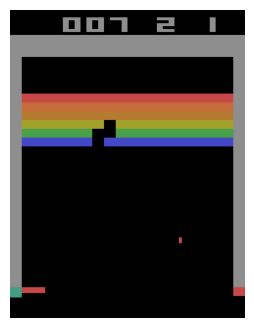

True
Total reward: 7.0
action: 3
(210, 160, 3)


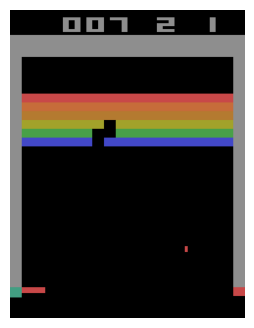

True
Total reward: 7.0
action: 3
(210, 160, 3)


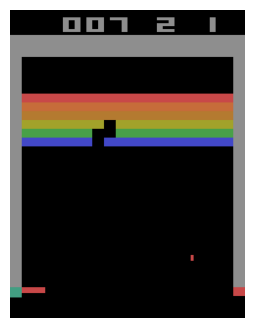

True
Total reward: 7.0
action: 3
(210, 160, 3)


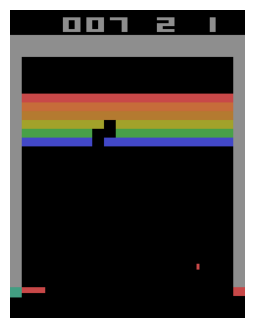

True
Total reward: 7.0
action: 3
(210, 160, 3)


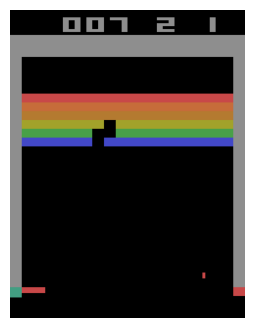

True
Total reward: 7.0
action: 3
(210, 160, 3)


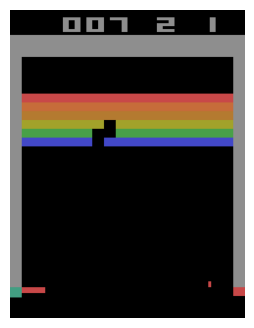

True
Total reward: 7.0
action: 3
(210, 160, 3)


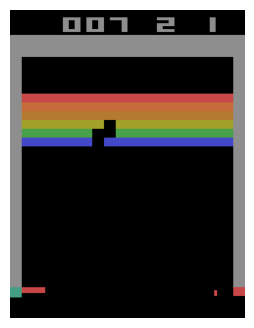

True
Total reward: 7.0
action: 3
(210, 160, 3)


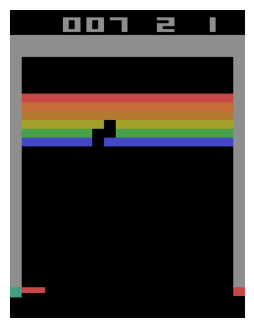

True
Total reward: 7.0
action: 3
(210, 160, 3)


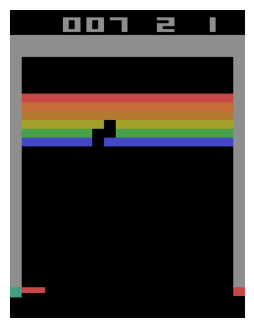

True
Total reward: 7.0
action: 3
(210, 160, 3)


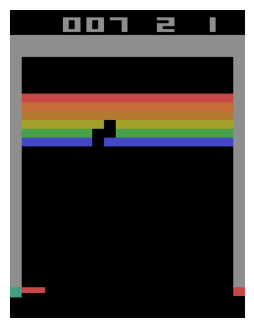

True
Total reward: 7.0
action: 3
(210, 160, 3)


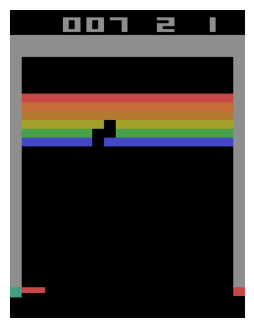

True
Total reward: 7.0
action: 3
(210, 160, 3)


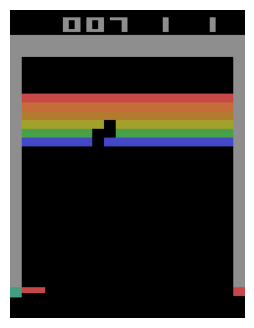

False
Total reward: 7.0
action: 3
(210, 160, 3)


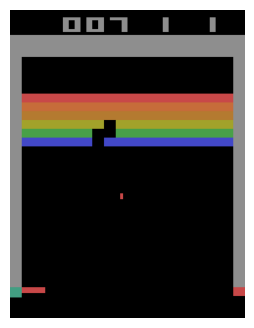

True
Total reward: 7.0
action: 3
(210, 160, 3)


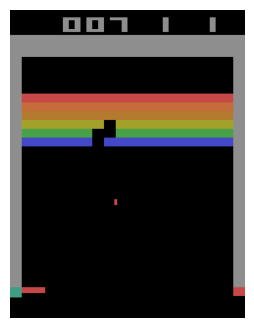

True
Total reward: 7.0
action: 3
(210, 160, 3)


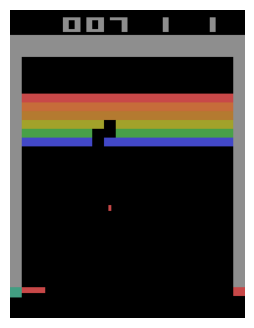

True
Total reward: 7.0
action: 3
(210, 160, 3)


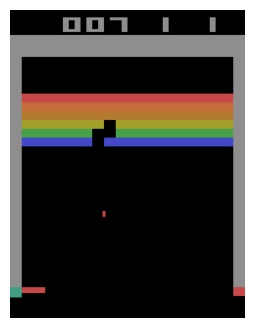

True
Total reward: 7.0
action: 3
(210, 160, 3)


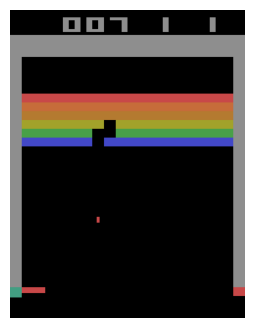

True
Total reward: 7.0
action: 3
(210, 160, 3)


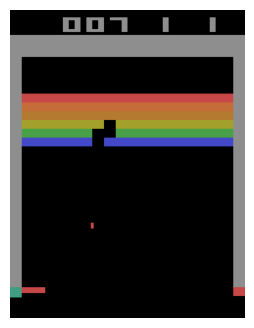

True
Total reward: 7.0
action: 3
(210, 160, 3)


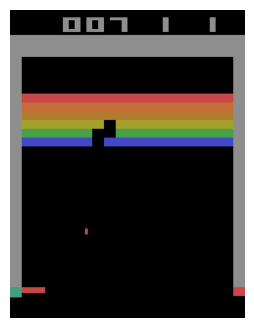

True
Total reward: 7.0
action: 3
(210, 160, 3)


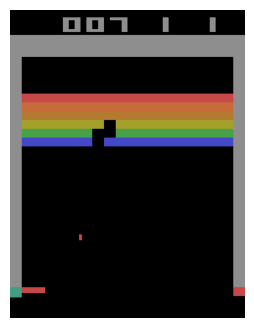

True
Total reward: 7.0
action: 3
(210, 160, 3)


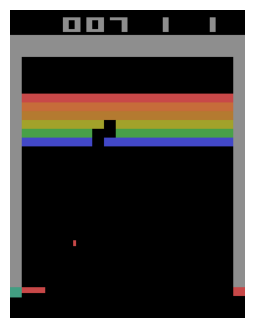

True
Total reward: 7.0
action: 3
(210, 160, 3)


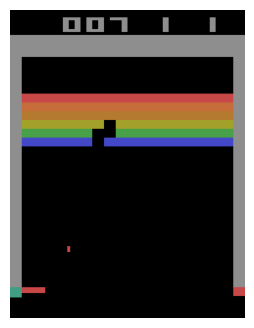

True
Total reward: 7.0
action: 3
(210, 160, 3)


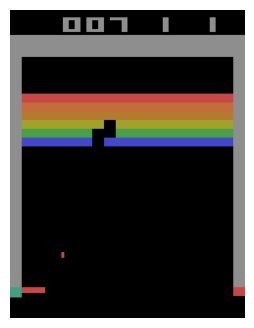

True
Total reward: 7.0
action: 3
(210, 160, 3)


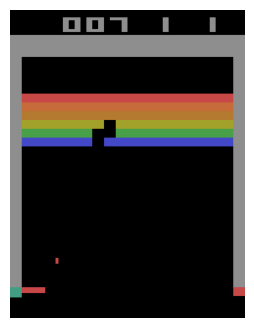

True
Total reward: 7.0
action: 3
(210, 160, 3)


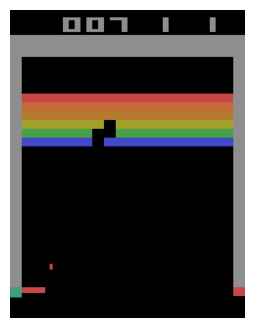

True
Total reward: 7.0
action: 3
(210, 160, 3)


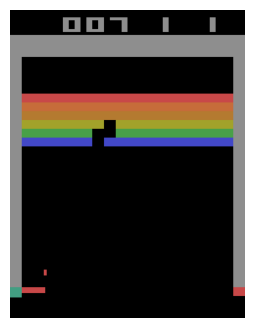

True
Total reward: 7.0
action: 3
(210, 160, 3)


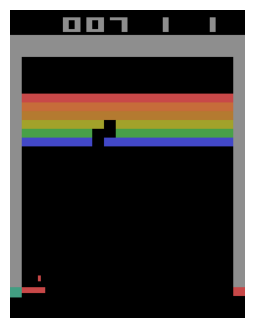

True
Total reward: 7.0
action: 3
(210, 160, 3)


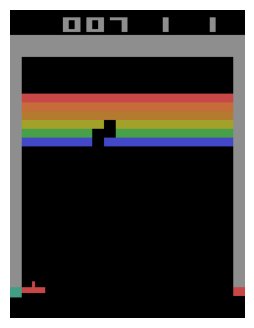

True
Total reward: 7.0
action: 3
(210, 160, 3)


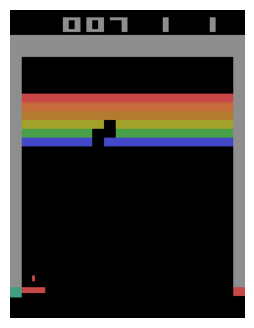

True
Total reward: 7.0
action: 3
(210, 160, 3)


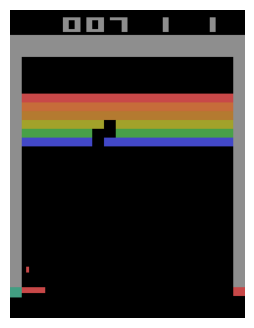

True
Total reward: 7.0
action: 3
(210, 160, 3)


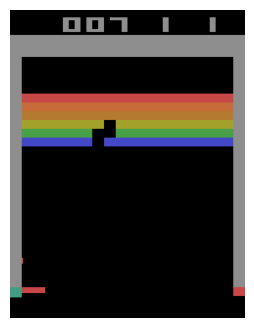

True
Total reward: 7.0
action: 3
(210, 160, 3)


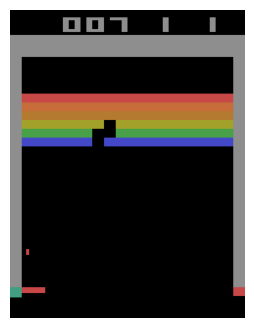

True
Total reward: 7.0
action: 3
(210, 160, 3)


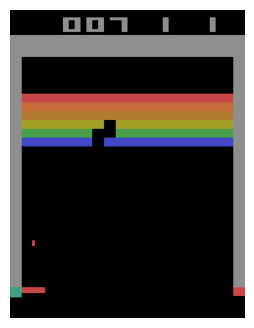

True
Total reward: 7.0
action: 3
(210, 160, 3)


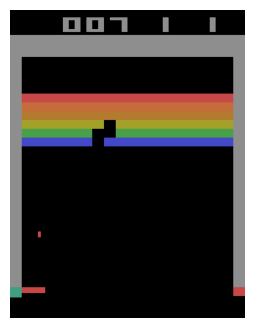

True
Total reward: 7.0
action: 3
(210, 160, 3)


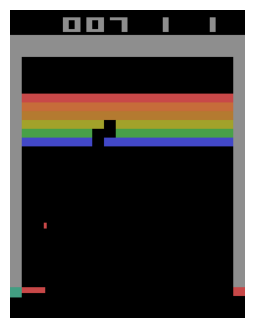

True
Total reward: 7.0
action: 3
(210, 160, 3)


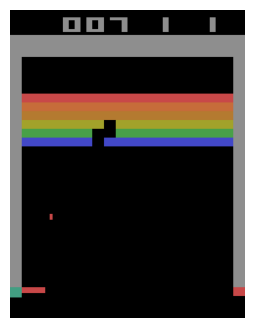

True
Total reward: 7.0
action: 3
(210, 160, 3)


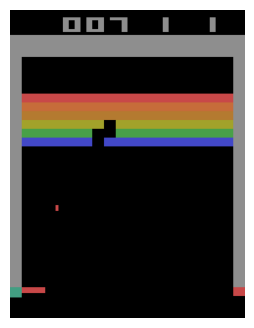

True
Total reward: 7.0
action: 3
(210, 160, 3)


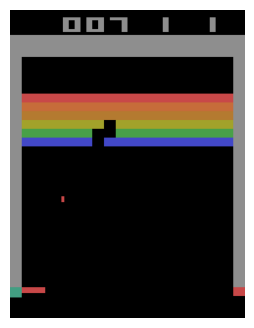

True
Total reward: 7.0
action: 3
(210, 160, 3)


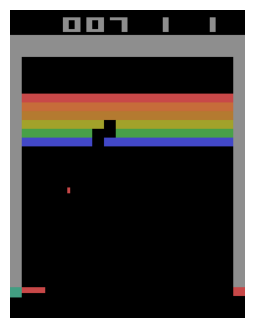

True
Total reward: 7.0
action: 3
(210, 160, 3)


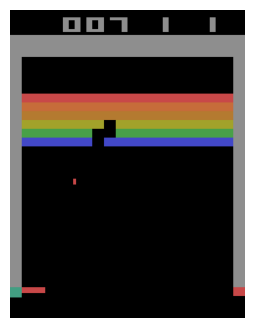

True
Total reward: 7.0
action: 3
(210, 160, 3)


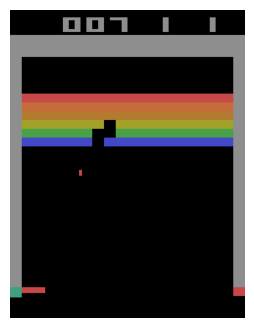

True
Total reward: 7.0
action: 3
(210, 160, 3)


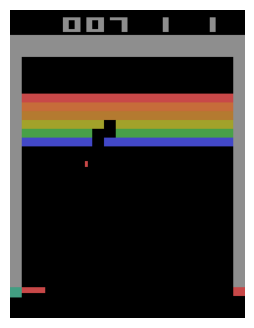

True
Total reward: 7.0
action: 3
(210, 160, 3)


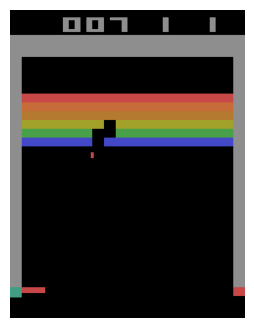

True
Total reward: 7.0
action: 3
(210, 160, 3)


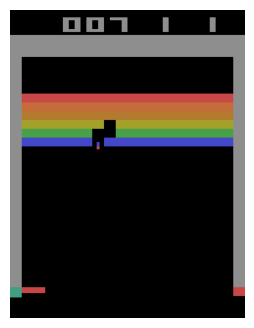

True
Total reward: 7.0
action: 3
(210, 160, 3)


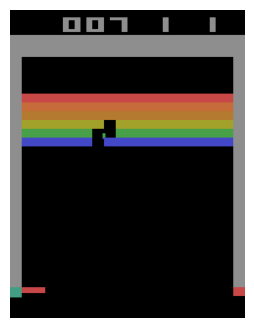

True
Total reward: 7.0
action: 3
(210, 160, 3)


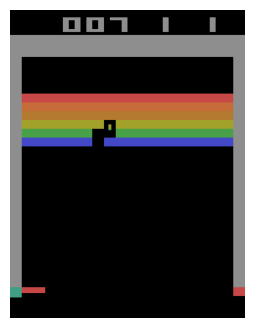

True
Total reward: 7.0
action: 3
(210, 160, 3)


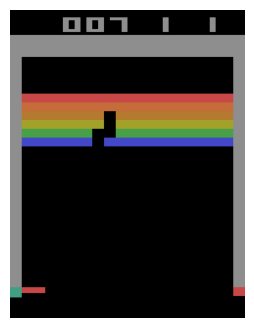

True
Total reward: 11.0
action: 3
(210, 160, 3)


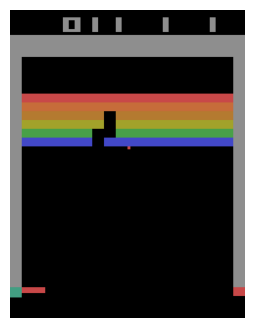

True
Total reward: 11.0
action: 3
(210, 160, 3)


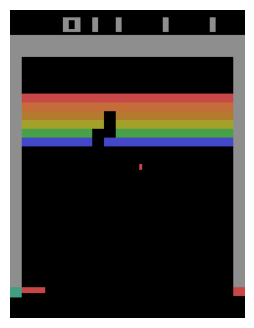

True
Total reward: 11.0
action: 3
(210, 160, 3)


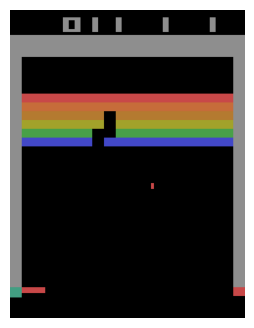

True
Total reward: 11.0
action: 3
(210, 160, 3)


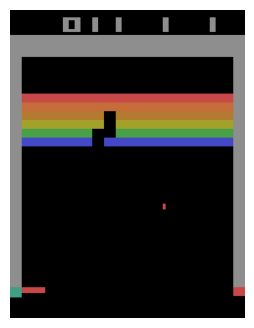

True
Total reward: 11.0
action: 3
(210, 160, 3)


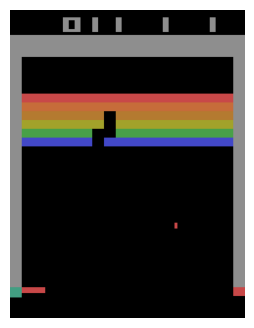

True
Total reward: 11.0
action: 3
(210, 160, 3)


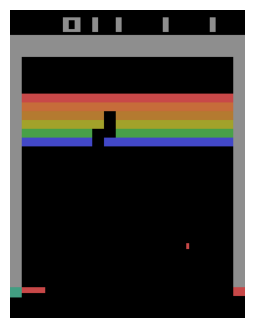

True
Total reward: 11.0
action: 3
(210, 160, 3)


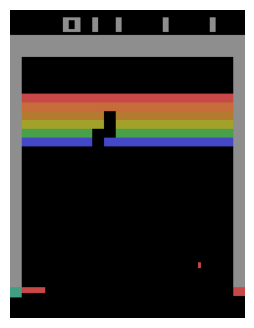

True
Total reward: 11.0
action: 3
(210, 160, 3)


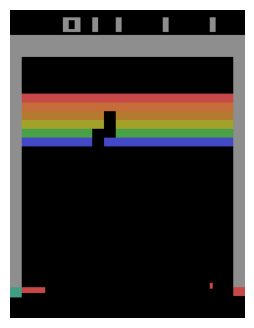

True
Total reward: 11.0
action: 3
(210, 160, 3)


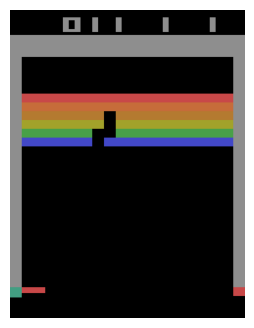

True
Total reward: 11.0
action: 3
(210, 160, 3)


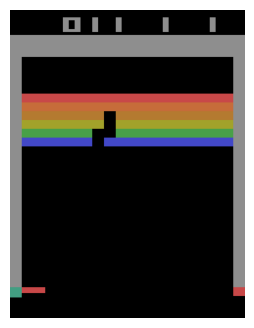

True
Total reward: 11.0
action: 3
(210, 160, 3)


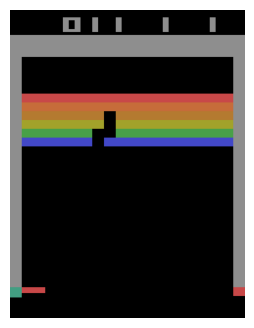

False
Total reward: 11.0


In [ ]:
obs, info = env.reset()
done = truncated = False
this_round_reward = 0
n_steps = 0
last_lives = info["lives"]
env.step(Action.FIRE)
while not ((done or truncated) or n_steps>STEPS_PER_EP):
  if info["lives"] < last_lives:
    obs, reward, done, truncated, info = env.step(Action.FIRE)
    last_lives = info["lives"]
  else:
    action = epsilon_greedy_policy(obs, epsilon=0.00)  # Use greedy policy for evaluation
    obs, reward, done, truncated, info = env.step(action)
  this_round_reward += reward
  print(f"action: {action}")
  plot_environment_state(env)
  plt.show() # Render the environment
  print(ball_exists(obs))

  print(f"Total reward: {this_round_reward}")
  n_steps +=1


env.close()

In [ ]:
print(rewards)

[0.0, -1.0, -1.0, 2.0, 0.0, 1.0, 0.0, -2.0, 0.0, -2.0, -2.0, 1.0, -1.0, 0.0, 1.0, 0.0, -1.0, -1.0, 0.0, -2.0, 1.0, -1.0, -1.0, -2.0, 0.0, 0.0, 1.0, -1.0, 0.0, -1.0, -1.0, -2.0, 1.0, -1.0, 0.0, 0.0, 2.0, -1.0, -2.0, -2.0, 0.0, -2.0, -1.0, -2.0, -1.0, -2.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0, -1.0, -1.0, -2.0, -2.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, -2.0, -2.0, 0.0, -2.0, 2.0, 0.0, -1.0, -2.0, 0.0, 1.0, -1.0, 0.0, -2.0, 1.0, -2.0, 0.0, 4.0, 0.0, -2.0, 0.0, -1.0, -1.0, -1.0, -2.0, 1.0, -1.0, -2.0, -1.0, 0.0, 0.0, -1.0, -2.0, -1.0, 0.0, -2.0, 0.0, 1.0, -1.0, 1.0, 0.0, 2.0, -1.0, 0.0, -1.0, 0.0, -1.0, -2.0, -1.0, -2.0, 1.0, 1.0, 3.0, -2.0, -1.0, -1.0, 1.0, 0.0, 0.0, 2.0, -1.0, -1.0, -1.0, -2.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, -2.0, 0.0, -2.0, 0.0, -1.0, -1.0, -1.0, -2.0, 1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 1.0, 0.0, -2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 5.0, 0.0, 3.0, 1.0, 1.0, 1.0, 0.0, 5.0, 0.0, 1.0, 2.0, 2.0, 1.0, 6.0, 3.0, 5.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0, 5.0, 1.0, 6.0, 0.0, 1.0, 1.0, 3.0,

# References

Replay Buffer : https://github.com/openai/baselines/blob/master/baselines/deepqreplay_buffer.py

CartPole Example that we used as a base: https://learn.ul.ie/d2l/le/lessons/45660/topics/809577